In [1]:
import os
import gzip
import itertools
import time

import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from venn import venn
from statannotations.Annotator import Annotator
from adjustText import adjust_text

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer, precision_score, recall_score

import scipy.cluster.hierarchy as sch
from scipy.stats import pearsonr, false_discovery_control, ttest_ind, mannwhitneyu, ttest_rel, wilcoxon, kruskal, brunnermunzel

from sknetwork.clustering import Louvain

In [2]:
import sys
sys.path.append('/mnt/d/housekeeping_genes')
import housekeepingMinerPy as hkg

In [3]:
random_state = 42

In [4]:
sns.set_theme(style="whitegrid")

In [5]:
# Palettes blindcolor friendly
#From Paul Tol: https://personal.sron.nl/~pault/
# https://zenodo.org/records/3381072
Tol_bright = ['#EE6677', '#228833', '#4477AA', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

Tol_muted = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']

Tol_light = ['#BBCC33', '#AAAA00', '#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#DDDDDD']

#From Color Universal Design (CUD): https://jfly.uni-koeln.de/color/
Okabe_Ito = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"][::-1]

colors__ = ['#00000050', '#CC79A750', '#D55E0050', '#0072B250']

In [6]:
hkg_kidney_ref = ['GAPDH', 'ACTB', 'ACTG1', 'REL', 'SLC4A1AP', 'YWHAZ', 'RPS13', 'NOP10', 'PGAM1', 'PPIA', 'GUSB',  'RPL13', 'HNRNPL', 'PCBP1', 'RER1', 'PLA2G4A', 'B2M','TUBA1A','HPRT1']

In [7]:
# Genes selected at the end of the analysis
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']

In [8]:
mkr = ['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']

# Calculating DEG usual housekeeping genes

## R Script to calculate DEG GSE86884

In [9]:
# %%R Script
# library("tximport")
# library("readr")
# library("DESeq2")
# library('glmpca')
# library('ggplot2')

# dir_0 = 'pre_posttransplant_PRJNA342822_GSE86884'
# dir = paste0('D:/',dir_0,'/trimmed_salmon_quant')
# metadata = read.csv(paste0('D:/',dir_0,'/metadata/metadata.csv'))
# tx2gene = read_csv('D:/reference_files/homo_sapiens/gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv')
# tx2gene_no_pseudo = read_csv('D:/housekeeping_genes/tx2gene_gene_type_filtered_no_pseudogene.csv')

# samples = metadata$Run
# files = file.path(dir, samples, "quant.sf")
# length(files)
# txi = tximport(files, type="salmon", tx2gene=tx2gene)
# txi$abundance = txi$abundance[rownames(txi$abundance) %in% tx2gene_no_pseudo$Gene_name, ]
# txi$counts = txi$counts[rownames(txi$counts) %in% tx2gene_no_pseudo$Gene_name, ]
# txi$length = txi$length[rownames(txi$length) %in% tx2gene_no_pseudo$Gene_name, ]

# ddsTxi <- DESeq2::DESeqDataSetFromTximport(txi,
#                                            colData = metadata,
#                                            design = ~timeOfBloodDraw+gender+race+age_bins)

# dds = DESeq2::DESeq(ddsTxi)
# colnames(dds) = samples

# altHypothesis = 'greaterAbs'
# lfcThreshold = 0
# cond1 = "pre"

# for (cond2 in c('1wk','3m', '6m')){
#     res = DESeq2::results(dds, lfcThreshold=lfcThreshold, altHypothesis=altHypothesis,
#                           contrast=c("timeOfBloodDraw",cond1, cond2)) #
    
#     res_v = na.omit(res[order(res$padj),])
#     vsd = vst(dds, blind=FALSE)
#     f = paste0('D:/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_',altHypothesis,'_',lfcThreshold,'_',cond1,'_vs_',cond2,'_') 
#     write.csv(res[order(res$padj),], file = paste0(f,'res.csv'), quote = FALSE)
# }
# f = paste0('D:/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_') 
# write.csv(assay(vsd), file = paste0(f,'pre_pos_vsd.csv'), quote = FALSE)

In [9]:
path = '/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/hkg/'
res_dict = {f.replace('_res.csv',''):pd.read_csv( os.path.join(path,f), index_col=0 ) for f in os.listdir(path) if f.startswith('all_factors') and f.endswith('res.csv')}
for res in res_dict.values():
    res['log10baseMean'] = np.log10(res.baseMean)
    res['-log10padj'] = -np.log10(res.padj)

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: Runtime

## Clustermap (Fig 1B)

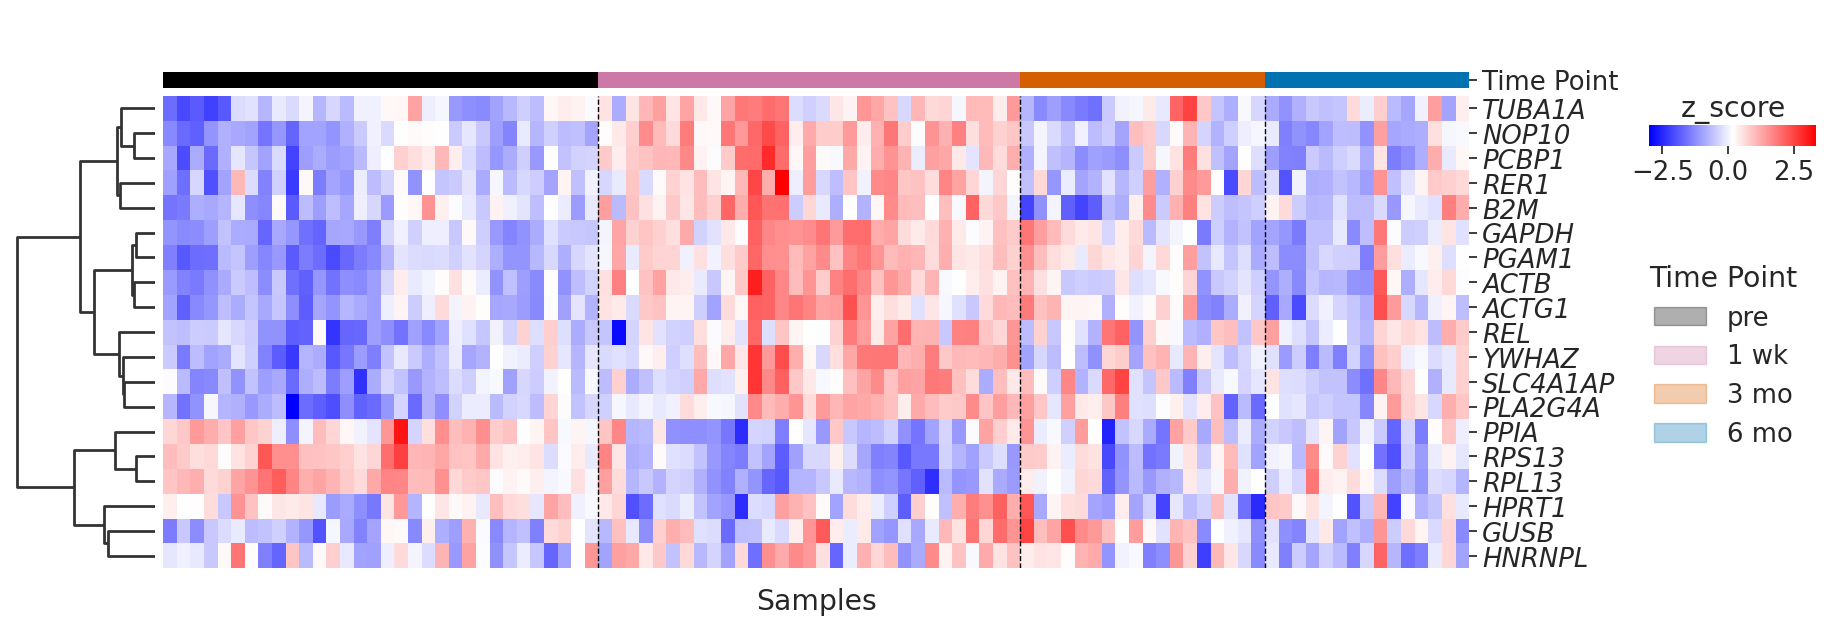

In [42]:
df_meta_cl = pd.read_csv('/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/metadata/metadata.csv')[['Run','timeOfBloodDraw']].set_index('Run')
df_vsd = pd.read_csv('/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_pre_pos_vsd.csv', index_col=0).loc[hkg_kidney_ref,:]
df_meta_list = []
for tp in ['pre','1w','3m','6m']:
    aux = df_meta_cl[df_meta_cl.timeOfBloodDraw==tp]
    Z = sch.linkage(df_vsd.loc[:,aux.index].T, 'ward')    
    aux = [aux.index[int(l)] for l in sch.dendrogram(Z, no_plot=True)['ivl']]
    df_meta_list.append(df_meta_cl.loc[aux,:])
    del(Z)
Run_order = pd.concat(df_meta_list).index

df_meta_cl['timeOfBloodDraw'] = df_meta_cl.timeOfBloodDraw.map(dict(zip(['pre','1w','3m','6m'],colors__)))#
df_meta_cl.columns = ['Time Point']
df_meta_cl = df_meta_cl.loc[Run_order,:]
df_vsd = pd.read_csv('/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_pre_pos_vsd.csv', index_col=0).loc[hkg_kidney_ref,Run_order]
sns.set_theme(style="whitegrid", font_scale=1.7)
g = sns.clustermap(df_vsd, z_score=0, cmap='bwr',#'seismic',#
                   col_colors=df_meta_cl, col_cluster=False, method='ward',tree_kws={'lw':2},
                   dendrogram_ratio=.1, cbar_pos=(1.0, 0.8, 0.1, 0.025), figsize=(8.35*2,8.35),yticklabels=1,cbar_kws={"orientation": "horizontal"}) 
g.ax_heatmap.axvline(32, lw=1, color='black', ls='--')
g.ax_heatmap.axvline(63, lw=1, color='black', ls='--')
g.ax_heatmap.axvline(81, lw=1, color='black', ls='--')
g.ax_heatmap.set_xticklabels([])
for label in g.ax_heatmap.get_yticklabels():
    # label.set_fontsize(8)#, style='italic')
    label.set_fontstyle('italic')
g.ax_heatmap.set_xlabel('Samples')
g.ax_cbar.set_title('z_score')
legend_TP = [mpatches.Patch(color=c, label=l) for l,c in zip(['pre','1 wk','3 mo','6 mo'],colors__)]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.12,.45),handles=legend_TP,frameon=False)
l2.set_title(title='Time Point')


g.savefig('/mnt/d/housekeeping_genes/draft/heatmap_usual_hkg_v2.pdf', format='pdf', dpi=300)

## Barplot logfold change (Fig 1A)

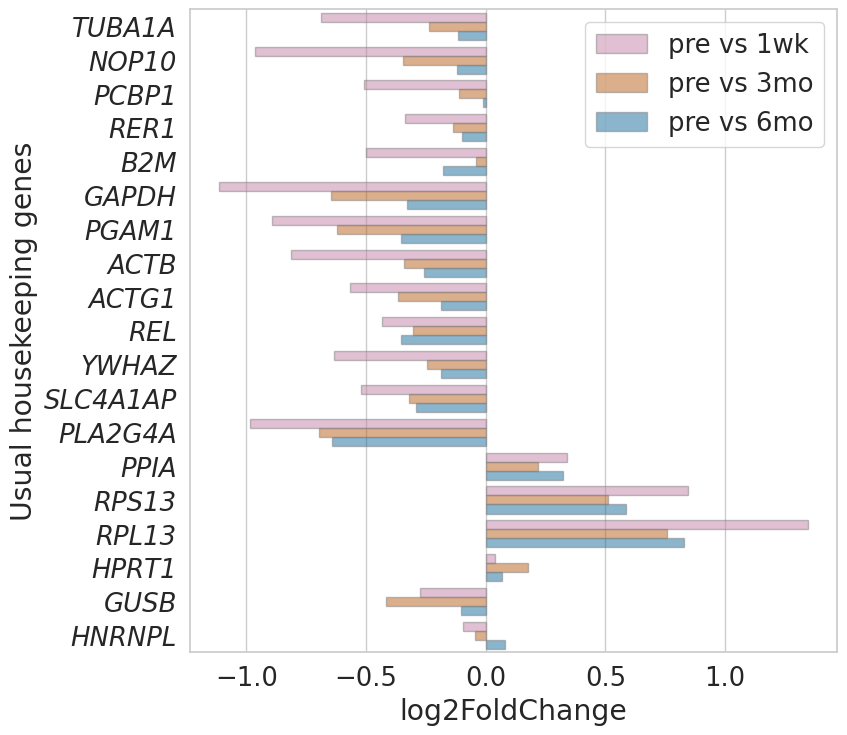

In [43]:
fig = plt.figure( figsize=(8.35,8.35) )
ax = fig.add_subplot(1,1,1)
res_keys = [k for k in res_dict.keys() if ('greaterAbs' in k) and ('_0_' in k)]
diff_genes = dict()

diff_df = []
for rk in res_keys:
    diff_df.append(res_dict[rk].loc[hkg_kidney_ref,['log2FoldChange','-log10padj']])
    diff_df[-1]['Contrast'] = rk.split('_',4)[-1]
diff_df = pd.concat(diff_df).reset_index()

order = [t.get_text() for t in g.ax_heatmap.get_yticklabels()]
sns.barplot(hue='Contrast',x='log2FoldChange', y='index', order=order, palette=Okabe_Ito[1:4], edgecolor='gray', alpha=0.5, data=diff_df, ax=ax)
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for l in labels:
    new_labels.append(l.replace('_', ' ').replace('w','wk').replace('m','mo'))

ax.legend(handles=handles, labels=new_labels, loc='upper right')#, fontsize=22)
ax.set_ylabel('Usual housekeeping genes')

for label in ax.get_yticklabels():
    # label.set_fontsize(8)#, style='italic')
    label.set_fontstyle('italic')

fig.savefig('/mnt/d/housekeeping_genes/draft/barplot_usual_lfc_v2.pdf', format='pdf', dpi=300)

# Discovery hkg are based on RNAseq:

- GSE175718 (384)
- GSE120649 (16)
- GSE112927 (235 pre)
- GSE86884 (96 nr)

# Calculating equivalent genes from study GSE86884 

## R Scritp to equivalent genes

In [ ]:
# %%R Script
# library("tximport")
# library("readr")
# library("DESeq2")
# library('glmpca')
# library('ggplot2')

# dir_0 = 'pre_posttransplant_PRJNA342822_GSE86884'
# dir = paste0('D:/',dir_0,'/trimmed_salmon_quant')
# metadata = read.csv(paste0('D:/',dir_0,'/metadata/metadata.csv'))
# tx2gene = read_csv('D:/reference_files/homo_sapiens/gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv')
# tx2gene_no_pseudo = read_csv('D:/housekeeping_genes/tx2gene_gene_type_filtered_no_pseudogene.csv')

# samples = metadata$Run
# files = file.path(dir, samples, "quant.sf")
# length(files)
# txi = tximport(files, type="salmon", tx2gene=tx2gene)
# txi$abundance = txi$abundance[rownames(txi$abundance) %in% tx2gene_no_pseudo$Gene_name, ]
# txi$counts = txi$counts[rownames(txi$counts) %in% tx2gene_no_pseudo$Gene_name, ]
# txi$length = txi$length[rownames(txi$length) %in% tx2gene_no_pseudo$Gene_name, ]

# ddsTxi <- DESeq2::DESeqDataSetFromTximport(txi,
#                                            colData = metadata,
#                                            design = ~timeOfBloodDraw+gender+race+age_bins)

# dds = DESeq2::DESeq(ddsTxi)
# colnames(dds) = samples

# altHypothesis = 'lessAbs'
# lfcThreshold = 0.5
# cond1 = "pre"

# for (cond2 in c('1wk','3m', '6m')){
#     res = DESeq2::results(dds, lfcThreshold=lfcThreshold, altHypothesis=altHypothesis,
#                           contrast=c("timeOfBloodDraw",cond1, cond2)) #
    
#     res_v = na.omit(res[order(res$padj),])
#     vsd = vst(dds, blind=FALSE)
#     f = paste0('D:/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_',altHypothesis,'_',lfcThreshold,'_',cond1,'_vs_',cond2,'_') 
#     write.csv(res[order(res$padj),], file = paste0(f,'res.csv'), quote = FALSE)
# }
# f = paste0('D:/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_') 
# write.csv(assay(vsd), file = paste0(f,'pre_pos_vsd.csv'), quote = FALSE)

## Equivalent Genes from GSE86884 study (Fig 1-CDE)

[Text(0.0, 0, ''),
 Text(0.2, 0, ''),
 Text(0.4, 0, ''),
 Text(0.6000000000000001, 0, ''),
 Text(0.8, 0, ''),
 Text(1.0, 0, '')]

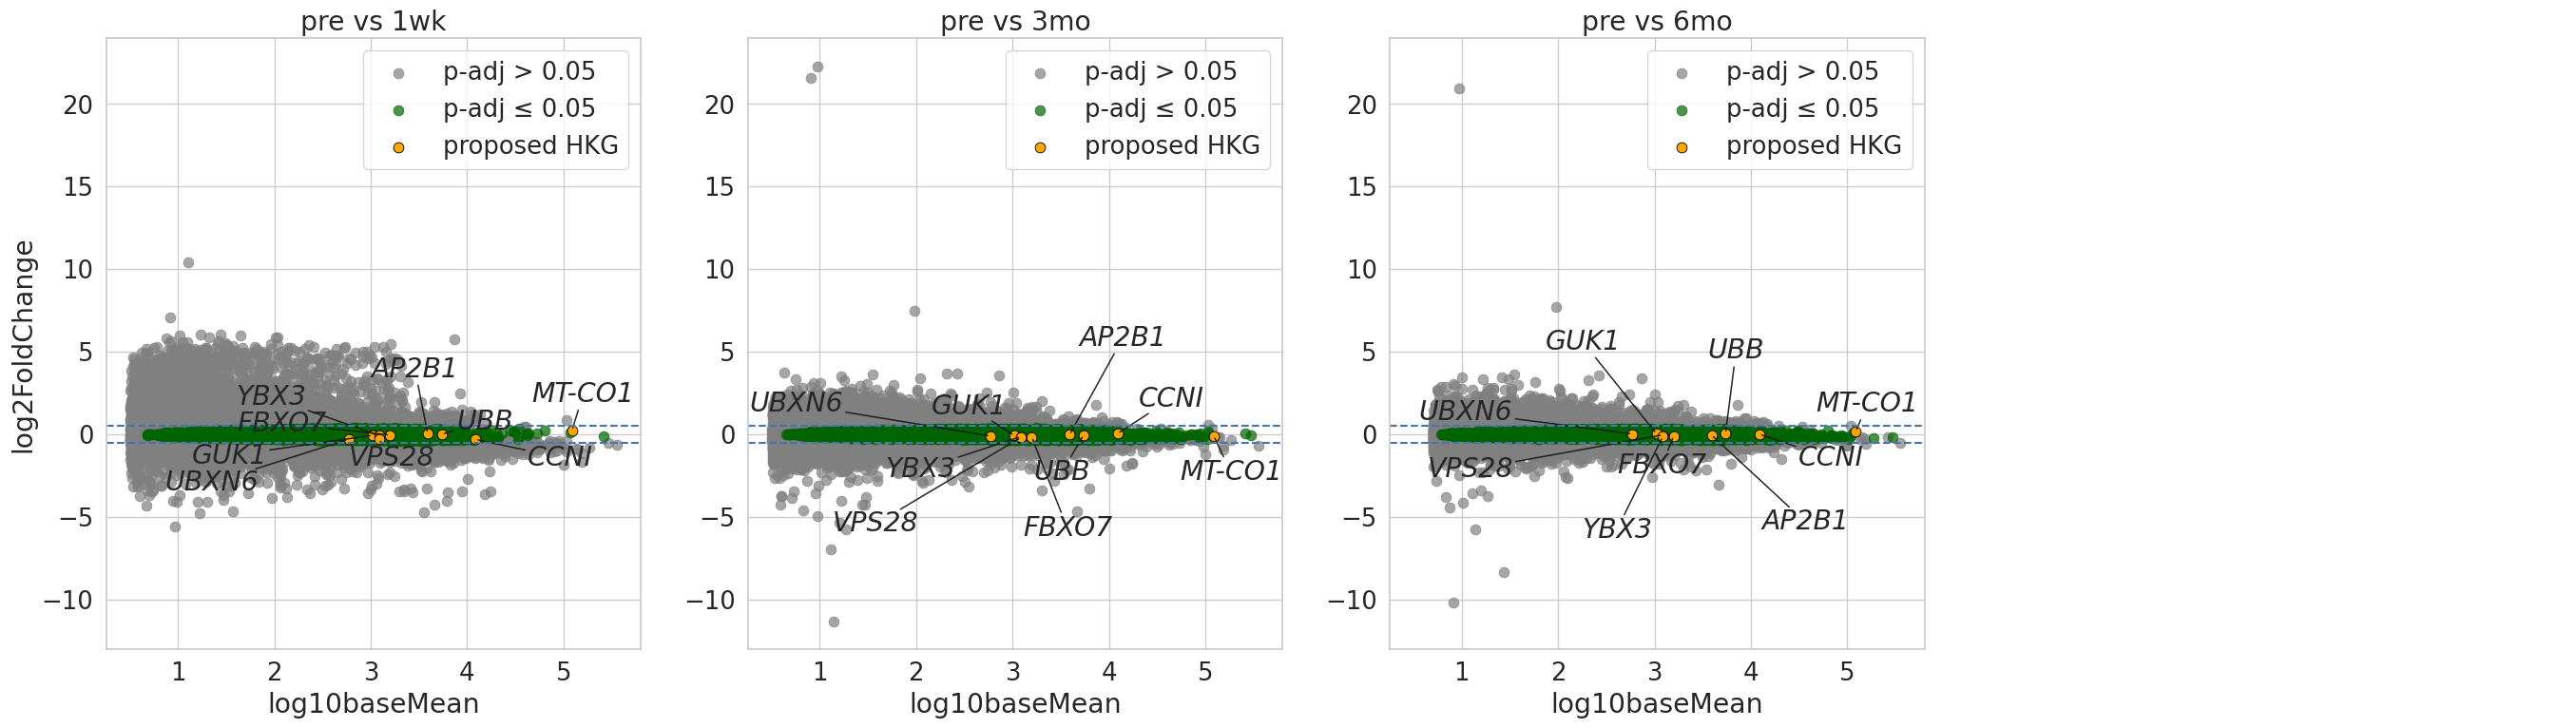

In [59]:
fig = plt.figure( figsize=(8.35*4,8.35) )
res_keys = [k for k in res_dict.keys() if ('lessAbs' in k) and ('0.5' in k)]
eq_genes = dict()

stable_genes = genes
i = 0 
# xlim_list = []
# ylim_list = []
title_list = ['pre vs 1wk', 'pre vs 3mo','pre vs 6mo']
for rk in res_keys:
    texts = []
    if i == 0:        
        ax = fig.add_subplot(1, len(res_keys)+1, i+1)
        ax_1 = ax
    else:
        ax = fig.add_subplot(1, len(res_keys)+1, i+1, sharey=ax_1, sharex=ax_1 )
    
    lfc_null = float(rk.split('_')[3])    
    ref_not_p = res_dict[rk].loc[(res_dict[rk].index.isin(hkg_kidney_ref)) & (res_dict[rk].padj>0.05),:].index.tolist()
    ref_not_lfc = res_dict[rk].loc[(res_dict[rk].index.isin(hkg_kidney_ref)) & (res_dict[rk].log2FoldChange.abs()>lfc_null),:].index.tolist()
    eq_genes[' vs '.join(rk.replace('vs_','').split('_')[-2:])] = set(res_dict[rk][(res_dict[rk].baseMean>0) & (res_dict[rk].log2FoldChange.abs()<=lfc_null) & (res_dict[rk].padj<=0.05)].index.tolist())
    
    
    ax.axhline(-lfc_null, ls='--', lw=1.5)
    ax.axhline(+lfc_null, ls='--', lw=1.5)
    sns.scatterplot(x='log10baseMean', y='log2FoldChange', color='gray', alpha=.7, edgecolor=None, label='p-adj > 0.05', s=60, data=res_dict[rk].loc[(res_dict[rk].padj>0.05),:], ax=ax)
    sns.scatterplot(x='log10baseMean', y='log2FoldChange', color='darkgreen', alpha=.7, edgecolor=None, label='p-adj ≤ 0.05', s=60, data=res_dict[rk].loc[(res_dict[rk].log2FoldChange.abs()<=lfc_null) & (res_dict[rk].padj<=0.05) & (~res_dict[rk].index.isin(stable_genes)),:], ax=ax)
    sns.scatterplot(x='log10baseMean', y='log2FoldChange', color='orange', alpha=1, edgecolor='black', label='proposed HKG', s=60, data=res_dict[rk].loc[(res_dict[rk].log2FoldChange.abs()<=lfc_null) & (res_dict[rk].padj<=0.05) & (res_dict[rk].index.isin(stable_genes)),:], ax=ax)
    ax.set_title(title_list[i])
    # , style='italic'    
    if i > 0:
        ax.set_ylabel('')
        
    ax.set_xlim(xlim_list[i])
    ax.set_ylim(ylim_list[i])
    
    i+=1
   
    for l,x,y in res_dict[rk].loc[(res_dict[rk].index.isin(stable_genes)),:][['log10baseMean','log2FoldChange']].reset_index().values:
        texts.append(ax.text(x, y, l,  va='center',ha='center', fontstyle='italic',
                            ))
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95),
                expand=(2, 2),
               )

    # xlim_list.append(ax.get_xlim())
    # ylim_list.append(ax.get_ylim())

    # ax.get_legend().remove()
    # ax.grid(False)
    # ax.spines[['left','right', 'top','bottom']].set_visible(False)
    # ax.set_yticklabels([])
    # ax.set_xticklabels([])
    # ax.set_xlabel('')
    # ax.set_ylabel('')
    
ax = fig.add_subplot(144)
ax.grid(False)
ax.spines[['left','right', 'top','bottom']].set_visible(False)
ax.set_yticklabels([])
ax.set_xticklabels([])


# fig.tight_layout()
# fig.savefig('/mnt/d/housekeeping_genes/draft/TOST_hkg_ann.pdf', format='pdf', dpi=300)
# fig.savefig('/mnt/d/housekeeping_genes/draft/TOST.jpeg', format='jpeg', dpi=300)

In [36]:
xlim_list, ylim_list

([(0.25426745067525763, 5.802173098223619),
  (0.25426745067525763, 5.802173098223619),
  (0.25426745067525763, 5.802173098223619)],
 [(-6.3776664261145, 11.210682699802302),
  (-13.02827818318827, 23.981594872357668),
  (-13.02827818318827, 23.981594872357668)])

## Venn diagram with equivalent genes in different timepoints (Fig 1F)

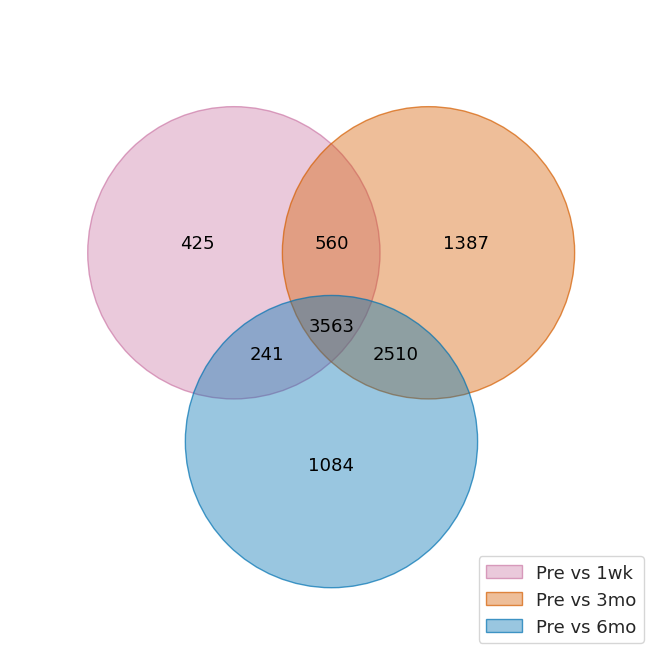

In [61]:
fig = plt.figure( figsize=(8.35,8.35) )   

ax = fig.add_subplot(1,1,1)
venn(eq_genes, cmap=Okabe_Ito[1:],  ax=ax)
legend = ax.get_legend()
legend.get_texts()[0].set_text('Pre vs 1wk')
legend.get_texts()[1].set_text('Pre vs 3mo')
legend.get_texts()[2].set_text('Pre vs 6mo')
legend.set_loc('lower right')
fig.savefig('/mnt/d/housekeeping_genes/draft/Venn_v2.pdf', format='pdf', dpi=300)

### Import Equivalent from GSE86884 study

In [3]:
path = '/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/hkg/'
lfc_null = 0.5
pv = 0.05
res_files = ['all_factors_lessAbs_0.5_pre_vs_1w_res.csv', 'all_factors_lessAbs_0.5_pre_vs_3m_res.csv', 'all_factors_lessAbs_0.5_pre_vs_6m_res.csv']
res = set()

for i,r in enumerate(res_files):
    aux = pd.read_csv(os.path.join(path,r), index_col=0)
    aux = aux[(aux['log2FoldChange'].abs()<=0.5) & ((aux['padj']<=0.05))]
    if i == 0:
        res = set(aux.index)
    else:
        res = res.intersection(set(aux.index))
print('There are',len(res),'common genes in pre vs 1wk, pre vs 3m and pre vs 6m')

There are 3563 common genes in pre vs 1wk, pre vs 3m and pre vs 6m


## Import RNAseq data for common not DEG

### TPM and Counts

In [4]:
tx2gene = pd.read_csv('/mnt/d/reference_files/homo_sapiens/gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv')

In [5]:
salmon_paths = ['/mnt/d/posttransplant_PRJNA733336_GSE175718/trimmed_salmon_quant/',                
                '/mnt/d/posttransplant_PRJNA493832_GSE120649/trimmed_salmon_quant/',
                '/mnt/d/pretransplant_PRJNA449520_GSE112927/trimmed_salmon_quant/',
                '/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/trimmed_salmon_quant/']
tpm = []
counts_tpm = []

for path in salmon_paths:
    tpm_aux = []
    counts_aux = []
    srr_list = os.listdir(path)
    print(path.split('/')[3], end=': ')
    for j,srr in enumerate(srr_list):
        df_aux = pd.read_csv(os.path.join(path,srr,'quant.sf'), sep='\t')[['Name','TPM','EffectiveLength','NumReads']].merge(tx2gene[['Transcript_ID','Gene_name']], left_on='Name', right_on='Transcript_ID')
        df_aux = df_aux.groupby('Gene_name').sum(numeric_only=True)  
        df_aux['counts_tpm'] = np.round(df_aux.NumReads,0).astype(int)
        tpm_aux.append(df_aux.TPM.values)
        counts_aux.append(df_aux.counts_tpm.values)
        print(j+1, end=' ')
    tpm.append(pd.DataFrame(tpm_aux, columns=df_aux.index, index=srr_list))
    counts_tpm.append(pd.DataFrame(counts_aux, columns=df_aux.index, index=srr_list))
    print('\n')
    # tpm[-1]['Study'] = studies[i]
    
df_tpm = pd.concat(tpm, axis=0)
df_counts = pd.concat(counts_tpm, axis=0)
    # df_tpm#.to_csv('/mnt/d/housekeeping_genes/tpm_blood_pre_pos_pos.csv')

posttransplant_PRJNA733336_GSE175718: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 26

In [6]:
adata = ad.AnnData(df_tpm)
adata.layers['count'] = df_counts.loc[adata.obs.index,adata.var.index].values
adata

AnnData object with n_obs × n_vars = 731 × 60883
    layers: 'count'

### Metadata

#### GSE175718

In [7]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('/mnt/d/postransplant_cristian_colab/metadata/GSE175718_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
            
df_GSE175718_meta = pd.DataFrame(aux).set_index(0).T
df_GSE175718_meta.columns = ['Title', 'Sample Name', 'ar', 'abmrh', 'tcmr', 'polyoma', 'dsa']
df_GSE175718_meta = pd.read_csv('/mnt/d/postransplant_cristian_colab/metadata/SraRunTable.txt')[['Sample Name', 'Run']].merge(df_GSE175718_meta, on='Sample Name').set_index('Sample Name')
df_GSE175718_meta['ar'] = df_GSE175718_meta.ar.str.split(':').str[1].str.strip()
df_GSE175718_meta['abmrh'] = df_GSE175718_meta.abmrh.str.split(':').str[1].str.strip()
df_GSE175718_meta['tcmr'] = df_GSE175718_meta.tcmr.str.split(':').str[1].str.strip()
df_GSE175718_meta['dsa'] = df_GSE175718_meta.dsa.str.split(':').str[1].fillna('0').str.strip()
df_GSE175718_meta['polyoma'] = df_GSE175718_meta.polyoma.str.split(':').str[-1].str.strip()
# no: 0_viremia:1_pvan:2_unknown:3
df_GSE175718_meta['abmrh_tcmr_dsa'] = df_GSE175718_meta[['abmrh', 'tcmr', 'dsa']].agg('-'.join,axis=1)
df_GSE175718_meta[['Title_GC','Title_LN']] = df_GSE175718_meta.Title.str.split('_', expand=True)
df_GSE175718_meta['Title_N'] = df_GSE175718_meta.Title_LN.str[1:]
df_GSE175718_meta['Title_L'] = df_GSE175718_meta.Title_LN.str[0]
df_GSE175718_meta = df_GSE175718_meta.set_index('Run')[['abmrh','tcmr','ar']]
df_GSE175718_meta['gse'] = 'GSE175718'
df_GSE175718_meta['gse_time'] = np.nan
df_GSE175718_meta['gse_patient'] = np.nan

#### GSE120649

In [8]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('/mnt/d/posttransplant_PRJNA493832_GSE120649/metadata/GSE120649_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
            
df_GSE120649_meta = pd.DataFrame(aux).set_index(0).T.iloc[:,:2]
df_GSE120649_meta.columns = ['Title', 'Sample Name']
df_GSE120649_meta['abmrh'] = np.where(df_GSE120649_meta.Title.str.contains('with antibody mediated rejection'), 1, 0)
df_GSE120649_meta['tcmr'] = np.where(df_GSE120649_meta.Title.str.contains('with T cell mediated rejection'), 1, 0)
df_GSE120649_meta['ar'] = df_GSE120649_meta.abmrh | df_GSE120649_meta.tcmr
df_GSE120649_meta = df_GSE120649_meta.merge(pd.read_csv('/mnt/d/posttransplant_PRJNA493832_GSE120649/metadata/SraRunTable.txt')[['Run','Sample Name']], on='Sample Name')
df_GSE120649_meta = df_GSE120649_meta[df_GSE120649_meta.Run.isin(adata.obs.index)]
df_GSE120649_meta = df_GSE120649_meta.set_index('Run')[['abmrh','tcmr','ar']]
df_GSE120649_meta['gse'] = 'GSE120649'
df_GSE120649_meta['gse_time'] = np.nan
df_GSE120649_meta['gse_patient'] = np.nan

#### GSE112927

In [9]:
df_GSE112927_meta = pd.read_csv('/mnt/d/pretransplant_PRJNA449520_GSE112927/metadata/SraRunTable.txt')[['Run','acr_before_or_at_6m','acr_after_6m','LibraryLayout']].set_index('Run')
df_GSE112927_meta['acr_before_or_at_6m'] = df_GSE112927_meta.acr_before_or_at_6m.replace('None', np.nan).replace('ACR or Borderline', '_b6mo')
df_GSE112927_meta['acr_after_6m'] = df_GSE112927_meta.acr_after_6m.replace('None', np.nan).replace('ACR', '_a6mo').replace('Borderline', '_a6mo')
df_GSE112927_meta = df_GSE112927_meta.fillna('')
df_GSE112927_meta['gse'] = 'GSE112927'
df_GSE112927_meta['gse_time'] = df_GSE112927_meta.gse + df_GSE112927_meta.acr_before_or_at_6m + df_GSE112927_meta.acr_after_6m
df_GSE112927_meta['gse_patient'] = df_GSE112927_meta.gse + '_' + df_GSE112927_meta.LibraryLayout
df_GSE112927_meta['abmrh'] = 0
df_GSE112927_meta['tcmr'] = 0
df_GSE112927_meta['ar'] = np.where((df_GSE112927_meta.acr_before_or_at_6m != '') | (df_GSE112927_meta.acr_after_6m != ''), '1', '0')
df_GSE112927_meta = df_GSE112927_meta.drop(['acr_before_or_at_6m', 'acr_after_6m', 'LibraryLayout'], axis=1)

#### GSE86884

In [10]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/metadata/GSE86884_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
df_GSE86884_meta = pd.DataFrame(aux).set_index(0).T.iloc[:,:2]
df_GSE86884_meta.columns = ['patient','Sample Name']

df_GSE86884_meta = df_GSE86884_meta.merge(pd.read_csv('/mnt/d/pre_posttransplant_PRJNA342822_GSE86884/metadata/SraRunTable.txt')[['Run','time_of_blood_draw','Sample Name']], on='Sample Name').set_index('Run')
condlist = [df_GSE86884_meta.time_of_blood_draw.str.startswith('pre'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('1'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('3'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('6')]
choicelist = ['GSE86884_'+'pre', 'GSE86884_'+'1wk', 'GSE86884_'+'3mo', 'GSE86884_'+'6mo']
df_GSE86884_meta['gse_time'] = np.select(condlist=condlist, choicelist=choicelist)

df_GSE86884_meta['gse'] = 'GSE86884'
df_GSE86884_meta['gse_patient'] = df_GSE86884_meta.patient.str.split('-').str[2]
df_GSE86884_meta['abmrh'] = 0
df_GSE86884_meta['tcmr'] = 0
df_GSE86884_meta['ar'] = 0
df_GSE86884_meta = df_GSE86884_meta.drop(['patient','Sample Name','time_of_blood_draw'], axis=1)

In [11]:
adata.obs[['abmrh', 'tcmr', 'ar', 'gse','gse_time','gse_patient']] = pd.concat([df_GSE175718_meta,df_GSE120649_meta,df_GSE112927_meta,df_GSE86884_meta]).loc[adata.obs.index,:].astype(str).values

In [12]:
adata.var['equivalent'] = np.where(adata.var.index.isin(res), 'equivalent','non_equivalent')

In [13]:
adata

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient'
    var: 'equivalent'
    layers: 'count'

## Create groups by unsupervised clustering
The groups are created based on TPM and Louvain clustering

In [14]:
hkg.pp.create_groups(adata, study_col='gse')

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

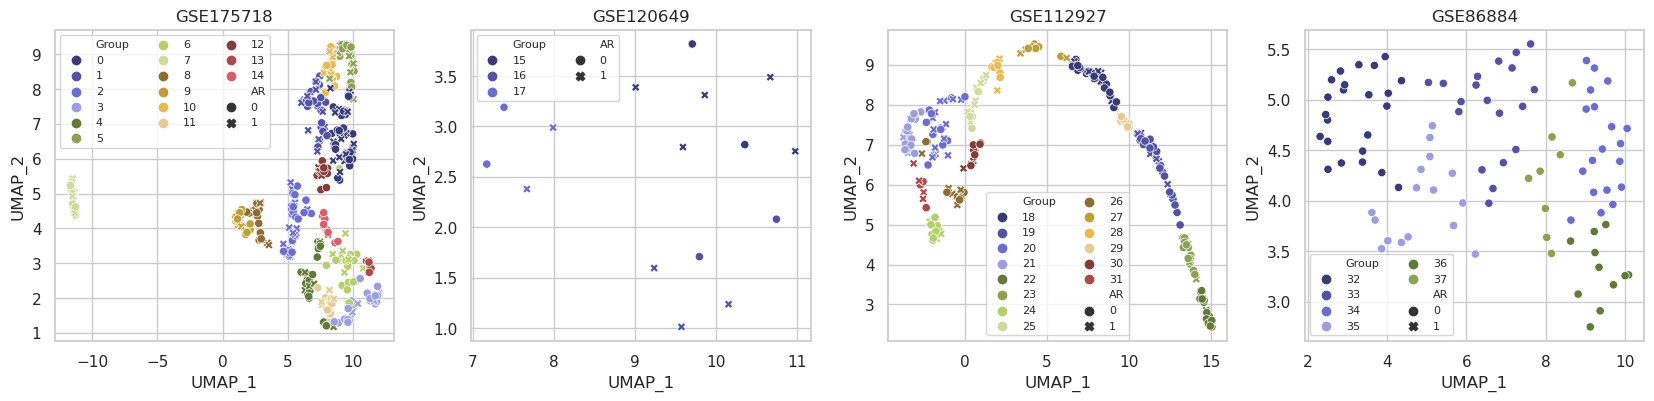

In [288]:
fig = plt.figure(figsize=(8.35*2,8.35/2))
for i, gse in enumerate(['GSE175718','GSE120649','GSE112927','GSE86884']):
    ax = fig.add_subplot(1,4,i+1)
    if gse == 'GSE86884':
        sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='louvain_group', style='ar', palette='tab20b', data=adata.obs[adata.obs.gse==gse].dropna(), ax=ax)
    else:
        sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='louvain_group', style='ar', palette='tab20b', data=adata.obs[adata.obs.gse==gse], ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    labels = [l.replace('louvain_group','Group').replace('ar', 'AR') for l in labels]
    ncol = 2
    if gse in ['GSE175718']:
        ncol=3
    ax.legend(handles=handles, labels=labels, ncol=ncol, fontsize=8)
    ax.set_title(gse)
fig.tight_layout()

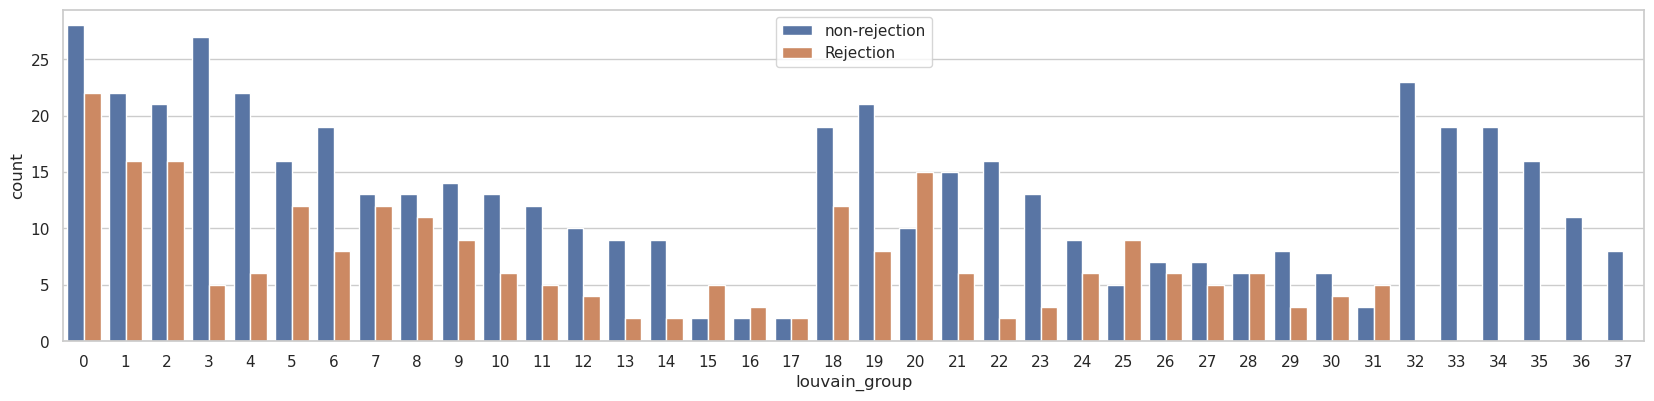

In [290]:
fig = plt.figure(figsize=(8.35*2,8.35/2))
ax = fig.add_subplot(111)
sns.countplot(x='louvain_group',hue='ar',data=adata.obs, ax=ax)
handles, labels = ax.get_legend_handles_labels()
subsk = {'ar':'AR','0':'non-rejection','1':'Rejection'}
labels = [subsk[l] for l in labels]
ax.legend(handles=handles, labels=labels)
fig.tight_layout()

## Read UNpreprocessed adata
Until clustering groups by similarity between samples 

In [293]:
# adata.write_h5ad('/mnt/d/housekeeping_genes/adata_RNAseq_louvain.h5ad')
adata = ad.read_h5ad('/mnt/d/housekeeping_genes/adata_RNAseq_louvain.h5ad')
adata

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

## Mapping types off transformation

In [294]:
adata.obs['type'] = adata.obs.gse.map({'GSE175718': 'MRN', 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})

In [295]:
trns_dict = dict(adata.obs[['louvain_group','type']].values)
hkg.pp.transform_exprs(adata, layer='count', groups_col='louvain_group', trns_dict=trns_dict)

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr'

## Log transforming trans_expr

In [296]:
hkg.pp.log_transform(adata, layer='trns_expr', method='log1p')
hkg.pp.log_transform(adata, layer='trns_expr', method='arcsinh')

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'log1p', 'arcsinh'

## Keepping equivalent genes
excluding GSE86884 because there is only non-rejection and it was used to calculate equivalent genes by DESeq2

In [297]:
adata = adata[adata.obs.gse!='GSE86884',adata.var.equivalent=='equivalent']
adata

View of AnnData object with n_obs × n_vars = 635 × 3563
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'log1p', 'arcsinh'

## Exclude genes with high number of zeros expressions

In [298]:
aux = adata.to_df()
print('non-zero expr median quantity:', (aux>0).sum().quantile(.5))

non-zero expr median quantity: 627.0


In [299]:
cols = aux.loc[:,((aux>0).sum()>=600).values].columns.values.tolist()
print('Qty. of genes with non-zero counts >= 600:', len(cols))

Qty. of genes with non-zero counts >= 600: 2638


<Axes: ylabel='Count'>

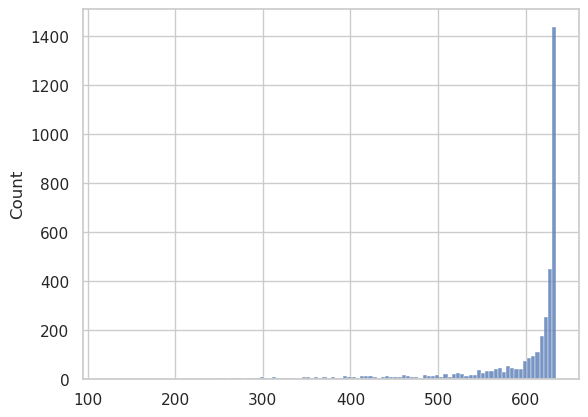

In [300]:
sns.histplot(data=(aux>0).sum())

## Keep only genes with at least 600 non zeros expression

In [35]:
adata = adata[:,cols]
adata

View of AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'log1p', 'arcsinh'

# Calculate genes clusters by cv, stability and gini

## Calculate CV and stb_cv

In [61]:
hkg.mining.exprs_cv(adata, layer='arcsinh', groups_col='louvain_group')
hkg.mining.stability_cv(adata, layer='arcsinh', groups_col='louvain_group')
hkg.mining.gene_gini_coeff(adata, layer='arcsinh')

CV: computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
Stability: computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 


AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'count', 'log1p', 'trns_expr', 'trns_expr_per_louvain_group', 'arcsinh_per_louvain_group', 'log1p_per_louvain_group'

In [62]:
adata.var['log_pool_mean'] = np.log(adata.var.pool_mean)
adata.var['log_pool_cv'] = np.log(adata.var.pool_cv)
adata.var['log_pool_stability_cv'] = np.log(adata.var.pool_stability_cv)
adata.var['log_gini_coefficient'] = np.log(adata.var.gini_coefficient)

In [63]:
nearestNeighbors_object = NearestNeighbors()
louvain_object = Louvain(random_state=42, resolution=.5)
scaler_object = StandardScaler()

In [64]:
hkg.mining.uclustering_cv_stb_gini(adata, cl_cols=['log_pool_cv','log_pool_stability_cv','log_gini_coefficient'],
                                   nearestNeighbors_object=nearestNeighbors_object,
                                   louvain_object=louvain_object,scaler_object=scaler_object)

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'count', 'log1p', 'trns_expr', 'trns_expr_per_louvain_group', 'arcsinh_per_louvain_group', 'log1p_per_louvain_group'

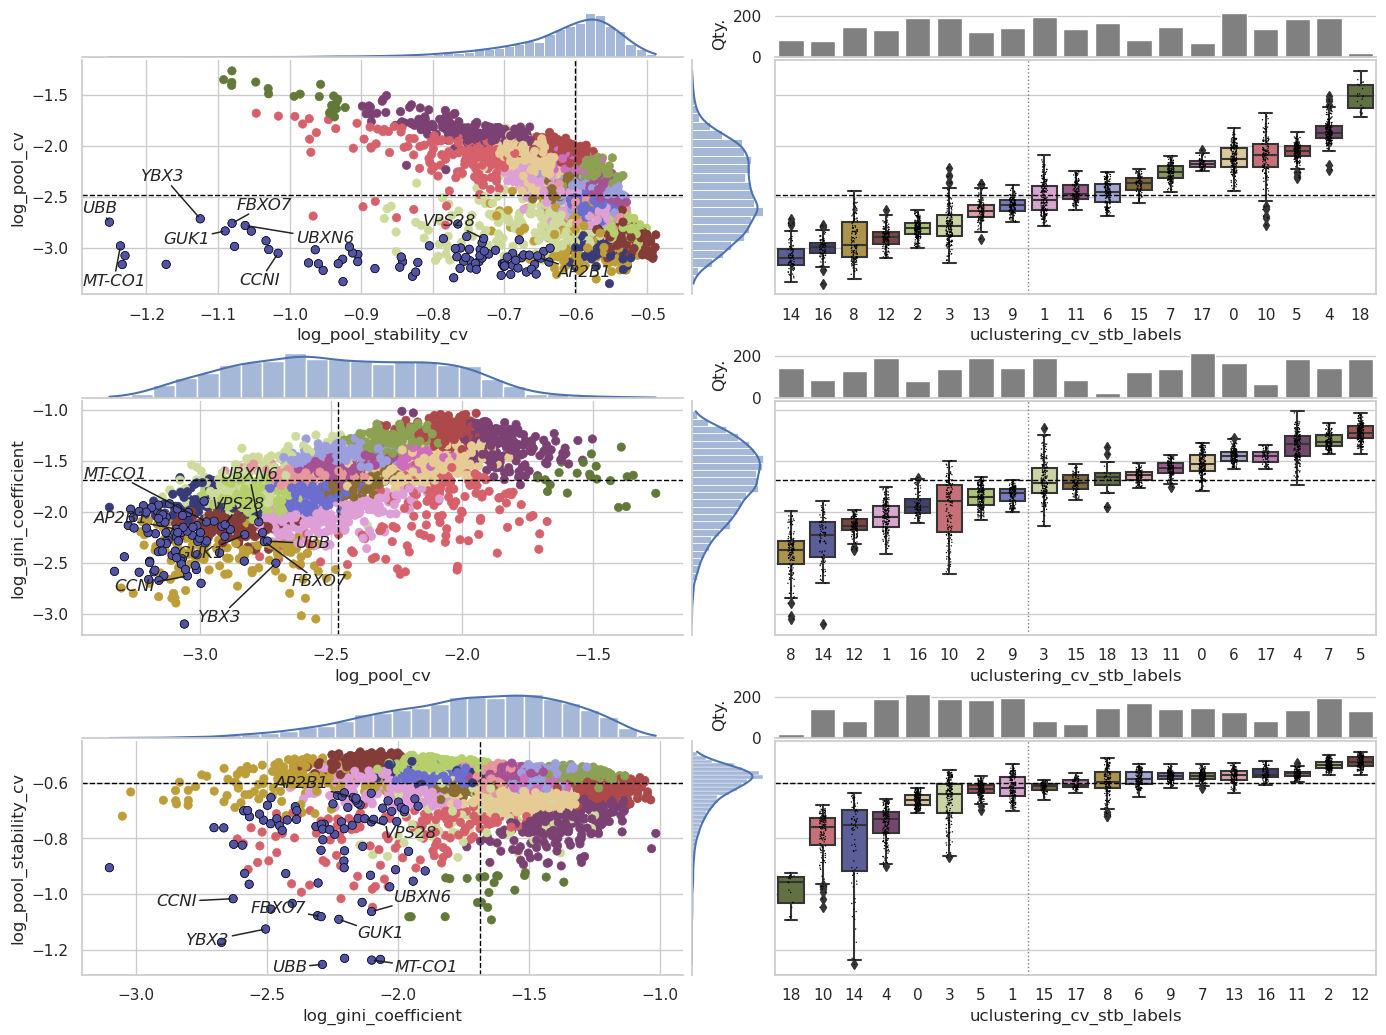

In [12]:
# feats_3 = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'MT-CO1', 'UBB', 'UBXN6', 'VPS28', 'YBX3']
hkg.plot.plot_stb_cv_gini(adata, x='log_pool_stability_cv', y='log_pool_cv', z='log_gini_coefficient', hue='uclustering_cv_stb_labels', palette='tab20b_r',figsize=(8.35*2,8.35*3/2), ann_genes=genes,highlight_group=14)

In [16]:
# adata.var[adata.var.uclustering_cv_stb_labels==14]

equivalent  pool_mean  pool_std   pool_cv  pool_stability_cv  \
Gene_name                                                                 
AKNA       equivalent   7.530073  0.301774  0.040076           0.385528   
AKT2       equivalent   6.955147  0.291863  0.041964           0.477017   
ANKRD11    equivalent   6.984010  0.307615  0.044046           0.473328   
ANKRD44    equivalent   6.463022  0.312146  0.048297           0.524650   
AP2B1      equivalent   6.625285  0.301060  0.045441           0.520761   
...               ...        ...       ...       ...                ...   
VPS28      equivalent   6.868462  0.376140  0.054763           0.482460   
YBX1       equivalent   8.028579  0.473146  0.058933           0.348735   
YBX3       equivalent   8.335982  0.554247  0.066489           0.324712   
ZBTB7A     equivalent   6.892836  0.336708  0.048849           0.490473   
ZNF207     equivalent   6.622437  0.256128  0.038676           0.519149   

           gini_coefficient  log_pool_mean  log_pool_cv  \
Gene_name                                                 
AKNA               0.143599       2.018905    -3.216981   
AKT2               0.109181       1.939482    -3.170954   
ANKRD11            0.102232       1.943623    -3.122531   
ANKRD44            0.107537       1.866097    -3.030382   
AP2B1              0.114188       1.890893    -3.091339   
...                     ...            ...          ...   
VPS28              0.119348       1.926940    -2.904733   
YBX1               0.083428       2.083008    -2.831359   
YBX3               0.081760       2.120581    -2.710725   
ZBTB7A             0.079883       1.930483    -3.019022   
ZNF207             0.115463       1.890463    -3.252541   

           log_pool_stability_cv  log_gini_coefficient  \
Gene_name                                                
AKNA                   -0.953143             -1.940728   
AKT2                   -0.740203             -2.214752   
ANKRD11                -0.747967             -2.280508   
ANKRD44                -0.645025             -2.229925   
AP2B1                  -0.652465             -2.169905   
...                          ...                   ...   
VPS28                  -0.728857             -2.125708   
YBX1                   -1.053443             -2.483769   
YBX3                   -1.124816             -2.503963   
ZBTB7A                 -0.712385             -2.527197   
ZNF207                 -0.655564             -2.158809   

           uclustering_cv_stb_labels  
Gene_name                             
AKNA                              14  
AKT2                              14  
ANKRD11                           14  
ANKRD44                           14  
AP2B1                             14  
...                              ...  
VPS28                             14  
YBX1                              14  
YBX3                              14  
ZBTB7A                            14  
ZNF207                            14  

[85 rows x 11 columns]

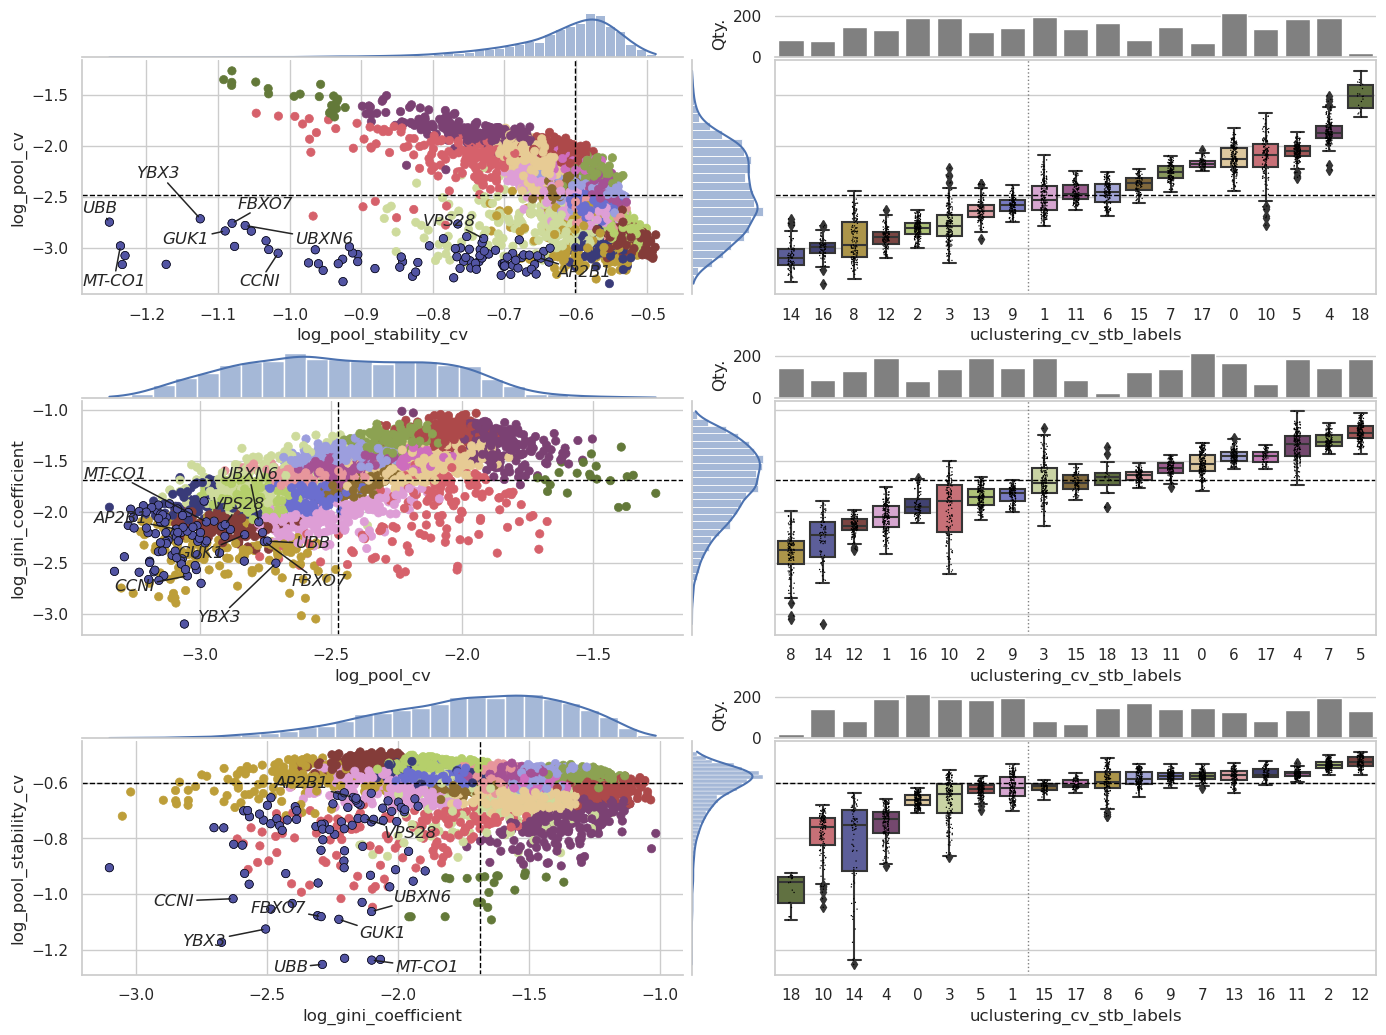

In [13]:
import warnings
import itertools

import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import seaborn as sns
from statannotations.Annotator import Annotator
from adjustText import adjust_text
from scipy.stats import pearsonr, false_discovery_control
import scipy.cluster.hierarchy as sch

x='log_pool_stability_cv'
y='log_pool_cv'
z='log_gini_coefficient'
hue='uclustering_cv_stb_labels'
palette='tab20b_r'
figsize=(8.35*2,8.35*3/2)
ann_genes=genes
legend=False
median_line=True

fig = plt.figure(figsize=figsize)

gs = fig.add_gridspec(3,1)
# gs_top = GridSpec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02)
gs_top = gs[0].subgridspec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02)
ax_clu = fig.add_subplot(gs_top[1,0])
ax_y = fig.add_subplot(gs_top[1,1])
ax_x = fig.add_subplot(gs_top[0,0])
ax_y_bar = fig.add_subplot(gs_top[0,2])
ax_y_violin = fig.add_subplot(gs_top[1,2])

gs_middle = gs[1].subgridspec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02)
ax_clu2 = fig.add_subplot(gs_middle[1,0])
ax_y2 = fig.add_subplot(gs_middle[1,1])
ax_x2 = fig.add_subplot(gs_middle[0,0])
ax_y_bar2 = fig.add_subplot(gs_middle[0,2])
ax_y_violin2 = fig.add_subplot(gs_middle[1,2])

gs_bottom = gs[2].subgridspec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02)
ax_clu3 = fig.add_subplot(gs_bottom[1,0])
ax_y3 = fig.add_subplot(gs_bottom[1,1])
ax_x3 = fig.add_subplot(gs_bottom[0,0])
ax_y_bar3 = fig.add_subplot(gs_bottom[0,2])
ax_y_violin3 = fig.add_subplot(gs_bottom[1,2])


if hue == None:
    palette = None
    cmap = None
    hue_order = None
else:
    hue_order = adata.var[hue].unique()
    cmap = plt.get_cmap(palette, len(hue_order))
    cmap = [colors.to_hex(cmap(i)) for i in range(len(hue_order))]
    cmap = dict(zip(hue_order,cmap))

# TOP grid
sns.scatterplot(x=x, y=y, hue=hue, edgecolor=None, palette=cmap, data=adata.var, ax=ax_clu)
sns.scatterplot(x=x, y=y, hue=hue, edgecolor='black',palette=cmap, data=adata.var[adata.var.uclustering_cv_stb_labels==14], ax=ax_clu)
ax_clu.get_legend().set_visible(legend)
ax_clu.spines[['right', 'top']].set_visible(False)

sns.histplot(x=x, ec='white', data=adata.var, kde=True, ax=ax_x)
ax_x.spines[['left','right', 'top']].set_visible(False)
ax_x.set_xlabel(None)
ax_x.set_ylabel(None)
ax_x.set_xticklabels([])
ax_x.set_yticklabels([])
ax_x.tick_params(left = False)
ax_x.grid(False)

sns.histplot(y=y, ec='white', data=adata.var, kde=True, ax=ax_y)
ax_y.spines[['right', 'top','bottom']].set_visible(False)
ax_y.set_ylabel(None)
ax_y.set_xlabel(None)
ax_y.set_yticklabels([])
ax_y.set_xticklabels([])
ax_y.tick_params(bottom = False)
ax_y.grid(False)

order = adata.var.groupby(hue).median(numeric_only=True).sort_values(y).index
sns.countplot(x=hue, order=order, color='gray', data=adata.var, ax=ax_y_bar)
ax_y_bar.set_xticklabels([])
ax_y_bar.set_xlabel(None)
ax_y_bar.spines[['left','right', 'top']].set_visible(False)
ax_y_bar.set_ylabel('Qty.')

sns.stripplot(x=hue, y=y, order=order, color='black', s=1, data=adata.var, ax=ax_y_violin)
sns.boxplot(x=hue, y=y, order=order, palette=cmap, data=adata.var, ax=ax_y_violin)
ax_y_violin.set_ylabel(None)
ax_y_violin.set_yticklabels([])
aux_md = adata.var.groupby(hue).quantile(0.75, numeric_only=True)
arg_max = len(aux_md.loc[aux_md[y]<=adata.var[y].median(numeric_only=True)][y]) - .5
ax_y_violin.axvline(arg_max, ls=':', lw=1,color='gray')

# Middle grid
sns.scatterplot(x=y, y=z, hue=hue, edgecolor=None, palette=cmap, data=adata.var, ax=ax_clu2)
sns.scatterplot(x=y, y=z, hue=hue, edgecolor='black', palette=cmap, data=adata.var[adata.var.uclustering_cv_stb_labels==14], ax=ax_clu2)
ax_clu2.get_legend().set_visible(legend)
ax_clu2.spines[['right', 'top']].set_visible(False)

sns.histplot(x=y, ec='white', data=adata.var, kde=True, ax=ax_x2)
ax_x2.spines[['left','right', 'top']].set_visible(False)
ax_x2.set_xlabel(None)
ax_x2.set_ylabel(None)
ax_x2.set_xticklabels([])
ax_x2.set_yticklabels([])
ax_x2.tick_params(left = False)
ax_x2.grid(False)

sns.histplot(y=z, ec='white', data=adata.var, kde=True, ax=ax_y2)
ax_y2.spines[['right', 'top','bottom']].set_visible(False)
ax_y2.set_ylabel(None)
ax_y2.set_xlabel(None)
ax_y2.set_yticklabels([])
ax_y2.set_xticklabels([])
ax_y2.tick_params(bottom = False)
ax_y2.grid(False)

order = adata.var.groupby(hue).median(numeric_only=True).sort_values(z).index
sns.countplot(x=hue, order=order, color='gray', data=adata.var, ax=ax_y_bar2)
ax_y_bar2.set_xticklabels([])
ax_y_bar2.set_xlabel(None)
ax_y_bar2.spines[['left','right', 'top']].set_visible(False)
ax_y_bar2.set_ylabel('Qty.')

sns.stripplot(x=hue, y=z, order=order, color='black', s=1, data=adata.var, ax=ax_y_violin2)
sns.boxplot(x=hue, y=z, order=order, palette=cmap, data=adata.var, ax=ax_y_violin2)
ax_y_violin2.set_ylabel(None)
ax_y_violin2.set_yticklabels([])
aux_md = adata.var.groupby(hue).quantile(0.75, numeric_only=True)
arg_max = len(aux_md.loc[aux_md[z]<=adata.var[z].median(numeric_only=True)][z]) - .5
ax_y_violin2.axvline(arg_max, ls=':', lw=1,color='gray')

# Bottom grid
sns.scatterplot(x=z, y=x, hue=hue, edgecolor=None, palette=cmap, data=adata.var, ax=ax_clu3)
sns.scatterplot(x=z, y=x, hue=hue, edgecolor='black', palette=cmap, data=adata.var[adata.var.uclustering_cv_stb_labels==14], ax=ax_clu3)
ax_clu3.get_legend().set_visible(legend)
ax_clu3.spines[['right', 'top']].set_visible(False)

sns.histplot(x=z, ec='white', data=adata.var, kde=True, ax=ax_x3)
ax_x3.spines[['left','right', 'top']].set_visible(False)
ax_x3.set_xlabel(None)
ax_x3.set_ylabel(None)
ax_x3.set_xticklabels([])
ax_x3.set_yticklabels([])
ax_x3.tick_params(left = False)
ax_x3.grid(False)

sns.histplot(y=x, ec='white', data=adata.var, kde=True, ax=ax_y3)
ax_y3.spines[['right', 'top','bottom']].set_visible(False)
ax_y3.set_ylabel(None)
ax_y3.set_xlabel(None)
ax_y3.set_yticklabels([])
ax_y3.set_xticklabels([])
ax_y3.tick_params(bottom = False)
ax_y3.grid(False)

order = adata.var.groupby(hue).median(numeric_only=True).sort_values(x).index
sns.countplot(x=hue, order=order, color='gray', data=adata.var, ax=ax_y_bar3)
ax_y_bar3.set_xticklabels([])
ax_y_bar3.set_xlabel(None)
ax_y_bar3.spines[['left','right', 'top']].set_visible(False)
ax_y_bar3.set_ylabel('Qty.')

sns.stripplot(x=hue, y=x, order=order, color='black', s=1, data=adata.var, ax=ax_y_violin3)
sns.boxplot(x=hue, y=x, order=order, palette=cmap, data=adata.var, ax=ax_y_violin3)
ax_y_violin3.set_ylabel(None)
ax_y_violin3.set_yticklabels([])
aux_md = adata.var.groupby(hue).quantile(0.75, numeric_only=True)
arg_max = len(aux_md.loc[aux_md[x]<=adata.var[x].median(numeric_only=True)][x]) - .5
ax_y_violin3.axvline(arg_max, ls=':', lw=1,color='gray')

if median_line:
    ax_clu.axvline(np.median(adata.var[x]), ls='--', lw=1,color='black')
    ax_clu.axhline(np.median(adata.var[y]), ls='--', lw=1, color='black')
    ax_y_violin.axhline(np.median(adata.var[y]), ls='--', lw=1, color='black')

    ax_clu2.axvline(np.median(adata.var[y]), ls='--', lw=1,color='black')
    ax_clu2.axhline(np.median(adata.var[z]), ls='--', lw=1, color='black')
    ax_y_violin2.axhline(np.median(adata.var[z]), ls='--', lw=1, color='black')

    ax_clu3.axvline(np.median(adata.var[z]), ls='--', lw=1,color='black')
    ax_clu3.axhline(np.median(adata.var[x]), ls='--', lw=1, color='black')
    ax_y_violin3.axhline(np.median(adata.var[x]), ls='--', lw=1, color='black')

if ann_genes != None:
    texts = []
    for l_,x_,y_ in adata.var.loc[ann_genes, [x, y]].reset_index().values:
        texts.append(ax_clu.text(x_, y_, l_,  va='center',ha='center', fontsize=12, style='italic'))
    adjust_text(texts, ax=ax_clu, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95), expand=(2, 2))

    texts2 = []
    for l_,x_,y_ in adata.var.loc[ann_genes, [y, z]].reset_index().values:
        texts2.append(ax_clu2.text(x_, y_, l_,  va='center',ha='center', fontsize=12, style='italic'))
    adjust_text(texts2, ax=ax_clu2, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95), expand=(2, 2))

    texts3 = []
    for l_,x_,y_ in adata.var.loc[ann_genes, [z, x]].reset_index().values:
        texts3.append(ax_clu3.text(x_, y_, l_,  va='center',ha='center', fontsize=12, style='italic'))
    adjust_text(texts3, ax=ax_clu3, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95), expand=(2, 2))

fig.savefig('/mnt/d/housekeeping_genes/draft/CV_STB_GINI_v2.pdf', format='pdf', dpi=300)

In [24]:
isinstance(None,int)

False

## Read preprocessed adata

In [9]:
# adata.write_h5ad('/mnt/d/housekeeping_genes/adata_RNAseq_pre_processed.h5ad')
adata = ad.read_h5ad('/mnt/d/housekeeping_genes/adata_RNAseq_pre_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'arcsinh_per_louvain_group', 'count', 'log1p', 'log1p_per_louvain_group', 'trns_expr', 'trns_expr_per_louvain_group'

In [177]:
adata.var.equivalent.unique()

['equivalent']
Categories (1, object): ['equivalent']

In [175]:
adata[:,adata.var.uclustering_cv_stb_labels==14]

View of AnnData object with n_obs × n_vars = 635 × 85
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'arcsinh_per_louvain_group', 'count', 'log1p', 'log1p_per_louvain_group', 'trns_expr', 'trns_expr_per_louvain_group'

# Kruskal Wallis DEG
Exclude significant expressed genes for Kruskal Wallis

In [305]:
from scipy.stats import kruskal

In [307]:
condlist = [(adata.obs.abmrh=='0') & (adata.obs.tcmr=='0'), (adata.obs.abmrh=='0') & (adata.obs.tcmr=='1'), (adata.obs.abmrh=='1') & (adata.obs.tcmr=='0'), (adata.obs.abmrh=='1') & (adata.obs.tcmr=='1')]
choicelist = ['non-rejection', 'TCMR', 'ABMR', 'ABMR and TCMR']

adata.obs['conditions_GSE175718'] = np.select(condlist=condlist, choicelist=choicelist)

In [314]:
md_cv, md_stb, md_gini = adata.var[['log_pool_cv','log_pool_stability_cv','log_gini_coefficient']].median().values
# feats_1 = adata[(adata.obs.gse=='GSE175718'), (adata.var.uclustering_cv_stb_labels.isin([14])) & (adata.var.log_pool_cv<=md_cv) & (adata.var.log_pool_stability_cv<=md_stb) & (adata.var.log_gini_coefficient<=md_gini)].var.index.tolist()
feats_1 = adata[(adata.obs.gse=='GSE175718'), (adata.var.uclustering_cv_stb_labels.isin([14]))].var.index.tolist()
print(len(feats_1),feats_1)

85 ['AKNA', 'AKT2', 'ANKRD11', 'ANKRD44', 'AP2B1', 'BRD2', 'BRD4', 'BTG1', 'CALM1', 'CCNI', 'CD74', 'CELF1', 'CELF2', 'CHD2', 'COX4I1', 'CSDE1', 'CTDNEP1', 'CYFIP2', 'CYLD', 'DDX17', 'DDX5', 'DDX6', 'DYNC1H1', 'EIF1', 'EIF3A', 'EWSR1', 'FBXO7', 'FNBP1', 'FUS', 'GSTK1', 'GUK1', 'HAGH', 'HMGB1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MACF1', 'MAVS', 'MDM4', 'MT-CO1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PRRC2C', 'PTP4A2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SPG7', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'TUBB', 'TUG1', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZNF207']


In [310]:
# rename layers to rerun trans MRN
adata.layers['trns_expr_per_louvain_group'] = adata.layers['trns_expr'].copy()
adata.layers['arcsinh_per_louvain_group'] = adata.layers['arcsinh'].copy()
adata.layers['log1p_per_louvain_group'] = adata.layers['log1p'].copy()

In [311]:
trns_dict = dict(adata.obs[['gse','type']].values)
hkg.pp.transform_exprs(adata, layer='count', groups_col='gse', trns_dict=trns_dict)
hkg.pp.log_transform(adata, layer='trns_expr', method='arcsinh')

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'arcsinh_per_louvain_group', 'count', 'log1p', 'log1p_per_louvain_group', 'trns_expr', 'trns_expr_per_louvain_group'

In [312]:
aux = adata[(adata.obs.gse=='GSE175718'), feats_1].to_df('trns_expr')
aux['conditions_GSE175718'] = adata[adata.obs.gse=='GSE175718',:].obs.conditions_GSE175718.values
genes = aux.columns[:-1]
pv = []
for g in genes:
    pv.append(kruskal(aux.loc[(aux.conditions_GSE175718=='non-rejection'),g], aux.loc[(aux.conditions_GSE175718=='ABMR'),g], aux.loc[(aux.conditions_GSE175718=='TCMR'),g]).pvalue)

In [178]:
for g in ['AKT2', 'ANKRD11', 'BTG1', 'CYLD', 'EWSR1', 'FUS', 'PRRC2C']:
    print(g, end=', ')

AKT2, ANKRD11, BTG1, CYLD, EWSR1, FUS, PRRC2C, 

In [313]:
aux_pv = pd.DataFrame(zip(aux.columns[:-1],pv)).set_index(0)
pv_kr = aux_pv[aux_pv[1]<=.05].index.tolist()
print(pv_kr)

['AKT2', 'ANKRD11', 'BTG1', 'CYLD', 'EWSR1', 'FUS', 'PRRC2C']


In [315]:
feats_2 = [f for f in feats_1 if f not in pv_kr]
print(len(feats_2),feats_2)

78 ['AKNA', 'ANKRD44', 'AP2B1', 'BRD2', 'BRD4', 'CALM1', 'CCNI', 'CD74', 'CELF1', 'CELF2', 'CHD2', 'COX4I1', 'CSDE1', 'CTDNEP1', 'CYFIP2', 'DDX17', 'DDX5', 'DDX6', 'DYNC1H1', 'EIF1', 'EIF3A', 'FBXO7', 'FNBP1', 'GSTK1', 'GUK1', 'HAGH', 'HMGB1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MACF1', 'MAVS', 'MDM4', 'MT-CO1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PTP4A2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SPG7', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'TUBB', 'TUG1', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZNF207']


In [14]:
feats_2 = ['AKNA', 'ANKRD44', 'AP2B1', 'BRD2', 'BRD4', 'CALM1', 'CCNI', 'CD74', 'CELF1', 'CELF2', 'CHD2', 'COX4I1', 'CSDE1', 'CTDNEP1', 'CYFIP2', 'DDX17', 'DDX5', 'DDX6', 'DYNC1H1', 'EIF1', 'EIF3A', 'FBXO7', 'FNBP1', 'GSTK1', 'GUK1', 'HAGH', 'HMGB1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MACF1', 'MAVS', 'MDM4', 'MT-CO1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PTP4A2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SPG7', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'TUBB', 'TUG1', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZNF207']

# [TOST](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5502906/)
Keeping only the equivalent genes in the study GSE175718

We didn't calculate TOST by louvain group because there were som groups with low values of hits in some conditions.

## outlier Detection for TOST

In [19]:
# adata.obs.index!='SRR14675592' because all values are zero
pv_tost = hkg.mining.tost(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'), feats_2],
                          combinations_list=[('non-rejection', 'ABMR'), ('non-rejection', 'TCMR')], layer='trns_expr', class_col='conditions_GSE175718',
                          cohens_d=.3,is_parametric=False, is_paired=False, correct_fdr=True)
# pv_tost.T

In [20]:
# feats_3 = np.sort(pv_tost.loc[:,(pv_tost<=0.05).sum()>=2].columns).tolist()
pv_tost = pv_tost.loc[:,(pv_tost<=0.05).sum()>=2]
pv_tost.index = pv_tost.index.str.replace('pv_','').str.split('_')
print(len(feats_3),feats_3)

9 ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'MT-CO1', 'UBB', 'UBXN6', 'VPS28', 'YBX3']


In [17]:
feats_3 = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'MT-CO1', 'UBB', 'UBXN6', 'VPS28', 'YBX3']

In [21]:
aux = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718!='ABMR and TCMR'), feats_3].to_df('arcsinh')
aux['conditions_GSE175718'] = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718!='ABMR and TCMR'),feats_3].obs.conditions_GSE175718.values
aux = aux.melt(id_vars='conditions_GSE175718')

In [22]:
from statannotations.Annotator import Annotator

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UBXN6_non-rejection vs. UBXN6_ABMR: Custom statistical test, P_val:1.642e-03
AP2B1_non-rejection vs. AP2B1_ABMR: Custom statistical test, P_val:1.657e-02
FBXO7_non-rejection vs. FBXO7_ABMR: Custom statistical test, P_val:2.838e-02
CCNI_non-rejection vs. CCNI_ABMR: Custom statistical test, P_val:1.039e-02
VPS28_non-rejection vs. VPS28_ABMR: Custom statistical test, P_val:9.481e-03
MT-CO1_non-rejection vs. MT-CO1_ABMR: Custom statistical test, P_val:1.046e-02
GUK1_non-rejection vs. GUK1_ABMR: Custom statistical test, P_val:4.526e-02
UBB_non-rejection vs. UBB_ABMR: Custom statistical test, P_val:1.642e-03
YBX3_non-rejection vs. YBX3_ABMR: Custom statistical test, P_val:4.980e-02
UBXN6_non-rejection vs. UBXN6_TCMR: Custom statistical test, P_val:1.397e-02
FBXO7_non-rejection vs. FBXO7_TCMR: Custom sta

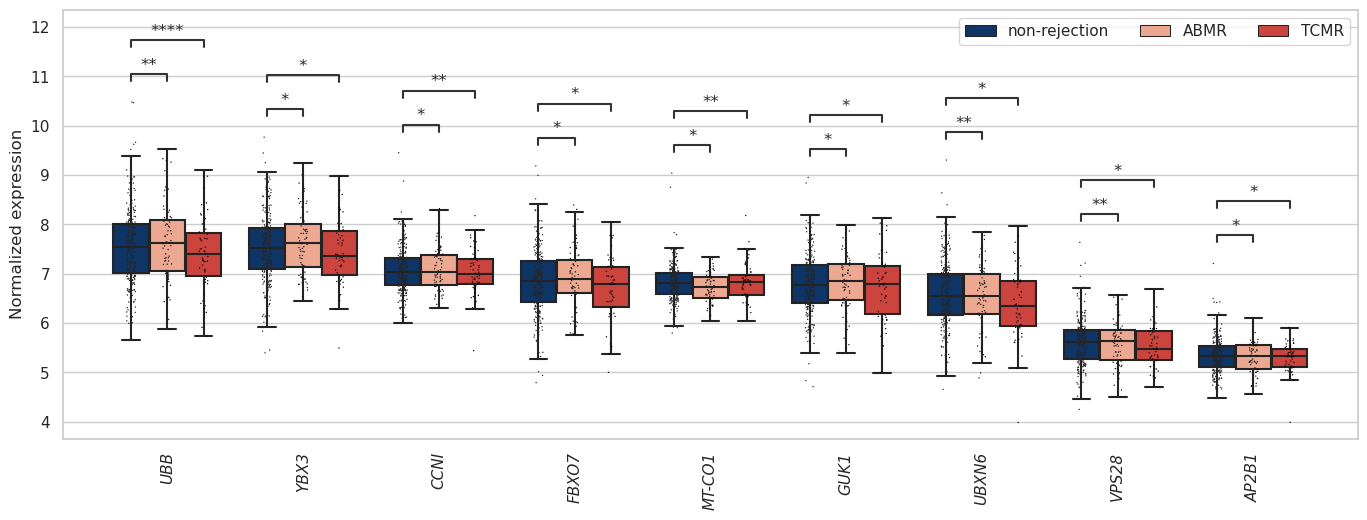

In [24]:
fig = plt.figure(figsize=(8.35*2, 8.35*2/3))
ax = fig.add_subplot(111)

x='Gene_name'
y='value'
hue='conditions_GSE175718'
hue_order=['non-rejection','ABMR','TCMR']
order = aux.groupby(['Gene_name']).median(numeric_only=True).sort_values('value', ascending=False).index

sns.stripplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, color='black', s=1, dodge=True, data=aux, ax=ax)
sns.boxplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, palette=['#003375', '#fca082', '#e32f27'], fliersize=False, data=aux, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[3:], labels=labels[3:], ncol=3)

for label in ax.get_xticklabels():
    # label.set_fontsize(8)#, style='italic')
    label.set_rotation(90)
    label.set_fontstyle('italic')

ax.set_xlabel('')
ax.set_ylabel('Normalized expression')

pairs = []
p_test = []
for c in pv_tost.columns:
    p_test.extend(pv_tost[c].values.tolist())
    for i in pv_tost.index:        
        pairs.append(((c,i[0]),(c,i[1])))
        
annot_test = Annotator(ax, pairs, data=aux, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
annot_test.configure(test=None, text_format='star', loc='inside', verbose=1)
annot_test.set_pvalues(p_test)
annot_test.annotate()

plt.show()
fig.savefig('/mnt/d/housekeeping_genes/draft/TOST_KW_v2.pdf', format='pdf', dpi=300, bbox_inches='tight')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UBXN6_non-rejection vs. UBXN6_ABMR: Custom statistical test, P_val:1.642e-03
AP2B1_non-rejection vs. AP2B1_ABMR: Custom statistical test, P_val:1.657e-02
FBXO7_non-rejection vs. FBXO7_ABMR: Custom statistical test, P_val:2.838e-02
CCNI_non-rejection vs. CCNI_ABMR: Custom statistical test, P_val:1.039e-02
VPS28_non-rejection vs. VPS28_ABMR: Custom statistical test, P_val:9.481e-03
MT-CO1_non-rejection vs. MT-CO1_ABMR: Custom statistical test, P_val:1.046e-02
GUK1_non-rejection vs. GUK1_ABMR: Custom statistical test, P_val:4.526e-02
UBB_non-rejection vs. UBB_ABMR: Custom statistical test, P_val:1.642e-03
YBX3_non-rejection vs. YBX3_ABMR: Custom statistical test, P_val:4.980e-02
UBXN6_non-rejection vs. UBXN6_TCMR: Custom statistical test, P_val:1.397e-02
FBXO7_non-rejection vs. FBXO7_TCMR: Custom sta

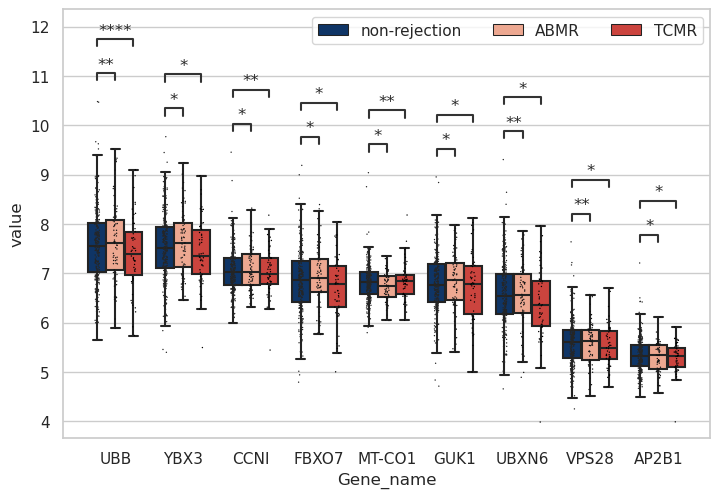

In [320]:
fig = plt.figure(figsize=(8.35, 8.35*2/3))
ax = fig.add_subplot(111)

x='Gene_name'
y='value'
hue='conditions_GSE175718'
hue_order=['non-rejection','ABMR','TCMR']
order = aux.groupby(['Gene_name']).median(numeric_only=True).sort_values('value', ascending=False).index

sns.stripplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, color='black', s=1, dodge=True, data=aux, ax=ax)
sns.boxplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, palette=['#003375', '#fca082', '#e32f27'], fliersize=False, data=aux, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[3:], labels=labels[3:], ncol=3)

pairs = []
p_test = []
for c in pv_tost.columns:
    p_test.extend(pv_tost[c].values.tolist())
    for i in pv_tost.index:        
        pairs.append(((c,i[0]),(c,i[1])))
        
annot_test = Annotator(ax, pairs, data=aux, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
annot_test.configure(test=None, text_format='star', loc='inside', verbose=1)
annot_test.set_pvalues(p_test)
annot_test.annotate()

plt.show()

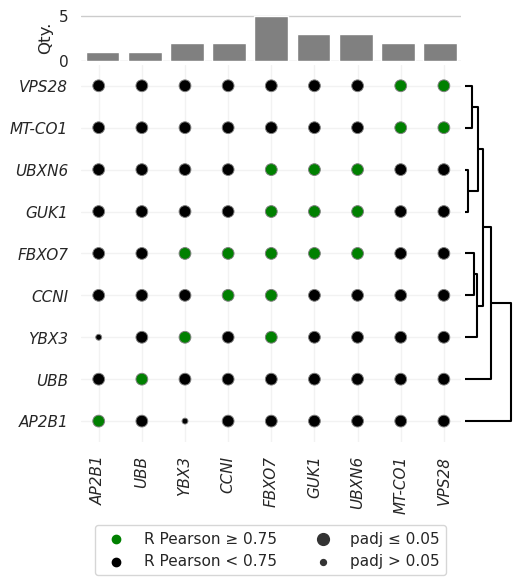

In [326]:
hkg.plot.plot_corr(adata[:,feats_3],r_pearson_lim=0.75, bbox_to_anchor=(.98, -.2), figsize=(8.35*2/3,8.35*2/3))

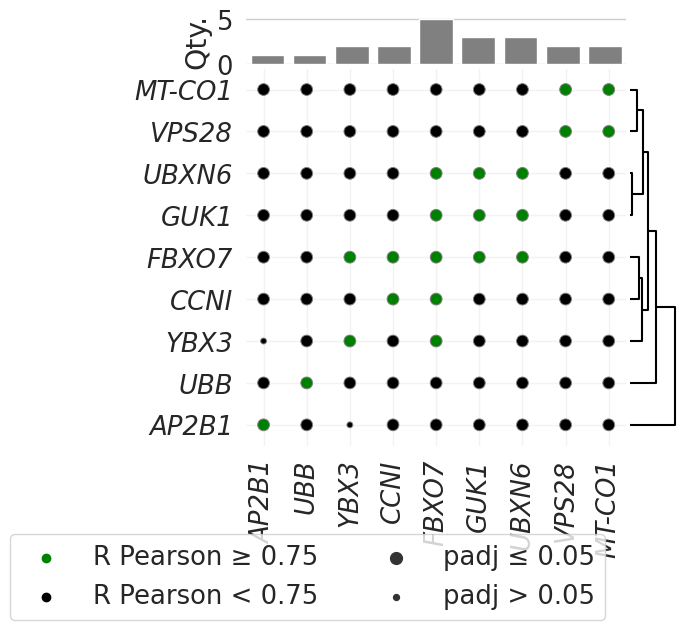

In [188]:
hkg.plot.plot_corr(adata[:,genes],r_pearson_lim=0.75, bbox_to_anchor=(.98, -.2), figsize=(8.35*2/3,8.35*2/3))

In [182]:
for g in genes:
    print(g, end=', ')

AP2B1, CCNI, FBXO7, GUK1, UBB, UBXN6, VPS28, YBX3, MT-CO1, 

In [1264]:
adata.var.loc[pv_tost.columns, 'pv_non-rejection_ABMR'] = pv_tost.loc['pv_non-rejection_ABMR',:].values
adata.var.loc[pv_tost.columns, 'pv_non-rejection_TCMR'] = pv_tost.loc['pv_non-rejection_TCMR',:].values

adata.var.loc[pv_tost.columns, '-log10_pv_non-rejection_ABMR'] = -np.log10(pv_tost.loc['pv_non-rejection_ABMR',:].values)
adata.var.loc[pv_tost.columns, '-log10_pv_non-rejection_TCMR'] = -np.log10(pv_tost.loc['pv_non-rejection_TCMR',:].values)

In [1265]:
aux = adata[adata.obs.gse=='GSE175718',pv_tost.columns].to_df('trns_expr')
aux['conditions_GSE175718'] = adata[adata.obs.gse=='GSE175718',pv_tost.columns].obs.conditions_GSE175718.values
aux = aux.groupby('conditions_GSE175718').median()

In [1266]:
adata.var.loc[pv_tost.columns, 'log2fc_non-rejection_ABMR'] = np.log2(aux.loc['non-rejection'] / aux.loc['ABMR']).values
adata.var.loc[pv_tost.columns, 'log2fc_non-rejection_TCMR'] = np.log2(aux.loc['non-rejection'] / aux.loc['TCMR']).values
# adata.var.loc[pv_tost.columns, 'log2fc_non-rejection_ABMR'] = (aux.loc['non-rejection'] / aux.loc['ABMR']).values
# adata.var.loc[pv_tost.columns, 'log2fc_non-rejection_TCMR'] = (aux.loc['non-rejection'] / aux.loc['TCMR']).values

In [1267]:
from adjustText import adjust_text

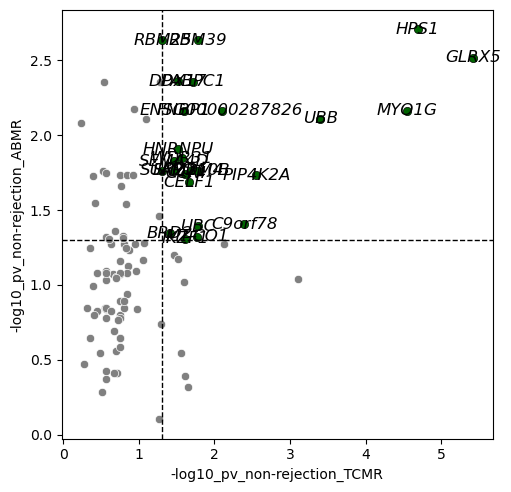

In [1268]:
# data = adata[:,(adata.var.uclustering_cv_stb_labels.isin([13])) & \
# (adata.var['-log10_pv_non-rejection_TCMR']>=adata.var.loc[pv_tost.columns, '-log10_pv_non-rejection_TCMR'].median()) & \
# (adata.var['-log10_pv_non-rejection_ABMR']>=adata.var.loc[pv_tost.columns, '-log10_pv_non-rejection_ABMR'].median())].var
fig = plt.figure(figsize=(8.35*2/3, 8.35*2/3))
ax = fig.add_subplot(111)
data = adata[:,(adata.var.uclustering_cv_stb_labels.isin([13]))].var
sns.scatterplot(x='-log10_pv_non-rejection_TCMR', y='-log10_pv_non-rejection_ABMR', color='grey', data=data[(data['-log10_pv_non-rejection_TCMR']<-np.log10(0.05)) | (data['-log10_pv_non-rejection_ABMR']<-np.log10(0.05))], ax=ax)

sns.scatterplot(x='-log10_pv_non-rejection_TCMR', y='-log10_pv_non-rejection_ABMR', color='darkgreen', edgecolor='black', data=data[(data['-log10_pv_non-rejection_TCMR']>=-np.log10(0.05)) & (data['-log10_pv_non-rejection_ABMR']>=-np.log10(0.05))], ax=ax)

texts = []
for l_,x_,y_ in data[(data['-log10_pv_non-rejection_TCMR']>=-np.log10(0.05)) & (data['-log10_pv_non-rejection_ABMR']>=-np.log10(0.05))][['-log10_pv_non-rejection_TCMR','-log10_pv_non-rejection_ABMR']].reset_index().values:
    texts.append(ax.text(x_, y_, l_,  va='center',ha='center', fontsize=12, style='italic'))#, fontsize=12
    # adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-",  ),#color='k',
    #             expand=(.0, .0)
    #            )
ax.axhline(-np.log10(0.05), color='black', ls='--', lw=1)
ax.axvline(-np.log10(0.05), color='black', ls='--', lw=1)

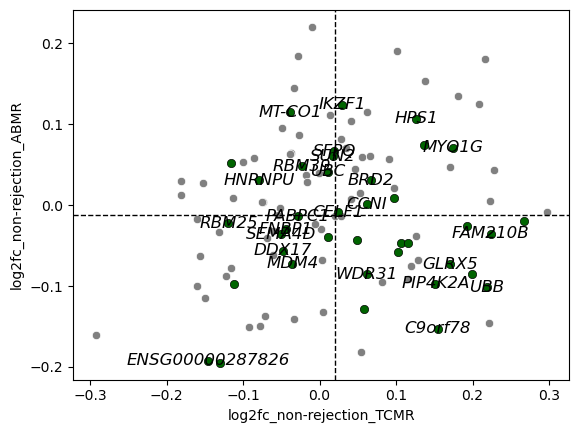

In [1269]:
ax = sns.scatterplot(x='log2fc_non-rejection_TCMR', y='log2fc_non-rejection_ABMR', color='grey', data=data[(data['-log10_pv_non-rejection_TCMR']<data['-log10_pv_non-rejection_TCMR'].median()) | (data['-log10_pv_non-rejection_ABMR']<data['-log10_pv_non-rejection_ABMR'].median())])

sns.scatterplot(x='log2fc_non-rejection_TCMR', y='log2fc_non-rejection_ABMR', color='darkgreen', edgecolor='black',data=data[(data['-log10_pv_non-rejection_TCMR']>=data['-log10_pv_non-rejection_TCMR'].median()) & (data['-log10_pv_non-rejection_ABMR']>=data['-log10_pv_non-rejection_ABMR'].median())], ax=ax)

# ax.axhline(.1, color='black', ls='--', lw=1)
# ax.axhline(-.1, color='black', ls='--', lw=1)
# ax.axvline(.1, color='black', ls='--', lw=1)
# ax.axvline(-.1, color='black', ls='--', lw=1)

texts = []
for l_,x_,y_ in data[(data['-log10_pv_non-rejection_TCMR']>=-np.log10(0.05)) & (data['-log10_pv_non-rejection_ABMR']>=-np.log10(0.05))][['log2fc_non-rejection_TCMR','log2fc_non-rejection_ABMR']].reset_index().values:
    texts.append(ax.text(x_, y_, l_,  va='center',ha='center', fontsize=12, style='italic'))
    # adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95),
    #             expand=(1.2, 1.2)
    #            )
# ax = sns.scatterplot(x='log2fc_non-rejection_TCMR', y='log2fc_non-rejection_ABMR', data=data)
ax.axhline(adata.var.loc[pv_tost.columns, 'log2fc_non-rejection_ABMR'].median(), color='black', ls='--', lw=1)
ax.axvline(adata.var.loc[pv_tost.columns, 'log2fc_non-rejection_TCMR'].median(), color='black', ls='--', lw=1)

In [508]:
# data.reset_index()

In [507]:
# fig = plt.figure(figsize=(8.35/2,8.35*2))
# ax_sc = fig.add_subplot(111)
# sns.scatterplot(x='log2fc_non-rejection_ABMR', y='Gene_name',hue='-log10_pv_non-rejection_ABMR',data=data.reset_index())
# fig.tight_layout()

In [427]:
# np.seterr(all='raise')
# method_ = brunnermunzel
# class_col = 'conditions_GSE175718'
# aux = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'),(adata.var.uclustering_cv_stb_labels.isin([13]))].to_df()
# aux[class_col] = adata.obs[class_col]
# g = 'AACS'
# combinations_list = [('non-rejection', 'ABMR'), ('non-rejection', 'TCMR')]
# dict_pairs = {p:[] for p in combinations_list}
# cohens_d = .5
# for p in dict_pairs.keys():
#     pv = [] 
#     delta = cohens_d*aux[aux[class_col].isin(p)].std(numeric_only=True)
#     for g in aux.columns[:-1]:
#         print(g, end=' ')
#         pv.append(max(method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values + delta[g], alternative='less').pvalue,
#                       method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values - delta[g], alternative='greater').pvalue)
#                  )
#     false_discovery_control(pv)

In [171]:
# pv

In [194]:

# max(method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values + delta[g], alternative='less').pvalue,
#                       method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values - delta[g], alternative='greater').pvalue)

In [196]:
# aux[['AAMP',class_col]].groupby('conditions_GSE175718').count()

In [181]:
# aux[aux[class_col]==p[0]]#[g]

In [182]:
# aux[aux[class_col]==p[1]][g]

In [199]:
# method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values - delta[g], alternative='greater')
method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values + delta[g], alternative='less')

BrunnerMunzelResult(statistic=7.417977468631004, pvalue=4.280464871442291e-12)

In [185]:
# pv

In [282]:
from scipy.stats import pearsonr, combine_pvalues, mannwhitneyu

def tost(adata, layer:str = None, class_col:str = None, combinations_list:list = None, vars_list:str = [], cohens_d:float = .5, is_parametric:bool = False, is_paired:bool = False, correct_fdr:bool = True):
    if class_col == None:
        raise Exception("TOST requires a class_col argument, with, at least, two different classes.")

    if layer != None:
        aux = adata.to_df(layer)
    else:
        aux = adata.to_df()

    aux[class_col] = adata.obs[class_col]

    if combinations_list == None:
        combinations_list = list(itertools.combinations(aux[class_col].unique(), 2))

    dict_pairs = {p:[] for p in combinations_list}

    method_ = brunnermunzel
    if is_paired:
        if is_parametric:
            method_ = ttest_rel
        else:
            method_ = wilcoxon
    else:
        if is_parametric:
            method_ = ttest_ind

    for p in dict_pairs.keys():
        pv = []
        delta = cohens_d*aux[aux[class_col].isin(p)].std(numeric_only=True)

        for g in aux.columns[:-1]:
            print(g,end=' ')
            pv.append(max(method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values + delta[g], alternative='less').pvalue,
            method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values - delta[g], alternative='greater').pvalue)
            )

        if correct_fdr:
            dict_pairs[p] = false_discovery_control(pv)
        else:
            dict_pairs[p] = pv

    aux_tost = pd.DataFrame(dict_pairs, index=aux.columns[:-1]).T[ (pd.DataFrame(dict_pairs, index=aux.columns[:-1]).T<=0.05).sum().sort_values(ascending=False).index ]
    aux_tost.index = ['pv_'+'_'.join(p) for p in aux_tost.index]

    return aux_tost
    
def pooled_tost(adata, layer:str = None, class_col:str = None, combinations_list:list = None, vars_list:str = [], groups_col:str = None, method:str='fisher', cohens_d:float = .5, is_parametric:bool = False, is_paired:bool = False, correct_fdr:bool = True):
    if groups_col == None:
        raise Exception("Pooled TOST requires a groups_col argument, with, at least, two different groups to be combined.")
    aux_tost = []

    if combinations_list == None:
        combinations_list = list(itertools.combinations(aux[class_col].unique(), 2))

    for gp in adata.obs[groups_col].unique():
        print('')
        print(gp)
        aux_tost.append(tost(adata[adata.obs[groups_col]==gp], layer=layer, class_col=class_col, combinations_list=combinations_list, vars_list=vars_list, cohens_d=cohens_d, is_parametric=is_parametric, is_paired=is_paired, correct_fdr=correct_fdr))

    aux_tost = pd.concat(aux_tost)
    pv_dict = {idx:[] for idx in aux_tost.index.unique()}
    statistic_dict = {idx:[] for idx in aux_tost.index.unique()}
    for idx in aux_tost.index.unique():
        for g in aux_tost.columns:
            print(g, end=' ')
            s,p = combine_pvalues(aux_tost.loc[idx,g], method=method)
            pv_dict[idx].append(p)
            statistic_dict[idx].append(s)

    # return pd.DataFrame(pv_dict, columns=aux_tost.columns), pd.DataFrame(statistic_dict, columns=aux_tost.columns)
    return pd.DataFrame(pv_dict, index=aux_tost.columns).T, pd.DataFrame(statistic_dict, index=aux_tost.columns).T

In [308]:
# pv_tost = pooled_tost(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (~adata.obs.louvain_group.isin([3,4,6,8,9,10,11,12,13,14])),
#                                  (adata.var.uclustering_cv_stb_labels.isin([13]))],
#                           combinations_list=[('non-rejection', 'ABMR'), ('non-rejection', 'TCMR')], layer=None, class_col='conditions_GSE175718',groups_col='louvain_group',
#                           cohens_d=.5,is_parametric=False, is_paired=False, correct_fdr=False)

In [302]:
pv_tost[0]

Gene_name                  IL16     MYO1G    CYFIP2     TCF25     FBXO7  \
pv_non-rejection_ABMR  0.068192  0.029493  0.110832  0.241109  0.143791   
pv_non-rejection_TCMR  0.026392  0.155089  0.081877  0.732573  0.237419   

Gene_name                 CALM1    PRRC2C  N4BP2L2     PRMT2   POLR2J3  ...  \
pv_non-rejection_ABMR  0.053158  0.163534  0.07712  0.176583  0.545117  ...   
pv_non-rejection_TCMR  0.249598  0.176038  0.56762  0.467294  0.177260  ...   

Gene_name                  GUK1     GSTK1     GLRX5       FUS     FNBP1  \
pv_non-rejection_ABMR  0.638645  0.357066  0.333242  0.100633  0.145032   
pv_non-rejection_TCMR  0.342284  0.298306  0.338846  0.203665  0.530318   

Gene_name               FAM210B    EWSR1  ENSG00000287826  ENSG00000287271  \
pv_non-rejection_ABMR  0.413523  0.18528         0.157050         0.306038   
pv_non-rejection_TCMR  0.251444  0.33199         0.219512         0.277570   

Gene_name               ZFP36L2  
pv_non-rejection_ABMR  0.462112  
pv_non-rejection_TCMR  0.198392  

[2 rows x 108 columns]

In [303]:
np.sort(pv_tost[0].loc[:,(pv_tost[0]<=0.1).sum()>=2].columns)

array(['IL16', 'NAP1L1'], dtype=object)

In [309]:
# p = ('non-rejection', 'TCMR')#('non-rejection', 'ABMR')# 
# g = 'BRD4'
# groups_col = 'louvain_group'
# gp = 6
# method_ = brunnermunzel #mannwhitneyu

# aux = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs[groups_col]==gp),(adata.var.uclustering_cv_stb_labels.isin([13]))].to_df()
# aux[class_col] = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs[groups_col]==gp),(adata.var.uclustering_cv_stb_labels.isin([13]))].obs[class_col]

# # method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values - delta[g], alternative='greater')
# method_(aux[aux[class_col]==p[0]][g].values, aux[aux[class_col]==p[1]][g].values + delta[g], alternative='less')

In [549]:
pv_tost_sig = pv_tost.loc[:,(pv_tost<=0.05).sum()>=2]
pv_tost_sig = pv_tost_sig[pv_tost_sig.mean(axis=0).sort_values().index]
pv_tost_sig

Gene_name                      HPS1       UBB     GLRX5   FAM210B   PIP4K2A  \
pv_non-rejection_ABMR  3.367028e-04  0.001515  0.003029  0.003126  0.004371   
pv_non-rejection_TCMR  9.765215e-08  0.000004  0.000004  0.001144  0.000034   

Gene_name                  CCNI     MYO1G   C9orf78   MARCHF8    MT-CO1  ...  \
pv_non-rejection_ABMR  0.004427  0.006836  0.006836  0.004427  0.005175  ...   
pv_non-rejection_TCMR  0.001144  0.000029  0.001083  0.003516  0.003061  ...   

Gene_name                  MXI1  ENSG00000287826     VPS28     FBXO7  \
pv_non-rejection_ABMR  0.013663         0.006836  0.004371  0.014448   
pv_non-rejection_TCMR  0.001144         0.008036  0.025630  0.021129   

Gene_name                 PSMF1     WDR31      YBX3     ASCC2      GUK1  \
pv_non-rejection_ABMR  0.004371  0.014226  0.033362  0.016646  0.028093   
pv_non-rejection_TCMR  0.033773  0.026972  0.009622  0.027760  0.023046   

Gene_name                  EIF1  
pv_non-rejection_ABMR  0.019480  
pv_non-rejection_TCMR  0.033773  

[2 rows x 21 columns]

In [550]:
np.sort(pv_tost_sig.columns)

array(['ASCC2', 'C9orf78', 'CCNI', 'EIF1', 'ENSG00000287826', 'FAM210B',
       'FBXO7', 'GLRX5', 'GUK1', 'HPS1', 'MARCHF8', 'MT-CO1', 'MXI1',
       'MYO1G', 'PIP4K2A', 'PSMF1', 'UBB', 'UBXN6', 'VPS28', 'WDR31',
       'YBX3'], dtype=object)

# Boruta select
Select important features by boruta algorithm.

In [1375]:
feats_2 = ['AKNA', 'AP2M1', 'ASCC2', 'BAG6', 'BRD2', 'BRD4', 'C9orf78', 'CALM1', 'CCNI', 'CELF1', 'CELF2', 'CSDE1', 'CYFIP2', 'CYTH1', 'DDX17', 'DDX39B', 'DDX5', 'DGKZ', 'EIF1', 'FAM210B', 'FBXO7',
           'FNBP1', 'GSTK1', 'GUK1', 'HMGB1', 'HNRNPA2B1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HPS1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MAF1', 'MARCHF8', 'MAVS', 'MBNL1', 'MDM4', 'MGAT1',
           'MT-CO1', 'MXI1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PIP4K2A', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PSMF1', 'PTP4A2', 'RASGRP2', 'RBM25', 'RBM39', 'RBM5', 'RPS9',
           'SEMA4D', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZFP36L2']
print(feats_2)

['AKNA', 'AP2M1', 'ASCC2', 'BAG6', 'BRD2', 'BRD4', 'C9orf78', 'CALM1', 'CCNI', 'CELF1', 'CELF2', 'CSDE1', 'CYFIP2', 'CYTH1', 'DDX17', 'DDX39B', 'DDX5', 'DGKZ', 'EIF1', 'FAM210B', 'FBXO7', 'FNBP1', 'GSTK1', 'GUK1', 'HMGB1', 'HNRNPA2B1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HPS1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MAF1', 'MARCHF8', 'MAVS', 'MBNL1', 'MDM4', 'MGAT1', 'MT-CO1', 'MXI1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PIP4K2A', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PSMF1', 'PTP4A2', 'RASGRP2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEMA4D', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZFP36L2']


In [568]:
feats_1 = ['ASCC2', 'C9orf78', 'CCNI', 'EIF1', 'ENSG00000287826', 'FAM210B', 'FBXO7', 'GLRX5', 'GUK1', 'HPS1',
           'MARCHF8', 'MT-CO1', 'MXI1', 'MYO1G', 'PIP4K2A', 'PSMF1', 'UBB', 'UBXN6', 'VPS28', 'WDR31', 'YBX3']
# feats_1 = ['AP1S3', 'AP2M1', 'ASCC2', 'BAG6', 'C9orf78', 'CD74', 'CYFIP2','DDX39B', 'DGKZ', 'EIF1', 'ENSG00000286928', 'ENSG00000287271','FAM210B',
#            'FBXO7','GLRX5', 'HEXD-IT1', 'HPS1', 'HSP90AA1','MYO1G', 'PIP4K2A', 'PSMF1', 'SF3B2', 'SUN2', 'UBB', 'VPS28','WDR31', 'YBX3', 'ZFP36L2']

In [552]:
adata

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels', 'pv_non-rejection_ABMR', 'pv_non-rejection_TCMR', '-log10_pv_non-rejection_ABMR', '-log10_pv_non-rejection_TCMR', 'log2fc_non-rejection_ABMR', 'log2fc_non-rejection_TCMR'
    layers: 'arcsinh', 'count', 'log1p', 'trns_expr', 'trns_expr_per_louvain_group', 'arcsinh_per_louvain_group', 'log1p_per_louvain_group'

## First round boruta

In [577]:
layer = 'trns_expr'

In [1103]:
# feats_1 = pv_tost_sig.columns.tolist()
# feats_1 = adata[:,adata.var.uclustering_cv_stb_labels.isin([13])].var.index.tolist()
combinations_class_col = list(itertools.combinations(adata.obs.conditions_GSE175718.unique(), 2))
combinations_class_col.append(tuple(adata.obs.conditions_GSE175718.unique()))
combinations_class_col

boruta_sets_ = dict()
aux_list = []

for comb in combinations_class_col:
    gn = []
    aux = hkg.mining.set_boruta_selection(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718.isin(comb)), feats_2],
                                          layer=layer, class_col='conditions_GSE175718', n_set=10)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])

    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_[' + '.join(comb)] = dict(zip(f,c))

print(boruta_sets_)
fb = []
for f in boruta_sets_.values():
    fb.extend(f.keys())
fb = list(set(fb))
print(fb)

In [1104]:
print(boruta_sets_)
fb = []
for f in boruta_sets_.values():
    fb.extend(f.keys())
fb = list(set(fb))
print(fb)

{'ABMR + non-rejection': {'FNBP1': 1}, 'ABMR + ABMR and TCMR': {'FNBP1': 1, 'IKZF1': 3, 'SF3B2': 9}, 'non-rejection + ABMR and TCMR': {'BRD2': 9, 'SF3B2': 9, 'SUN2': 2}}
['BRD2', 'SUN2', 'IKZF1', 'FNBP1', 'SF3B2']


In [8]:
fb = ['SUN2', 'BTG1', 'CHD2', 'ZBTB7A', 'AKT2', 'RPS9', 'EWSR1', 'ATP2A3', 'BRD4', 'RBM5', 'ENSG00000287271']

## Second round boruta

In [1105]:
feats_2 = [f for f in feats_2 if f not in fb] 
# feats_1 = [f for f in feats_1 if f not in fb] 

combinations_class_col = list(itertools.combinations(adata.obs.conditions_GSE175718.unique(), 2))
combinations_class_col.append(tuple(adata.obs.conditions_GSE175718.unique()))
combinations_class_col

boruta_sets_ = dict()
aux_list = []

for comb in combinations_class_col:
    gn = []
    aux = hkg.mining.set_boruta_selection(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718.isin(comb)), feats_2],
                                          layer=layer, class_col='conditions_GSE175718', n_set=10)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])

    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_[' + '.join(comb)] = dict(zip(f,c))

In [1106]:
print(boruta_sets_)
fb2 = []
for f in boruta_sets_.values():
    fb2.extend(f.keys())
fb2 = list(set(fb2))
print(fb2)

{'ABMR + non-rejection': {'SEMA4D': 1}}
['SEMA4D']


In [9]:
fb2 = ['FNBP1', 'TBC1D10C', 'HNRNPUL1', 'HLA-F', 'HNRNPC', 'PRRC2C']

## Third round boruta

In [1107]:
feats_2 = [f for f in feats_2 if f not in (fb+fb2)] 
# feats_1 = [f for f in feats_1 if f not in (fb+fb2)] 
combinations_class_col = list(itertools.combinations(adata.obs.conditions_GSE175718.unique(), 2))
combinations_class_col.append(tuple(adata.obs.conditions_GSE175718.unique()))
combinations_class_col

boruta_sets_ = dict()
aux_list = []

for comb in combinations_class_col:
    gn = []
    aux = hkg.mining.set_boruta_selection(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718.isin(comb)), feats_2],
                                          layer=layer, class_col='conditions_GSE175718', n_set=10)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])

    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_[' + '.join(comb)] = dict(zip(f,c))

In [1108]:
print(boruta_sets_)
fb3 = []
for f in boruta_sets_.values():
    fb3.extend(f.keys())
fb3 = list(set(fb3))
print(fb3)

{}
[]


In [10]:
fb3 = ['MGAT1']

In [47]:
boruta_sets_

{'TCMR + ABMR and TCMR': {'SUN2': 2}}

### Exclude gens SUN2 from proposed housekeeping genes set

In [1376]:
feats_3 = [f for f in feats_2 if f not in (fb+fb2+fb3)] 
print(feats_3)

['AKNA', 'AP2M1', 'ASCC2', 'BAG6', 'BRD4', 'C9orf78', 'CALM1', 'CCNI', 'CELF1', 'CELF2', 'CSDE1', 'CYFIP2', 'CYTH1', 'DDX17', 'DDX39B', 'DDX5', 'DGKZ', 'EIF1', 'FAM210B', 'FBXO7', 'GSTK1', 'GUK1', 'HMGB1', 'HNRNPA2B1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HPS1', 'HSP90AA1', 'IDS', 'ITGAL', 'MAF1', 'MARCHF8', 'MAVS', 'MBNL1', 'MDM4', 'MGAT1', 'MT-CO1', 'MXI1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PIP4K2A', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PSMF1', 'PTP4A2', 'RASGRP2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SFPQ', 'SON', 'SRRM2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZFP36L2']


In [1114]:
# feats_3 = ['AKNA', 'AP2M1', 'ASCC2', 'BAG6', 'BRD4', 'C9orf78', 'CALM1', 'CCNI', 'CELF1', 'CELF2', 'CSDE1', 'CYFIP2', 'CYTH1', 'DDX17', 'DDX39B', 'DDX5', 'DGKZ', 'EIF1', 'FAM210B',
#            'FBXO7', 'GSTK1', 'GUK1', 'HMGB1', 'HNRNPA2B1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HPS1', 'HSP90AA1', 'IDS', 'ITGAL', 'MAF1', 'MARCHF8', 'MAVS', 'MBNL1', 'MDM4',
#            'MGAT1', 'MT-CO1', 'MXI1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PIP4K2A', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PSMF1', 'PTP4A2', 'RASGRP2', 'RBM25',
#            'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SFPQ', 'SON', 'SRRM2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZFP36L2']

In [11]:
# feats_2 = [f for f in pv_tost_sig.columns if f != 'SUN2']
# print(feats_2)

['ENSG00000287271', 'ASCC2', 'HEXD-IT1', 'ENSG00000286928', 'ZFP36L2', 'WDR31', 'HPS1', 'CD74', 'CYFIP2', 'AP1S3', 'MYO1G', 'DGKZ', 'PSMF1', 'SF3B2', 'YBX3', 'HSP90AA1', 'PIP4K2A', 'AP2M1', 'GLRX5', 'UBB', 'FBXO7', 'VPS28', 'FAM210B', 'EIF1', 'BAG6', 'C9orf78', 'DDX39B']


## GA select

In [1125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import time

In [1400]:
# int(np.sqrt(383)/2)
# adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'), feats_2]
# feats_5

In [1421]:
t1 = time.time()
df_counts = []
df_metrics = []
feats_ = feats_5
ffuncs = ['minimize_accuarcy', 'minimize_f1_score', 'minimize_auc','minimize_outliers','minimize_groups_qty']
models = [RandomForestClassifier(class_weight='balanced', random_state=42), KNeighborsClassifier(n_neighbors=int(np.sqrt(383)/2)), GaussianNB(), SVC(random_state=42, class_weight='balanced')]
for ff_model in models:
    print('#', end='')
    for i in range(10):
        genes_dict = {f:[] for f in feats_}
        metric_dict = dict()
        genes_metric = []
        genes = []
        for ff in ffuncs:
            ga_res = hkg.mining.hkg_selection_ga(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'), feats_],
                                                 layer='trns_expr', fitness_function=ff,y='conditions_GSE175718', suppress_warnings=True)
            genes.extend(np.array(feats_)[np.where(ga_res[0])[0]])
            metric_dict[ff] = set(np.array(feats_)[np.where(ga_res[0])[0]])
            if ff in ['minimize_outliers','minimize_groups_qty']:
                genes_metric.append(ga_res[1])
            else:
                genes_metric.append((1/ga_res[1])+.5)
            for f in np.array(feats_)[np.where(ga_res[0])[0]]:
                genes_dict[f].append(ff)
    
        df_counts.append( pd.DataFrame(np.unique(np.array(genes), return_counts=True)).T.sort_values(1, ascending=False).set_index(0) )
        df_metrics.append( pd.DataFrame(genes_metric, index=ffuncs) )
    print('.', end=' ')
t2 = time.time()
print(t2-t1, 's,', (t2-t1)/60, 'min')

#. #. #. #. 1694.083698272705 s, 28.234728304545083 min


In [1415]:
# genes
# feats_5

In [1422]:
df_metrics = pd.concat(df_metrics, axis=1).T.reset_index(drop=True).T
df_counts = pd.concat(df_counts, axis=1).T.reset_index(drop=True).T.fillna(0)

In [1616]:
# from scipy.stats import mode
df_metrics.T.sort_values('minimize_outliers')#.max(axis=1)

minimize_accuarcy  minimize_f1_score  minimize_auc  minimize_outliers  \
14           0.501305           0.500017      0.500323              347.0   
18           0.501305           0.500007      0.500324              347.0   
27           0.501305           0.500108      0.500116              348.0   
26           0.501305           0.500050      0.501977              348.0   
25           0.501305           0.500006      0.500079              348.0   
24           0.501305           0.500002      0.501662              348.0   
22           0.501305           0.500015      0.500981              348.0   
21           0.501305           0.500095      0.501814              348.0   
20           0.501305           0.500034      0.500190              348.0   
38           0.501305           0.500003      0.500774              348.0   
17           0.501305           0.500029      0.529696              348.0   
16           0.501305           0.500029      0.501136              348.0   
32           0.501305           0.500024      0.501249              348.0   
30           0.501305           0.500134      0.500290              348.0   
19           0.501305           0.500010      0.500303              348.0   
12           0.501305           0.500175      0.500148              348.0   
34           0.501305           0.500014      0.500387              348.0   
10           0.501305           0.500013      0.503786              348.0   
9            0.501305           0.500007      0.500152              348.0   
8            0.501305           0.500094      0.501879              348.0   
6            0.501305           0.500013      0.500001              348.0   
5            0.501305           0.500008      0.500069              348.0   
36           0.501305           0.500070      0.501621              348.0   
3            0.501305           0.500011      0.500275              348.0   
1            0.501305           0.500046      0.500565              348.0   
29           0.501305           0.500067      0.501590              348.0   
35           0.501305           0.500000      0.500456              349.0   
31           0.501305           0.500074      0.500071              349.0   
37           0.501305           0.500045      0.502989              349.0   
33           0.501305           0.500142      0.502698              349.0   
0            0.501305           0.500021      0.504843              349.0   
23           0.501305           0.500172      0.500685              349.0   
15           0.501305           0.500108      0.501279              349.0   
13           0.501305           0.500099      0.501297              349.0   
11           0.501305           0.500000      0.500383              349.0   
7            0.501305           0.500013      0.500699              349.0   
4            0.501305           0.500021      0.500953              349.0   
2            0.501305           0.500005      0.501265              349.0   
28           0.501305           0.500062      0.500333              349.0   
39           0.501305           0.500098      0.500307              349.0   

    minimize_groups_qty  
14                  1.0  
18                  1.0  
27                  1.0  
26                  1.0  
25                  1.0  
24                  1.0  
22                  1.0  
21                  1.0  
20                  1.0  
38                  1.0  
17                  1.0  
16                  1.0  
32                  1.0  
30                  1.0  
19                  1.0  
12                  1.0  
34                  1.0  
10                  1.0  
9                   1.0  
8                   1.0  
6                   1.0  
5                   1.0  
36                  1.0  
3                   1.0  
1                   1.0  
29                  1.0  
35                  1.0  
31                  1.0  
37                  1.0  
33                  1.0  
0                   1.0  
23            

In [1461]:
list(range(10,20))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [1507]:
df_metrics2 = df_metrics[[c for c in df_metrics.columns if c != 17]] # .copy()#
df_counts2 = df_counts[[c for c in df_counts.columns if c != 17]]# .copy()#

In [1588]:
cols_r = list(range(40))
cols_r.remove(17)
df_counts2['mean'] = df_counts2[cols_r].mean(axis=1)
df_counts2['median'] = df_counts2[cols_r].mean(axis=1)
df_counts2['non_zeros'] = (df_counts2[cols_r]!=0).sum(axis=1).sort_values()
df_counts2['weighted_inlier_mean'] = ((df_counts2[cols_r]*df_metrics2.loc['minimize_outliers',cols_r].values).sum(axis=1)/df_metrics2.loc['minimize_outliers',cols_r].sum())
df_counts2['weighted_inlier_mean_by_metric'] = ((df_counts2[cols_r] * df_metrics.loc['minimize_outliers',cols_r].values / (df_metrics2.loc['minimize_auc',cols_r]-.5)).sum(axis=1) / df_metrics2.loc['minimize_outliers',cols_r].sum()) * df_counts2['non_zeros']
df_counts2['weighted_inlier_metric'] = ((df_counts2[cols_r] / (df_metrics2.loc['minimize_auc',cols_r]-.5)).sum(axis=1)) * df_counts2['non_zeros']

df_counts2['weighted_inlier_mean_RF'] = (df_counts2[range(10)]*df_metrics2.loc['minimize_outliers',range(10)].values).sum(axis=1)/df_metrics2.loc['minimize_outliers',range(10)].sum()
df_counts2['mean_RF'] = df_counts2[range(10)].mean(axis=1)
df_counts2['median_RF'] = df_counts2[range(10)].median(axis=1)
cols_r = list(range(10,20))
cols_r.remove(17)
df_counts2['weighted_inlier_mean_KNN'] = (df_counts2[cols_r]*df_metrics2.loc['minimize_outliers',cols_r].values).sum(axis=1)/df_metrics2.loc['minimize_outliers',cols_r].sum()
df_counts2['mean_KNN'] = df_counts2[cols_r].mean(axis=1)
df_counts2['median_KNN'] = df_counts2[cols_r].median(axis=1)
df_counts2['weighted_inlier_mean_NB'] = (df_counts2[range(20,30)]*df_metrics2.loc['minimize_outliers',range(20,30)].values).sum(axis=1)/df_metrics2.loc['minimize_outliers',range(20,30)].sum()
df_counts2['mean_NB'] = df_counts2[range(20,30)].mean(axis=1)
df_counts2['median_NB'] = df_counts2[range(20,30)].median(axis=1)
df_counts2['weighted_inlier_mean_SVM'] = (df_counts2[range(30,40)]*df_metrics2.loc['minimize_outliers',range(30,40)].values).sum(axis=1)/df_metrics2.loc['minimize_outliers',range(30,40)].sum()
df_counts2['mean_SVM'] = df_counts2[range(30,40)].mean(axis=1)
df_counts2['median_SVM'] = df_counts2[range(30,40)].median(axis=1)


# df_counts2['mean_RF'] = df_counts2[cols_r].mean(axis=1)
# df_counts2['median_RF'] = df_counts2[cols_r].median(axis=1)
# df_counts2['mode_rf'] = mode(df_counts2[cols_r], axis=1).mode
# df_counts2['modec_rf'] = mode(df_counts2[cols_r], axis=1).count

# df_counts['mean_svm'] = df_counts[range(10,20)].mean(axis=1)
# df_counts['median_svm'] = df_counts[range(10,20)].median(axis=1)
# df_counts['mode_svm'] = mode(df_counts[range(10,20)], axis=1).mode
# df_counts['modec_svm'] = mode(df_counts[range(10,20)], axis=1).count


# df_counts['std'] = df_counts.std(axis=1)
# df_counts = df_counts.sort_values('mean', ascending=False)

# df_metrics.loc['mean_metrics',:] = df_metrics.loc[['minimize_accuarcy', 'minimize_f1_score', 'minimize_auc'],:].mean()
# df_metrics.loc['median_metrics',:] = df_metrics.loc[['minimize_accuarcy', 'minimize_f1_score', 'minimize_auc'],:].median()
# df_metrics.loc['std_metrics',:] = df_metrics.loc[['minimize_accuarcy', 'minimize_f1_score', 'minimize_auc'],:].std()

In [1476]:
# ((df_counts[range(40)]/(df_metrics.loc['minimize_auc',:]-.5))*df_metrics.loc['minimize_outliers',:].values).sum(axis=1)/df_metrics.loc['minimize_outliers',:].sum()

In [1477]:
# ((df_counts[range(40)]*df_metrics.loc['minimize_outliers',:].values).sum(axis=1)/df_metrics.loc['minimize_outliers',:].sum())

In [1600]:
df_counts2[['median_SVM','non_zeros']].describe()

median_SVM  non_zeros
count   32.000000  32.000000
mean     2.375000  36.906250
std      0.672022   3.430032
min      0.000000  20.000000
25%      2.000000  36.000000
50%      2.500000  38.000000
75%      3.000000  39.000000
max      3.500000  39.000000

In [1606]:
cols_r = list(range(40))
cols_r.remove(17)
np.median(df_counts2[cols_r].values.flatten()), np.mean(df_counts2[cols_r].values.flatten())

(2.0, 2.3830128205128207)

In [1612]:
df_counts[(df_counts['mean']>2.38) & (df_counts['non_zeros']>=30)].sort_values(['mean'], ascending=False)

0  1  2  3  4  5  6  7  8  9  ...  39  weighted_inlier_mean_RF  \
0                                       ...                                
CELF2     4  3  4  4  3  4  2  4  3  4  ...   2                 3.500287   
PIP4K2A   4  3  2  3  3  3  5  3  3  4  ...   4                 3.299656   
BRD4      2  1  4  3  5  3  3  1  3  4  ...   3                 2.900115   
EIF1      5  4  4  2  1  4  2  4  3  2  ...   3                 3.100459   
YBX1      3  4  3  3  3  3  2  3  3  2  ...   2                 2.900115   
MARCHF8   4  3  1  3  3  3  2  3  4  3  ...   3                 2.899828   
MAVS      2  3  2  2  2  3  2  4  5  1  ...   4                 2.599885   
AP2M1     1  3  2  2  4  1  4  5  2  3  ...   2                 2.700344   
CSDE1     3  3  1  1  3  2  3  1  0  2  ...   3                 1.900115   
SON       4  1  2  4  4  1  3  3  2  1  ...   3                 2.500861   
HPS1      2  3  3  4  2  4  2  4  2  3  ...   2                 2.899828   
CCNI      2  1  3  2  3  2  2  3  2  3  ...   3                 2.300517   
PSMF1     3  3  1  4  2  2  3  2  1  3  ...   3                 2.399541   
MBNL1     1  4  3  2  2  4  3  2  3  2  ...   1                 2.599311   
ASCC2     3  3  0  2  2  2  3  5  2  3  ...   3                 2.500000   
HNRNPUL1  3  4  4  1  1  2  4  1  3  2  ...   2                 2.499713   
FAM210B   5  2  1  2  3  3  3  4  0  2  ...   2                 2.500861   
GUK1      2  2  2  3  2  2  1  2  3  2  ...   3                 2.099885   
C9orf78   2  2  2  0  3  3  4  3  2  2  ...   2                 2.300230   

          weighted_inlier_mean_KNN  weighted_inlier_mean_NB  \
0                                                             
CELF2                     3.199655                 3.000000   
PIP4K2A                   3.199368                 2.900057   
BRD4                      2.800345                 3.199311   
EIF1                      2.999138                 2.599655   
YBX1                      3.199655                 2.700172   
MARCHF8                   3.000287                 2.899770   
MAVS                      3.199081                 2.399483   
AP2M1                     2.701235                 2.700172   
CSDE1                     3.399885                 2.900632   
SON                       2.699799                 2.999713   
HPS1                      2.900891                 2.700747   
CCNI                      2.800919                 2.199885   
PSMF1                     2.299914                 2.599943   
MBNL1                     2.799483                 2.300115   
ASCC2                     2.300201                 2.700460   
HNRNPUL1                  2.401034                 2.500574   
FAM210B                   2.000000                 2.099943   
GUK1                      2.298190                 2.899770   
C9orf78                   2.799196                 2.499426   

          weighted_inlier_mean_SVM  weighted_inlier_mean  \
0                                                          
CELF2                     3.200000              3.225022   
PIP4K2A                   2.700430              3.024835   
BRD4                      2.999426              2.974806   
EIF1                      2.900430              2.899943   
YBX1                      2.699857              2.874892   
MARCHF8                   2.100717              2.725022   
MAVS                      2.700717              2.724734   
AP2M1                     2.799713              2.725380   
CSDE1                     2.599713              2.699900   
SON                       2.600574              2.700187   
HPS1                      1.999713              2.625179   
CCNI                      3.000287              2.575438   
PSMF1                     2.800000              2.524907   
MBNL1                     2.399713              2.524620   
ASCC2                     2.499570              2.500072   
HNRNPUL1                  2.600287              2.500431   
FAM210B  

In [1607]:
# df_counts2.sort_values(['median_SVM','non_zeros'], ascending=False)#.head(50)#,

In [1255]:
# df_counts#.loc[((df_counts[range(40)]==0).sum(axis=1)<=1),:]

In [1568]:
# df_counts.loc[np.sort(df_counts.index),:]#[(df_counts['weighted_inlier_mean']>=28880) & (df_counts['non_zeros']>=30)].sort_values(['mean'], ascending=False)

In [1573]:
feats_6 = df_counts[(df_counts['median']>=2.5) & (df_counts['non_zeros']>=30)].sort_values(['weighted_inlier_mean'], ascending=False).index.tolist()#.loc[np.sort(df_counts[df_counts.weighted_inlier_mean>=2.5].index)]
print(feats_6)

['CELF2', 'PIP4K2A', 'BRD4', 'EIF1', 'YBX1', 'AP2M1', 'MARCHF8', 'MAVS', 'SON', 'CSDE1', 'HPS1', 'CCNI', 'PSMF1', 'MBNL1', 'HNRNPUL1', 'ASCC2']


In [1574]:
# df_counts.sort_values(['weighted_inlier_mean'], ascending=False).head(50)

In [68]:
feats_3

['UBB',
 'PIP4K2A',
 'PSMF1',
 'MYO1G',
 'GLRX5',
 'DDX39B',
 'ASCC2',
 'SF3B2',
 'AP2M1',
 'FAM210B']

In [1575]:
# df_counts[df_counts['mean']>=2.5].sort_values(['mean_rf','mean_svm','mode_svm','modec_svm'], ascending=False)

In [640]:
df_metrics.loc['minimize_outliers',:]#.sum()

0     348.0
1     349.0
2     348.0
3     347.0
4     348.0
5     349.0
6     348.0
7     348.0
8     347.0
9     348.0
10    348.0
11    347.0
12    348.0
13    348.0
14    348.0
15    348.0
16    348.0
17    348.0
18    348.0
19    348.0
Name: minimize_outliers, dtype: float64

In [643]:
(df_counts[range(20)]*df_metrics.loc['minimize_outliers',:].values).sum(axis=1)/df_metrics.loc['minimize_outliers',:].sum()

0
CEBPZOS            3.449490
MXI1               3.000144
MT-CO1             3.000144
HEXD-IT1           2.999713
AP2M1              2.999282
                     ...   
CELF2              2.000287
SERBP1             1.950137
YBX3               1.950424
CD74               1.899986
ENSG00000287271    1.899986
Length: 97, dtype: float64

In [642]:
4*348

1392

In [655]:
df_counts

0  1  2  3  4  5  6  7  8  9  ...  mode_rf  modec_rf  \
0                                              ...                      
CEBPZOS          4  3  4  4  3  2  4  2  4  3  ...        4         5   
HEXD-IT1         4  2  3  2  3  3  3  3  4  4  ...        3         5   
AP2M1            5  2  1  4  3  1  2  5  4  2  ...        2         3   
MXI1             1  4  3  3  4  3  1  3  4  4  ...        3         4   
MT-CO1           1  3  4  2  2  4  3  2  4  4  ...        4         4   
...             .. .. .. .. .. .. .. .. .. ..  ...      ...       ...   
CELF2            3  3  1  3  2  2  1  3  1  2  ...        3         4   
SERBP1           2  2  2  0  2  3  3  2  4  1  ...        2         5   
YBX3             4  3  2  0  1  2  2  1  3  1  ...        1         3   
CD74             3  1  3  2  3  1  1  0  1  2  ...        1         4   
ENSG00000287271  0  2  4  2  3  2  2  1  3  1  ...        2         4   

                 mean_svm  median_svm  mode_svm  modec_svm  mean  median  \
0                                                                          
CEBPZOS               3.6         3.5         3          5  3.45    3.50   
HEXD-IT1              2.9         3.5         4          5  3.00    3.25   
AP2M1                 3.1         3.0         3          3  3.00    2.75   
MXI1                  3.0         2.5         2          5  3.00    2.75   
MT-CO1                3.1         3.0         3          3  3.00    3.00   
...                   ...         ...       ...        ...   ...     ...   
CELF2                 1.9         2.0         2          5  2.00    2.00   
SERBP1                1.8         2.0         2          8  1.95    2.00   
YBX3                  2.0         2.0         1          3  1.95    2.00   
CD74                  2.1         2.0         1          4  1.90    1.75   
ENSG00000287271       1.8         2.0         2          5  1.90    2.00   

                      std  weighted_inlier_mean  
0                                                
CEBPZOS          0.873193              3.449490  
HEXD-IT1         1.059590              2.999713  
AP2M1            1.114684              2.999282  
MXI1             1.050505              3.000144  
MT-CO1           0.987727              3.000144  
...                   ...                   ...  
CELF2            0.923130              2.000287  
SERBP1           1.353755              1.950137  
YBX3             1.012864              1.950424  
CD74             1.034646              1.899986  
ENSG00000287271  1.158733              1.899986  

[97 rows x 32 columns]

In [24]:
# pd.concat([df_counts,df_metrics]).to_csv('/mnt/d/housekeeping_genes/feats_3_tost_boruta_ga_filter.csv')

### Exclude gens median of hits on hkg_ga less or equal 2 

In [23]:
feats_3 = df_counts[df_counts['median']>2].index.tolist()
print(feats_3)

['UBB', 'PIP4K2A', 'PSMF1', 'MYO1G', 'GLRX5', 'DDX39B', 'ASCC2', 'SF3B2', 'AP2M1', 'FAM210B']


## Correlation between genes

In [1272]:
feats_3 = ['UBB', 'PIP4K2A', 'PSMF1', 'MYO1G', 'GLRX5', 'DDX39B', 'ASCC2', 'SF3B2', 'AP2M1', 'FAM210B']

In [1274]:
adata[:,feats_3]

View of AnnData object with n_obs × n_vars = 635 × 10
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels', 'pv_non-rejection_ABMR', 'pv_non-rejection_TCMR', '-log10_pv_non-rejection_ABMR', '-log10_pv_non-rejection_TCMR', 'log2fc_non-rejection_ABMR', 'log2fc_non-rejection_TCMR'
    layers: 'arcsinh', 'count', 'log1p', 'trns_expr', 'trns_expr_per_louvain_group', 'arcsinh_per_louvain_group', 'log1p_per_louvain_group'

In [1576]:
# aux[col[1]].values

In [1294]:
np.seterr(all='print')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [1295]:
pearsonr(aux[col[0]].astype(float).values, aux[col[1]].astype(float).values)

PearsonRResult(statistic=0.9999999999999997, pvalue=0.0)

In [1296]:
aux = adata[:,feats_3].to_df()#.corr()
original_order = aux.columns
cols_ = list(itertools.combinations_with_replacement(original_order,2, ))
P_list = []
pv_list = []
pair = []
for col in cols_:
    print(col, end=' ')
    pair.append(','.join(col))
    aux_pearsonr = pearsonr(aux[col[0]], aux[col[1]])
    P_list.append(aux_pearsonr.statistic)
    pv_list.append(aux_pearsonr.pvalue)

('UBB', 'UBB') ('UBB', 'PIP4K2A') ('UBB', 'PSMF1') ('UBB', 'MYO1G') ('UBB', 'GLRX5') ('UBB', 'DDX39B') ('UBB', 'ASCC2') ('UBB', 'SF3B2') ('UBB', 'AP2M1') ('UBB', 'FAM210B') ('PIP4K2A', 'PIP4K2A') ('PIP4K2A', 'PSMF1') ('PIP4K2A', 'MYO1G') ('PIP4K2A', 'GLRX5') ('PIP4K2A', 'DDX39B') ('PIP4K2A', 'ASCC2') ('PIP4K2A', 'SF3B2') ('PIP4K2A', 'AP2M1') ('PIP4K2A', 'FAM210B') ('PSMF1', 'PSMF1') ('PSMF1', 'MYO1G') ('PSMF1', 'GLRX5') ('PSMF1', 'DDX39B') ('PSMF1', 'ASCC2') ('PSMF1', 'SF3B2') ('PSMF1', 'AP2M1') ('PSMF1', 'FAM210B') ('MYO1G', 'MYO1G') ('MYO1G', 'GLRX5') ('MYO1G', 'DDX39B') ('MYO1G', 'ASCC2') ('MYO1G', 'SF3B2') ('MYO1G', 'AP2M1') ('MYO1G', 'FAM210B') ('GLRX5', 'GLRX5') ('GLRX5', 'DDX39B') ('GLRX5', 'ASCC2') ('GLRX5', 'SF3B2') ('GLRX5', 'AP2M1') ('GLRX5', 'FAM210B') ('DDX39B', 'DDX39B') ('DDX39B', 'ASCC2') ('DDX39B', 'SF3B2') ('DDX39B', 'AP2M1') ('DDX39B', 'FAM210B') ('ASCC2', 'ASCC2') ('ASCC2', 'SF3B2') ('ASCC2', 'AP2M1') ('ASCC2', 'FAM210B') ('SF3B2', 'SF3B2') ('SF3B2', 'AP2M1') ('SF3B

In [89]:
import warnings
import itertools

import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from statannotations.Annotator import Annotator
from adjustText import adjust_text
from scipy.stats import pearsonr, false_discovery_control
import scipy.cluster.hierarchy as sch
def plot_corr(adata, layer:str = None, r_pearson_lim:float = 0.5, p_value_lim:float = 0.05, correct_fdr:bool = True, figsize:tuple = (8.35*2/3, 8.35*2/3), bbox_to_anchor:tuple=(1.2, 1)):
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[1,8], wspace=.02, hspace=.02)
    ax = fig.add_subplot(gs[1,0])
    ax_y_bar = fig.add_subplot(gs[0,0])
    ax_y_dn = fig.add_subplot(gs[1,1])

    if layer != None:
        aux = adata.to_df(layer)
    else:
        aux = adata.to_df()
    original_order = aux.columns

    # Claculate the linkage by correlation between genes
    Z = sch.linkage(aux.T.astype(float).values, metric='correlation', method='average')

    # Calculate Pearson corralations and p-values
    cols_ = list(itertools.combinations_with_replacement(original_order,2, ))
    P_list = []
    pv_list = []
    pair = []
    for col in cols_:
        pair.append(','.join(col))
        aux_pearsonr = pearsonr(aux[col[0]], aux[col[1]])
        P_list.append(aux_pearsonr.statistic)
        pv_list.append(aux_pearsonr.pvalue)

    if correct_fdr:
        pv_list = false_discovery_control(pv_list)

    aux = pd.DataFrame([pair, P_list,pv_list], index=['gene_pair','R','pvalue']).T
    aux['R'] = aux['R'].astype(float)
    aux['pvalue'] = aux['pvalue'].astype(float)
    aux[['Gene_name_x', 'Gene_name_y']] = aux.gene_pair.str.split(',', expand=True)
    aux_2 = aux.copy()
    aux_2.columns = ['gene_pair', 'R', 'pvalue', 'Gene_name_y', 'Gene_name_x']#
    aux = pd.concat([aux, aux_2])

    # Dendrogram
    dn = sch.dendrogram(Z, orientation='right', no_labels=True, color_threshold=0, above_threshold_color='black',  ax=ax_y_dn)
    ax_y_dn.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
    ax_y_dn.grid(False)
    ax_y_dn.set_xticks([], [])

    order = dn['leaves']
    original_ticks = np.array(dn['icoord'])[np.where(np.array(dn['dcoord'])==0)]
    ticks_ = np.sort(original_ticks)
    n_gene_dict = dict( zip(original_order[order], ticks_) )

    r_gt = 'R Pearson ≥ '+ str(r_pearson_lim)
    r_lt = 'R Pearson < '+ str(r_pearson_lim)
    p_gt = 'padj > '+ str(p_value_lim)
    p_lt = 'padj ≤ '+ str(p_value_lim)

    aux['Gene_name_x'] = aux.Gene_name_x.map(n_gene_dict)
    aux['Gene_name_y'] = aux.Gene_name_y.map(n_gene_dict)    
    aux = aux.drop_duplicates()
    aux['R'] = np.where((aux.R.abs().astype(float).values>=r_pearson_lim), r_gt, r_lt)
    aux['pvalue'] = np.where((aux.pvalue.abs().astype(float).values<=p_value_lim), p_lt, p_gt)
    aux_pvalue = aux.pivot(columns='Gene_name_x', index='Gene_name_y', values='pvalue')

    # scatterplot
    sns.scatterplot(x='Gene_name_x', y='Gene_name_y', hue='R', marker='o', size='pvalue', palette=['green', 'black'], edgecolor='grey', data=aux, ax=ax)
    ax.set_xticks(ticks_, original_order[order], rotation=90, style='italic')
    ax.set_yticks(ticks_, original_order[order], style='italic')
    ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(ax_y_dn.get_ylim())
    ax.grid(True, alpha=.25)
    ax.set_axisbelow(True)

    # legend_elements = [Line2D([0], [0], marker='.', color='green', label=r_gt, markersize=15, lw=0),
    #                    Line2D([0], [0], marker='.', color='black', label=r_lt, markersize=15, lw=0),
    #                    Line2D([0], [0], marker='.', color='black', label=p_lt, markersize=10, lw=0),
    #                    Line2D([0], [0], marker='o', color='black', label=p_gt, markersize=10, lw=0)]
    handles, labels = ax.get_legend_handles_labels()
    remove_labels = [labels.index('R'), labels.index('pvalue')]
    keep_labels = [l for l in range(len(labels)) if l not in remove_labels]
    # print(keep_labels)
    ax.legend(handles=np.array(handles)[keep_labels].tolist(), labels=np.array(labels)[keep_labels].tolist(), bbox_to_anchor=bbox_to_anchor, ncol=2) #handles, bbox_to_anchor=bbox_to_anchor, ncol=2)
    # handles = [mpatches.Patch(color='green', label=r_gt), mpatches.Patch(color='black', label=r_lt), mpatches.Patch(color='black', hatch='O',label=p_gt), mpatches.Patch(color='black', hatch='o',label=p_lt)]
    # ax.legend(handles=legend_elements, bbox_to_anchor=bbox_to_anchor, ncols=2)#np.array(handles)[[1,2,4,5]].tolist(), labels=np.array(labels)[[1,2,4,5]].tolist(), bbox_to_anchor=bbox_to_anchor, ncol=2) #handles, bbox_to_anchor=bbox_to_anchor, ncol=2)#

    # barplot
    data = aux[aux.R==r_gt].groupby('Gene_name_x').count().loc[original_ticks,:].reset_index()
    sns.barplot(x='Gene_name_x', y='gene_pair', color='grey',data=data,ax=ax_y_bar)
    ax_y_bar.set_xlabel('Qty.')
    ax_y_bar.set_ylabel('')
    ax_y_bar.set_yticks((0,data.gene_pair.max()))
    ax_y_bar.set_xticklabels([])
    ax_y_bar.set_xlabel(None)
    ax_y_bar.spines[['left','right', 'top', 'bottom']].set_visible(False)
    ax_y_bar.set_ylabel('Qty.')

   

    return ax.get_legend_handles_labels()

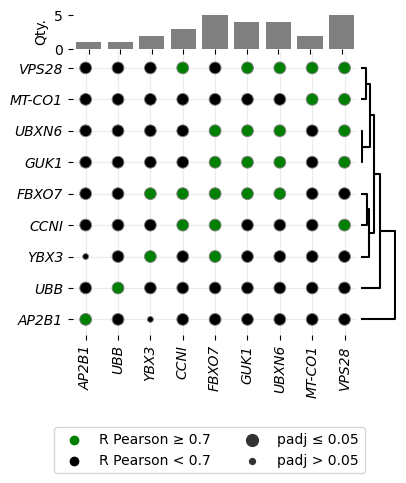

In [113]:
hkg.plot.plot_corr(adata[:,feats_3],r_pearson_lim=0.7, bbox_to_anchor=(1.05, -.3), figsize=(8.35*2/4,8.35*2/4))

In [1651]:
l[1].index('R'),l[1].index('pvalue')

(0, 3)

In [1640]:
l[1].index('R'),l[1].index('pvalue')

(0, 3)

# Validation in Microarray dataset

The microarray dataset were background corrected via affy::rma functiona. But the quantile normalization was made by scikitlearning

*We had to use this [**table**](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL570) to find the probes symbols for genes MT-CO1 and UBNX6. Since we didn't find the microarray data after translate with mygene package.

In [47]:
# feats_3 = ['UBB', 'PIP4K2A', 'PSMF1', 'MYO1G', 'GLRX5', 'ASCC2', 'SF3B2', 'AP2M1', 'FAM210B'] #'DDX39B', 

In [114]:
# R script to get _CEL.tsv
# library(affy)

# dir = 'D:/postransplant_cristian_colab/microarrays/GSE129166_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/postransplant_cristian_colab/predictor/expr_microarray/GSE129166_CEL.tsv')

# dir = 'D:/postransplant_cristian_colab/microarrays/GSE14346_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/postransplant_cristian_colab/predictor/expr_microarray/GSE14346_CEL.tsv')

# dir = 'D:/postransplant_cristian_colab/microarrays/GSE15296_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/postransplant_cristian_colab/predictor/expr_microarray/GSE15296_CEL.tsv')

# dir = 'D:/postransplant_cristian_colab/microarrays/GSE46474_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/postransplant_cristian_colab/predictor/expr_microarray/GSE46474_CEL.tsv')

In [4]:
# geos = ['GSE14346','GSE129166','GSE15296','GSE120397','GSE46474']
# expr = []#dict()
# meta = []#dict()

# # I have to run mygene_translation for GSE46474, it could be a source of error
# for GEO_number in geos:
#     print('/mnt/d/postransplant_cristian_colab/'+GEO_number+'/'+GEO_number+'_expr.tsv')
#     aux = pd.read_csv('/mnt/d/postransplant_cristian_colab/'+GEO_number+'/'+GEO_number+'_mygene_translation.csv', header=None)
#     expr.append(pd.read_csv('/mnt/d/postransplant_cristian_colab/'+GEO_number+'/'+GEO_number+'_expr.tsv', sep='\t', index_col=0))
#     if GEO_number in ['GSE14346','GSE15296']:
#         expr[-1] = np.log(expr[-1])
#     expr[-1] = expr[-1].merge(aux[ aux[2]=='ok' ].set_index(0)[[1]], left_index=True, right_index=True).groupby(1).median()#.sort_values(1)
#     meta.append(pd.read_csv('/mnt/d/postransplant_cristian_colab/'+GEO_number+'/'+GEO_number+'_meta.tsv', sep='\t', index_col=0))

# meta['GSE14346']['acr'] = np.where( meta['GSE14346']['disease state:ch1'].str.contains('AR'), 1, 0 )
# meta['GSE14346']['acr'] = np.where( meta['GSE14346']['disease state:ch1'].str.contains('AR'), 1, 0 )
# cols_pbmc = meta['GSE14346'][meta['GSE14346']['characteristics_ch1']=='Kidney, Peripheral Blood'].index
# meta['GSE14346'] = meta['GSE14346'].loc[cols_pbmc,:]
# expr['GSE14346'] = expr['GSE14346'].loc[:,cols_pbmc]

# meta['GSE129166'] = meta['GSE129166'].T
# meta['GSE129166'] = meta['GSE129166'][ meta['GSE129166']['!Sample_source_name_ch1'].str.contains('Blood') ]
# meta['GSE129166']['tcmr'] = np.where( meta['GSE129166'].iloc[:,-3].str.endswith('1') , 1, 0 )
# meta['GSE129166']['abmr'] = np.where( meta['GSE129166'].iloc[:,-2].str.endswith('1') , 1, 0 )
# meta['GSE129166']['acr'] = np.where( (meta['GSE129166']['tcmr']==1) | (meta['GSE129166']['abmr']==1), 1, 0 )
# meta['GSE129166']['tc_abmr'] = np.where( (meta['GSE129166']['tcmr']==1) & (meta['GSE129166']['abmr']==1), 1, 0 )
# expr['GSE129166'] = expr['GSE129166'][meta['GSE129166'].index]

# meta['GSE15296']['acr'] = np.where( meta['GSE15296']['phenotype:ch1'].str.contains('Rejection'), 1, 0)

# meta['GSE120397']['acr'] = np.where( meta['GSE120397']['acr 3m:ch1']=='Yes', 1, 0)

# meta['GSE46474'] = meta['GSE46474'].T
# meta['GSE46474']['acr'] = np.where( meta['GSE46474']['!Sample_source_name_ch1'].str.contains('AR'), 1, 0)

In [104]:
df_gens = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE15296/GSE15296_mygene_translation.csv', index_col=0, header=None, names=['GeneNames','TranslationStatus'])

In [105]:
df_gens.loc[(df_gens.index.str.contains('1553538_s_at')) | (df_gens.index.str.contains('216545_at')) | (df_gens.index.str.contains('234413_at')),:] #this is MT-CO1 synonymous 1553538

GeneNames TranslationStatus
1553538_s_at       COX1                ok
216545_at     216545_at             empty
234413_at     234413_at             empty

In [106]:
df_gens.loc[(df_gens.index.str.contains('220757_s_at')) | (df_gens.index.str.contains('223012_at')),:] # Synonymous for UBXN6 

GeneNames TranslationStatus
220757_s_at   MIR4746                ok
223012_at     MIR4746                ok

In [107]:
# df_gens.loc[(df_gens.index.str.contains('1553538_s_at')) | (df_gens.index.str.contains('216545_at')) | (df_gens.index.str.contains('234413_at')),'GeneNames'] = 'MT-CO1'
# df_gens.loc[(df_gens.index.str.contains('1553538_s_at')) | (df_gens.index.str.contains('216545_at')) | (df_gens.index.str.contains('234413_at')),'TranslationStatus'] = 'ok'

# df_gens.loc[(df_gens.index.str.contains('220757_s_at')) | (df_gens.index.str.contains('223012_at')),'GeneNames'] = 'UBXN6'
# df_gens.loc[(df_gens.index.str.contains('220757_s_at')) | (df_gens.index.str.contains('223012_at')),'TranslationStatus'] = 'ok'

df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'GeneNames'] = 'MT-CO1'
df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'TranslationStatus'] = 'ok'

df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'GeneNames'] = 'UBXN6'
df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'TranslationStatus'] = 'ok'

In [108]:
df_GSE14346 = pd.read_csv('/mnt/d/postransplant_cristian_colab/predictor/expr_microarray/GSE14346_CEL.tsv', sep='\t', index_col=0) #GSE14346#GSE15296
# df_GSE14346 = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE14346/GSE14346_expr.tsv', sep='\t', index_col=0)
# df_GSE14346 = np.log(df_GSE14346)
df_GSE14346 = df_GSE14346.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T

df_GSE14346.index = df_GSE14346.index.str.replace('.CEL.gz', '', regex=False)
df_GSE14346_meta = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE14346/GSE14346_meta.tsv', sep='\t', index_col=0)[['characteristics_ch1','disease state:ch1']]
df_GSE14346_meta = df_GSE14346_meta[df_GSE14346_meta['characteristics_ch1']=='Kidney, Peripheral Blood']
df_GSE14346_meta['ar'] = np.where(df_GSE14346_meta['disease state:ch1'].str.contains('AR'), 1, 0)
df_GSE14346_meta['gse'] = 'GSE14346'

df_GSE15296 = pd.read_csv('/mnt/d/postransplant_cristian_colab/predictor/expr_microarray/GSE15296_CEL.tsv', sep='\t', index_col=0) #GSE14346#GSE15296
# df_GSE15296 = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE15296/GSE15296_expr.tsv', sep='\t', index_col=0) #GSE14346#GSE15296
# df_GSE15296 = np.log(df_GSE15296)
df_GSE15296 = df_GSE15296.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T
df_GSE15296.index = df_GSE15296.index.str.replace('.CEL.gz', '', regex=False)
df_GSE15296_meta = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE15296/GSE15296_meta.tsv', sep='\t', index_col=0)[['phenotype:ch1']]
df_GSE15296_meta['ar'] = np.where(df_GSE15296_meta['phenotype:ch1'].str.contains('Rejection'), 1, 0)
df_GSE15296_meta['gse'] = 'GSE15296'

df_GSE129166 = pd.read_csv('/mnt/d/postransplant_cristian_colab/predictor/expr_microarray/GSE129166_CEL.tsv', sep='\t', index_col=0)
# df_GSE129166 = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE129166/GSE129166_expr.tsv', sep='\t', index_col=0)
df_GSE129166 = df_GSE129166.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T
df_GSE129166 = df_GSE129166.loc[df_GSE129166.index.str.contains('Blood')]
df_GSE129166.index = df_GSE129166.index.str.split('_').str[0]
df_GSE129166_meta = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE129166/GSE129166_meta.tsv', sep='\t', index_col=0).T#[['phenotype:ch1']]
df_GSE129166_meta = df_GSE129166_meta[ df_GSE129166_meta['!Sample_source_name_ch1'].str.contains('Blood') ]
df_GSE129166_meta['ar'] = np.where( (df_GSE129166_meta.iloc[:,-3].str.endswith('1')) | (df_GSE129166_meta.iloc[:,-2].str.endswith('1')), 1, 0 )
df_GSE129166_meta['gse'] = 'GSE129166'
df_GSE129166 = df_GSE129166.loc[df_GSE129166_meta.index,:]

df_GSE46474 = pd.read_csv('/mnt/d/postransplant_cristian_colab/predictor/expr_microarray/GSE46474_CEL.tsv', sep='\t', index_col=0)
# df_GSE46474 = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE46474/GSE46474_expr.tsv', sep='\t', index_col=0)
df_GSE46474 = df_GSE46474.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T
df_GSE46474.index = df_GSE46474.index.str.split('_').str[0]
df_GSE46474_meta = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE46474/GSE46474_meta.tsv', sep='\t', index_col=0).T
df_GSE46474_meta['ar'] = np.where( df_GSE46474_meta['!Sample_source_name_ch1'].str.contains('AR'), 1, 0)
df_GSE46474_meta['gse'] = 'GSE46474'

In [109]:
meta_cols = ['ar', 'gse']
meta_ma = pd.concat([df_GSE14346_meta[meta_cols], df_GSE15296_meta[meta_cols], df_GSE129166_meta[meta_cols], df_GSE46474_meta[meta_cols]]) 

In [110]:
adata_ma = ad.AnnData(pd.concat([df_GSE14346, df_GSE15296,df_GSE129166,df_GSE46474]).loc[:,
                      [c for c in pd.concat([df_GSE14346, df_GSE15296,df_GSE129166,df_GSE46474]).columns if not c.endswith('_at')]])

# adata_ma = ad.AnnData(pd.concat([df_GSE14346, df_GSE15296,df_GSE129166,df_GSE46474]))

adata_ma = adata_ma[meta_ma.index,:]
adata_ma.obs = meta_ma.loc[adata_ma.obs.index,:]

In [111]:
trns_dict = {gse:'quantile' for gse in adata_ma.obs.gse.unique()}
hkg.pp.transform_exprs(adata_ma, groups_col='gse', trns_dict=trns_dict)

AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    layers: 'trns_expr'

In [112]:
layer = None# 'trns_expr' #
hkg.mining.exprs_cv(adata_ma, layer=layer, groups_col='gse',return_mean_per_group = True, return_cv_per_group= True)
hkg.mining.stability_cv(adata_ma, layer=layer, groups_col='gse', return_stb_cv_per_group=True)
hkg.mining.gene_gini_coeff(adata_ma, layer=layer, groups_col='gse')

CV: computing groups data: 0 1 2 3 
Stability: computing groups data: 0 1 2 3 
Gini: computing groups data: 0 1 2 3 


AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474'
    layers: 'trns_expr'

In [113]:
for c in adata_ma.var.columns:
    adata_ma.var['log_'+c] = np.log(adata_ma.var[c])

In [25]:
# adata_ma.write_h5ad('/mnt/d/housekeeping_genes/adata_MA.h5ad')
adata_ma = ad.read_h5ad('/mnt/d/housekeeping_genes/adata_MA.h5ad')
adata_ma

AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474', 'log_mean_GSE14346', 'log_cv_GSE14346', 'log_mean_GSE15296', 'log_cv_GSE15296', 'log_mean_GSE129166', 'log_cv_GSE129166', 'log_mean_GSE46474', 'log_cv_GSE46474', 'log_pool_mean', 'log_pool_std', 'log_pool_cv', 'log_stb_GSE14346', 'log_stb_GSE15296', 'log_stb_GSE129166', 'log_stb_GSE46474', 'log_pool_stability_cv', 'log_gini_coefficient', 'log_gini_coefficient_GSE14346', 'log_gini_coefficient_GSE15296', 'log_gini_coefficient_GSE129166', 'log_gini_coefficient_GSE46474'
    layers: 'trns_expr'

In [26]:
feats_3_ma = feats_3

## Plot CV, GINI and Stability cv

0 1 2 3 4 5 6 7 8 9 10 11 

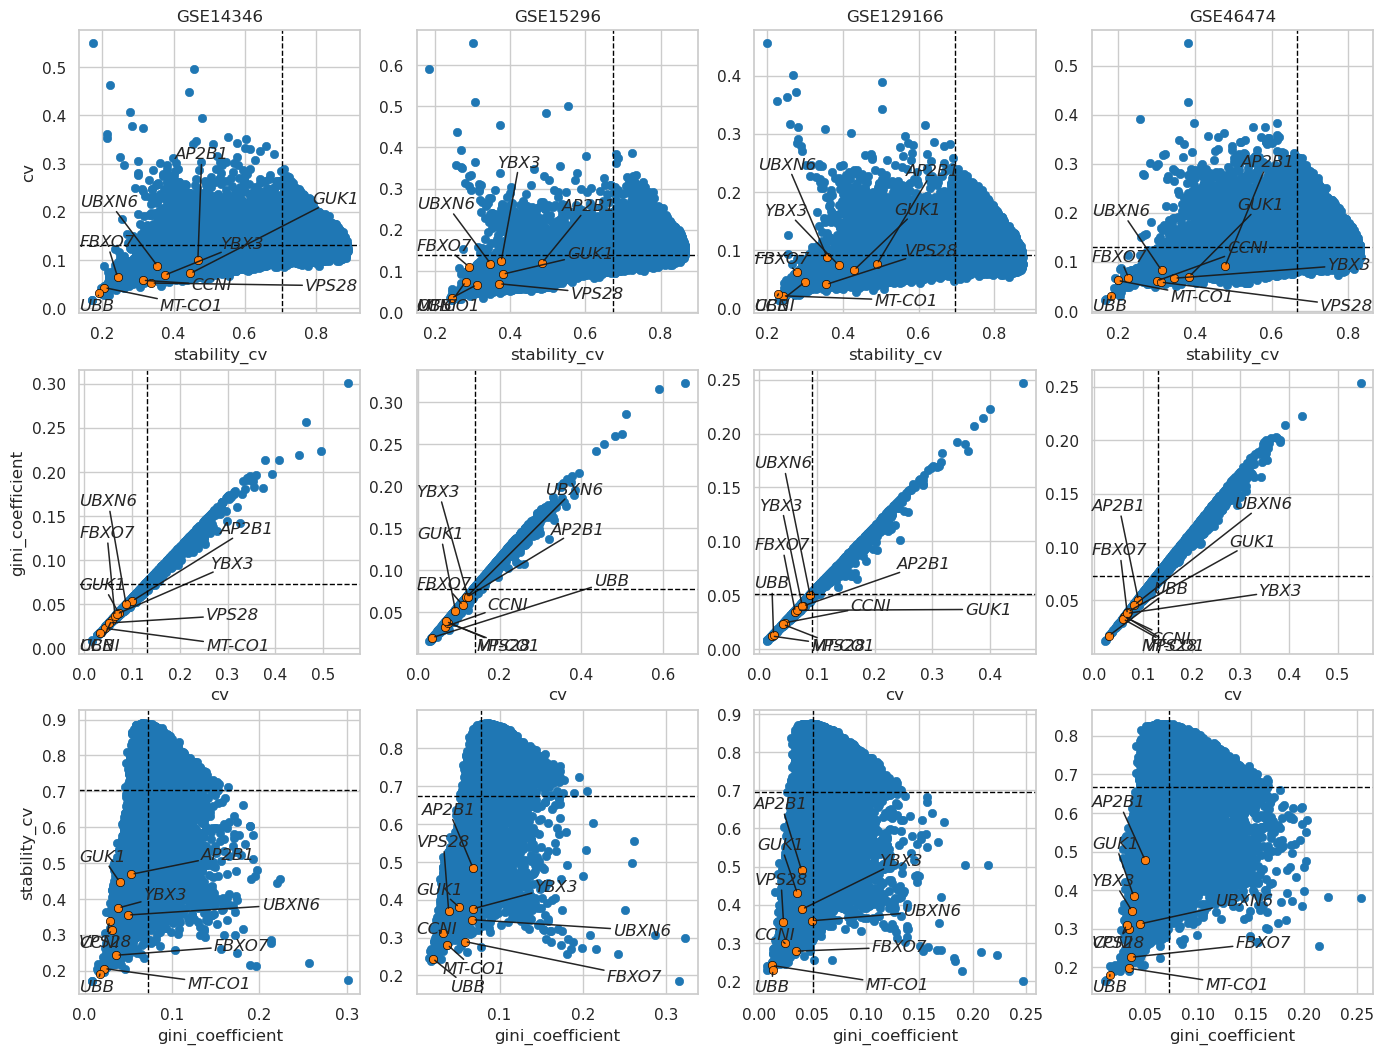

In [41]:
from adjustText import adjust_text

fig = plt.figure(figsize=(8.35*2,8.35*3/2))
x = 'log_pool_stability_cv'
y = 'log_pool_cv'
z = 'log_gini_coefficient'

x = ['stb_']*4 + ['cv_']*4 + ['gini_coefficient_']*4 #['mean_']*12 #
y = ['cv_']*4 + ['gini_coefficient_']*4 + ['stb_']*4
# x = ['log_stb_']*4 + ['log_cv_']*4 + ['log_gini_coefficient_']*4
# y = ['log_cv_']*4 + ['log_gini_coefficient_']*4 + ['log_stb_']*4

nrow = 3
ncols = len(adata_ma.obs.gse.unique())

# xlim_list = []
# ylim_list = []

for i,gse in enumerate(adata_ma.obs.gse.unique().tolist()*nrow):
    ax = fig.add_subplot(nrow, ncols, i+1)
    aux = adata_ma.var
    sns.scatterplot(y=y[i]+gse, x=x[i]+gse, edgecolor=None, color='#1f77b4', data=aux.loc[[c for c in aux.index if c not in feats_3_ma ]])
    sns.scatterplot(y=y[i]+gse,x=x[i]+gse, edgecolor='black', color='#ff7f0e', data=aux.loc[feats_3_ma,:])
    ax.axhline(aux[y[i]+gse].median(), color='black', ls='--', lw=1)
    ax.axvline(aux[x[i]+gse].median(), color='black', ls='--', lw=1)
    if i in range(4):
        ax.set_title(gse)
    else:
        ax.set_title('')
    if i not in [0,4,8]:
        ax.set_ylabel('')
    else:
        ax.set_ylabel(y[i][:-1].replace('stb','stability_cv'))
    
    ax.set_xlabel(x[i][:-1].replace('stb','stability_cv'))
    
    texts = []
    for l,x_,y_ in aux.loc[feats_3_ma,[x[i]+gse, y[i]+gse]].reset_index().values:
        texts.append(ax.text(x_, y_, l,  va='center',ha='center', fontsize=12, style='italic'))
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95),
                expand=(2.5, 2.5),
               )

    # ax.set_xlim(xlim_list[i])
    # ax.set_ylim(ylim_list[i])
    # xlim_list.append(ax.get_xlim())
    # ylim_list.append(ax.get_ylim())

    # # ax.get_legend().remove()
    # ax.grid(False)
    # ax.spines[['left','right', 'top','bottom']].set_visible(False)
    # ax.set_yticklabels([])
    # ax.set_xticklabels([])
    # ax.set_xlabel('')
    # ax.set_ylabel('')
    # ax.set_title('')
    


    print(i, end=' ')
# fig.tight_layout()
# fig.savefig('/mnt/d/housekeeping_genes/draft/MA_VALIDATION_HKG_v2.pdf', format='pdf', dpi=300)
# fig.savefig('/mnt/d/housekeeping_genes/draft/MA_VALIDATION_v2.jpeg', format='jpeg', dpi=300)

## Entropy of cluster based on feats_3

In [135]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [123]:
adata_ma[adata_ma.obs.gse=='GSE129166', feats_3]#.to_df('trns_expr')

View of AnnData object with n_obs × n_vars = 117 × 9
    obs: 'ar', 'gse'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474', 'log_mean_GSE14346', 'log_cv_GSE14346', 'log_mean_GSE15296', 'log_cv_GSE15296', 'log_mean_GSE129166', 'log_cv_GSE129166', 'log_mean_GSE46474', 'log_cv_GSE46474', 'log_pool_mean', 'log_pool_std', 'log_pool_cv', 'log_stb_GSE14346', 'log_stb_GSE15296', 'log_stb_GSE129166', 'log_stb_GSE46474', 'log_pool_stability_cv', 'log_gini_coefficient', 'log_gini_coefficient_GSE14346', 'log_gini_coefficient_GSE15296', 'log_gini_coefficient_GSE129166', 'log_gini_coefficient_GSE46474'
    layers: 'trns_expr'

In [133]:
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import entropy

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f

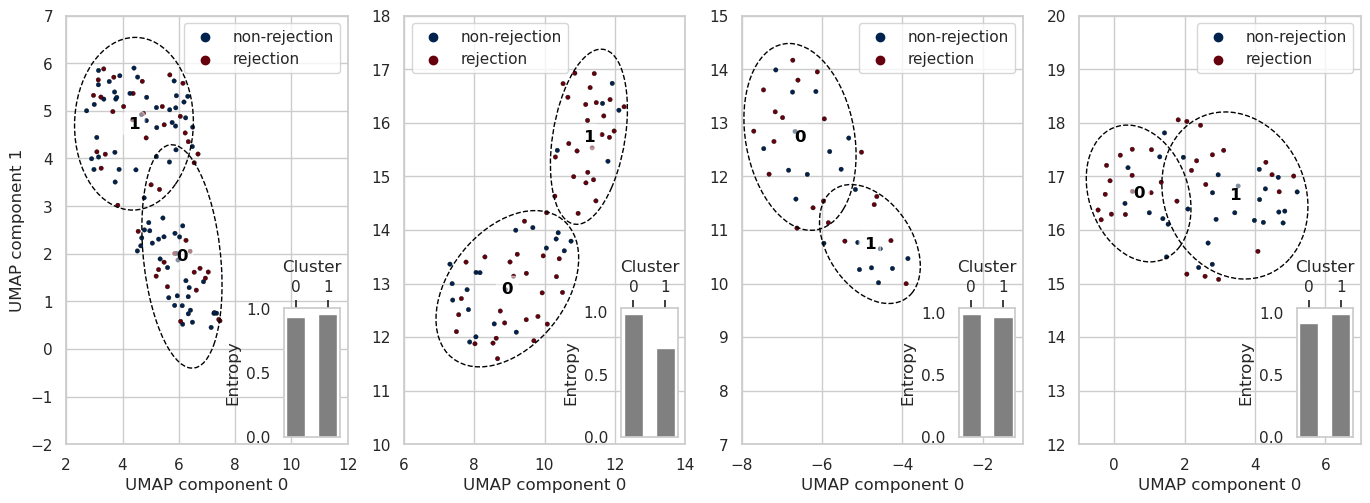

In [155]:
fig = plt.figure(figsize=(8.35*2,8.35*2/3))

xlim_list = [[2,12],[6,14],[-8,-1],[-1,7]]
ylim_list = [[-2,7],[10,18],[7,15],[12,20]]

colors = ['#00224e', '#67000d']
# colors = ['#fff5f0', '#67000d'] #e5dcd8

# palette=['#fff5f0', '#fca082', '#e32f27', '#67000d']
for i,g in enumerate(['GSE129166','GSE15296','GSE46474','GSE14346']):
    if i == 0:
        ax_pca = fig.add_subplot(1,4,1+i)
    else:
        ax_pca = fig.add_subplot(1,4,1+i)#, sharey=ax_pca, sharex=ax_pca)
    
    pca = umap.UMAP(n_neighbors=30, random_state=42)# PCA(n_components=2)#
    # pca = TSNE(n_components=3) 
    # df_pca = StandardScaler().fit_transform(expr[g].loc[stable_genes,:].T.values)
    df_pca = StandardScaler().fit_transform(adata_ma[adata_ma.obs.gse==g, feats_3].to_df('trns_expr').values)
    # df_pca = expr[g].loc[stable_genes,:].T.values
    # neigh = NearestNeighbors(n_neighbors=5, radius=1)
    # neigh.fit(df_pca)#expr[g].loc[stable_genes,:].T.values)
    # louvain = Louvain(resolution=.25, modularity='Dugue', random_state=42)#'Potts' 'Newman'n_aggregations=3,
    # labels = louvain.fit_predict(neigh.kneighbors_graph())

    ##
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(df_pca)
    labels = kmeans.labels_
    ##
    

    df_pca = pd.DataFrame(pca.fit_transform(df_pca))
    df_pca.index = adata_ma[adata_ma.obs.gse==g, feats_3].obs.index
    df_pca['acr'] = adata_ma[adata_ma.obs.gse==g, feats_3].obs.ar# df_pca.index.map(dict(meta[g].acr))
    df_pca['clusters'] = labels
    x=0
    y=1
    hue='acr'
    hue_order = [0,1]
    sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, palette=colors,edgecolor='black', s=10, data=df_pca)#style=labels, 
    # ax_pca.set_title(g+'\n', weight='bold')
    # ax_pca.set_xlabel(str(round(var[0]*100, 2))+'%' )
    # ax_pca.set_ylabel(str(round(var[1]*100, 2))+'%' )
    # ax_pca.set_title(g+' UMAP Louvain clustering\n', weight='bold')
    ax_pca.set_ylim(ylim_list[i])
    ax_pca.set_xlim(xlim_list[i])
    # ax_pca.spines[['right', 'top']].set_visible(False)
    handles, labels = ax_pca.get_legend_handles_labels()
    labels = ['non-rejection', 'rejection']
    ax_pca.legend(handles=handles, labels=labels, ncol=1)#, fontsize=12)

    if i != 0:
        ax_pca.set_ylabel('')
    else:
        ax_pca.set_ylabel('UMAP component 1')

    ax_pca.set_xlabel('UMAP component 0')

    entropy_list = []
    cl_list = []
    texts= []
    
    for cl in np.sort(df_pca.clusters.unique()):
        confidence_ellipse(df_pca[df_pca.clusters==cl][0].values,
                       df_pca[df_pca.clusters==cl][1].values, ax_pca, edgecolor='black', ls='--', n_std=2)

        x, y = (df_pca[df_pca.clusters==cl][[0,1]].sum()/df_pca[df_pca.clusters==cl][[0,1]].shape[0]).values[:2]
        ax_pca.text(x, y, cl,  color='black',  weight='bold', va='center',ha='center',bbox=dict(boxstyle='round', facecolor='white', edgecolor=None, alpha=0.5))#

        entrp = np.round(entropy(np.unique(df_pca[df_pca.clusters==cl].acr.values, return_counts=True)[1]/np.unique(df_pca[df_pca.clusters==cl].acr.values,
                                                                                                                  return_counts=True)[1].sum(), base=2),2)
        entropy_list.append(entrp)
        cl_list.append(str(cl))

        # texts.append(ax_pca.text(x, y, str(cl)+' entropy: ('+str(entrp)+')', fontsize=12))

    # adjust_text(texts, ax=ax_pca, arrowprops=dict(arrowstyle="-", color='k', lw=1.1),
    #                     expand=(2, 3), 
                # expand_points=(1.2, 1.2),
                        # precision=0.0001, lim=5000
                       # )
  
        # 
    
    width_bar=.6
    align = 'center'
    width="20%"
    height="30%"
    
    ax_com = inset_axes(ax_pca, width=width, height=height, loc=4)  
    # if g == 'GSE46474':
    #     ax_com.set_xlim([-.75,.75])
        
    ax_com.bar(x=cl_list, height=entropy_list,color='gray', width=width_bar, align=align)
    ax_com.set_ylabel('Entropy')#, fontsize=20)    
    ax_com.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)#,s=18)
    ax_com.set_title('Cluster')#, fontsize=20)
    ax_com.set_yticks([0.0,.5,1.0],[0.0,.5,1.0])#, fontsize=18)
    ax_com.set_yticklabels([0.0,.5,1.0])#, fontsize=18)
    # ax_com.set_xticklabels(ax_com.get_xticks(), fontsize=18)
    ax_com.grid(False)
        
    
    # var = pca.explained_variance_ratio_
    # x = np.where(var.cumsum() >= 0.8)
    # y = var.cumsum()[var.cumsum() >= 0.8]
    # print(x,y)
    # ax_com.plot(var.cumsum(), marker='o', ls='--', lw=.5, ms=3, color='gray')
    # ax_com.plot(x[0][0],y[0], marker='X', color='black')
    # # ax_com.spines[['right', 'top']].set_visible(False)
    # ax_com.set_title('Cumulative Variance', size=8)
    # ax_com.tick_params(labelleft=False, labelbottom=False)
    # texts = []
    # texts.append(ax_com.text(x[0][0]+2, y[0]-.1, '('+str(np.round(x[0][0]+1,2))+', '+str(np.round(100*y[0],1))+')', fontsize=8))
# fig.savefig('/mnt/d/housekeeping_genes/microarray_entropy.pdf', format='pdf', dpi=300)

In [ ]:
# def plot_scatter_stb_cv_gini(adata, x:str = 'pool_cv', y:str = 'pool_stability_cv', z:str='pool_mean', columns:str=, palette:str = None, legend:bool = False, figsize:tuple = (8.35*2,8.35), median_line:bool = True):
#     fig = plt.figure(figsize=figsize)

#     ax_xy = fig.add_figure()

In [ ]:
fig = plt.figure(figsize=(8.35,8.35))

for i,g in enumerate(geos):
    data = pd.DataFrame()
    data['Mean'] = mean_[i]
    data['CV'] = cv_[i]

    if i == 3: #if GSE14346 I deleted these genes because they were super high CV. It was hard to see diference in other genes
        data['CV'] = data['CV'][data['CV']<0.65]
        data['Mean'] = data['Mean'][data['Mean'].index.isin(data['CV'].index)]
    
    if i == 0:
        ax = fig.add_subplot(1,4,i+1)
        ax.set_ylabel('CV of expression')
    else:
        ax = fig.add_subplot(1,4,i+1, sharey=ax)        
    ax.set_xlabel('Mean os expression counts')
        # if i == 3:
        #     ax = fig.add_subplot(1,4,i+1, sharex=ax)#, sharey=ax)
        # else:
        #     ax = fig.add_subplot(1,4,i+1, sharex=ax, sharey=ax)
    sns.scatterplot(x='Mean', y='CV', edgecolor=None, s=60, data=data.drop(stable_genes), ax=ax)
    sns.scatterplot(x='Mean', y='CV', edgecolor='black', s=60, data=data.loc[stable_genes,:], ax=ax)
    ax.set_title(g+'\n', weight='bold')
    if i > 0:
        ax.set_ylabel('')
    texts = []
    for l,x,y in data.loc[stable_genes,:].reset_index().values:
        texts.append(ax.text(x, y, l, ha='center', va='center'))#  fontsize=18, weight='bold',
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95),
                expand=(1.5, 1.9),
                # expand_points=(1.5,1.5),
                # precision=0.0001, lim=5000
               )
# fig.savefig('/mnt/d/housekeeping_genes/microarray_cv_mean.pdf', format='pdf', dpi=300)

In [91]:
# aux = pd.DataFrame([pair, P_list,pv_list], index=['gene_pair','R','pvalue']).T
# aux
# aux[['Gene_name_x', 'Gene_name_y']] = aux.gene_pair.str.split(',', expand=True)
# aux_2 = aux.copy()
# aux_2.columns = ['gene_pair', 'R', 'pvalue', 'Gene_name_y', 'Gene_name_x']
# aux = pd.concat([aux, aux_2])
# aux_R = aux.drop_duplicates().pivot(columns='Gene_name_x', index='Gene_name_y', values='R')
# aux_R

In [86]:
Z=sch.linkage(aux_R.astype(float), method='ward')
# order = sch.leaves_list(Z)
# scale_ = MinMaxScaler(feature_range=(5, 975)).fit_transform( np.array(list(range( len(aux_R.columns) ))).reshape(-1,1) ).flatten()
# n_gene_dict = dict(zip(aux_R.columns[order], scale_))
# n_gene_dict

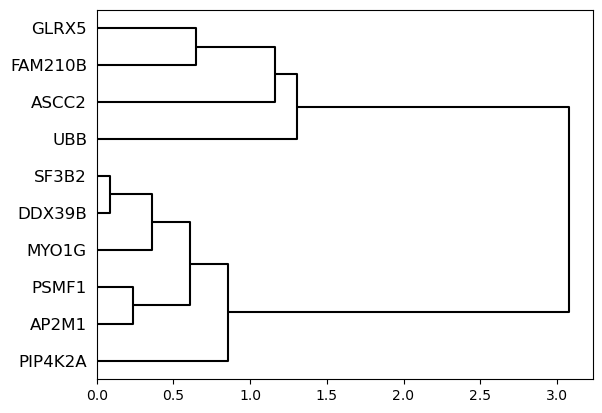

In [145]:
dn = sch.dendrogram(Z, orientation='right', no_labels=False, color_threshold=0, above_threshold_color='black', labels=aux_R.columns)#,  ax=ax_y_dn)

In [146]:
dn['leaves']

[6, 0, 7, 5, 2, 8, 9, 1, 3, 4]

In [147]:
aux_R.columns

Index(['AP2M1', 'ASCC2', 'DDX39B', 'FAM210B', 'GLRX5', 'MYO1G', 'PIP4K2A',
       'PSMF1', 'SF3B2', 'UBB'],
      dtype='object', name='Gene_name_x')

In [105]:
from scipy.spatial import distance

In [118]:
np.isnan(distance.pdist(adata[:,feats_3].to_df().values, metric='cosine')).astype(int).sum()

634

In [112]:
np.isnan(distance.pdist(adata[:,feats_3].to_df().values, metric='cosine')).sum()

634

In [97]:
sch.linkage(adata[:,feats_3].to_df().values, method='average', metric='cosine')

ValueError: The condensed distance matrix must contain only finite values.

In [167]:
pd.DataFrame([pair, P_list,pv_list], index=['gene_pair','R','pvalue']).T

gene_pair         R    pvalue
0           UBB,UBB       1.0       0.0
1       UBB,PIP4K2A  0.182822  0.000004
2         UBB,PSMF1  0.217523       0.0
3         UBB,MYO1G  0.094147  0.018309
4         UBB,GLRX5  0.650223       0.0
5        UBB,DDX39B  0.021013  0.608187
6         UBB,ASCC2   0.27909       0.0
7         UBB,SF3B2 -0.001241  0.975106
8         UBB,AP2M1  0.174611   0.00001
9       UBB,FAM210B  0.403192       0.0
10  PIP4K2A,PIP4K2A       1.0       0.0
11    PIP4K2A,PSMF1  0.727144       0.0
12    PIP4K2A,MYO1G  0.563653       0.0
13    PIP4K2A,GLRX5  0.513584       0.0
14   PIP4K2A,DDX39B  0.708189       0.0
15    PIP4K2A,ASCC2  0.416973       0.0
16    PIP4K2A,SF3B2  0.713112       0.0
17    PIP4K2A,AP2M1  0.694937       0.0
18  PIP4K2A,FAM210B  0.625678       0.0
19      PSMF1,PSMF1       1.0       0.0
20      PSMF1,MYO1G  0.803349       0.0
21      PSMF1,GLRX5  0.595805       0.0
22     PSMF1,DDX39B  0.849194       0.0
23      PSMF1,ASCC2  0.334282       0.0
24      PSMF1,SF3B2  0.864484       0.0
25      PSMF1,AP2M1  0.946341       0.0
26    PSMF1,FAM210B  0.702319       0.0
27      MYO1G,MYO1G       1.0       0.0
28      MYO1G,GLRX5   0.35592       0.0
29     MYO1G,DDX39B  0.895391       0.0
30      MYO1G,ASCC2  0.158955  0.000061
31      MYO1G,SF3B2  0.873605       0.0
32      MYO1G,AP2M1  0.918535       0.0
33    MYO1G,FAM210B  0.347228       0.0
34      GLRX5,GLRX5       1.0       0.0
35     GLRX5,DDX39B  0.357165       0.0
36      GLRX5,ASCC2  0.281732       0.0
37      GLRX5,SF3B2  0.311202       0.0
38      GLRX5,AP2M1  0.513086       0.0
39    GLRX5,FAM210B  0.681011       0.0
40    DDX39B,DDX39B       1.0       0.0
41     DDX39B,ASCC2  0.297815       0.0
42     DDX39B,SF3B2   0.95741       0.0
43     DDX39B,AP2M1  0.922835       0.0
44   DDX39B,FAM210B  0.462833       0.0
45      ASCC2,ASCC2       1.0       0.0
46      ASCC2,SF3B2  0.298498       0.0
47      ASCC2,AP2M1  0.268256       0.0
48    ASCC2,FAM210B  0.584044       0.0
49      SF3B2,SF3B2       1.0       0.0
50      SF3B2,AP2M1  0.923135       0.0
51    SF3B2,FAM210B  0.461139       0.0
52      AP2M1,AP2M1       1.0       0.0
53    AP2M1,FAM210B  0.578647       0.0
54  FAM210B,FAM210B       1.0       0.0

In [264]:
del(aux_R)

In [267]:
def plot_corr(adata, layer:str = None, r_pearson_lim:float = 0.5, p_value_lim:float = 0.05, correct_fdr:bool = True, figsize:tuple = (8.35*2/3, 8.35*2/3), bbox_to_anchor:tuple=(.75, -.15)):
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[1,8], wspace=.02, hspace=.02)
    ax = fig.add_subplot(gs[1,0])
    ax_y_bar = fig.add_subplot(gs[0,0])
    ax_y_dn = fig.add_subplot(gs[1,1])

    if layer != None:
        aux = adata.to_df(layer)
    else:
        aux = adata.to_df()
    original_order = aux.columns

    # Claculate the linkage by correlation between genes
    Z = sch.linkage(aux.T.astype(float).values, metric='correlation', method='average')

    # Calculate Pearson corralations and p-values
    cols_ = list(itertools.combinations_with_replacement(original_order,2, ))
    P_list = []
    pv_list = []
    pair = []
    for col in cols_:
        pair.append(','.join(col))
        aux_pearsonr = pearsonr(aux[col[0]], aux[col[1]])
        P_list.append(aux_pearsonr.statistic)
        pv_list.append(aux_pearsonr.pvalue)

    if correct_fdr:
        pv_list = false_discovery_control(pv_list)

    aux = pd.DataFrame([pair, P_list,pv_list], index=['gene_pair','R','pvalue']).T
    aux[['Gene_name_x', 'Gene_name_y']] = aux.gene_pair.str.split(',', expand=True)
    aux_2 = aux.copy()
    aux_2.columns = ['gene_pair', 'R', 'pvalue', 'Gene_name_y', 'Gene_name_x']#
    aux = pd.concat([aux, aux_2])

    # Dendrogram
    dn = sch.dendrogram(Z, orientation='right', no_labels=True, color_threshold=0, above_threshold_color='black',  ax=ax_y_dn)
    ax_y_dn.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
    ax_y_dn.grid(False)
    ax_y_dn.set_xticks([], [])

    order = dn['leaves']
    original_ticks = np.array(dn['icoord'])[np.where(np.array(dn['dcoord'])==0)]
    ticks_ = np.sort(original_ticks)
    n_gene_dict = dict( zip(original_order[order], ticks_) )

    r_gt = 'R Pearson ≥ '+ str(r_pearson_lim)
    r_lt = 'R Pearson < '+ str(r_pearson_lim)
    p_gt = 'padj > '+ str(p_value_lim)
    p_lt = 'padj ≤ '+ str(p_value_lim)

    aux['Gene_name_x'] = aux.Gene_name_x.map(n_gene_dict)
    aux['Gene_name_y'] = aux.Gene_name_y.map(n_gene_dict)
    aux['R'] = np.where((aux.R.abs().values>=r_pearson_lim), r_gt, r_lt)
    aux['pvalue'] = np.where((aux.pvalue.abs().values<=p_value_lim), p_lt, p_gt)
    aux = aux.drop_duplicates()
    aux_pvalue = aux.pivot(columns='Gene_name_x', index='Gene_name_y', values='pvalue')

    # scatterplot
    sns.scatterplot(x='Gene_name_x', y='Gene_name_y', hue='R', marker='o', size='pvalue', palette=['green', 'black'], edgecolor='grey', data=aux, ax=ax)
    ax.set_xticks(ticks_, original_order[order], rotation=90, style='italic')
    ax.set_yticks(ticks_, original_order[order], style='italic')
    ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(ax_y_dn.get_ylim())
    ax.grid(True, alpha=.25)
    ax.set_axisbelow(True)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=np.array(handles)[[1,2,4,5]].tolist(), labels=np.array(labels)[[1,2,4,5]].tolist(), bbox_to_anchor=bbox_to_anchor, ncol=2)

    # barplot
    data = aux[aux.R==r_gt].groupby('Gene_name_x').count().loc[original_ticks,:].reset_index()
    sns.barplot(x='Gene_name_x', y='gene_pair', color='grey',data=data,ax=ax_y_bar)
    ax_y_bar.set_xlabel('Qty.')
    ax_y_bar.set_ylabel('')
    ax_y_bar.set_yticks((0,data.gene_pair.max()))
    ax_y_bar.set_xticklabels([])
    ax_y_bar.set_xlabel(None)
    ax_y_bar.spines[['left','right', 'top', 'bottom']].set_visible(False)
    ax_y_bar.set_ylabel('Qty.')

    return None

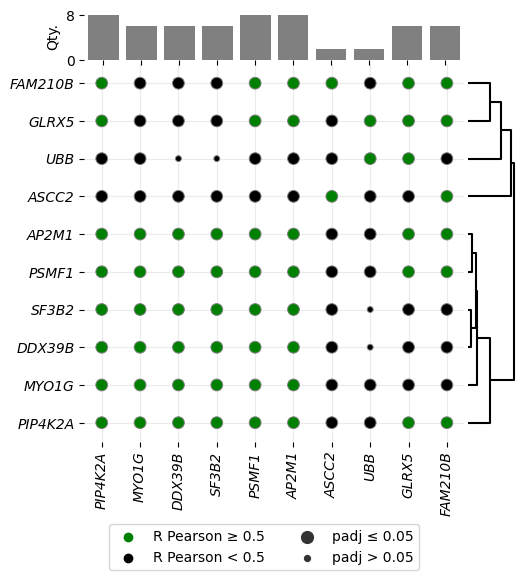

In [278]:
plot_corr(adata[:,feats_3], bbox_to_anchor=(.9, -.2))

In [284]:
# aux_R#.iloc[order,order]

Text(0, 0.5, 'Qty.')

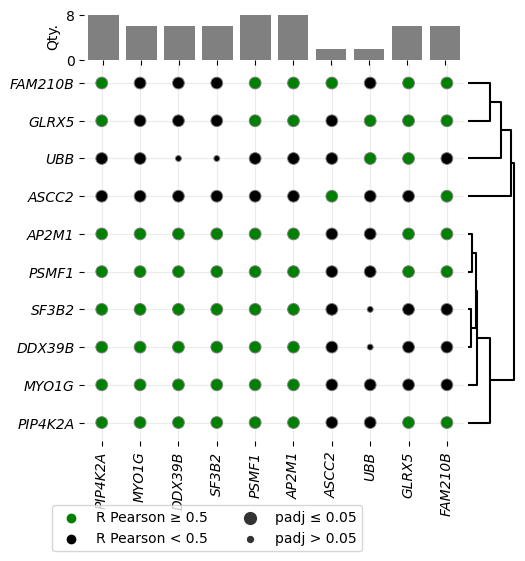

In [280]:
fig = plt.figure(figsize=(8.35*2/3,8.35*2/3))
gs = GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[1,8], wspace=.02, hspace=.02)
ax = fig.add_subplot(gs[1,0])#(111)#
ax_y_bar = fig.add_subplot(gs[0,0])#, sharex=ax)
ax_y_dn = fig.add_subplot(gs[1,1])#, sharey=ax)

aux = adata[:,feats_3].to_df()
original_order = aux.columns
Z = sch.linkage(aux.T.astype(float).values, metric='correlation', method='average')
# dn = sch.dendrogram(Z)#, orientation='right', no_labels=True, color_threshold=0, above_threshold_color='black', labels=aux.columns,  ax=ax_y_dn)

cols_ = list(itertools.combinations_with_replacement(original_order,2, ))
P_list = []
pv_list = []
pair = []
for col in cols_:
    pair.append(','.join(col))
    aux_pearsonr = pearsonr(aux[col[0]], aux[col[1]])
    P_list.append(aux_pearsonr.statistic)
    pv_list.append(aux_pearsonr.pvalue)
    # P_list.append(pearsonr(aux[col[0]], aux[col[1]]).statistic)
    # pv_list.append(pearsonr(aux[col[0]], aux[col[1]]).pvalue)
pv_list = false_discovery_control(pv_list)
aux = pd.DataFrame([pair, P_list,pv_list], index=['gene_pair','R','pvalue']).T
aux[['Gene_name_x', 'Gene_name_y']] = aux.gene_pair.str.split(',', expand=True)
aux_2 = aux.copy()
aux_2.columns = ['gene_pair', 'R', 'pvalue', 'Gene_name_y', 'Gene_name_x']#
aux = pd.concat([aux, aux_2])
aux_R = aux.drop_duplicates().pivot(columns='Gene_name_x', index='Gene_name_y', values='R')

# Dendrogram
# Z = sch.linkage(aux_R.astype(float), method='ward')
dn = sch.dendrogram(Z, orientation='right', no_labels=True, color_threshold=0, above_threshold_color='black',  ax=ax_y_dn)
ax_y_dn.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
ax_y_dn.grid(False)
ax_y_dn.set_xticks([], [])

order = dn['leaves']
original_ticks = np.array(dn['icoord'])[np.where(np.array(dn['dcoord'])==0)]
ticks_ = np.sort(original_ticks)
n_gene_dict = dict( zip(original_order[order], ticks_) )
# n_gene_dict
# print(dn['leaves'])
# print(aux_R.columns)
# print(aux_R.columns[order])

# scale_ = MinMaxScaler(feature_range=(5, 975)).fit_transform( np.array(list(range( len(aux_R.columns) ))).reshape(-1,1) ).flatten()
# n_gene_dict = dict(zip(aux_R.columns[order], scale_))
# # n_gene_dict = dict(zip(aux_R.columns[order],range(len(aux_R.columns))))

# # # order = (aux_R.abs()>=0.5).sum().sort_values(ascending=False).index
# # # n_gene_dict = dict(zip(order,range(len(order))))
aux['Gene_name_x'] = aux.Gene_name_x.map(n_gene_dict)
aux['Gene_name_y'] = aux.Gene_name_y.map(n_gene_dict)
aux['R'] = np.where((aux.R.abs().values>=.5), 'R Pearson ≥ 0.5', 'R Pearson < 0.5')
aux['pvalue'] = np.where((aux.pvalue.abs().values<=.05), 'padj ≤ 0.05', 'padj > 0.05')
aux = aux.drop_duplicates()
aux_pvalue = aux.pivot(columns='Gene_name_x', index='Gene_name_y', values='pvalue')

# scatterplot
# ticks_ = np.sort(ticks_)
sns.scatterplot(x='Gene_name_x', y='Gene_name_y', hue='R', marker='o', size='pvalue', palette=['green', 'black'], edgecolor='grey', data=aux, ax=ax)
ax.set_xticks(ticks_, original_order[order], rotation=90, style='italic')
ax.set_yticks(ticks_, original_order[order], style='italic')
ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(ax_y_dn.get_ylim())
ax.grid(True, alpha=.25)
ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=np.array(handles)[[1,2,4,5]].tolist(), labels=np.array(labels)[[1,2,4,5]].tolist(), bbox_to_anchor=(.75, -.15), ncol=2)

# barplot
data = aux[aux.R=='R Pearson ≥ 0.5'].groupby('Gene_name_x').count().loc[original_ticks,:].reset_index()
sns.barplot(x='Gene_name_x', y='gene_pair', color='grey',data=data,ax=ax_y_bar)
ax_y_bar.set_xlabel('Qty.')
ax_y_bar.set_ylabel('')
# ax_y_bar.set_xlim((-1.5,34.5))
ax_y_bar.set_yticks((0,data.gene_pair.max()))
# ax_y_bar.axhline(data.gene_pair.max(), ls='--')


# ax_y_dn.tick_params(axis='both', which='both', left=False)
ax_y_bar.set_xticklabels([])
ax_y_bar.set_xlabel(None)
ax_y_bar.spines[['left','right', 'top', 'bottom']].set_visible(False)
ax_y_bar.set_ylabel('Qty.')#, fontsize=9)

In [259]:
aux[(aux.R=='R Pearson ≥ 0.5')].groupby('Gene_name_x').count().loc[original_ticks,:].reset_index()

Gene_name_x  gene_pair  R  pvalue  Gene_name_y
0         25.0          6  6       6            6
1         35.0          6  6       6            6
2         45.0          8  8       8            8
3         55.0          8  8       8            8
4         15.0          6  6       6            6
5          5.0          8  8       8            8
6         85.0          6  6       6            6
7         95.0          6  6       6            6
8         75.0          2  2       2            2
9         65.0          2  2       2            2

In [229]:
dn['leaves']

[1, 3, 5, 7, 2, 8, 6, 0, 4, 9]

In [256]:
ticks_

array([ 5., 15., 25., 35., 45., 55., 65., 75., 85., 95.])

In [236]:
original_order[dn['leaves']]

Index(['PIP4K2A', 'MYO1G', 'DDX39B', 'SF3B2', 'PSMF1', 'AP2M1', 'ASCC2', 'UBB',
       'GLRX5', 'FAM210B'],
      dtype='object', name='Gene_name')

In [237]:
n_gene_dict

{'PIP4K2A': 5.0,
 'MYO1G': 15.0,
 'DDX39B': 25.0,
 'SF3B2': 35.0,
 'PSMF1': 45.0,
 'AP2M1': 55.0,
 'ASCC2': 65.0,
 'UBB': 75.0,
 'GLRX5': 85.0,
 'FAM210B': 95.0}

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [30.0, 30.0, 50.0, 50.0],
  [15.0, 15.0, 40.0, 40.0],
  [5.0, 5.0, 27.5, 27.5],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [65.0, 65.0, 82.5, 82.5],
  [16.25, 16.25, 73.75, 73.75]],
 'dcoord': [[0.0, 0.04258974852067654, 0.04258974852067654, 0.0],
  [0.0, 0.05365939438301426, 0.05365939438301426, 0.0],
  [0.04258974852067654,
   0.11008796406026874,
   0.11008796406026874,
   0.05365939438301426],
  [0.0, 0.12727988410090404, 0.12727988410090404, 0.11008796406026874],
  [0.0, 0.3185929389798102, 0.3185929389798102, 0.12727988410090404],
  [0.0, 0.3189887307570125, 0.3189887307570125, 0.0],
  [0.0, 0.47329277275547066, 0.47329277275547066, 0.3189887307570125],
  [0.0, 0.6183777054901641, 0.6183777054901641, 0.47329277275547066],
  [0.3185929389798102,
   0.6546558944926468,
   0.6546558944926468,
   0.6183777054901641]],
 'ivl': ['PIP4K2A',
  'MYO1G',
  'DDX39B',
  'SF3B2',
  'PSMF1',
  'AP2M1',
  'ASCC2'

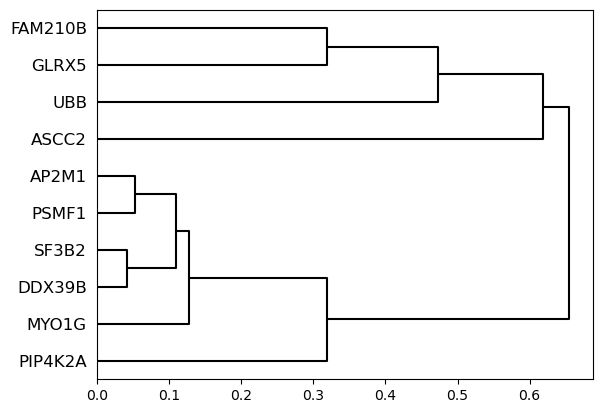

In [235]:
sch.dendrogram(Z, orientation='right', no_labels=False, color_threshold=0, above_threshold_color='black', labels=original_order)

In [222]:
order

[1, 3, 5, 7, 2, 8, 6, 0, 4, 9]

<Axes: xlabel='Gene_name_x', ylabel='Gene_name_y'>

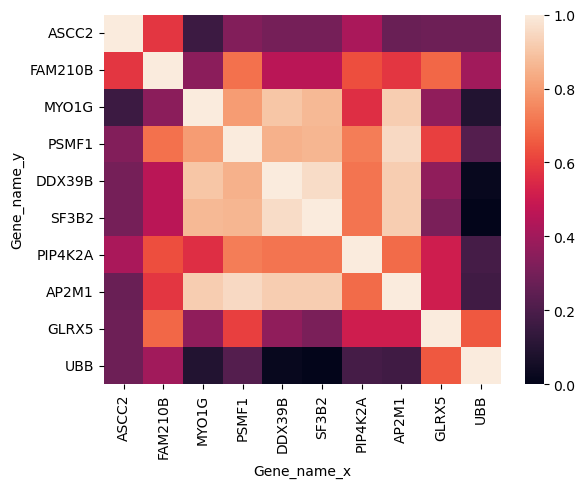

In [197]:
sns.heatmap(data=aux_R.iloc[order,order].astype(float).round(2))

In [204]:
aux_R.iloc[order,order].astype(float).round(2)

Gene_name_x  ASCC2  FAM210B  MYO1G  PSMF1  DDX39B  SF3B2  PIP4K2A  AP2M1  \
Gene_name_y                                                                
ASCC2         1.00     0.58   0.16   0.33    0.30   0.30     0.42   0.27   
FAM210B       0.58     1.00   0.35   0.70    0.46   0.46     0.63   0.58   
MYO1G         0.16     0.35   1.00   0.80    0.90   0.87     0.56   0.92   
PSMF1         0.33     0.70   0.80   1.00    0.85   0.86     0.73   0.95   
DDX39B        0.30     0.46   0.90   0.85    1.00   0.96     0.71   0.92   
SF3B2         0.30     0.46   0.87   0.86    0.96   1.00     0.71   0.92   
PIP4K2A       0.42     0.63   0.56   0.73    0.71   0.71     1.00   0.69   
AP2M1         0.27     0.58   0.92   0.95    0.92   0.92     0.69   1.00   
GLRX5         0.28     0.68   0.36   0.60    0.36   0.31     0.51   0.51   
UBB           0.28     0.40   0.09   0.22    0.02  -0.00     0.18   0.17   

Gene_name_x  GLRX5   UBB  
Gene_name_y               
ASCC2         0.28  0.28  
FAM210B       0.68  0.40  
MYO1G         0.36  0.09  
PSMF1         0.60  0.22  
DDX39B        0.36  0.02  
SF3B2         0.31 -0.00  
PIP4K2A       0.51  0.18  
AP2M1         0.51  0.17  
GLRX5         1.00  0.65  
UBB           0.65  1.00

In [199]:
aux = pd.DataFrame([pair, P_list,pv_list], index=['gene_pair','R','pvalue']).T
aux[['Gene_name_x', 'Gene_name_y']] = aux.gene_pair.str.split(',', expand=True)
aux_2 = aux.copy()
aux_2.columns = ['gene_pair', 'R', 'pvalue', 'Gene_name_y', 'Gene_name_x']#
aux = pd.concat([aux, aux_2])
aux_R = aux.drop_duplicates().pivot(columns='Gene_name_x', index='Gene_name_y', values='R')

In [201]:
aux

gene_pair         R    pvalue Gene_name_x Gene_name_y
0           UBB,UBB       1.0       0.0         UBB         UBB
1       UBB,PIP4K2A  0.182822  0.000004         UBB     PIP4K2A
2         UBB,PSMF1  0.217523       0.0         UBB       PSMF1
3         UBB,MYO1G  0.094147  0.018309         UBB       MYO1G
4         UBB,GLRX5  0.650223       0.0         UBB       GLRX5
..              ...       ...       ...         ...         ...
50      SF3B2,AP2M1  0.923135       0.0       AP2M1       SF3B2
51    SF3B2,FAM210B  0.461139       0.0     FAM210B       SF3B2
52      AP2M1,AP2M1       1.0       0.0       AP2M1       AP2M1
53    AP2M1,FAM210B  0.578647       0.0     FAM210B       AP2M1
54  FAM210B,FAM210B       1.0       0.0     FAM210B     FAM210B

[110 rows x 5 columns]

/tmp/ipykernel_27703/2688588603.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


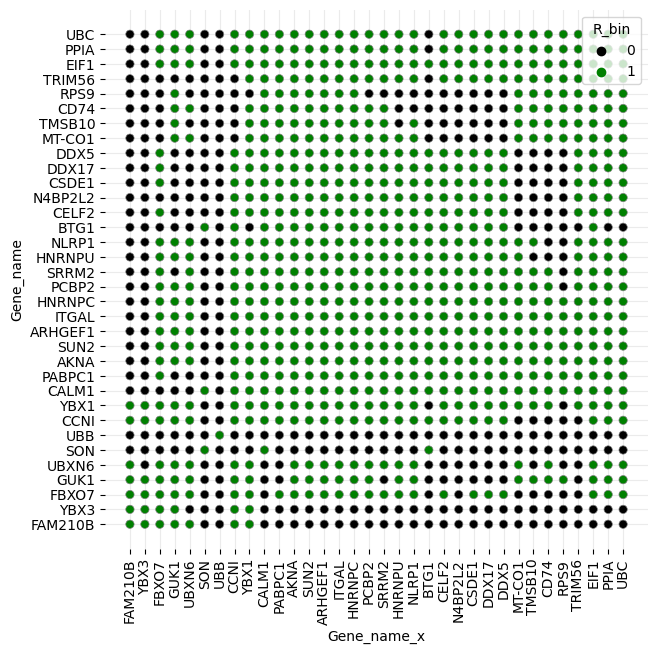

In [555]:
fig = plt.figure(figsize=(7,7))

data = adata[:,adata.var.uclustering_cv_stb_labels.isin([19])].to_df().corr()
Z=sch.linkage(data, method='ward')
order = sch.leaves_list(Z)
data = data.iloc[order,order]
# order = data.columns[sch.leaves_list(Z)].tolist()

cols_ = data.columns
dict_cols = dict(zip(cols_,range(len(data.columns))))
data.index = data.index.map(dict_cols)
data.columns = cols_.map(dict_cols)
data = data.melt(ignore_index=False).reset_index(names='Gene_name_x')
data['R_bin'] = np.where((data.value.abs().values>=.5), 1,0)
ax = sns.scatterplot(x='Gene_name_x', y='Gene_name', hue='R_bin', palette=['black', 'green'], edgecolor='gray', data=data)
# dict_cols = dict([d[::-1] for d in dict_cols.items()])
ax.set_xticks(range(len(dict_cols.keys())), cols_, rotation=90)
ax.set_yticks(range(len(dict_cols.keys())), cols_)
ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
plt.grid(True, alpha=.25)
plt.gca().set_axisbelow(True)
# data
fig.show()

In [34]:
aux_R

Gene_name_x     AP2M1     ASCC2    DDX39B   FAM210B     GLRX5     MYO1G  \
Gene_name_y                                                               
AP2M1             1.0  0.268256  0.922835  0.578647  0.513086  0.918535   
ASCC2        0.268256       1.0  0.297815  0.584044  0.281732  0.158955   
DDX39B       0.922835  0.297815       1.0  0.462833  0.357165  0.895391   
FAM210B      0.578647  0.584044  0.462833       1.0  0.681011  0.347228   
GLRX5        0.513086  0.281732  0.357165  0.681011       1.0   0.35592   
MYO1G        0.918535  0.158955  0.895391  0.347228   0.35592       1.0   
PIP4K2A      0.694937  0.416973  0.708189  0.625678  0.513584  0.563653   
PSMF1        0.946341  0.334282  0.849194  0.702319  0.595805  0.803349   
SF3B2        0.923135  0.298498   0.95741  0.461139  0.311202  0.873605   
UBB          0.174611   0.27909  0.021013  0.403192  0.650223  0.094147   

Gene_name_x   PIP4K2A     PSMF1     SF3B2       UBB  
Gene_name_y                                          
AP2M1        0.694937  0.946341  0.923135  0.174611  
ASCC2        0.416973  0.334282  0.298498   0.27909  
DDX39B       0.708189  0.849194   0.95741  0.021013  
FAM210B      0.625678  0.702319  0.461139  0.403192  
GLRX5        0.513584  0.595805  0.311202  0.650223  
MYO1G        0.563653  0.803349  0.873605  0.094147  
PIP4K2A           1.0  0.727144  0.713112  0.182822  
PSMF1        0.727144       1.0  0.864484  0.217523  
SF3B2        0.713112  0.864484       1.0 -0.001241  
UBB          0.182822  0.217523 -0.001241       1.0

In [35]:
aux

gene_pair                R       pvalue  Gene_name_x  Gene_name_y
0           UBB,UBB  R Pearson ≥ 0.5  padj ≤ 0.05   651.666667   651.666667
1       UBB,PIP4K2A  R Pearson < 0.5  padj ≤ 0.05   651.666667     5.000000
2         UBB,PSMF1  R Pearson < 0.5  padj ≤ 0.05   651.666667   220.555556
3         UBB,MYO1G  R Pearson < 0.5  padj ≤ 0.05   651.666667   328.333333
4         UBB,GLRX5  R Pearson ≥ 0.5  padj ≤ 0.05   651.666667   975.000000
..              ...              ...          ...          ...          ...
50      SF3B2,AP2M1  R Pearson ≥ 0.5  padj ≤ 0.05   112.777778   543.888889
51    SF3B2,FAM210B  R Pearson < 0.5  padj ≤ 0.05   867.222222   543.888889
52      AP2M1,AP2M1  R Pearson ≥ 0.5  padj ≤ 0.05   112.777778   112.777778
53    AP2M1,FAM210B  R Pearson ≥ 0.5  padj ≤ 0.05   867.222222   112.777778
54  FAM210B,FAM210B  R Pearson ≥ 0.5  padj ≤ 0.05   867.222222   867.222222

[110 rows x 5 columns]

In [2598]:
aux_R.columns[order]
order.shape

(86,)

In [82]:
aux_R.columns

Index(['AP2M1', 'ASCC2', 'DDX39B', 'FAM210B', 'GLRX5', 'MYO1G', 'PIP4K2A',
       'PSMF1', 'SF3B2', 'UBB'],
      dtype='object', name='Gene_name_x')

In [79]:
dn['leaves']

[6, 0, 7, 5, 2, 8, 9, 1, 3, 4]

In [77]:
np.sort(np.array(dn['icoord'])[np.where(np.array(dn['dcoord'])==0)])

array([15., 25., 45., 55., 35.,  5., 85., 95., 75., 65.])

In [76]:
order

array([6, 0, 7, 5, 2, 8, 9, 1, 3, 4], dtype=int32)

In [75]:
scale_[order]

array([65.,  5., 75., 55., 25., 85., 95., 15., 35., 45.])

KeyError: '[65.0, 75.0, 55.0, 25.0, 85.0, 95.0, 15.0, 35.0, 45.0] not in index'

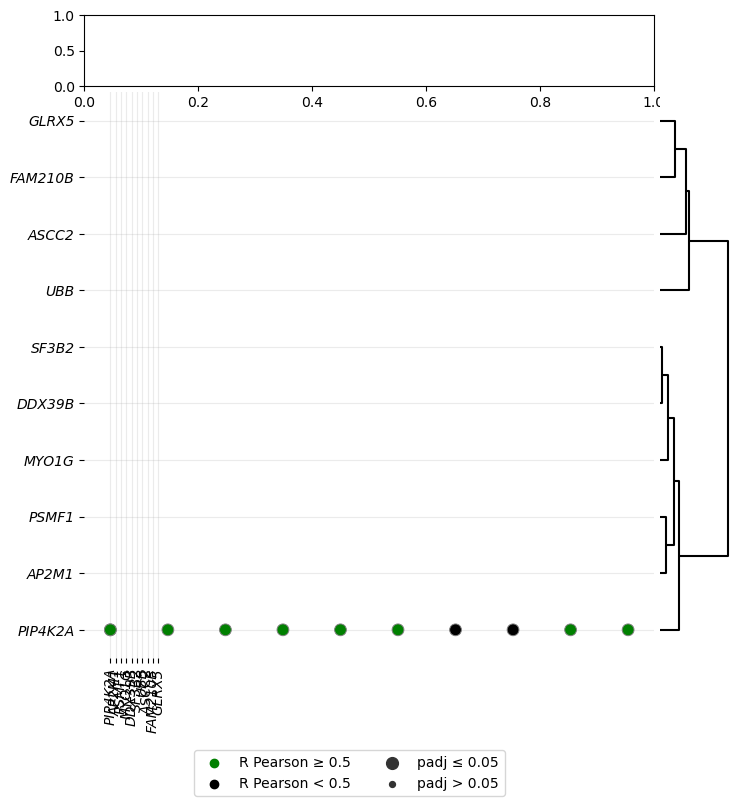

In [74]:
fig = plt.figure(figsize=(8.35,8.35))
gs = GridSpec(2, 2, width_ratios=[8, 1], height_ratios=[1,8], wspace=.02, hspace=.02)
ax = fig.add_subplot(gs[1,0])#(111)#
ax_y_bar = fig.add_subplot(gs[0,0])#, sharex=ax)
ax_y_dn = fig.add_subplot(gs[1,1])#, sharey=ax)

dn = sch.dendrogram(Z, orientation='right', no_labels=True, color_threshold=0, above_threshold_color='black', labels=aux_R.columns,  ax=ax_y_dn)# ,

# scale_ = MinMaxScaler(feature_range=(5, 10)).fit_transform( np.array(list(range( len(aux_R.columns) ))).reshape(-1,1) ).flatten()
scale_ = np.sort(np.array(dn['icoord'])[np.where(np.array(dn['dcoord'])==0)])
ax_y_dn.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
ax_y_dn.grid(False)
ax_y_dn.set_xticks([], [])

sns.scatterplot(x='Gene_name_x', y='Gene_name_y', hue='R', marker='o', size='pvalue', palette=['green', 'black'], edgecolor='grey', data=aux, ax=ax)
# 
# dict_cols = dict([d[::-1] for d in dict_cols.items()])
# ax.set_xticks(range(len(n_gene_dict.keys())), order, rotation=90)
# ax.set_yticks(range(len(n_gene_dict.keys())), order)
ax.set_xticks(scale_, aux_R.columns[order], rotation=90, style='italic')
ax.set_yticks(scale_, aux_R.columns[order], style='italic')
ax.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(ax_y_dn.get_ylim())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=np.array(handles)[[1,2,4,5]].tolist(), labels=np.array(labels)[[1,2,4,5]].tolist(), bbox_to_anchor=(.75, -.15), ncol=2)
# ax.legend(bbox_to_anchor=(.85, -.175), ncol=2)
# ax.legend(bbox_to_anchor=(1., 1.))
ax.grid(True, alpha=.25)
ax.set_axisbelow(True)

# sns.countplot(x='Gene_name_x',  color='grey', dodge=True, order=order, data=aux[aux.R=='R Pearson ≥ 0.5'], ax=ax_y_bar)
data = aux[aux.R=='R Pearson ≥ 0.5'].groupby('Gene_name_x').count().loc[scale_[order]].reset_index()
sns.barplot(x='Gene_name_x', y='gene_pair', color='grey',data=data,ax=ax_y_bar)
ax_y_bar.set_xlabel('Qty.')
ax_y_bar.set_ylabel('')
# ax_y_bar.set_xlim((-1.5,34.5))
ax_y_bar.set_yticks((0,data.gene_pair.max()))
# ax_y_bar.axhline(data.gene_pair.max(), ls='--')


# ax_y_dn.tick_params(axis='both', which='both', left=False)
ax_y_bar.set_xticklabels([])
ax_y_bar.set_xlabel(None)
ax_y_bar.spines[['left','right', 'top', 'bottom']].set_visible(False)
ax_y_bar.set_ylabel('Qty.')#, fontsize=9)
# sns.barplot(x='Gene_name_y', data=aux[aux.R=='R Pearson ≥ 0.5'].groupby(['Gene_name_x']).count(), ax=ax_c)

# fig.tight_layout()

In [56]:
np.array(dn['icoord']).max()

95.0

In [57]:
np.array(dn['icoord']).min()

5.0

In [2679]:
from boruta import BorutaPy
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

In [2680]:
def boruta_selection(adata, layer:str = None, class_col:str = None, scaler = None, rf_model = None, class_weight:list = None, random_state:int = 42):
    if layer != None:
        X_ = adata.layers[layer]
    else:
        X_ = adata.X

    if class_col == None:
        raise Exception("Boruta feature selection requires a class_col argument, with, at least, two different classes.")
    else:
        y_ = adata.obs[class_col].values

    if scaler != None:
        X_ = scaler.fit_transform(X_)

    if class_weight == None:
        unique_ = np.unique(y_)
        class_weight = dict(zip(unique_,compute_class_weight(class_weight="balanced", classes=unique_, y=y_)))

    if rf_model == None:
        rf_model = RandomForestClassifier(class_weight=class_weight)

    feat_selector = BorutaPy(rf_model, n_estimators='auto', verbose=0, random_state=random_state)
    feat_selector.fit(X_, y_)

    feature_ranks = list(zip(adata.var.index,
                         feat_selector.ranking_,
                         feat_selector.support_))

    result = {'genes':[], 'rank':[], 'support':[]}
    for feat in feature_ranks:
        if feat[2]:
            result['genes'].append(feat[0])
            result['rank'].append(feat[1])
            result['support'].append(feat[2])
            # print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
    return result

def set_boruta_selection(adata, layer:str = None, class_col:str = None, scaler = None,  rf_model = None, random_state:int = 42, class_weight:list = None, n_set:int = 5, sample_size:int = None, replace:bool = False):
    if class_col == None:
        raise Exception("Boruta feature selection requires a class_col argument, with, at least, two different classes.")
    else:
        y_ = adata.obs[class_col].values

    results = []
    for i,set in enumerate(set_balance_resample(y_, n_set=n_set, random_state=random_state, sample_size=sample_size, replace=replace)):
        results.append(boruta_selection(adata, layer=layer, rf_model=rf_model, class_col=class_col, class_weight=class_weight, scaler=scaler, random_state=random_state+i))

    return results

def balance_resample(y_var:list = None, random_state:int = 42, sample_size:int = None, replace:bool = False):
    v, c = np.unique(y_var, return_counts=True)
    if sample_size == None:
        sample_size = c.min()
    else:
        if sample_size > c.min():
            print("Warning, sample_size greather than the minimum class counts. Truning sample_size =", str(c.min()))
            sample_size = c.min()

    idx = np.array([], dtype=int)
    for v_ in v:
        np.random.seed(random_state)
        idx = np.concatenate( ( idx, np.random.choice(np.where(y_var == v_)[0], size=sample_size, replace=replace) ))

    return idx

def set_balance_resample(y_var:list = None, n_set:int = 5, random_state:int = 42, sample_size:int = None, replace:bool = False):
    set_idx = []
    for n in range(n_set):
        set_idx.append( balance_resample(y_var, random_state+n, sample_size, replace) )

    return set_idx

[('ABMR', 'non-rejection'),
 ('ABMR', 'TCMR'),
 ('ABMR', 'ABMR and TCMR'),
 ('non-rejection', 'TCMR'),
 ('non-rejection', 'ABMR and TCMR'),
 ('TCMR', 'ABMR and TCMR'),
 ('ABMR', 'non-rejection', 'TCMR', 'ABMR and TCMR')]

In [2887]:
cols_1 = aux_tost2.columns.tolist()

In [2888]:
combinations_class_col = list(itertools.combinations(adata.obs.conditions_GSE175718.unique(), 2))
combinations_class_col.append(tuple(adata.obs.conditions_GSE175718.unique()))
combinations_class_col

boruta_sets_ = dict()
aux_list = []
for comb in combinations_class_col:
    gn = []
    aux = set_boruta_selection(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718.isin(comb)),cols_1],
                                           layer='arcsinh', class_col='conditions_GSE175718', n_set=5)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])

    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_[' + '.join(comb)] = dict(zip(f,c))#np.unique(gn, return_counts = True)   

In [2889]:
boruta_sets_

{}

In [2503]:
boruta_sets_

{'ABMR + TCMR': {'SCYL1': 3},
 'non-rejection + TCMR': {'CDK11B': 8},
 'non-rejection + ABMR and TCMR': {'RABEP1': 9},
 'TCMR + ABMR and TCMR': {'RABEP1': 4},
 'ABMR + non-rejection + TCMR + ABMR and TCMR': {'RABEP1': 2}}

In [2611]:
pd.DataFrame(boruta_sets_).fillna(0).index#.melt()

Index(['SCYL1', 'CDK11B', 'RABEP1'], dtype='object')

<Axes: xlabel='variable', ylabel='value'>

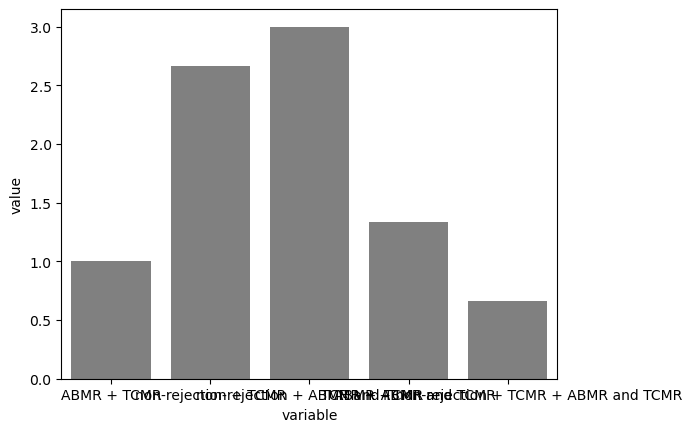

In [2514]:
sns.barplot(x='variable', y='value', ci=None, color='grey',  data=pd.DataFrame(boruta_sets_).fillna(0).melt())

In [2478]:
f,c = np.unique(gn, return_counts = True)

In [2481]:
c

array([3])

In [2480]:
dict(zip(f,c))

{'SCYL1': 3}

In [2438]:
[g['genes'] for g in boruta_sets_[('ABMR', 'TCMR')] if g['support']]

[['SCYL1'], ['SCYL1'], ['SCYL1']]

In [ ]:
# srr_resampled = [ set(simple_resample(df_GSE46474_ratio_reduced, 'acr', rs, 17)) for rs in list(range(0,5)) ]
# rf = RandomForestClassifier(n_jobs=-1, n_estimators=500, class_weight='balanced',
#                             max_depth=20, criterion="gini", random_state=random_state)
# # Run Boruta for different random balanced subsamples
# genes = [boruta_select(df_GSE46474_ratio_reduced, srrs, StandardScaler(), rf, random_state) for srrs in srr_resampled ]
# # gse_features_dict[gse+'_'+str(sc)] = genes
# gn = []
# for g in genes:
#       gn.extend(g)
# gn = set(gn)

In [2414]:
X_ = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718.isin(['TCMR', 'ABMR and TCMR'])),aux_tost.columns].layers['arcsinh']
y_ = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718.isin(['TCMR', 'ABMR and TCMR'])),aux_tost.columns].obs['conditions_GSE175718'].values
unique_ = np.unique(y_)
w = dict(zip(unique_,compute_class_weight(class_weight="balanced", classes=unique_, y=y_)))

rf = RandomForestClassifier(class_weight=w)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X_, y_)

feature_ranks = list(zip(aux_tost.columns, 
                     feat_selector.ranking_, 
                     feat_selector.support_))
print('.', end='.')
# iterate through and print out the results
genes = []
for feat in feature_ranks:
    if feat[2]:
        genes.append(feat[0])
# feat_b[lg] = genes
print('.', end=' | ')

... | 

In [2415]:
genes

['RABEP1']

In [2411]:
genes

['SCYL1']

In [2409]:
genes

['RABEP1']

In [2407]:
genes

['CDK11B']

In [2393]:
genes

['RABEP1']

In [2405]:
w

{'ABMR': 2.3161764705882355, 'non-rejection': 0.6376518218623481}

In [2385]:
unique_

array(['ABMR', 'ABMR and TCMR', 'TCMR', 'non-rejection'], dtype=object)

In [2386]:
np.unique(y_, return_counts=True)

(array(['ABMR', 'ABMR and TCMR', 'TCMR', 'non-rejection'], dtype=object),
 array([ 68,  18,  50, 247]))

# Select by number of ortholog species

In [213]:
from upsetplot import from_contents
# from upsetplot import UpSet
from upsetplot import plot

In [214]:
# Since MT_CO1 is not reconized by orthology database, I downloaded the synonymous COX1 and thn renamed the path name.
genes = [g for g in feats_3]# if g != 'MT-CO1'] + ['COX1']
print(' '.join(genes))
print(len(genes))

AP2B1 CCNI FBXO7 GUK1 MT-CO1 UBB UBXN6 VPS28 YBX3
9


In [215]:
# feats_3 = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']

In [216]:
genes

['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'MT-CO1', 'UBB', 'UBXN6', 'VPS28', 'YBX3']

In [2707]:
#FILE /mnt/d/housekeeping_genes/ortholog_retrieve.sh
#!/bin/bash

# genes='AP2B1 CCNI FBXO7 GUK1 MT-CO1 UBB UBXN6 VPS28 YBX3'
# path='/mnt/d/housekeeping_genes/orthology/new_analysis_6_26_2024/'
# for g in ${genes}; do
#     datasets download gene symbol ${g} --ortholog all
#     unzip ${path}ncbi_dataset.zip
#     mv ${path}ncbi_dataset ${path}${g}
# done

In [217]:
orth_dict = {g:[] for g in genes}#os.listdir(path)}
orth_dict_c = dict()
path = '/mnt/d/housekeeping_genes/orthology/new_analysis_7_9_2024/'
all_tax = set()
for g in genes:#os.listdir(path):
    with open(os.path.join(path+g+'/data/data_report.jsonl'), 'r') as f:
        for line in f:
            txn = eval(line)['taxId']
            if txn not in orth_dict[g]:
                orth_dict[g].append(txn)
                all_tax.update([txn])
    orth_dict_c[g] = len(orth_dict[g])

In [218]:
aux = pd.DataFrame(orth_dict_c.items())#[1].median()

<Axes: xlabel='1', ylabel='0'>

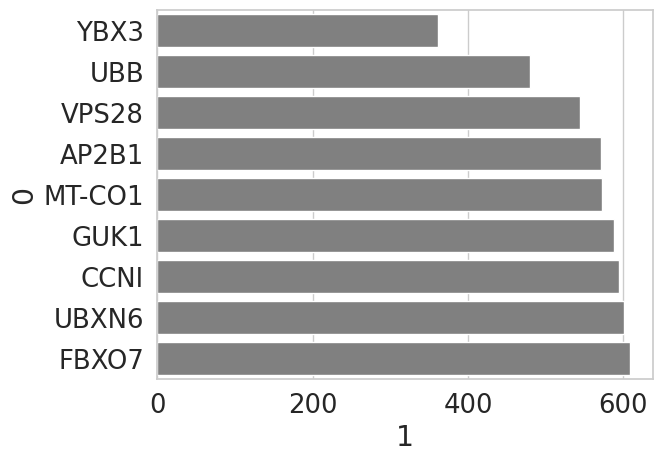

In [219]:
sns.barplot(x=1, y=0, color='grey', data=aux.sort_values(1))

<Axes: xlabel='1', ylabel='Count'>

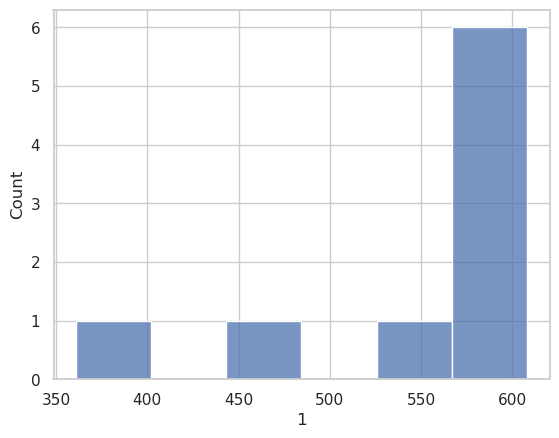

In [482]:
sns.histplot(x=1,data=aux.sort_values(1))

In [336]:
# I ran /mnt/d/housekeeping_genes/taxonomy_retrieve.sh to get tax_children
# print(' '.join(all_tax))

#!/bin/bash

# taxids='175797 34773 9483 109280 89462 173247 54380 8868 48193 194408 1234273 8524 40204 7938 59472 372321 9986 80427 90313 30522 59534 310571 59894 221976 1706337 61383 447135 9601 61156 441366 59463 386614 215358 8996 10141 2290929 38626 9157 188344 9708 31138 1094192 143292 214514 225400 8030 9657 27610 13397 9031 308060 9715 80972 10181 8023 244447 130825 9135 60746 7782 1002788 452646 54343 270530 8884 8036 81927 1884717 9694 68408 8017 1415580 9685 43346 37293 93934 286419 300417 13013 35019 90988 62283 9238 9531 9749 309878 51298 259920 30455 84834 32507 51853 202280 9838 575201 8081 9995 13735 100897 9423 89673 59729 8795 99487 889875 7955 8520 36176 38654 233779 9666 260615 75329 48699 723540 47969 303518 161584 9974 8345 9606 9054 77151 992332 8153 127582 27675 1230840 9103 8467 8267 79684 75038 9940 77932 77115 51337 48139 564181 7998 106734 9365 9565 8018 91951 93162 29139 336983 37032 9874 51338 9755 79690 48698 9541 48849 80966 34884 1047088 409849 279965 40151 143302 933632 8957 42254 72105 8663 9244 260995 56313 10090 8260 103695 55661 415023 8167 9690 109478 7888 52904 9994 9430 56716 9258 125878 43689 685728 28377 9886 300413 327740 73337 278164 2962859 175792 7830 202946 29064 148594 50402 146911 69293 170820 9823 13676 13616 296741 70543 7962 7753 32536 27706 460621 160734 101364 61452 8932 208062 9402 37040 48708 30464 9716 210632 451745 161448 159646 9711 30419 499056 2587831 8208 30427 9771 43700 546530 1914991 187106 345164 481883 27771 9796 9983 1868482 240206 75485 1608454 9627 27622 219594 106582 143291 8969 9999 7957 8384 9689 103944 30608 7950 194338 291302 161590 184585 9767 941984 9728 8845 8010 29144 443677 7936 9447 337641 147949 9590 82168 9600 586833 9172 10117 64144 9544 9555 8478 187451 90735 2489341 407982 321398 52239 176057 98922 13677 184440 369639 38775 9598 72004 9669 61221 9978 2857394 33562 94835 34839 495146 8019 7994 185453 2746895 1250792 1606681 10089 7897 109905 328815 109475 1142201 27606 9915 191870 1203425 9568 257877 9002 48701 54180 134902 109678 283035 10093 27697 2059687 9361 82655 35005 30331 649802 80720 75352 44398 10047 10036 74926 74940 87175 433684 9615 13146 30732 8128 57412 41426 60711 7906 299123 433405 9233 27679 205130 2546036 154827 9595 379532 482537 932674 181472 34886 8040 1042646 1825980 9160 27687 43150 46844 27794 1582913 50954 90069 2857398 114329 37181 187382 10029 28737 2871759 85066 8364 195615 1676925 181119 54383 7757 32473 1608482 1192867 38674 488313 9713 8032 8083 156563 8790 9731 8262 9643 9209 1574408 30538 164674 42636 65483 109293 307959 8240 8895 9597 10041 64668 7959 61621 415032 391180 8954 9720 76717 8469 89248 55291 161450 105255 48883 111838 61853 42100 693459 61384 9417 8078 229290 134920 198806 59861 13489 43179 28829 9742 33528 191477 8897 161453 137520 188132 29088 8673 33616 34880 30532 9470 37003 150288 293821 8090 9261 10116 113540 8005 417921 42410 375764 144197 127875 223781 119488 885580 8084 3053191 9913 884348 9515 1841481 13085 57421 52644 8154 491861 61388 90247 9837 186990 9704 27615 159077 9798 56723 678569 8049 97097 42526 8038 9305 10020 345155 31033 9644 441894 121530 230844 34816 132908 94885 63155 478635 9733 188379 356909 9017 39638 310915 129043 8839 52670 208333 109042 158456 36300 419612 3119969 2715852 9691 10160 241271 9662 261503 9371 175836 9117 57068 54374 7918 9739 8168 40690 8236 61622 44394 59479 8496 118200 30640 118141 128390 161592 35540 36723 95912 217509 35658 508554 591936 8177 3034132 494514 30410 9906 29078 8218 176946 9860 64176 7868 2939378 8355 161469 2991368 8502 94827 9793 257770 57397 8407 1196302 41447 66913 8187 175006 246437 42514 30611 161455 28743 9785 29073 100784 299321 81572 9337 8175 8103 105023 37029 120794 48891 29151 10129 286002 269649 1026970 8245 75366 9646 56733 8022 8255 84645 118797 390379 192404 9545 9407 415028 88082 158779 68294 7913 9925 8869 9696 110931'

# path='/mnt/d/housekeeping_genes/orthology/tax_children/'
# for txid in ${taxids}; do
#     datasets download taxonomy taxon ${txid} --children
#     unzip ${path}ncbi_dataset.zip
#     mv ${path}ncbi_dataset ${path}${txid}
#     rm ${path}ncbi_dataset.zip README.md
# done

In [220]:
tx_phylum_dict = dict()
tx_class_dict = dict()
tx_order_dict = dict()
tx_family_dict = dict()
tx_genus_dict = dict()
tx_species_dict = dict()
not_found_dict = {t:[] for t in ['phylum','class','order','family','genus','species','not_in_all_tax']}
path = '/mnt/d/housekeeping_genes/orthology/tax_children/'
for tx in os.listdir(path):
    with open(os.path.join(path+tx+'/data/taxonomy_report.jsonl'), 'r') as f:
        txn = eval(f.readline().strip('\n').replace('true','"true"'))
        if 'phylum' in txn['taxonomy']['classification'].keys():
            tx_phylum_dict[tx] = txn['taxonomy']['classification']['phylum']['name']
        else:            
            # tx_phylum_dict[tx] = 'undefined_'+tx
            not_found_dict['phylum'].append(tx)
            
        if 'class' in txn['taxonomy']['classification'].keys():
            tx_class_dict[tx] = txn['taxonomy']['classification']['class']['name']
        else:
            # tx_class_dict[tx] = 'undefined_'+tx 
            not_found_dict['class'].append(tx)
            
        if 'order' in txn['taxonomy']['classification'].keys():
            tx_order_dict[tx] = txn['taxonomy']['classification']['order']['name']
        else:
            # tx_order_dict[tx] = 'undefined_'+tx
            not_found_dict['order'].append(tx)
            
        if 'family' in txn['taxonomy']['classification'].keys():
            tx_family_dict[tx] = txn['taxonomy']['classification']['family']['name']
        else:
            # tx_family_dict[tx] = 'undefined_'+tx
            not_found_dict['family'].append(tx)

        if 'genus' in txn['taxonomy']['classification'].keys():
            tx_genus_dict[tx] = txn['taxonomy']['classification']['genus']['name']
        else:
            # tx_genus_dict[tx] = 'undefined_'+tx
            not_found_dict['genus'].append(tx)
            
        if 'species' in txn['taxonomy']['classification'].keys():
            tx_species_dict[tx] = txn['taxonomy']['classification']['species']['name']
        else:
            # tx_species_dict[tx] = 'undefined_'+tx
            not_found_dict['species'].append(tx)

        if tx not in all_tax:
            not_found_dict['not_in_all_tax'].append(tx)

In [221]:
for k,i in not_found_dict.items():
    if i:
        print(k,len(i),i)

class 20 ['106734', '13735', '1825980', '2587831', '260615', '27794', '286002', '2991368', '31138', '38654', '74926', '7888', '7897', '82168', '8467', '8469', '8478', '8496', '8502', '94835']
order 12 ['13489', '144197', '185453', '210632', '215358', '34816', '75038', '80966', '80972', '8187', '9371', '941984']


In [222]:
print('Total of phylum: ',set(tx_phylum_dict.values()))
print('Total of classes: ',len(set(tx_class_dict.values())),set(tx_class_dict.values()))
print('Total of order: ',len(set(tx_order_dict.values())))
print('Total of family: ',len(set(tx_family_dict.values())))
print('Total of genus: ',len(set(tx_genus_dict.values())))
print('Total of species: ',len(set(tx_species_dict.values())))

Total of phylum:  {'Chordata'}
Total of classes:  8 {'Hyperoartia', 'Amphibia', 'Actinopteri', 'Chondrichthyes', 'Cladistia', 'Aves', 'Mammalia', 'Lepidosauria'}
Total of order:  111
Total of family:  288
Total of genus:  500
Total of species:  630


### Only well defined clade were considered

Total of classes:  8


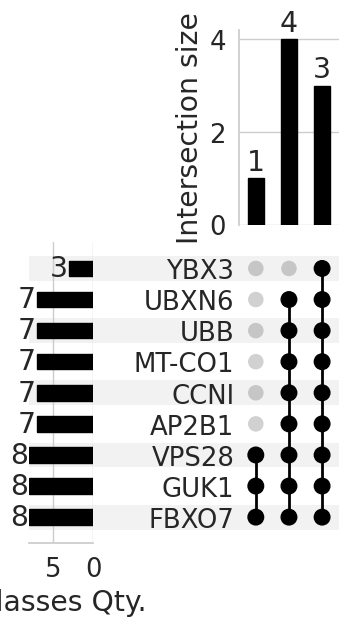

In [223]:
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_class_dict[tx] for tx in orth_dict[k] if tx in tx_class_dict.keys()]))
print('Total of classes: ',len(set(tx_class_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True)#, facecolor="darkblue")
up['totals'].set_xlabel("Classes Qty.")
plt.show()

Total of orders:  111


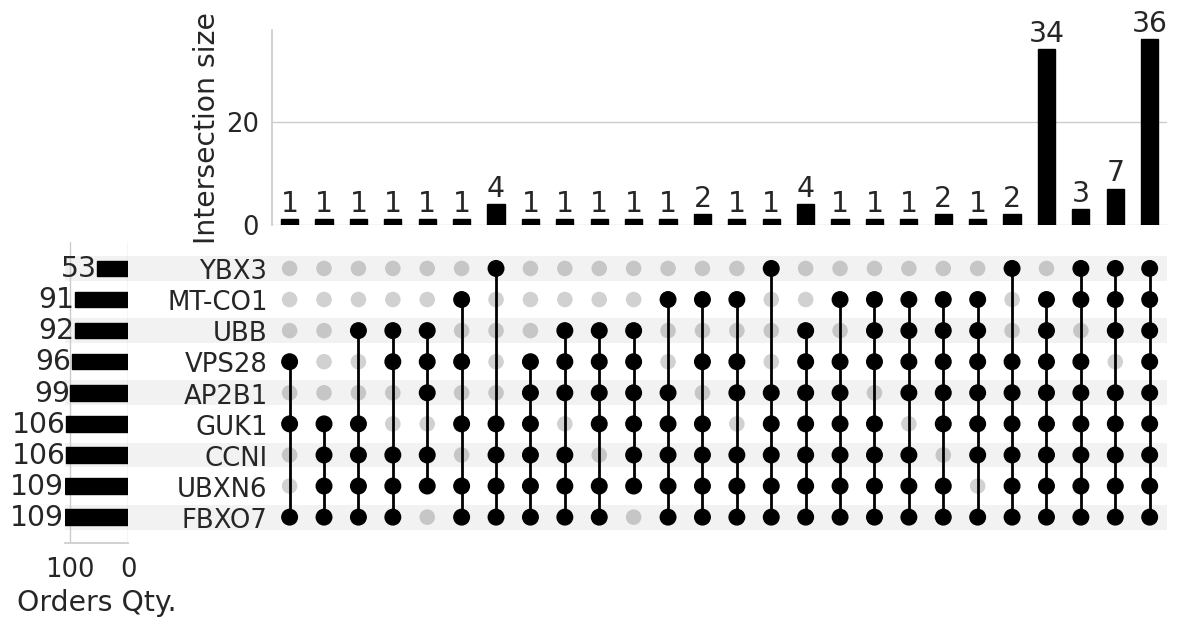

In [224]:
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_order_dict[tx] for tx in orth_dict[k] if tx in tx_order_dict.keys()]))
print('Total of orders: ',len(set(tx_order_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True)#, facecolor="darkblue")
up['totals'].set_xlabel("Orders Qty.")
plt.show()

Total of families:  288


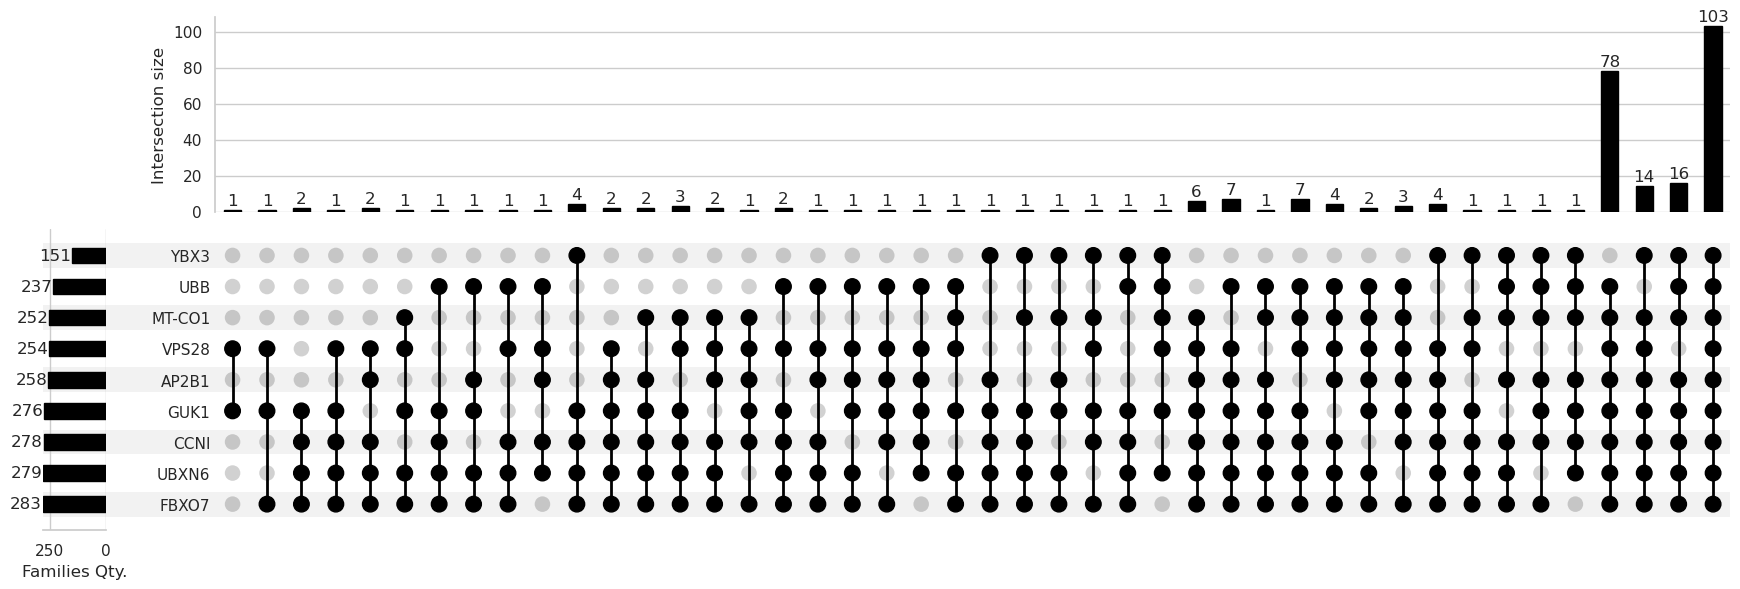

In [488]:
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_family_dict[tx] for tx in orth_dict[k] if tx in tx_family_dict.keys()]))
print('Total of families: ',len(set(tx_family_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True)#, min_subset_size=2)#, facecolor="darkblue")
up['totals'].set_xlabel("Families Qty.")
plt.show()

Total of genus:  500


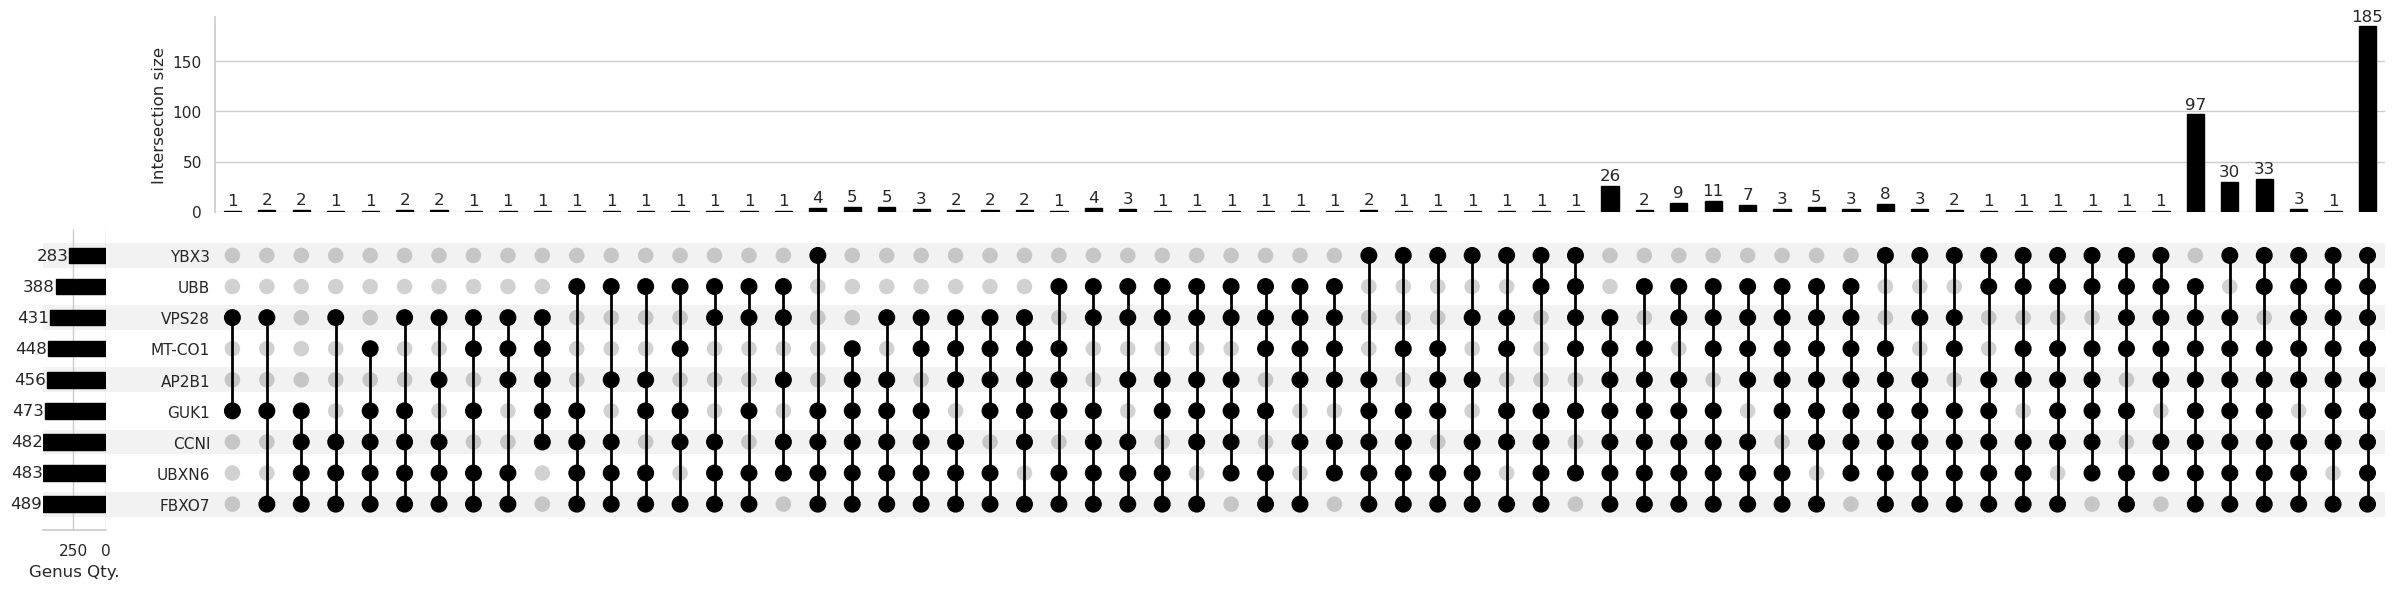

In [489]:
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_genus_dict[tx] for tx in orth_dict[k] if tx in tx_genus_dict.keys()]))
print('Total of genus: ',len(set(tx_genus_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True)#, min_subset_size=3)#, facecolor="darkblue")
up['totals'].set_xlabel("Genus Qty.")
plt.show()

Total of species:  630


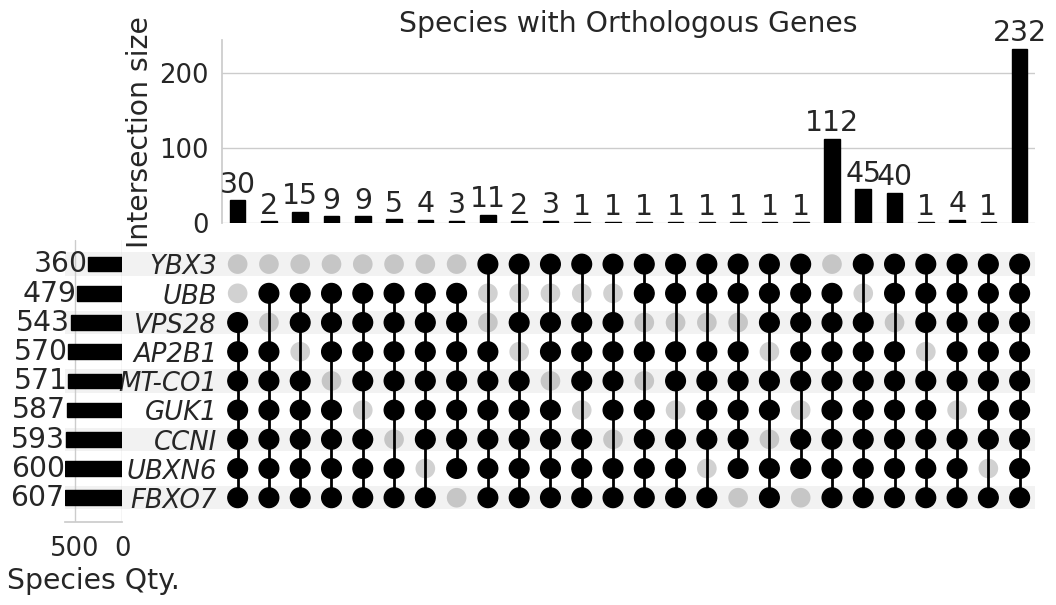

In [226]:
fig = plt.figure(figsize=(8.35*3/2, 8.35*3/4))
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_species_dict[tx] for tx in orth_dict[k] if tx in tx_species_dict.keys()]))
print('Total of species: ',len(set(tx_species_dict.values())))
orth_genes = from_contents(orth_dict_aux)
# up = plot(orth_genes, orientation="horizontal", show_counts=True, min_degree=7, element_size=30, totals_plot_elements=4)#, min_subset_size=3)#, facecolor="darkblue")fig=fig
up = plot(orth_genes, orientation="horizontal", show_counts=True, show_percentages=False, min_degree=7,  fig=fig, element_size=None)
up['totals'].set_xlabel("Species Qty.")
up['intersections'].set_title("Species with Orthologous Genes")
for lbl in up['matrix'].get_yticklabels():
    lbl.set_style('italic')
plt.show()

In [373]:
print('At least 8 genes: ', 232+1+4+1+40+45+112)
print('At least 7 genes: ', 232+1+4+1+40+45+112+8*1+3+2+11+3+4+5+9+9+15+2+30)

At least 8 genes:  435
At least 7 genes:  536


In [349]:
# Gens present in Homo Sapiens
orth_genes.reset_index().set_index('id').sum(axis=1)['Homo sapiens']

9

## preparing sequences to align

In [491]:
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']#'COX1']
genes

['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']

In [412]:
# path = '/mnt/d/housekeeping_genes/orthology/new_analysis_7_9_2024/'
# for g in genes:
#     flag = False
#     with open(os.path.join(path,g,'data/rna.fna'), 'r') as fastaobject:
#         txt = ''
#         for line in fastaobject:
#             if line.startswith('>') and (('[transcript=X1]' in  line) or (not '[transcript' in line)):
#                 txt += line
#                 flag = True                
#             elif (not line.startswith('>')) and flag:
#                 txt += line
#             else:
#                 flag = False
#     with open(os.path.join(path,g,'data/one_seq_rna.fna'), 'w') as new_fastaobject:
#         new_fastaobject.write(txt)

#     print(g, end=' ')

path = '/mnt/d/housekeeping_genes/orthology/new_analysis_7_9_2024/'
for g in genes:
    flag = False
    header_aux = ['','','']
    with open(os.path.join(path,g,'data/protein.faa'), 'r') as fastaobject:
        txt = ''
        for line in fastaobject:
            if line.startswith('>'):
                line = line.replace('isoform=a','isoform=X1')
                line = line.replace('isoform=1 precursor','isoform=X1') #problem with COX1 header for Homo sapiens
                line = line.replace('isoform=1','isoform=X1')                
            if line.startswith('>') and (header_aux[2] != line.split(' ')[2]) and (('[isoform=X1]' in  line) or (not '[isoform' in line)):
                txt += line
                flag = True
                header_aux = line.split(' ')
            elif (not line.startswith('>')) and flag:
                txt += line
            else:
                flag = False
    with open(os.path.join(path,g,'data/one_seq_protein.faa'), 'w') as new_fastaobject:
        new_fastaobject.write(txt)

    print(g, end=' ')

AP2B1 CCNI FBXO7 GUK1 UBB UBXN6 VPS28 YBX3 COX1 

## Run Clustal Omega to align orthologues

In [329]:
import subprocess

In [493]:
path = '/mnt/d/housekeeping_genes/orthology/new_analysis_7_9_2024/'

In [413]:
# for g in genes:
#     subprocess.call(['clustalo', '-i', os.path.join(path,g,'data/one_seq_rna.fna'),
#                      '-o', os.path.join(path,g,'data/one_seq_rna.afa'),
#                      '-t', 'DNA'], cwd='/mnt/d/',stdout=subprocess.PIPE)
#     print(g, end=' ')

for g in ['COX1']:#genes:
    subprocess.call(['clustalo', '-i', os.path.join(path,g,'data/one_seq_protein.faa'),
                     '-o', os.path.join(path,g,'data/one_seq_protein.afa'),
                     '-t', 'Protein', '--force'], cwd='/mnt/d/',stdout=subprocess.PIPE)
    print(g, end=' ')

COX1 

## Orthology entropy distribution

### get motifs code on [CDD](https://www.ncbi.nlm.nih.gov/cdd)

In [ ]:
cdd = {'AP2B1':['pfam01602','sd00044','smart00809','smart01020'], 'CCNI':}

In [78]:
from scipy.stats import entropy
from Bio.Seq import Seq
from Bio import motifs
from Bio import AlignIO

In [437]:
def get_aln_pos(aln, seq_pos):
    aln_pos = []
    a_pos = 0
    hs_idx = 0
    for aa in aln:
        if 'organism=Homo sapiens' in aa.description:
            break
        hs_idx +=1
        
    for i,aa in enumerate(aln.alignment[hs_idx]):
        if aa != '-':
            a_pos += 1
        if a_pos in seq_pos:
            aln_pos.append(i)
            a_pos += 1
    # if len(aln_pos) > 2:
    #     print(aln_pos)
    #     return np.array(aln_pos).reshape(-1,2)
    # else:
    #     return [set(aln_pos)]
    return np.array(aln_pos).reshape(-1,2)

In [426]:
seq_pos = [11, 534, 731, 831 , 840, 950]
aln_pos = []
a_pos = 0
hs_idx = 0
for aa in alignment:
    if 'organism=Homo' in aa.description:
        break
    hs_idx +=1
for i,aa in enumerate(alignment.alignment[hs_idx]):
    if aa != '-':
        a_pos += 1
    if a_pos in seq_pos:
        print(a_pos, i)
        aln_pos.append(i)
        a_pos += 1

11 55
534 722
731 1021
831 1161
840 1169
950 1289


In [434]:
np.array(aln_pos).reshape(-1,2)

array([[  55,  722],
       [1021, 1161],
       [1169, 1289]])

In [432]:
np.array(aln_pos)

array([  55,  722, 1021, 1161, 1169, 1289])

In [382]:
len(alignment[hs_idx].seq)

1360

In [406]:
hs_idx, len(alignment)

(569, 569)

- **AP2B1:**
    - 11-534 aa pfam01602 Adaptin_N: Adaptin N terminal region -> Clathrin Adaptor Activity: This family consists of the N terminal region of various alpha, beta and gamma subunits of the AP-1, AP-2 and AP-3 adaptor protein complexes. The adaptor protein (AP) complexes are involved in the formation of clathrin-coated pits and vesicles [1]. The N-terminal region of the various adaptor proteins (APs) is constant by comparison to the C-terminal which is variable within members of the AP-2 family[2]; and it has been proposed that this constant region interacts with another uniform component of the coated vesicles [2]. [link](https://www.ebi.ac.uk/interpro/entry/pfam/PF01602/)
    - 731-831 aa 
smart0080 
Alpha_adaptinC2: Adaptin C-terminal doma: 
Adaptins are components of the adaptor complexes which link clathrin to receptors in coated vesicles. Clathrin-associated protein complexes are believed to interact wit  the cytoplasmic tails of membrane proteins, leading to their selection and concentration. Gamma-adaptin is a subunit of the golgi adaptor. Alpha adaptin is a heterotetramer tha  regulates clathrin-bud formation. The carboxyl-terminal appendage of the alpha subunit regulates translocation of endocytic accessory proteins to the bud site. This Ig-fold domain i  found in alpha, beta and gamma adaptins and consists of a beta-sandwich containing 7 strands in 2 beta-sheets in a greek-key topology.. The adaptor appendage contains an additional  -terminal strand [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=smart00809).
    - 840-950 aa 
smart0102 
B2-adapt-app_C: Beta2-adaptin appendage, C-terminal sub-dom: Members of this family adopt a structure consisting of a 5 stranded beta-sheet, flanked by one alpha helix on the outer side, and by two alpha helices on the inner side. This domain is required for binding to clathrin, and its subsequent polymerisation. Furthermore, a hydrophobic patch present in the domain also binds to a subset of D-phi-F/W motif-containing proteins that are bound by the alpha-adaptin appendage domain.  [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=smart01020).ainin

- **CCNI:**
    - 44-142 aa 
cd2052 
CYCLIN_CCNI-like: cyclin box found in cyclin-I (CCNI) and similar protei. CCNI is an atypical cyclin because it is most abundant in post-mitotic cells. It is involved in various biological processes, such as cell survival, angiogenesis, cell differentiation, and cell cycle progression. CCNI contains a typical cyclin box near the N-terminus and a PEST sequence near the C-terminus. The cyclin box is a protein binding domain. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd20526)
    - 146-218 aa 
cl4045 
CYCLIN_SF: Cyclin box fold superfami. The cyclin box is a protein binding domain that functions in cell-cycle and transcriptional control. It is about 100 amino acids in length, composed of five helices, and is present in cyclins, transcription initiation factor IIB (TFIIB), and retinoblastoma tumour suppressor protein (Rb). Cyclins consist of 8 classes of cell cycle regulators that function as regulatory subunits of cyclin-dependent kinases (CDKs), which are serine/threonine kinases. The catalytic activities of CDKs are modulated not only by their interactions with cyclins but also by CDK inhibitors (CKIs). CDKs, cyclins and CKIs play key roles in transcription, epigenetic regulation, metabolism, stem cell self-renewal, neuronal functions, and spermatogenesis. TFIIB is a transcription factor that binds the TATA box. Members in this superfamily contain one or two copies of the cyclin box. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cl40454)lyns

- **FBXO7:**
    - 332-376 aa FBXO7, also called FBX7, is the substrate-recognition component of an SCF (SKP1-CUL1-F-box protein) E3 ubiquitin-protein ligase complex which mediates the ubiquitination and subsequent proteasomal degradation of target proteins. It recognizes BIRC2 and DLGAP5. FBXO7 plays a role downstream of PINK1 in the clearance of damaged mitochondria via selective autophagy (mitophagy) by targeting PRKN to dysfunctional depolarized mitochondria. It promotes MFN1 ubiquitination. FBXO7 acts as a cell cycle regulator by enhancing cyclin D/cyclin-dependent kinase 6 (Cdk6) complex formation and stabilizing levels of p27, a cyclin-dependent kinase inhibitor. Mutations in the FBXO7 (PARK15) gene have been implicated in a juvenile form of parkinsonism called parkinsonian pyramidal syndrome (PPS), characterized by Parkinsonian symptoms and pyramidal tract signs. The F-box domain has a role in mediating protein-protein interactions in a variety of contexts, such as polyubiquitination, transcription elongation, centromere binding and translational repression. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=438859)

- **GUK1:**
    - 26-208 aa 
TIGR0326 
guanyl_kin: guanylate kina. Members of this family are the enzyme guanylate kinase, also called GMP kinase. This enzyme transfers a phosphate from ATP to GMP, yielding ADP and GDP. (Purines, pyrimidines, nucleosides, and nucleotides, Nucleotide and nucleoside interconversions) [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=TIGR03263)se

- **UBB:**
    - 1-76 aa 
cd0180 
Ubl_ubiquitin: ubiquitin-like (Ubl) domain found in ubiquit. Ubiquitin is a protein modifier in eukaryotes that is involved in various cellular processes, including transcriptional regulation, cell cycle control, and DNA repair. Ubiquitination is comprised of a cascade of E1, E2 and E3 enzymes that results in a covalent bond between the C-terminus of ubiquitin and the epsilon-amino group of a substrate lysine. Ubiquitin-like (Ubl) proteins have similar ubiquitin beta-grasp fold and attach to other proteins in a Ubl manner but with biochemically distinct roles. Ubiquitin (Ub)and Ubl proteins conjugate and deconjugate via ligases and peptidases to covalently modify target polypeptides. Ub includes Ubq/RPL40e and Ubq/RPS27a fusions as well as homopolymeric multiubiquitin protein chains. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd01803)
    - 77-152 aa 
cd0180 
Ubl_ubiquitin: ubiquitin-like (Ubl) domain found in ubiquit. "
    - 153-228 aa 
cd0180 
Ubl_ubiquitin: ubiquitin-like (Ubl) domain found in ubiquit. "ininin

- **UBXN6:**
    - 158-263 aa 
cd1046 
PUB_UBXD1: PNGase/UBA or UBX (PUB) domain of UBX. This PUB domain is found in p97 adaptor protein UBXD1 (UBX domain-containing protein 1, also called UBXD6). It functions as a p97 (also known as valosin-containing protein or VCP) adaptor by interacting with the D1 and/or D2 ATPase domains. The type II AAA+ ATPase p97 is involved in a variety of cellular processes such as the deglycosylation of ERAD substrates, membrane fusion, transcription factor activation and cell cycle regulation through differential binding to specific adaptor proteins. The PUB domain in UBX-domain protein 1 (UBXD1), which is widely expressed in higher eukaryotes, except for fungi, and which is involved in substrate recruitment to p97, interacts strongly with the C-terminus of p97. UBXD1 also interacts with HRD1 and HERP, both components of the ERAD pathway, via p97. It is possibly involved in aggresome formation; aggresomes are perinuclear compartments that contain misfolded proteins colocalized with centrosome markers.[link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd10460)
    - 336-409 aa 
cd1611 
UBX_UBXN6: Ubiquitin regulatory domain X (UBX) found in UBX domain protein 6 (UBXN6) and similar protei. UBXN6, also termed UBX domain-containing protein 1 (UBXD1), and UBXDC2, belongs to the UBXD family of proteins that contains the ubiquitin regulatory domain X (UBX) with a beta-grasp ubiquitin-like fold, but without the C-terminal double glycine motif. UBX domain is typically located at the carboxyl terminus of proteins, and participates broadly in the regulation of protein degradation. UBXN6 acts as a cofactor of p97 (also known as VCP or Cdc48), which is a homohexameric AAA ATPase (ATPase associated with a variety of activities) involved in a variety of functions ranging from cell-cycle regulation to membrane fusion and protein degradation. Unlike other p97 cofactors that binds the N-domain of p97 through their UBX domain, UBXN6 binds p97 in two regions, at the p97 C terminus via a PUB domain and at the p97 N-domain with a short linear interaction motif termed VIM. Its UBX domain is not functional for the binding of p97. The UBXN6-p97 complex regulates the endolysosomal sorting of ubiquitylated plasma membrane protein caveolin-1 (CAV1), as well as the trafficking of ERGIC-53-containing vesicles by controlling the interaction of transport factors with the cytoplasmic tail of ERGIC-53. In addition, UBXN6 is a regulatory component of endoplasmic reticulum-associated degradation (ERAD) that may modulate the adaptor binding to p97. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd16119)nsD1

- **VPS28:**
    - 39-219 aa 
pfam0399 
VPS28: VPS28 prote. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=pfam03997)in

- **YBX3:**
    - 91-160 aa 
pfam0031 
CSD: 'Cold-shock' DNA-binding doma. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=pfam00313)in

- **MT-CO1 (COX1)**:
    - 32-69 aa 
cd0005 
EGF_CA: Calcium-binding EGF-like domain, present in a large number of membrane-bound and extracellular (mostly anima proteins. Calcium-binding EGF-like domain, present in a large number of membrane-bound and extracellular (mostly animal) proteins. Many of these proteins require calcium for their biological function and calcium-binding sites have been found to be located at the N-terminus of particular EGF-like domains; calcium-binding may be crucial for numerous protein-protein interactions. Six conserved core cysteines form three disulfide bridges as in non calcium-binding EGF domains, whose structures are very similar. EGF_CA can be found in tandem repeat arrangements  [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd00054).
    - 89-575 aa 
cd0981 
prostaglandin_endoperoxide_synthase: Animal prostaglandin endoperoxide synthase and related bacterial protei. Animal prostaglandin endoperoxide synthase and related bacterial proteins. 
Animal prostaglandin endoperoxide synthases, including prostaglandin H2 synthase and a set of similar bacterial proteins which may function as cyclooxygenases. Prostaglandin H2 synthase catalyzes the synthesis of prostaglandin H2 from arachidonic acid. In two reaction steps, arachidonic acid is converted to Prostaglandin G2, a peroxide (cyclooxygenase activity) and subsequently converted to the end product via the enzyme's peroxidase activity. Prostaglandin H2 synthase is the target of aspirin and other non-steroid anti-inflammatory drugs such as ibuprofen, which block the substrate's access to the active site and may acetylate a conserved serine residue. In humans and other mammals, prostaglandin H2 synthase (PGHS), also called cyclooxygenase (COX) is present as at least two isozymes, PGHS-1 (or COX-1) and PGHS-2 (or COX-2), respectively. PGHS-1 is expressed constitutively in most mammalian cells, while the expression of PGHS-2 is induced via inflammation response in endothelial cells, activated macrophages, and others. COX-3 is a splice variant of COX-1  [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd09816).nsns

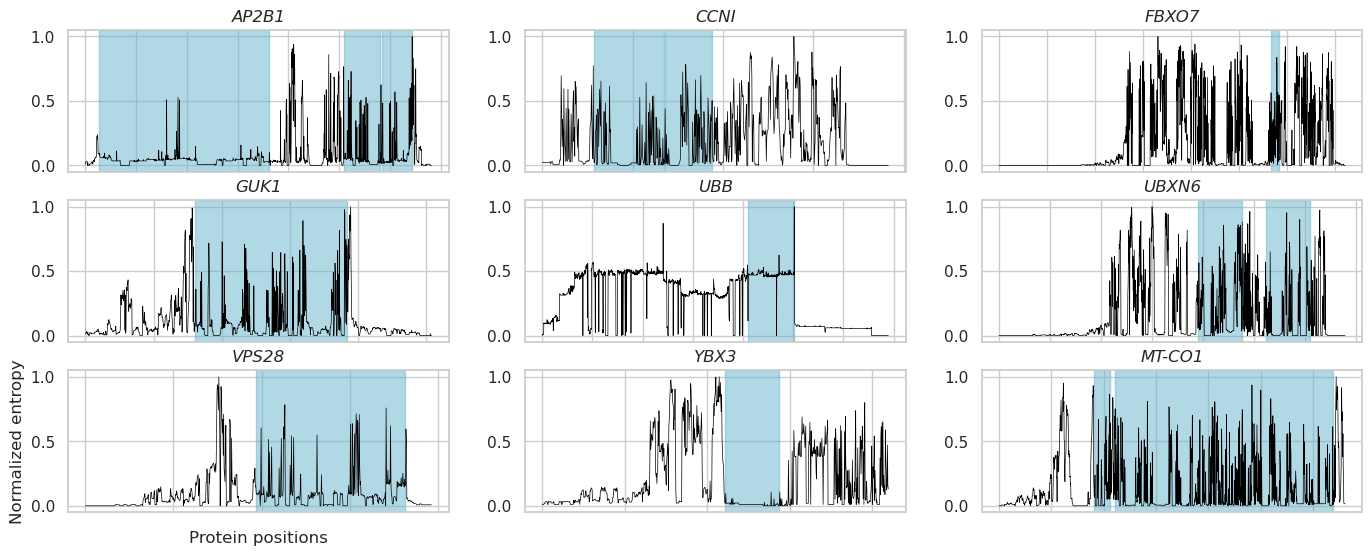

In [882]:
fig = plt.figure(figsize=(8.35*2,8.35*3/4))
path = '/mnt/d/housekeeping_genes/orthology/new_analysis_7_9_2024/'
# for i,f in enumerate([f for f in os.listdir(path) if f.endswith('.afa')]):
for i,g in enumerate(genes):
    if i == 0:
        ax=fig.add_subplot(3,3,1+i)
    else:
        ax=fig.add_subplot(3,3,1+i, sharey=ax)
    # ax_cum = ax.twinx()
    # fasta = os.path.join(path,g,'data/one_seq_rna.afa')
    fasta = os.path.join(path,g,'data/one_seq_protein.afa')
    alignment = AlignIO.read(os.path.join(path,g,'data/one_seq_protein.afa'), 'fasta')
    # with open(fasta, 'r') as fastaobject:
    #     headers, sequences = [], []
    #     hs = False
    #     for line in fastaobject:
    #         if line.startswith('>'):
    #             head = line.replace('>','').strip()
    #             headers.append(head)
    #             sequences.append('')
    #             if 'organism=Homo sapiens' in line:
    #                 hs = True
    #         else :
    #             seq = line.strip()
    #             if len(seq) > 0:
    #                 sequences[-1] += seq
    
    # instances = [aln.seq for aln in alignment]#[Seq(s) for s in sequences]
    # m = motifs.create(instances)
    # entropy_list = m.relative_entropy

    df = pd.DataFrame([aln.seq for aln in alignment], index=[aln.id for aln in alignment])
    # df = pd.DataFrame([list(seq) for seq in sequences], index=headers)
    entropy_list = []
    for c in df.columns:
        # entropy_list.append(entropy(np.unique(df.loc[df[c]!='-',c], return_counts=True)[1]/np.unique(df.loc[df[c]!='-',c], return_counts=True)[1].sum(), base=2))
        entropy_list.append(entropy(np.unique(df.loc[:,c], return_counts=True)[1]/np.unique(df.loc[:,c], return_counts=True)[1].sum(), base=2))
    entropy_list = np.array(entropy_list).reshape(-1, 1)
    entropy_list = MinMaxScaler().fit_transform(entropy_list).reshape( len(df.columns) )
    # entropy_list = MinMaxScaler().fit_transform(entropy_list.reshape(-1, 1)).reshape(len(entropy_list))
    # entropy_list = np.abs(entropy_list - 1)
    # entropy_list = 1-entropy_list
    
    # ax.bar(x=df.columns, height=entropy_list, color='black')
    # sns.kdeplot(entropy_list, ax=ax)
    ax.plot(range(len(entropy_list)), entropy_list, lw=.5, color='black')
    # median_ = np.quantile(entropy_list,.5)
    # ax.axvline(median_, ls='--', lw=3, color='black', label='median = '+str(np.round(median_,2)))
    # sns.histplot(entropy_list, cumulative=True, color='black',element="step", fill=False, ax=ax_cum)
    ax.set_title(g.upper(), style='italic')#+': '+str(len(df.columns))+' sites in '+str(len(df.index))+ ' species\n')
    # ax.set_xlabel('')#Normalized entropy')
    ax.set_xticklabels([])
    if i in [6]:
        ax.set_ylabel('Normalized entropy')
    else:
        ax.set_ylabel('')
    if i in [6]:
        ax.set_xlabel('Protein positions')
    else:
        ax.set_xlabel('')

    # if i not in [0,3,6]:
    #     ax.set_yticklabels([])

    # legend_ot = [mpatches.Patch(color=c, label=l, ls='--', fill=False) for l,c in zip(['median'],['black'])]
    # l2=ax.legend(loc='upper right')#,handles=legend_ot,frameon=False)
    # l2.set_title(title='Time Point')

    if g == 'AP2B1':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [11, 534, 731, 831, 840, 950])]
    elif g == 'CCNI':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [44, 142, 146, 218])]
    elif g == 'FBXO7':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [332, 376])]
    elif g == 'GUK1':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [26, 208])]
    elif g == 'UBB':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [1, 228])]
    elif g == 'UBXN6':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [158, 263, 336, 409])]
    elif g == 'VPS28':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [39, 219])]
    elif g == 'YBX3':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [91, 160])]
    elif g == 'MT-CO1':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [32, 69, 89, 575])]
        
# fig.tight_layout()
# fig.savefig('/mnt/d/housekeeping_genes/entropy_conservative_sites.pdf', format='pdf', dpi=300)

# GSEA enrichment analysis

In [227]:
import gseapy as gp
from gseapy import barplot, dotplot

In [228]:
adata

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'arcsinh_per_louvain_group', 'count', 'log1p', 'log1p_per_louvain_group', 'trns_expr', 'trns_expr_per_louvain_group'

In [229]:
gene_list = adata.var.loc[genes,].sort_values('pool_cv').index.tolist()#data[data.Estudo=='GSE129166'].sort_values('CV').Genes.values.tolist()
gene_sets = ['GO_Molecular_Function_2023','GO_Biological_Process_2023']#,'KEGG_2021_Human']#
background = adata.var.index.tolist()#res_dict[rk].dropna(subset='padj').index.tolist()

In [323]:
enr = gp.enrichr(gene_list=gene_list+['COX1','COX-1'], # or "./tests/data/gene_list.txt",
                 gene_sets=gene_sets,
                 organism='homo sapiens', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                 background=background,
                )

In [329]:
res = enr.results.copy()
res['qty_genes'] = res.Genes.str.split(';').apply(len)
res['GO'] = res.Term.str.split('(').str[-1].str.replace(')','', regex=False).values
res['Term_2'] = res.Term.str.split('(').str[0].values
res['-log10(p-adj)'] = -np.log10(res['Adjusted P-value'])

In [335]:
res = pd.concat([res[(res['P-value']<=0.05) & (res['Gene_set']=='GO_Molecular_Function_2023')].sort_values('P-value', ascending=True),
                 res[(res['P-value']<=0.05) & (res['Gene_set']=='GO_Biological_Process_2023')].sort_values('P-value', ascending=True).drop_duplicates(subset='Genes')])
res['Gene_set'] = res.Gene_set.map({'GO_Molecular_Function_2023':'GO MF','GO_Biological_Process_2023':'GO BP'})

In [326]:
res['Term_2'] = res.Term_2.str.replace('Kinase Activity', 'KA')
res['Term_2'] = res.Term_2.str.replace('Catabolic Process', 'CP')
res['Term_2'] = res.Term_2.str.replace('Metabolic Process', 'MP')
res['Term_2'] = res.Term_2.str.replace('Ligase Binding', 'LB')
res['Term_2'] = res.Term_2.str.replace('Regulation', 'Reg.')
res['Term_2'] = res.Term_2.str.replace('Cyclin-Dependent Protein Serine/Threonine Kinase Regulator Activity', 'Serine/Threonine KA Regulator')
res['Term_2'] = res.Term_2.str.replace('Positive Reg. Of Intrinsic Apoptotic Signaling Pathway By P53 Class Mediator ', 'Reg. Of Intrinsic Apoptotic Signaling')
res['Term_2'] = res.Term_2.str.replace('Reg. Of Plasma Membrane Bounded Cell Projection Organization', 'Reg. Of Plasma Membrane')
res['Term_2'] = res.Term_2.str.replace('Endosome Transport Via Multivesicular Body Sorting Pathway', 'Endosome Transport')

/tmp/ipykernel_709909/1064003882.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  res['Term_2'] = res.Term_2.str.replace('Positive Reg. Of Intrinsic Apoptotic Signaling Pathway By P53 Class Mediator ', 'Reg. Of Intrinsic Apoptotic Signaling')
/tmp/ipykernel_709909/1064003882.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  res['Term_2'] = res.Term_2.str.replace('Reg. Of Plasma Membrane Bounded Cell Projection Organization', 'Reg. Of Plasma Membrane')


In [336]:
for t in res.Term_2:
    print(t)

Ubiquitin Binding 
Guanylate Kinase Activity 
Nucleoside Monophosphate Kinase Activity 
Ubiquitin Protein Ligase Binding 
Clathrin Adaptor Activity 
Ubiquitin-Like Protein Ligase Binding 
Cyclin-Dependent Protein Serine/Threonine Kinase Regulator Activity 
Positive Regulation Of Intrinsic Apoptotic Signaling Pathway By P53 Class Mediator 
Purine-Containing Compound Metabolic Process 
Regulation Of Protein Catabolic Process 
Macroautophagy 
Hyperosmotic Response 
Regulation Of Plasma Membrane Bounded Cell Projection Organization 
Positive Regulation Of Endocytosis 
Modification-Dependent Protein Catabolic Process 
Presynaptic Endocytosis 
Endosome Transport Via Multivesicular Body Sorting Pathway 
Proteasomal Protein Catabolic Process 
Regulation Of Cyclin-Dependent Protein Kinase Activity 


Text(0, 0.5, '')

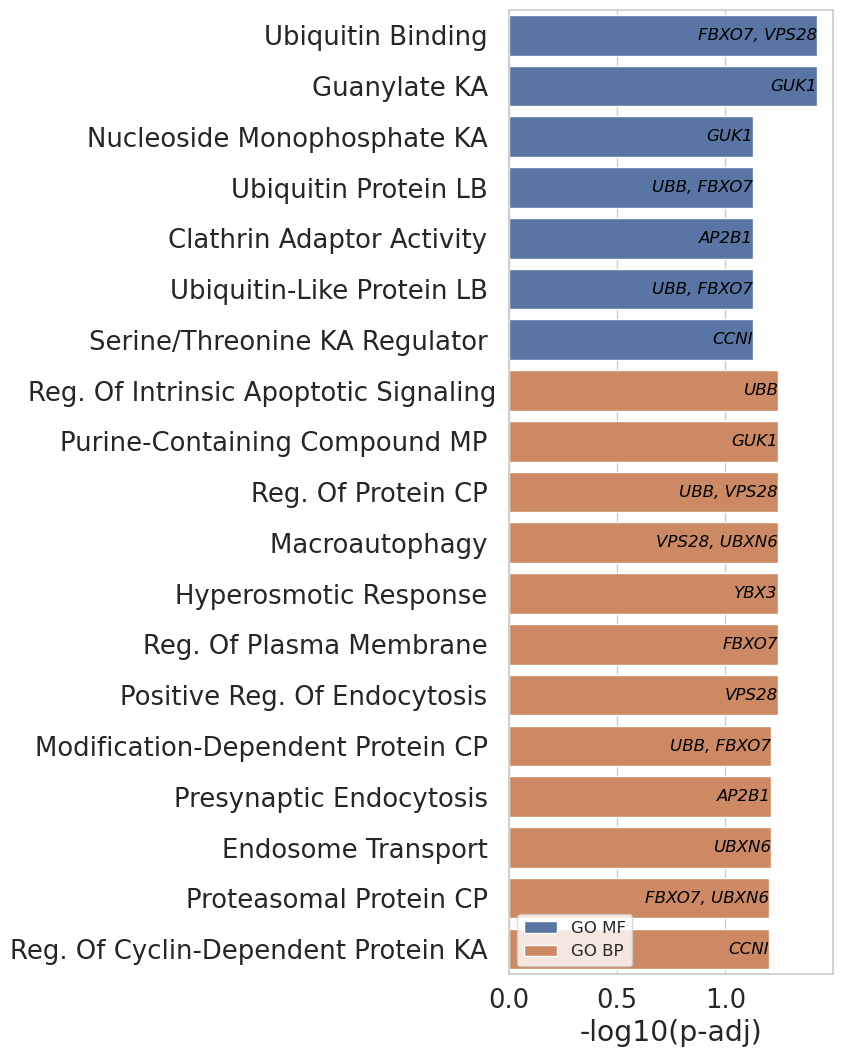

In [328]:
fig = plt.figure(figsize=(8.35*1/2,8.35*3/2))
ax = fig.add_subplot(111)

plots = sns.barplot(y='Term_2', x='-log10(p-adj)', hue='Gene_set', dodge=False, data=res, ax=ax)
ax.legend(loc='lower left', fontsize=12)

texts=[]
for y,x,l in res[['-log10(p-adj)','Genes']].reset_index(drop=True).reset_index().values:
    texts.append(ax.text(x,y,l.replace(';',', '), ha='right', va='center', color='black', fontsize=12, style='italic'))
ax.set_ylabel('')

# plt.tight_layout()

# GTEX - Expression Atlas

In [800]:
aux = []
for f in [f for f in os.listdir('/mnt/d/housekeeping_genes/GTEX_expression_atlas/') if f.endswith('expression_atlas-homo_sapiens.tsv')]:
    df_aux = pd.read_csv('/mnt/d/housekeeping_genes/GTEX_expression_atlas/'+f, sep='\t', skiprows=[0,1,2,3], index_col=0).loc[['GTEX - organism part']]
    df_aux = pd.concat([df_aux.mean(), df_aux.count()], axis=1)
    df_aux.columns = ['Mean','Count']
    df_aux['Gene'] = f.split('_')[0]
    df_aux = df_aux[df_aux.Mean>0]
    aux.append(df_aux)

df_atlas = pd.concat(aux).reset_index()
df_atlas = df_atlas.pivot(columns='index', index='Gene', values='Mean')
df_atlas.iloc[:,:] = StandardScaler().fit_transform(df_atlas.T).T

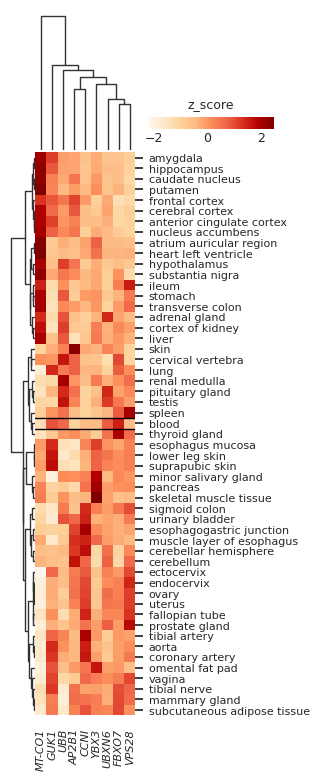

In [896]:
# fig = plt.figure(figsize=(8.35*1/2,8.35*2/3))
g = sns.clustermap(df_atlas.T, cmap='OrRd',figsize=(8.35*1/2,8.35),
                   method='ward',tree_kws={'lw':1},z_score=0, #dendrogram_ratio=.1,
                   # cbar_pos=(0.02, .45, 0.01, 0.25),
                   cbar_pos=(0.375, .835, 0.3, 0.015),
                   cbar_kws={"orientation": "horizontal"}, 
                   yticklabels=1)  #  method='ward')#, #dendrogram_ratio=.1, cbar_pos=(.99, 0.35, 0.01, .5), 

for label in g.ax_heatmap.get_xticklabels():
    label.set_fontsize(8)#, style='italic')
    label.set_fontstyle('italic')
for label in g.ax_heatmap.get_yticklabels():
    label.set_fontsize(8)
# for label in g.ax_heatmap.get_xticklabels(): 
#     label.set_text( '')#label.get_text().title() )
g.ax_heatmap.axhline(25, ls='-', lw=1, color='black')
g.ax_heatmap.axhline(26, ls='-', lw=1, color='black')
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
# g.ax_heatmap.xaxis.set_tick_params(axis='both', labelsize=9)
g.ax_cbar.set_title('z_score', fontsize=9)
g.ax_cbar.xaxis.set_tick_params(labelsize=9, length=-2)
g.ax_cbar.xaxis.set_ticks_position('none') 

# Find biomarkers in
RNA-SEQ GSE175718

## Read adata with all genes

In [9]:
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']

In [10]:
df_gens = pd.read_csv('/mnt/d/postransplant_cristian_colab/GSE15296/GSE15296_mygene_translation.csv', index_col=0, header=None, names=['GeneNames','TranslationStatus'])

df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'GeneNames'] = 'MT-CO1'
df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'TranslationStatus'] = 'ok'

df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'GeneNames'] = 'UBXN6'
df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'TranslationStatus'] = 'ok'

In [11]:
adata_ml = ad.read_h5ad('/mnt/d/housekeeping_genes/adata_RNAseq_louvain.h5ad')

# Keep only samples from study GSE175718
# Keep genes present on Macroarray datasets
adata_ml = adata_ml[adata_ml.obs.gse=='GSE175718',
                    adata_ml.var.index.isin(df_gens[df_gens.TranslationStatus=='ok'].GeneNames.unique())]

# Rename housekeeping genes from equivalent vs non_equivalent
adata_ml.var.equivalent = adata_ml.var.equivalent.astype(str)
adata_ml.var.loc[genes, 'equivalent'] = 'housekeeping_genes'
adata_ml.var.equivalent = adata_ml.var.equivalent.astype('category')

# Exclude equivalent genes to find biomarkers
adata_ml = adata_ml[:,adata_ml.var.equivalent!='equivalent']
adata_ml

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  self[name] = value


View of AnnData object with n_obs × n_vars = 384 × 16954
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

# Machine learning modeling

In [508]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV , cross_validate, KFold, ShuffleSplit, GroupKFold, LeaveOneOut, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import Pipeline

import hdbscan

In [13]:
# Markers from paper of this dataser
mkr = ['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']
gn = np.where(adata_ml.var.index.isin(mkr))[0]

## Detect outliers with HDBSCAN

In [14]:
ol_detection = hdbscan.HDBSCAN().fit(adata_ml.X)
print(np.unique(ol_detection.labels_, return_counts=True))
adata_ml.obs.loc[:,'outliers_hdbscan'] = ol_detection.labels_

(array([-1,  0,  1]), array([  5, 351,  28]))


/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


We excluded SRR14675592 because it is only zeros for hkg

In [15]:
adata_ml[adata_ml.obs.index=='SRR14675592', gn].X

ArrayView([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
adata_ml.obs.loc[adata_ml.obs.index=='SRR14675592','outliers_hdbscan'] = -1

In [17]:
adata_ml.obs.groupby('outliers_hdbscan').count()

abmrh  tcmr   ar  gse  gse_time  gse_patient  louvain_group  \
outliers_hdbscan                                                                
-1                    6     6    6    6         6            6              6   
 0                  351   351  351  351       351          351            351   
 1                   27    27   27   27        27           27             27   

                  UMAP_1  UMAP_2  
outliers_hdbscan                  
-1                     6       6  
 0                   351     351  
 1                    27      27

## Excluding outliers

In [18]:
adata_ml = adata_ml[adata_ml.obs.outliers_hdbscan!=-1]

## Calculate regular normalization methods (TMM, MRN, TPM)

In [19]:
# Normalize by MRN
adata_ml.obs.loc[:,'type'] = adata_ml.obs.gse.map({'GSE175718': 'MRN'})#, 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})
trns_dict = dict(adata_ml.obs[['gse','type']].values)
hkg.pp.transform_exprs(adata_ml, layer='count', groups_col='gse', trns_dict=trns_dict)
adata_ml.layers['MRN'] = adata_ml.layers['trns_expr']

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


In [20]:
# Normalize by TMM
adata_ml.obs.loc[:,'type'] = adata_ml.obs.gse.map({'GSE175718': 'TMM'})#, 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})
trns_dict = dict(adata_ml.obs[['gse','type']].values)
hkg.pp.transform_exprs(adata_ml, layer='count', groups_col='gse', trns_dict=trns_dict)
adata_ml.layers['TMM'] = adata_ml.layers['trns_expr']

/tmp/ipykernel_1429/1894685971.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata_ml.obs.loc[:,'type'] = adata_ml.obs.gse.map({'GSE175718': 'TMM'})#, 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})


In [21]:
# Normalize TMM to log(TMM) using arcsinh transformation
hkg.pp.log_transform(adata_ml, layer=None, method='arcsinh')

# TPM
adata_ml.layers['TPM'] = adata_ml.X

# TMM + 1
adata_ml.layers['TPM1p'] = 1 + adata_ml.X

In [22]:
adata_ml

AnnData object with n_obs × n_vars = 378 × 16954
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

In [23]:
adata_ml.var.index.nunique()

16954

## Excluding genes with zeros expression in half of samples in each condition at same time

In [26]:
adata_ml.obs.groupby('ar').count()

abmrh  tcmr  gse  gse_time  gse_patient  louvain_group  UMAP_1  UMAP_2  \
ar                                                                           
0     243   243  243       243          243            243     243     243   
1     135   135  135       135          135            135     135     135   

    outliers_hdbscan  type  
ar                          
0                243   243  
1                135   135

In [27]:
md_0 = np.median((adata_ml[adata_ml.obs.ar=='0',:].X==0).sum(axis=0))
md_1 = np.median((adata_ml[adata_ml.obs.ar=='1',:].X==0).sum(axis=0))

set_0 = set(adata_ml[:,(adata_ml[adata_ml.obs.ar=='0',:].X==0).sum(axis=0) >= md_0].var.index)
set_1 = set(adata_ml[:,(adata_ml[adata_ml.obs.ar=='1',:].X==0).sum(axis=0) >= md_1].var.index)

len(set_0), len(set_1), len(set_0.intersection(set_1))

(8491, 8488, 8372)

In [28]:
adata_ml = adata_ml[:, list(set(adata_ml.var.index).difference( set_0.intersection(set_1) ))]

In [29]:
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 8582
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

## Excluding high correlated/redundat genes

In [30]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples, silhouette_score

In [31]:
# https://stackoverflow.com/questions/5323818/condensed-matrix-function-to-find-pairs
def row_col_from_condensed_index(d,index):
    b = 1 - (2 * d) 
    i = (-b - np.sqrt(b ** 2 - 8 * index)) // 2
    j = index + i * (b + i + 2) // 2 + 1
    return [int(i),int(j)]

In [32]:
t1 = time.time()
corr_0 = pdist(adata_ml[adata_ml.obs.ar=='0',:].X.T, 'correlation')
# corr_0 = squareform(corr_0)
# corr_0 = pd.DataFrame(corr_0, columns=adata_ml.var.index.values, index=adata_ml.var.index.values)
corr_1 = pdist(adata_ml[adata_ml.obs.ar=='1',:].X.T, 'correlation')
# corr_1 = squareform(corr_1)
# corr_1 = pd.DataFrame(corr_1, columns=adata_ml.var.index.values, index=adata_ml.var.index.values)
t2 = time.time()
print((t2-t1)/60, 'min')

0.04027612209320068 min


In [103]:
# t1 = time.time()
# # hc_0 = sch.linkage(adata_ml[adata_ml.obs.ar=='0',:].X.T, method='average', metric='correlation')
# pdist_0 = pdist(adata_ml[adata_ml.obs.ar=='0',:].X.T, 'correlation')
# hc_0 = sch.average(pdist_0)
# # pdist_0 = squareform(pdist_0)

# pdist_1 = pdist(adata_ml[adata_ml.obs.ar=='1',:].X.T, 'correlation')
# hc_1 = sch.average(pdist_1)
# # pdist_1 = squareform(pdist_1)

# t2 = time.time()
# print((t2-t1)/60, 'min')

In [104]:
# df_hc_0 = pd.DataFrame(hc_0, columns=['c1','c2','distance','size'])
# df_hc_0[['c1','c2','size']] = df_hc_0[['c1','c2','size']].astype(int)

# df_hc_1 = pd.DataFrame(hc_1, columns=['c1','c2','distance','size'])
# df_hc_1[['c1','c2','size']] = df_hc_1[['c1','c2','size']].astype(int)

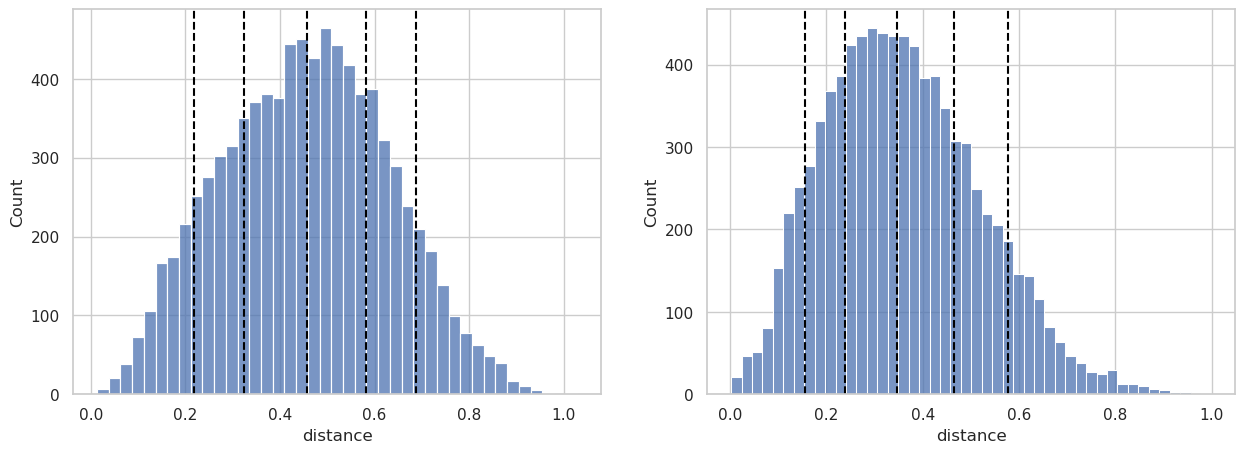

In [84]:
fig = plt.figure(figsize=(15,5))
ax_0 = fig.add_subplot(121)
ax_1 = fig.add_subplot(122)
sns.histplot(x='distance', data=df_hc_0, ax=ax_0)
sns.histplot(x='distance', data=df_hc_1, ax=ax_1)

for q in [.10, .25, .5, .75, .9]:
    ax_0.axvline( np.quantile(df_hc_0.distance.values, q), ls='--', color='black' )
    ax_1.axvline( np.quantile(df_hc_1.distance.values, q), ls='--', color='black' )


<Axes: xlabel='hc_0_t_09', ylabel='median_0'>

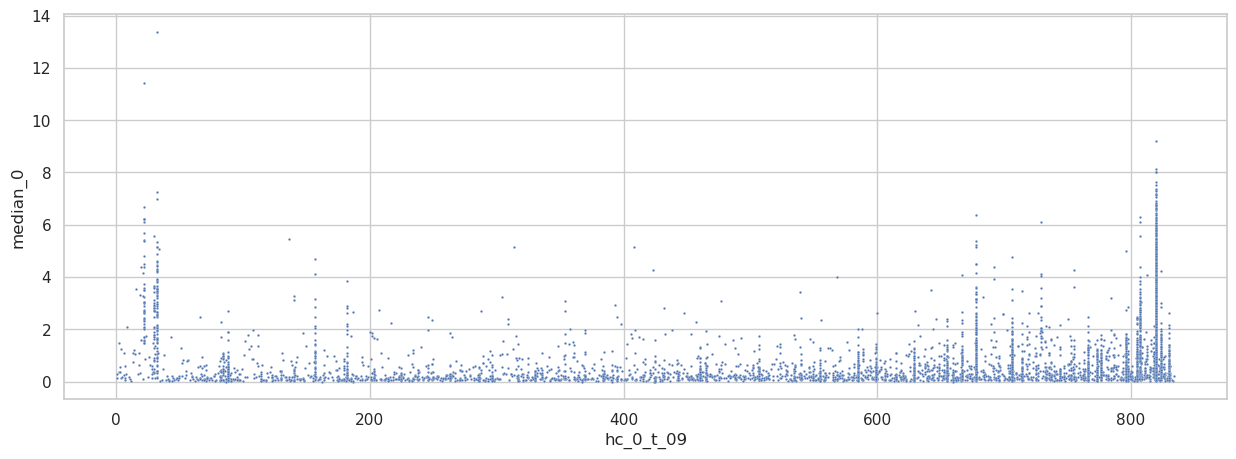

In [106]:
fig = plt.figure(figsize=(15,5))
sns.scatterplot(x='hc_0_t_09',y='median_0',s=3,data=adata_ml.var)

In [ ]:
# t1 = time.time()
# groups_0 = hdbscan.HDBSCAN().fit(pdist_0)
# groups_1 = hdbscan.HDBSCAN().fit(pdist_1)
# t2 = time.time()
# print((t2-t1)/60, 'min')

In [105]:
# t1 = time.time()

# silhouette_avg = dict()
# for t in steps_t:
#     cluster_labels = sch.fcluster(hc_0, t=t, criterion='maxclust')
#     silhouette_avg[t] = silhouette_score(pdist_0, cluster_labels, metric='precomputed')


# # hc_1 = sch.linkage(adata_ml[adata_ml.obs.ar=='1',:].X.T, method='average', metric='correlation')


# # adata_ml.var['hc1_corr_t20'] = sch.fcluster(hc, t=30, criterion='maxclust')

# t2 = time.time()
# print((t2-t1)/60, 'min')

In [61]:
# silhouette_avg

In [47]:
pdist_0.shape

(36821071,)

In [46]:
pdist_0[36821071]

IndexError: index 36821071 is out of bounds for axis 0 with size 36821071

In [173]:
# x,y  =  np.unique(sch.fcluster(hc, t=8000, criterion='distance'), return_counts=True)
x,y  =  np.unique(sch.fcluster(hc, t=100, criterion='maxclust'), return_counts=True)

/tmp/ipykernel_11349/282835963.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_ml.var['hc0_t20'] = sch.fcluster(hc, t=20, criterion='maxclust')


In [180]:
adata_ml.var.hc0_t20.unique()

array([ 3,  2, 19, 15,  7, 20, 14,  4, 12, 10,  8, 18,  1, 11,  5, 17, 13,
       16,  6,  9], dtype=int32)

In [150]:
# fig = plt.figure(figsize=(25,10))
# dn = sch.dendrogram(hc,distance_sort='ascending')#, color_threshold=29451)

In [168]:
# df_hc = pd.DataFrame(hc, columns=['c1','c2','distance','size'])
# df_hc[['c1','c2','size']] = df_hc[['c1','c2','size']].astype(int)

In [169]:
# sns.scatterplot(x='distance',y='size', data=df_hc[df_hc.distance<10000])

In [157]:
df_hc.distance.max()#[(df_hc['size']>=10) & (df_hc['size']<=20)].sort_values('distance')

5269463.466028247

In [40]:
adata_ml[adata_ml.obs.ar=='0',:].X.shape

(243, 8582)

In [33]:
t1 = time.time()
ind_genes_0 = []
for i in np.where(corr_0<=0.1)[0]:
    ind_genes_0.extend(row_col_from_condensed_index(8582, i))
ind_genes_0 = set(ind_genes_0)

ind_genes_1 = []
for i in np.where(corr_1<=0.1)[0]:
    ind_genes_1.extend(row_col_from_condensed_index(8582, i))
ind_genes_1 = set(ind_genes_1)

t2 = time.time()
print((t2-t1)/60, 'min')

0.0008200446764628093 min


In [34]:
len(ind_genes_0), len(ind_genes_1), len(ind_genes_0.intersection(ind_genes_1))

(170, 540, 141)

In [35]:
adata_ml_corr = adata_ml[:,list(set(adata_ml[:,list((ind_genes_0.intersection(ind_genes_1)))].var.index).union( set(genes+mkr) ))]
adata_ml_corr

View of AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

In [36]:
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 8582
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

In [274]:
# keep = []
# exclude = []
# nan_list = []
# p_list = []
# threshold = 0.7
# t1 = time.time()
# cols = adata_ml.var.index.tolist()[:500]
# for i in range(len(cols)):
#     if i in exclude:
#         continue
#     else:
#         keep.append(i)
        
#     for j in range(i+1,len(cols)):#cols[i+1:]:
#         p = np.abs(pearsonr(adata_ml[adata_ml.obs.ar=='0',i].X.flatten(), adata_ml[adata_ml.obs.ar=='0',j].X.flatten()).statistic)
#         # p_list.append(p)
#         if (np.isnan(p)) or (p >= threshold):
#             if j in exclude:
#                 continue
#             else:
#                 exclude.append(j)

# t2 = time.time()
# print((t2-t1)/60, 'min')

## Calculate RMS, HA with hkg and other normalizations

In [37]:
hkg_sets = [['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1'],
            ['VPS28','MT-CO1'],['UBXN6','GUK1'],['FBXO7','CCNI'],['FBXO7','CCNI','YBX3'],
            ['UBB'],['AP2B1'],['YBX3'],['UBB','AP2B1','YBX3']]

adata_aux = adata_ml_corr.copy()

for i,s in enumerate(hkg_sets):
# Root Mean Square (RMS)
    if i == 0:
        adata_aux.layers['rms_all'] = (np.sqrt((np.square(adata_aux[:,s].layers['arcsinh']).sum(axis=1))/len(s)) - adata_aux.layers['arcsinh'].T).T
        adata_aux.layers['hm_all'] = ((1/(1/adata_aux[:,s].layers['arcsinh']).sum(axis=1)) - adata_aux.layers['arcsinh'].T).T
        
        adata_aux.obs['fs_mean_arcs'] = adata_aux[:,adata_aux.var.index.isin(s)].layers['arcsinh'].mean(axis=1).tolist()
        adata_aux.layers['all_mean_arcs_norm_diff'] = (adata_aux.layers['arcsinh'].T - adata_aux.obs.fs_mean_arcs.values).T

        for pair in itertools.combinations(s, 2):            
            adata_aux.layers['arcsinh'+'_'+'_'.join(pair)] = (adata_aux.layers['arcsinh'] - adata_aux[:,pair[1]].layers['arcsinh'] )/(adata_aux[:,pair[0]].layers['arcsinh'] - adata_aux[:,pair[1]].layers['arcsinh'])
            adata_aux.obs['fs_mean_arcs'] = adata_aux[:,adata_aux.var.index.isin(pair)].layers['arcsinh'].mean(axis=1).tolist()
            adata_aux.layers['pair_arcs'+'_'+'_'.join(pair)+'_diff'] = (adata_aux.layers['arcsinh'].T - adata_aux.obs.fs_mean_arcs.values).T
            
        for g in s:
            adata_aux.layers['diff_'+g] = adata_aux[:,g].layers['arcsinh'] - adata_aux.layers['arcsinh']
    elif len(s) >= 2:
        adata_aux.layers['rms_'+'_'.join(s)] = (np.sqrt( ((np.square(adata_aux[:,s].layers['arcsinh']).sum(axis=1)) + np.square(adata_aux.layers['arcsinh'].T))/(len(s)+1) )).T
        adata_aux.layers['hm_'+'_'.join(s)] = ((len(s)+1)/ ((1/adata_aux[:,s].layers['arcsinh']).sum(axis=1) + (1/adata_aux.layers['arcsinh'].T)) ).T
        

# Harmonic Mean (HM)
    # if i == 0:
    #     adata_aux.layers['hm_all'] = ((1/(1/adata_aux[:,s].layers['arcsinh']).sum(axis=1)) - adata_aux.layers['arcsinh'].T).T
    #     for g in s:
    #         adata_aux.layers['hm_2_'+g] = (2/ ((1/adata_aux[:,g].layers['arcsinh']).sum(axis=1) + (1/adata_aux.layers['arcsinh'].T)) ).T
    # else:
    #     # adata_ml.layers['hm_'+'_'.join(s)] = ((1/(1/adata_ml[:,s].layers['arcsinh']).sum(axis=1)) - adata_ml.layers['arcsinh'].T).T
    #     adata_aux.layers['hm_'+'_'.join(s)] = ((len(s)+1)/ ((1/adata_aux[:,s].layers['arcsinh']).sum(axis=1) + (1/adata_aux.layers['arcsinh'].T)) ).T
        
#     if i == 0:
#         adata_aux.obs['fs_mean_log'] = np.log(adata_aux[:,adata_aux.var.index.isin(s)].layers['TPM']+1).mean(axis=1).tolist()
#         adata_aux.layers['all_mean_log_norm_div'] = (np.log(adata_aux.layers['TPM']+1).T / adata_aux.obs.fs_mean_log.values).T
#         adata_aux.layers['all_mean_log_norm_diff'] = (np.log(adata_aux.layers['TPM']+1).T - adata_aux.obs.fs_mean_log.values).T
#     else:
#         adata_aux.obs['fs_mean_log'] = np.log(adata_aux[:,adata_aux.var.index.isin(s)].layers['TPM']+1).mean(axis=1).tolist()
#         adata_aux.layers['_'.join(s)+'_mean_log_norm_div'] = (np.log(adata_aux.layers['TPM']+1).T / adata_aux.obs.fs_mean_log.values).T
#         adata_aux.layers['all_mean_log_norm_diff'] = (np.log(adata_aux.layers['TPM']+1).T - adata_aux.obs.fs_mean_log.values).T

#     if i == 0:
#         adata_aux.obs['fs_mean_arcs'] = adata_aux[:,adata_aux.var.index.isin(s)].layers['arcsinh'].mean(axis=1).tolist()
#         adata_aux.layers['all_mean_arcs_norm_div'] = (adata_aux.layers['arcsinh'].T / adata_aux.obs.fs_mean_log.values).T
#         adata_aux.layers['all_mean_arcs_norm_diff'] = (adata_aux.layers['arcsinh'].T - adata_aux.obs.fs_mean_log.values).T
#     else:
#         adata_aux.obs['fs_mean_arcs'] = adata_aux[:,adata_aux.var.index.isin(s)].layers['arcsinh'].mean(axis=1).tolist()
#         adata_aux.layers['_'.join(s)+'_mean_arcs_norm_div'] = (adata_aux.layers['arcsinh'].T / adata_aux.obs.fs_mean_log.values).T
#         adata_aux.layers['all_mean_arcs_norm_diff'] = (adata_aux.layers['arcsinh'].T - adata_aux.obs.fs_mean_log.values).T
#     if i == 0:
#         adata_aux.layers['arcsinh_wmean_all'] = ((adata_aux.layers['arcsinh'].T + adata_aux[:,s].layers['arcsinh'].mean(axis=1))/2).T
#     else:
#         adata_aux.layers['arcsinh_wmean_'+'_'.join(s)] = ((adata_aux.layers['arcsinh'].T + adata_aux[:,s].layers['arcsinh'].mean(axis=1))/2).T
        
#     if i == 0:
#         for pair in itertools.combinations(s, 2):
#             adata_aux.layers['arcsinh_wmean_pair_'+'_'.join(pair)] = ((adata_aux.layers['arcsinh'].T + adata_aux[:,pair].layers['arcsinh'].mean(axis=1))/2).T
            
#             adata_aux.layers['arcsinh_max'+'_'+'_'.join(pair)] = (adata_aux.layers['arcsinh'].T - adata_aux[:,pair].layers['arcsinh'].max(axis=1) ).T/np.abs(adata_aux[:,pair[0]].layers['arcsinh'] - adata_aux[:,pair[1]].layers['arcsinh'])
#             # adata_ml.layers['arcsinh_max'+'_'+'_'.join(pair)] = (adata_ml.layers['arcsinh'].T - adata_ml[:,pair].layers['arcsinh'].max(axis=1) ).T/(adata_ml[:,pair[0]].layers['arcsinh'] - adata_ml[:,pair[1]].layers['arcsinh'])

#             adata_aux.layers['arcsinh'+'_'+'_'.join(pair)] = (adata_aux.layers['arcsinh'] - adata_aux[:,pair[1]].layers['arcsinh'] )/(adata_aux[:,pair[0]].layers['arcsinh'] - adata_aux[:,pair[1]].layers['arcsinh'])
#             # adata_ml.layers['arcsinh'+'_'+'_'.join(pair)] = (adata_ml.layers['arcsinh'] - adata_ml[:,pair[1]].layers['arcsinh'] )/(adata_ml[:,pair[0]].layers['arcsinh'] - adata_ml[:,pair[1]].layers['arcsinh'])

#             # adata_ml.layers['TPM_max'+'_'+'_'.join(pair)] = (adata_ml.layers['TPM'].T - adata_ml[:,pair].layers['TPM'].max(axis=1) ).T/ np.abs(adata_ml[:,pair[0]].layers['TPM'] - adata_ml[:,pair[1]].layers['TPM'])
#             adata_aux.layers['TPM'+'_'+'_'.join(pair)] = (adata_aux.layers['TPM'] - adata_aux[:,pair[1]].layers['TPM'] )/(adata_aux[:,pair[0]].layers['TPM'] - adata_ml[:,pair[1]].layers['TPM'])

#             adata_aux.obs['fs_mean_arcs'] = adata_aux[:,adata_aux.var.index.isin(pair)].layers['arcsinh'].mean(axis=1).tolist()
#             adata_aux.layers['pair_arcs'+'_'+'_'.join(pair)+'_div'] = (adata_aux.layers['arcsinh'].T / adata_aux.obs.fs_mean_arcs.values).T
#             adata_aux.layers['pair_arcs'+'_'+'_'.join(pair)+'_diff'] = (adata_aux.layers['arcsinh'].T - adata_aux.obs.fs_mean_arcs.values).T

#             # adata_ml.obs['fs_mean_arcs'] = adata_ml[:,adata_ml.var.index.isin(pair)].layers['TPM'].mean(axis=1).tolist()
#             # adata_ml.layers['pair_tpm'+'_'+'_'.join(pair)+'_div'] = (adata_ml.layers['TPM'].T / adata_ml.obs.fs_mean_arcs.values).T
#             # adata_ml.layers['pair_tpm'+'_'+'_'.join(pair)+'_diff'] = (adata_ml.layers['TPM'].T - adata_ml.obs.fs_mean_arcs.values).T
# # # Root Mean Square (RMS)
# # for i,s in enumerate(hkg_sets):
# #     if i == 0:
# #         adata_ml.layers['rms_all'] = np.sqrt( (np.square(adata_ml.layers['arcsinh']).T + (np.square(adata_ml[:,s].layers['arcsinh']).sum(axis=1)))/(len(s)+1) ).T
# #     else:
# #         adata_ml.layers['rms_'+'_'.join(s)] = np.sqrt( (np.square(adata_ml.layers['arcsinh']).T + (np.square(adata_ml[:,s].layers['arcsinh']).sum(axis=1)))/(len(s)+1) ).T

# # # Harmonic Mean (HM)
# # for i,s in enumerate(hkg_sets):
# #     if i == 0:
# #         adata_ml.layers['hm_all'] = (1/(1/adata_ml.layers['arcsinh']).T + (1/adata_ml[:,s].layers['arcsinh']).sum(axis=1)).T 
# #     else:
# #         adata_ml.layers['hm_'+'_'.join(s)] = (1/(1/adata_ml.layers['arcsinh']).T + (1/adata_ml[:,s].layers['arcsinh']).sum(axis=1)).T 

adata_ml_corr = adata_aux.copy()
del(adata_aux)

/tmp/ipykernel_1429/1244494380.py:25: RuntimeWarning: divide by zero encountered in divide
  adata_aux.layers['hm_'+'_'.join(s)] = ((len(s)+1)/ ((1/adata_aux[:,s].layers['arcsinh']).sum(axis=1) + (1/adata_aux.layers['arcsinh'].T)) ).T
/tmp/ipykernel_1429/1244494380.py:25: RuntimeWarning: divide by zero encountered in divide
  adata_aux.layers['hm_'+'_'.join(s)] = ((len(s)+1)/ ((1/adata_aux[:,s].layers['arcsinh']).sum(axis=1) + (1/adata_aux.layers['arcsinh'].T)) ).T
/tmp/ipykernel_1429/1244494380.py:25: RuntimeWarning: divide by zero encountered in divide
  adata_aux.layers['hm_'+'_'.join(s)] = ((len(s)+1)/ ((1/adata_aux[:,s].layers['arcsinh']).sum(axis=1) + (1/adata_aux.layers['arcsinh'].T)) ).T
/tmp/ipykernel_1429/1244494380.py:25: RuntimeWarning: divide by zero encountered in divide
  adata_aux.layers['hm_'+'_'.join(s)] = ((len(s)+1)/ ((1/adata_aux[:,s].layers['arcsinh']).sum(axis=1) + (1/adata_aux.layers['arcsinh'].T)) ).T
/tmp/ipykernel_1429/1244494380.py:25: RuntimeWarning: divide

In [ ]:
adata_ml.obs['fs_mean_log'] = np.log(adata_ml[:,adata_ml.var.index.isin(hkg_sets[0])].layers['count']+1).mean(axis=1).tolist()
adata_ml.layers['hkg_mean_log_norm'] = (np.log(adata_ml.layers['count']).T / adata_ml.obs.fs_mean_log.values).T

adata_ml.obs['fs_mean'] = adata_ml[:,adata_ml.var.index.isin(hkg_sets[0])].layers['count'].mean(axis=1).tolist()
adata_ml.layers['hkg_mean_norm'] = (adata_ml.layers['count'].T / adata_ml.obs.fs_mean.values).T

adata_ml.obs['fs_median_log'] = np.median(np.log(adata_ml[:,adata_ml.var.index.isin(hkg_sets[0])].layers['count']+1),axis=1).tolist()
adata_ml.layers['hkg_median_log_norm'] = (np.log(adata_ml.layers['count']).T / adata_ml.obs.fs_median_log.values).T

adata_ml.obs['fs_median'] = np.median(adata_ml[:,adata_ml.var.index.isin(hkg_sets[0])].layers['count'],axis=1).tolist()
adata_ml.layers['hkg_median_norm'] = (adata_ml.layers['count'].T / adata_ml.obs.fs_median.values).T

In [38]:
adata_ml_corr

AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type', 'fs_mean_arcs'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p', 'rms_all', 'hm_all', 'all_mean_arcs_norm_diff', 'arcsinh_AP2B1_CCNI', 'pair_arcs_AP2B1_CCNI_diff', 'arcsinh_AP2B1_FBXO7', 'pair_arcs_AP2B1_FBXO7_diff', 'arcsinh_AP2B1_GUK1', 'pair_arcs_AP2B1_GUK1_diff', 'arcsinh_AP2B1_UBB', 'pair_arcs_AP2B1_UBB_diff', 'arcsinh_AP2B1_UBXN6', 'pair_arcs_AP2B1_UBXN6_diff', 'arcsinh_AP2B1_VPS28', 'pair_arcs_AP2B1_VPS28_diff', 'arcsinh_AP2B1_YBX3', 'pair_arcs_AP2B1_YBX3_diff', 'arcsinh_AP2B1_MT-CO1', 'pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_CCNI_FBXO7', 'pair_arcs_CCNI_FBXO7_diff', 'arcsinh_CCNI_GUK1', 'pair_arcs_CCNI_GUK1_diff', 'arcsinh_CCNI_UBB', 'pair_arcs_CCNI_UBB_diff', 'arcsinh_CCNI_UBXN6', 'pair_arcs_CCNI_UBXN6_diff', 'arcsinh_CCNI_VPS28', 'pair_arcs_CCNI_VPS28_diff

## Boruta excluding features that can differetiate between 2 KMEANS clusters

In [132]:
# for non-rejection
clusterer_0 = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.ar=='0',:].X)
print(np.unique(clusterer_0.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.ar=='0', 'boruta_groups_0'] = clusterer_0.labels_

# for rejection
clusterer_1 = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.ar=='1',:].X)
print(np.unique(clusterer_1.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.ar=='1', 'boruta_groups_1'] = clusterer_1.labels_

# for tcmr
clusterer_1_tcmr = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.tcmr=='1',:].X)
print(np.unique(clusterer_1_tcmr.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.tcmr=='1', 'boruta_groups_1_tcmr'] = clusterer_1_tcmr.labels_

# for abmrh
clusterer_1_abmrh = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.abmrh=='1',:].X)
print(np.unique(clusterer_1_abmrh.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.abmrh=='1', 'boruta_groups_1_abmrh'] = clusterer_1_abmrh.labels_

# for abmrh + tcmr
clusterer_1_abmrh_tcmr = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[(adata_ml_corr.obs.abmrh=='1') & (adata_ml_corr.obs.tcmr=='1'),:].X)
print(np.unique(clusterer_1_abmrh_tcmr.labels_, return_counts=True))
adata_ml_corr.obs.loc[(adata_ml_corr.obs.abmrh=='1') & (adata_ml_corr.obs.tcmr=='1'), 'boruta_groups_1_abmrh_tcmr'] = clusterer_1_abmrh_tcmr.labels_

(array([0, 1], dtype=int32), array([167,  76]))
(array([0, 1], dtype=int32), array([40, 95]))
(array([0, 1], dtype=int32), array([45, 22]))
(array([0, 1], dtype=int32), array([66, 20]))
(array([0, 1], dtype=int32), array([16,  2]))


In [352]:
# We saved de AnnData to run several python scripts at same time
# adata_ml_corr.obs.write_h5ad('/mnt/d/housekeeping_genes/adata_corr_boruta_groups.h5ad')

In [98]:
# We ran python scripts separatly to run in fast way
# run in bash or cmd:

# python boruta_selection_between_groups_0.py
# python boruta_selection_between_groups_1.py
# python boruta_selection_between_groups_1_abmrh.py
# python boruta_selection_between_groups_1_tcmr.py

### Reading dictionaries of features that are important to split data os same class in different K-means clusters.

In [611]:
import pickle

In [612]:
with open('/mnt/d/housekeeping_genes/dict_boruta_groups_0.pkl', 'rb') as f:
   boruta_sets_g_0 = pickle.load(f)

with open('/mnt/d/housekeeping_genes/dict_boruta_groups_1_abmrh.pkl', 'rb') as f:
   boruta_sets_g_abmrh = pickle.load(f)

with open('/mnt/d/housekeeping_genes/dict_boruta_groups_1_tcmr.pkl', 'rb') as f:
   boruta_sets_g_tcmr = pickle.load(f)

fb_boruta_sets_g = dict()
for k in boruta_sets_g_tcmr.keys():
    aux = []
    if k in boruta_sets_g_0.keys():
        aux.extend([g for g in boruta_sets_g_0[k].keys()])

    if k in boruta_sets_g_abmrh.keys():
        aux.extend([g for g in boruta_sets_g_abmrh[k].keys()])

    if k in boruta_sets_g_tcmr.keys():
        aux.extend([g for g in boruta_sets_g_tcmr[k].keys()])
        
    fb_boruta_sets_g[k] = list(set(aux))

In [42]:
# print(fb_boruta_sets_g)

## Boruta feature selection for each normalization method

In [76]:
# adata_ml.layers

In [1249]:
# for a in aux_list:
#     print(a['genes'])
# aux_list

In [409]:
# adata_ml_corr
for l in fb_boruta_sets_g.keys():
    print(len(adata_ml_corr.layers[l]), end=', ')

378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 378, 

In [418]:
adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1), (adata_ml_corr.var.equivalent=='non_equivalent') ]

View of AnnData object with n_obs × n_vars = 378 × 87
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type', 'fs_mean_log', 'fs_mean_arcs', 'boruta_groups', 'boruta_groups_0', 'boruta_groups_1', 'boruta_groups_1_tcmr', 'boruta_groups_1_abmrh', 'boruta_groups_1_abmrh_tcmr'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p', 'rms_all', 'rms_2_AP2B1', 'diff_AP2B1', 'rms_2_CCNI', 'diff_CCNI', 'rms_2_FBXO7', 'diff_FBXO7', 'rms_2_GUK1', 'diff_GUK1', 'rms_2_UBB', 'diff_UBB', 'rms_2_UBXN6', 'diff_UBXN6', 'rms_2_VPS28', 'diff_VPS28', 'rms_2_YBX3', 'diff_YBX3', 'rms_2_MT-CO1', 'diff_MT-CO1', 'hm_all', 'hm_2_AP2B1', 'hm_2_CCNI', 'hm_2_FBXO7', 'hm_2_GUK1', 'hm_2_UBB', 'hm_2_UBXN6', 'hm_2_VPS28', 'hm_2_YBX3', 'hm_2_MT-CO1', 'all_mean_log_norm_div', 'all_mean_log_norm_diff', 'all_mean_arcs_norm_div', 'all_mean_arcs_norm_diff', 'arcsinh_wmean_all', 'arcsinh_wmean_pair_AP2B1_CCNI', 

In [419]:
boruta_sets_ = dict()
aux_list = []
t0 = time.time()
for layer in fb_boruta_sets_g.keys():
    if layer in ['trns_expr', 'log1p', 'TMM1p', 'count']:
        continue
    # elif 'rms_' in layer:
    #     continue
        
    t1 = time.time()
    print(layer, end=': ')
    gn = []
    aux = hkg.mining.set_boruta_selection(adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),
                                          (adata_ml_corr.var.equivalent=='non_equivalent') & (~adata_ml_corr.var.index.isin(fb_boruta_sets_g[l]))],
                                          layer=layer, class_col='ar', n_set=3)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])
    
    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_[layer] = dict(zip(f,c))

    t2 = time.time()
    print( np.round((t2-t1)/60, 2), end = ', ')
t3 = time.time()
print((t3-t0)/60)
print(boruta_sets_)
# fb = []
# for f in boruta_sets_.values():
#     fb.extend(f.keys())
# fb = list(set(fb))
# print(fb)

AP2B1_mean_arcs_norm_div: 0.18, AP2B1_mean_log_norm_div: 0.17, FBXO7_CCNI_YBX3_mean_arcs_norm_div: 0.14, FBXO7_CCNI_YBX3_mean_log_norm_div: 0.13, FBXO7_CCNI_mean_arcs_norm_div: 0.12, FBXO7_CCNI_mean_log_norm_div: 0.11, MRN: 0.19, TMM: 0.14, TPM: 0.17, TPM1p: 0.17, TPM_AP2B1_CCNI: 0.08, TPM_AP2B1_FBXO7: 0.08, TPM_AP2B1_GUK1: 0.08, TPM_AP2B1_UBB: 0.09, TPM_AP2B1_UBXN6: 0.08, TPM_AP2B1_VPS28: 0.13, TPM_AP2B1_YBX3: 0.08, TPM_CCNI_FBXO7: 0.08, TPM_CCNI_GUK1: 0.09, TPM_CCNI_MT-CO1: 0.08, TPM_CCNI_UBB: 0.12, TPM_CCNI_UBXN6: 0.11, TPM_CCNI_VPS28: 0.1, TPM_CCNI_YBX3: 0.08, TPM_FBXO7_GUK1: 0.09, TPM_FBXO7_MT-CO1: 0.08, TPM_FBXO7_UBB: 0.1, TPM_FBXO7_UBXN6: 0.08, TPM_FBXO7_VPS28: 0.08, TPM_FBXO7_YBX3: 0.08, TPM_GUK1_MT-CO1: 0.08, TPM_GUK1_UBB: 0.09, TPM_GUK1_UBXN6: 0.14, TPM_GUK1_VPS28: 0.16, TPM_GUK1_YBX3: 0.08, TPM_UBB_MT-CO1: 0.08, TPM_UBB_UBXN6: 0.11, TPM_UBB_VPS28: 0.12, TPM_UBB_YBX3: 0.08, TPM_UBXN6_MT-CO1: 0.08, TPM_UBXN6_VPS28: 0.08, TPM_UBXN6_YBX3: 0.1, TPM_VPS28_MT-CO1: 0.08, TPM_VPS28_Y

In [610]:
# with open('/mnt/d/housekeeping_genes/dict_boruta_feat_slc.pkl', 'wb') as f:
#     pickle.dump(boruta_sets_, f)

fb_boruta_feat_slc = dict()
for k in boruta_sets_.keys():        
    fb_boruta_feat_slc[k] = list(set( [g for g in boruta_sets_[k].keys()] ))

NameError: name 'boruta_sets_' is not defined

In [609]:
fb_boruta_feat_slc

NameError: name 'fb_boruta_feat_slc' is not defined

In [29]:
# pd.DataFrame(boruta_sets_).to_csv('/mnt/d/housekeeping_genes/models/boruta_sets_feature_selection.csv')

In [103]:
df_bs = pd.read_csv('/mnt/d/housekeeping_genes/models/boruta_sets_feature_selection.csv', index_col=0)
df_bs['TMM'].dropna().index, df_bs['MRN'].dropna().index

(Index(['CRTAM', 'GABRG2', 'GBP5', 'GFOD1', 'STAT1', 'USP28', 'BCL2L11', 'GBP1',
        'GBP3', 'HELLS', 'IDH1', 'IKZF2', 'LINC00507', 'NUDT16-DT', 'RAB12',
        'SGCE'],
       dtype='object'),
 Index(['ABCC4', 'APMAP', 'CACNB2', 'CD14', 'CDC14A', 'CNNM3', 'CPSF4', 'CRTAM',
        'CTSD', 'DGCR6', 'EMG1', 'FTX', 'GABRG2', 'GBP2', 'GBP5', 'GFOD1',
        'GRN', 'HOMER3', 'HYCC1', 'KIAA1671', 'LINC02532', 'LLGL2', 'MEF2C',
        'MITD1', 'MTSS1', 'NOS1', 'ORC6', 'PCBP1-AS1', 'PGAM1', 'PLEKHO2',
        'RIPPLY3', 'RNF213', 'RPP38', 'RXRA', 'SEPSECS-AS1', 'SIGLEC5', 'SKA2',
        'SPPL2A', 'STAT1', 'TAOK1', 'TMEM144', 'TRAM2-AS1', 'TTC9', 'USP28'],
       dtype='object'))

In [68]:
from upsetplot import from_indicators, plot

In [101]:
df_bs = pd.DataFrame(boruta_sets_)
df_bs = ~df_bs.isna()

ABCC4         1
SKA2          1
SPPL2A        1
TAOK1         1
TMEM144       1
             ..
RENBP         7
NUDT16-DT     7
RIPPLY3       8
GBP5         10
ETNPPL       12
Length: 92, dtype: int64

<Figure size 1670x626.25 with 0 Axes>

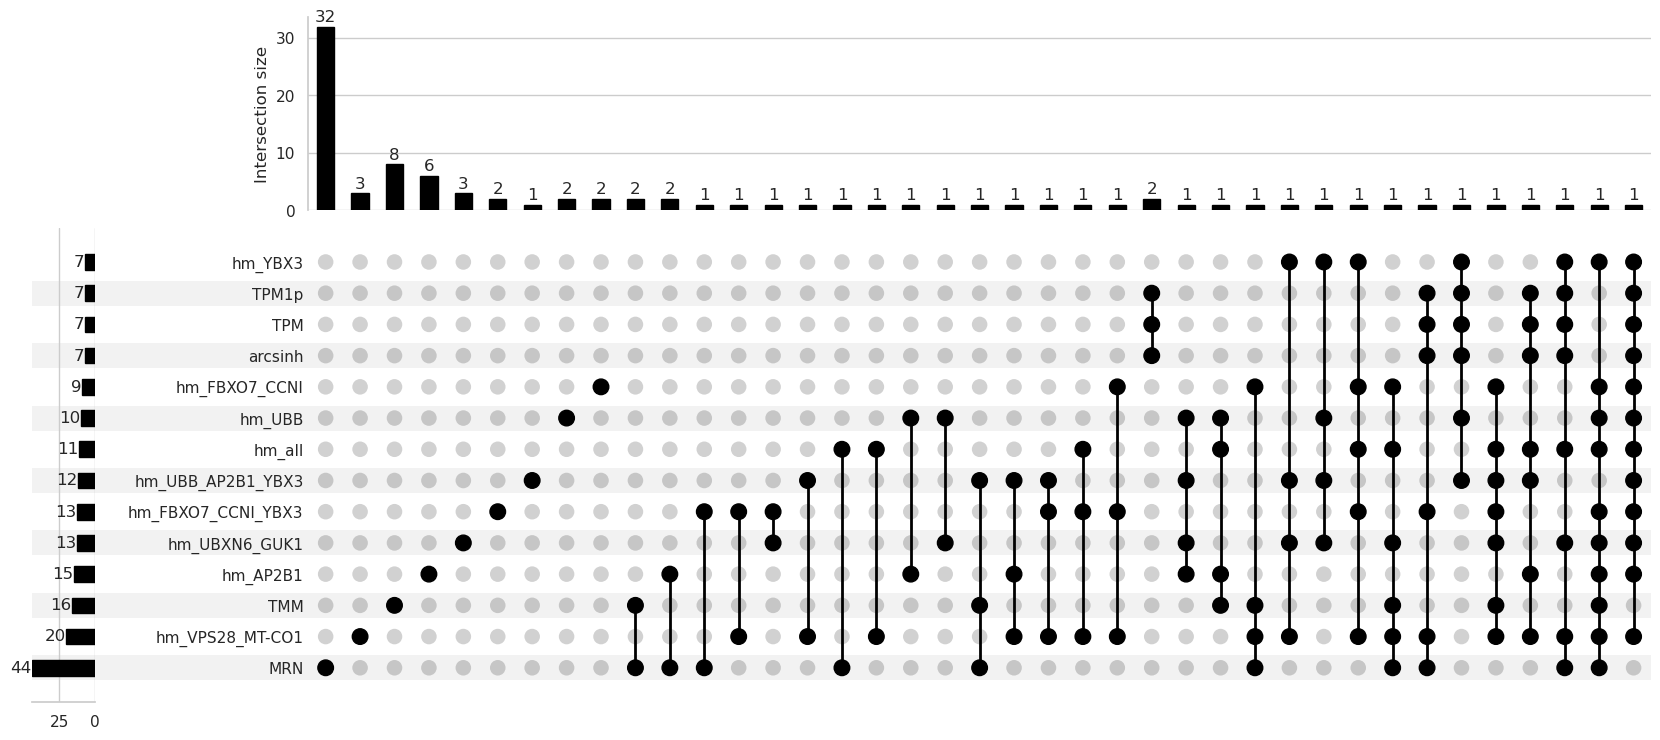

In [124]:
fig = plt.figure(figsize=(8.35*2, 8.35*3/4))
df_bs = pd.DataFrame(boruta_sets_)
df_bs = ~df_bs.isna()
up = plot(df_bs.reset_index().set_index(df_bs.columns.tolist()), orientation="horizontal", show_counts=True)#, show_percentages=False, min_degree=7,  fig=fig, element_size=None)
# up['totals'].set_xlabel("Species Qty.")
# up['intersections'].set_title("Species with Orthologous Genes")
# for lbl in up['matrix'].get_yticklabels():
#     lbl.set_style('italic')
plt.show()

In [127]:
df_bs[df_bs.MRN & df_bs.TMM].loc[:,df_bs[df_bs.MRN & df_bs.TMM].sum().sort_values(ascending=False).index]

MRN   TMM  hm_VPS28_MT-CO1  hm_FBXO7_CCNI  hm_all  hm_UBXN6_GUK1  \
CRTAM   True  True            False          False   False          False   
GABRG2  True  True             True           True   False          False   
GBP5    True  True             True           True    True           True   
GFOD1   True  True            False          False   False          False   
STAT1   True  True            False          False   False          False   
USP28   True  True             True           True    True           True   

        hm_FBXO7_CCNI_YBX3  hm_UBB  hm_AP2B1  hm_YBX3  hm_UBB_AP2B1_YBX3  \
CRTAM                False   False     False    False              False   
GABRG2               False   False     False    False              False   
GBP5                  True    True      True     True              False   
GFOD1                False   False     False    False              False   
STAT1                False   False     False    False               True   
USP28                False   False     False    False              False   

        arcsinh    TPM  TPM1p  
CRTAM     False  False  False  
GABRG2    False  False  False  
GBP5      False  False  False  
GFOD1     False  False  False  
STAT1     False  False  False  
USP28     False  False  False

In [116]:
# pd.DataFrame(boruta_sets_).loc[df_bs[df_bs.MRN & df_bs.TMM].loc[:,df_bs[df_bs.MRN & df_bs.TMM].sum().sort_values(ascending=False).index].index, df_bs[df_bs.MRN & df_bs.TMM].loc[:,df_bs[df_bs.MRN & df_bs.TMM].sum().sort_values(ascending=False).index].columns]

In [145]:
df_bs = pd.DataFrame(boruta_sets_)
gn_idx_dict = dict()
for c in df_bs.columns:
    gn_idx_dict[c] = np.where(~df_bs[c].isna())[0].tolist()
    print(c, ':',np.unique(df_bs[c].dropna(), return_counts=True))
print('\n',gn_idx_dict)

MRN : (array([1., 2., 3., 4., 5.]), array([30,  8,  4,  1,  1]))
TMM : (array([1., 2., 3.]), array([12,  1,  3]))
arcsinh : (array([1., 2.]), array([6, 1]))
TPM : (array([1., 2.]), array([6, 1]))
TPM1p : (array([1., 2.]), array([6, 1]))
hm_all : (array([1., 2.]), array([9, 2]))
hm_VPS28_MT-CO1 : (array([1., 2.]), array([19,  1]))
hm_UBXN6_GUK1 : (array([1., 2.]), array([12,  1]))
hm_FBXO7_CCNI : (array([1., 2., 3.]), array([7, 1, 1]))
hm_FBXO7_CCNI_YBX3 : (array([1., 2.]), array([11,  2]))
hm_UBB : (array([1.]), array([10]))
hm_AP2B1 : (array([1., 2.]), array([14,  1]))
hm_YBX3 : (array([1., 2.]), array([6, 1]))
hm_UBB_AP2B1_YBX3 : (array([1., 2., 3.]), array([10,  1,  1]))

 {'MRN': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], 'TMM': [7, 12, 14, 15, 38, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53], 'arcsinh': [17, 30, 54, 55, 56, 57, 58], 'TPM': [17, 30, 54, 55, 56

In [35]:
# fb = []
# for f in boruta_sets_.values():
#     fb.extend(f.keys())
# fb = list(set(fb))
# print(len(fb), fb)

# Modeling Naive model

To evaluate the normalization methods, we trainned RF models with parameters that can induce to a overfitting model, to verify which noralization achieve the best metrics

In [125]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        # col_list = []
        # for c in self.cols:
        #     col_list.append(X[:, c:c+1])
        return X[:,self.cols]#np.concatenate(col_list, axis=1)

    def fit(self, X, y=None):
        return self

## Variables for cross-validation

In [500]:
adata_ml_corr

AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type', 'fs_mean_arcs'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p', 'rms_all', 'hm_all', 'all_mean_arcs_norm_diff', 'arcsinh_AP2B1_CCNI', 'pair_arcs_AP2B1_CCNI_diff', 'arcsinh_AP2B1_FBXO7', 'pair_arcs_AP2B1_FBXO7_diff', 'arcsinh_AP2B1_GUK1', 'pair_arcs_AP2B1_GUK1_diff', 'arcsinh_AP2B1_UBB', 'pair_arcs_AP2B1_UBB_diff', 'arcsinh_AP2B1_UBXN6', 'pair_arcs_AP2B1_UBXN6_diff', 'arcsinh_AP2B1_VPS28', 'pair_arcs_AP2B1_VPS28_diff', 'arcsinh_AP2B1_YBX3', 'pair_arcs_AP2B1_YBX3_diff', 'arcsinh_AP2B1_MT-CO1', 'pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_CCNI_FBXO7', 'pair_arcs_CCNI_FBXO7_diff', 'arcsinh_CCNI_GUK1', 'pair_arcs_CCNI_GUK1_diff', 'arcsinh_CCNI_UBB', 'pair_arcs_CCNI_UBB_diff', 'arcsinh_CCNI_UBXN6', 'pair_arcs_CCNI_UBXN6_diff', 'arcsinh_CCNI_VPS28', 'pair_arcs_CCNI_VPS28_diff

## TMM_transformer and MRN_transformer

In [126]:
time_dict = dict()
clf_dict = dict()
nested_score_dict = dict()
model_str = '_rf_'

In [127]:
mkr = ['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']

In [128]:
gn = np.where(adata_ml.var.index.isin(['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']))[0]

In [146]:
n_jobs = 5
scoring = {'Precision': make_scorer(precision_score,average='weighted', zero_division=0), 
           'Accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score,average='weighted', zero_division=0),
           'F1': make_scorer(f1_score,average='weighted', zero_division=0),
           'AUC': make_scorer(roc_auc_score,average='weighted', multi_class="ovo")
          }

transform_dict = {#'GeTMM_transformer':GeTMM_transformer(gene_len),                      
                      'TMM_transformer': hkg.pp.TMM_transformer(),
                      'MRN_transformer': hkg.pp.MRN_transformer()
                     }

In [426]:
k

'rms_all'

In [425]:
fb_boruta_feat_slc[k]

['HOMER3', 'SRGAP2', 'CD14', 'GBP5']

In [149]:
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 8582
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

In [249]:
t1 = time.time()

for trns in ['TMM_transformer','MRN_transformer']:#fb_boruta_feat_slc.keys():#transform_dict.keys():
    if trns in ['count', 'trns_expr', 'TPM1p','arcsinh_AP2B1_MT-CO1']:
        continue
        
    gn_n = list(set(mkr).difference(set(fb_boruta_sets_g[trns.split('_')[0]]))) #mkr#
    gn = np.where(adata_ml_corr[(adata_ml.obs.outliers_hdbscan!=-1),:].var.index.isin(gn_n))[0]
    
    steps = [
        ('sampling', RandomUnderSampler(random_state=random_state)),
        ('transform', transform_dict[trns]),
        # ('normalization', StandardScaler()),
        # ('featslc', feature_selection_dict['RF_feature_selection']),#
        # ('featslc', ColumnExtractor( gn_idx_dict[trns.split('_')[0]] )),
        ('featslc', ColumnExtractor( gn )),
        ('classification', RandomForestClassifier(random_state=random_state, class_weight='balanced', n_estimators=100, max_features=None, n_jobs=n_jobs)),
        # ('classification', model_params_dict['random_forest']['model'])
    ]

    X = adata_ml[(adata_ml.obs.outliers_hdbscan!=-1),:].layers['count']
    X = np.nan_to_num(X, posinf=0,neginf=0)
    y = adata_ml[(adata_ml.obs.outliers_hdbscan!=-1),:].obs.ar.astype(int).values

    # param_grid = model_params_dict['random_forest']['params']    
    pipe = Pipeline(steps)
    outer_cv = RepeatedStratifiedKFold(random_state=random_state, n_repeats=5)#5# zip(train,test)# 
    nested_score = cross_validate(pipe, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
    nested_score_dict[trns] = nested_score
    time_dict['fs_gn'+model_str+trns] = time.time() - t1
    print(trns, end=' ')

TMM_transformer MRN_transformer 

In [131]:
t1 = time.time()

for trns in adata_ml_corr.layers.keys():#fb_boruta_feat_slc.keys():#transform_dict.keys():
    if trns in ['count', 'trns_expr', 'TPM1p','arcsinh_AP2B1_MT-CO1']:
        continue
        
    gn_n = list(set(mkr).difference(set(fb_boruta_sets_g[trns])))
    gn = np.where(adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),:].var.index.isin(gn_n))[0]
    
    steps = [
        ('sampling', RandomUnderSampler(random_state=random_state)),
        # ('transform', transform_dict[trns]),
        # ('normalization', StandardScaler()),
        # ('featslc', feature_selection_dict['RF_feature_selection']),#
        # ('featslc', ColumnExtractor( gn_idx_dict[trns.split('_')[0]] )),
        ('featslc', ColumnExtractor( gn )),
        ('classification', RandomForestClassifier(random_state=random_state, class_weight='balanced', n_estimators=100, max_features=None, n_jobs=n_jobs)),
        # ('classification', model_params_dict['random_forest']['model'])
    ]

    X = adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),:].layers[trns]
    X = np.nan_to_num(X, posinf=0,neginf=0)
    y = adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),:].obs.ar.astype(int).values

    # param_grid = model_params_dict['random_forest']['params']    
    pipe = Pipeline(steps)
    outer_cv = RepeatedStratifiedKFold(random_state=random_state, n_repeats=5)#5# zip(train,test)# 
    nested_score = cross_validate(pipe, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
    nested_score_dict[trns] = nested_score
    time_dict['fs_gn'+model_str+trns] = time.time() - t1
    print(trns, end=' ')
print((time.time()-t1)/60)

MRN TMM arcsinh TPM rms_all hm_all all_mean_arcs_norm_diff arcsinh_AP2B1_CCNI pair_arcs_AP2B1_CCNI_diff arcsinh_AP2B1_FBXO7 pair_arcs_AP2B1_FBXO7_diff arcsinh_AP2B1_GUK1 pair_arcs_AP2B1_GUK1_diff arcsinh_AP2B1_UBB pair_arcs_AP2B1_UBB_diff arcsinh_AP2B1_UBXN6 pair_arcs_AP2B1_UBXN6_diff arcsinh_AP2B1_VPS28 pair_arcs_AP2B1_VPS28_diff arcsinh_AP2B1_YBX3 pair_arcs_AP2B1_YBX3_diff pair_arcs_AP2B1_MT-CO1_diff arcsinh_CCNI_FBXO7 pair_arcs_CCNI_FBXO7_diff arcsinh_CCNI_GUK1 pair_arcs_CCNI_GUK1_diff arcsinh_CCNI_UBB pair_arcs_CCNI_UBB_diff arcsinh_CCNI_UBXN6 pair_arcs_CCNI_UBXN6_diff arcsinh_CCNI_VPS28 pair_arcs_CCNI_VPS28_diff arcsinh_CCNI_YBX3 pair_arcs_CCNI_YBX3_diff arcsinh_CCNI_MT-CO1 pair_arcs_CCNI_MT-CO1_diff arcsinh_FBXO7_GUK1 pair_arcs_FBXO7_GUK1_diff arcsinh_FBXO7_UBB pair_arcs_FBXO7_UBB_diff arcsinh_FBXO7_UBXN6 pair_arcs_FBXO7_UBXN6_diff arcsinh_FBXO7_VPS28 pair_arcs_FBXO7_VPS28_diff arcsinh_FBXO7_YBX3 pair_arcs_FBXO7_YBX3_diff arcsinh_FBXO7_MT-CO1 pair_arcs_FBXO7_MT-CO1_diff arcsinh_G

In [250]:
res_ml_test  = []
res_ml_train = []

for ns in nested_score_dict.keys():    
    res_ml_test.append(ns.split('|') + nested_score_dict[ns]['test_AUC'].tolist())
    res_ml_train.append(ns.split('|') + nested_score_dict[ns]['train_AUC'].tolist())

In [251]:
# pd.DataFrame(res_ml_train)

In [252]:
n=26
res_ml_test = pd.DataFrame(res_ml_test)
res_ml_test.columns = ['Norm'] + ['cv_ts'+str(i) for i in range(1,n)] 
res_ml_test['Mean_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].mean(axis=1)
res_ml_test['Median_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].median(axis=1)
res_ml_test['Std_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)
res_ml_test['1/Std_ts'] = 1/res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)

res_ml_train = pd.DataFrame(res_ml_train)
res_ml_train.columns = ['Norm'] + ['cv_tr'+str(i) for i in range(1,n)]
res_ml_train['Mean_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].mean(axis=1)
res_ml_train['Median_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].median(axis=1)
res_ml_train['Std_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)
res_ml_train['1/Std_tr'] = 1/res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)

res_ml = res_ml_train.merge(res_ml_test, on=['Norm'])
res_ml['delta_ts_tr'] = res_ml.Median_tr - res_ml.Median_ts

In [253]:
res_ml[(res_ml.Mean_ts>=.45)].sort_values(['Median_ts','Median_tr'], ascending=False).head(20)

Norm    cv_tr1    cv_tr2    cv_tr3    cv_tr4  \
75  pair_arcs_VPS28_MT-CO1_diff  0.912371  0.930412  0.922680  0.912821   
73    pair_arcs_VPS28_YBX3_diff  0.909794  0.907216  0.912371  0.910256   
81                    diff_GUK1  0.914948  0.925258  0.932990  0.915385   
31    pair_arcs_CCNI_VPS28_diff  0.925258  0.920103  0.912371  0.915385   
20    pair_arcs_AP2B1_YBX3_diff  0.912371  0.925258  0.922680  0.912821   
71  pair_arcs_UBXN6_MT-CO1_diff  0.899485  0.920103  0.922680  0.930769   
92                hm_FBXO7_CCNI  0.920103  0.922680  0.917526  0.915385   
94           hm_FBXO7_CCNI_YBX3  0.922680  0.932990  0.917526  0.917949   
47  pair_arcs_FBXO7_MT-CO1_diff  0.899485  0.920103  0.930412  0.902564   
57   pair_arcs_GUK1_MT-CO1_diff  0.927835  0.914948  0.922680  0.923077   
96            hm_UBB_AP2B1_YBX3  0.899485  0.912371  0.925258  0.930769   
38            arcsinh_FBXO7_UBB  0.912371  0.920103  0.914948  0.925641   
29    pair_arcs_CCNI_UBXN6_diff  0.914948  0.920103  0.914948  0.905128   
25     pair_arcs_CCNI_GUK1_diff  0.922680  0.909794  0.891753  0.907692   
65    pair_arcs_UBB_MT-CO1_diff  0.907216  0.917526  0.917526  0.917949   
10   pair_arcs_AP2B1_FBXO7_diff  0.907216  0.914948  0.938144  0.905128   
33     pair_arcs_CCNI_YBX3_diff  0.904639  0.904639  0.909794  0.900000   
2                       arcsinh  0.914948  0.904639  0.922680  0.900000   
3                           TPM  0.909794  0.904639  0.922680  0.900000   
58            arcsinh_UBB_UBXN6  0.886598  0.930412  0.922680  0.884615   

      cv_tr5    cv_tr6    cv_tr7    cv_tr8    cv_tr9  ...   cv_ts21   cv_ts22  \
75  0.915385  0.894330  0.912371  0.912371  0.910256  ...  0.678382  0.659864   
73  0.930769  0.891753  0.899485  0.925258  0.917949  ...  0.674603  0.631141   
81  0.935897  0.896907  0.904639  0.920103  0.920513  ...  0.696901  0.592215   
31  0.920513  0.899485  0.912371  0.927835  0.930769  ...  0.651550  0.573696   
20  0.905128  0.907216  0.914948  0.938144  0.907692  ...  0.600529  0.641345   
71  0.923077  0.896907  0.930412  0.917526  0.920513  ...  0.627362  0.592215   
92  0.941026  0.902062  0.922680  0.938144  0.925641  ...  0.631141  0.622827   
94  0.935897  0.920103  0.932990  0.922680  0.917949  ...  0.624717  0.579365   
47  0.928205  0.902062  0.909794  0.927835  0.912821  ...  0.619048  0.698791   
57  0.917949  0.902062  0.925258  0.909794  0.923077  ...  0.551398  0.606198   
96  0.928205  0.884021  0.912371  0.935567  0.917949  ...  0.654195  0.624717   
38  0.912821  0.896907  0.907216  0.948454  0.902564  ...  0.639456  0.583900   
29  0.938462  0.904639  0.909794  0.935567  0.917949  ...  0.688587  0.546863   
25  0.917949  0.899485  0.909794  0.917526  0.925641  ...  0.643991  0.643235   
65  0.917949  0.904639  0.902062  0.922680  0.920513  ...  0.561602  0.651550   
10  0.923077  0.891753  0.902062  0.932990  0.917949  ...  0.637566  0.604308   
33  0.910256  0.884021  0.891753  0.935567  0.905128  ...  0.633787  0.631141   
2   0.912821  0.891753  0.917526  0.917526  0.920513  ...  0.652305  0.612623   
3   0.910256  0.886598  0.920103  0.917526  0.920513  ...  0.633787  0.612623   
58  0.917949  0.896907  0.904639  0.917526  0.920513  ...  0.700680  0.624717   

     cv_ts23   cv_ts24   cv_ts25   Mean_ts  Median_ts    Std_ts   1/Std_ts  \
75  0.666289  0.611111  0.701389  0.663701   0.666289  0.030235  33.074506   
73  0.620937  0.561343  0.653935  0.639182   0.653439  0.050032  19.987018   
81  0.678382  0.561343  0.689815  0.640266   0.651550  0.046424  21.540366   
31  0.651550  0.545139  0.680556  0.634817   0.649660  0.047960  20.850686   
20  0.610733  0.550926  0.653935  0.647068   0.649660  0.053429  18.716351   
71  0.657974  0.532407  0.662037  0.641471   0.647770  0.051832  19.293116   
92  0.746032  0.534722  0.682870  0.639202   0.647014  0.052545  19.031418   
94  0.686697  0.550926  0.693287  0.638254   0.645881  0.054103  18.483382   
47  0.695011  0.550926  0.616898  0.646584   0.

In [254]:
# res_ml[(res_ml.Mean_ts>=.45)].sort_values(['delta_ts_tr'], ascending=True).head(20)

In [255]:
res_ml[(res_ml.Norm.isin(['MRN','TMM','TMM_transformer','MRN_transformer']))].sort_values(['Median_ts','Median_tr'], ascending=False).head(20)

Norm    cv_tr1    cv_tr2    cv_tr3    cv_tr4    cv_tr5  \
0               MRN  0.917526  0.917526  0.920103  0.923077  0.920513   
1               TMM  0.902062  0.917526  0.927835  0.905128  0.902564   
98  MRN_transformer  0.886598  0.899485  0.902062  0.897934  0.819943   
97  TMM_transformer  0.858772  0.887123  0.890225  0.892806  0.859972   

      cv_tr6    cv_tr7    cv_tr8    cv_tr9  ...   cv_ts21   cv_ts22   cv_ts23  \
0   0.886598  0.909794  0.930412  0.915385  ...  0.592215  0.520030  0.627362   
1   0.902062  0.927835  0.912371  0.923077  ...  0.670068  0.540438  0.573696   
98  0.899485  0.887648  0.871134  0.856339  ...  0.402116  0.539305  0.444822   
97  0.889175  0.894855  0.866504  0.870228  ...  0.446712  0.512472  0.407785   

     cv_ts24   cv_ts25   Mean_ts  Median_ts    Std_ts   1/Std_ts  delta_ts_tr  
0   0.526620  0.651620  0.625837   0.629252  0.049751  20.099948     0.290851  
1   0.482639  0.609954  0.592478   0.600529  0.046934  21.306575     0.314419  
98  0.458333  0.556713  0.489015   0.508692  0.055453  18.033371     0.378956  
97  0.533565  0.482639  0.497020   0.498843  0.065982  15.155554     0.390333  

[4 rows x 60 columns]

<Axes: xlabel='Gene_name', ylabel='value'>

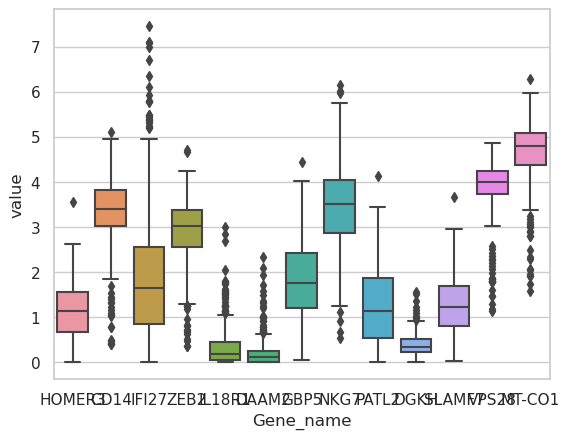

In [182]:
sns.boxplot(x='Gene_name',y='value',data=adata_ml_corr[:,mkr + 'VPS28_MT-CO1'.split('_')].to_df('arcsinh').melt())

In [256]:
rv_mrn = res_ml[(res_ml.Norm=='MRN')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Norm=='MRN')][['cv_ts'+str(i) for i in range(1,n)]].values
rv_tmm = res_ml[(res_ml.Norm=='TMM')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Norm=='TMM')][['cv_ts'+str(i) for i in range(1,n)]].values
rv_tpm = res_ml[(res_ml.Norm=='TPM')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Norm=='TPM')][['cv_ts'+str(i) for i in range(1,n)]].values
rv_arcsinh = res_ml[(res_ml.Norm=='arcsinh')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Norm=='arcsinh')][['cv_ts'+str(i) for i in range(1,n)]].values

rv_mrn_t = res_ml[(res_ml.Norm=='MRN_transformer')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Norm=='MRN_transformer')][['cv_ts'+str(i) for i in range(1,n)]].values
rv_tmm_t = res_ml[(res_ml.Norm=='TMM_transformer')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Norm=='TMM_transformer')][['cv_ts'+str(i) for i in range(1,n)]].values

rv_diff_mtcoi1 = res_ml[(res_ml.Norm=='pair_arcs_VPS28_MT-CO1_diff')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Norm=='pair_arcs_VPS28_MT-CO1_diff')][['cv_ts'+str(i) for i in range(1,n)]].values

In [257]:
# print('hkg vs tmm: ',ttest(rv_diff_mtcoi1[0], rv_tmm[0]))
# print('hkg vs tmm_t: ',mannwhitneyu(rv_diff_mtcoi1[0], rv_tmm_t[0]))

# print('hkg vs mrn: ',mannwhitneyu(rv_diff_mtcoi1[0], rv_mrn[0]))
# print('hkg vs mrn_t: ',mannwhitneyu(rv_diff_mtcoi1[0], rv_mrn_t[0]))

# print('hkg vs tpm: ',mannwhitneyu(rv_diff_mtcoi1[0], rv_tpm[0]))
# print('hkg vs arcsinh: ',mannwhitneyu(rv_diff_mtcoi1[0], rv_arcsinh[0]))

# print('hkg vs tmm: ',ttest_ind(rv_diff_mtcoi1[0], rv_tmm[0]))
# print('hkg vs tmm_t: ',ttest_ind(rv_diff_mtcoi1[0], rv_tmm_t[0]))

# print('hkg vs mrn: ',ttest_ind(rv_diff_mtcoi1[0], rv_mrn[0]))
# print('hkg vs mrn_t: ',ttest_ind(rv_diff_mtcoi1[0], rv_mrn_t[0]))

# print('hkg vs tpm: ',ttest_ind(rv_diff_mtcoi1[0], rv_tpm[0]))
# print('hkg vs arcsinh: ',ttest_ind(rv_diff_mtcoi1[0], rv_arcsinh[0]))

print('hkg vs tmm: ',ttest_rel(rv_diff_mtcoi1[0], rv_tmm[0]))
print('hkg vs tmm_t: ',ttest_rel(rv_diff_mtcoi1[0], rv_tmm_t[0]))

print('hkg vs mrn: ',ttest_rel(rv_diff_mtcoi1[0], rv_mrn[0]))
print('hkg vs mrn_t: ',ttest_rel(rv_diff_mtcoi1[0], rv_mrn_t[0]))

print('hkg vs tpm: ',ttest_rel(rv_diff_mtcoi1[0], rv_tpm[0]))
print('hkg vs arcsinh: ',ttest_rel(rv_diff_mtcoi1[0], rv_arcsinh[0]))

hkg vs tmm:  TtestResult(statistic=-8.139002709098953, pvalue=2.3234340864884452e-08, df=24)
hkg vs tmm_t:  TtestResult(statistic=-9.239614012467234, pvalue=2.250387851742209e-09, df=24)
hkg vs mrn:  TtestResult(statistic=-3.4673467342132116, pvalue=0.0019971905033911203, df=24)
hkg vs mrn_t:  TtestResult(statistic=-10.001302617535009, pvalue=4.903036354086446e-10, df=24)
hkg vs tpm:  TtestResult(statistic=-3.5664534573402835, pvalue=0.0015626002766808813, df=24)
hkg vs arcsinh:  TtestResult(statistic=-3.4717490455336395, pvalue=0.0019755997425696405, df=24)


In [258]:
res_ml_melt = []
res_ml_melt.append(res_ml[res_ml.Norm.isin(['MRN','TMM','TPM','arcsinh','MRN_transformer','TMM_transformer','pair_arcs_VPS28_MT-CO1_diff'])][['Norm']+['cv_ts'+str(i) for i in range(1,n)]].melt(id_vars='Norm'))
res_ml_melt[-1]['variable'] = 'Test'

res_ml_melt.append(res_ml[res_ml.Norm.isin(['MRN','TMM','TPM','arcsinh','MRN_transformer','TMM_transformer','pair_arcs_VPS28_MT-CO1_diff'])][['Norm']+['cv_tr'+str(i) for i in range(1,n)]].melt(id_vars='Norm'))
res_ml_melt[-1]['variable'] = 'Train'

res_ml_melt = pd.concat(res_ml_melt)

In [259]:
res_diff = pd.DataFrame(np.concatenate([rv_mrn, rv_tmm,rv_tpm,rv_arcsinh,rv_mrn_t,rv_tmm_t,rv_diff_mtcoi1]), index=['MRN','TMM','TPM','arcsinh','MRN_transformer','TMM_transformer','pair_arcs_VPS28_MT-CO1_diff']).melt(ignore_index=False).reset_index()
res_diff.columns = ['Norm','variable', 'value']

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


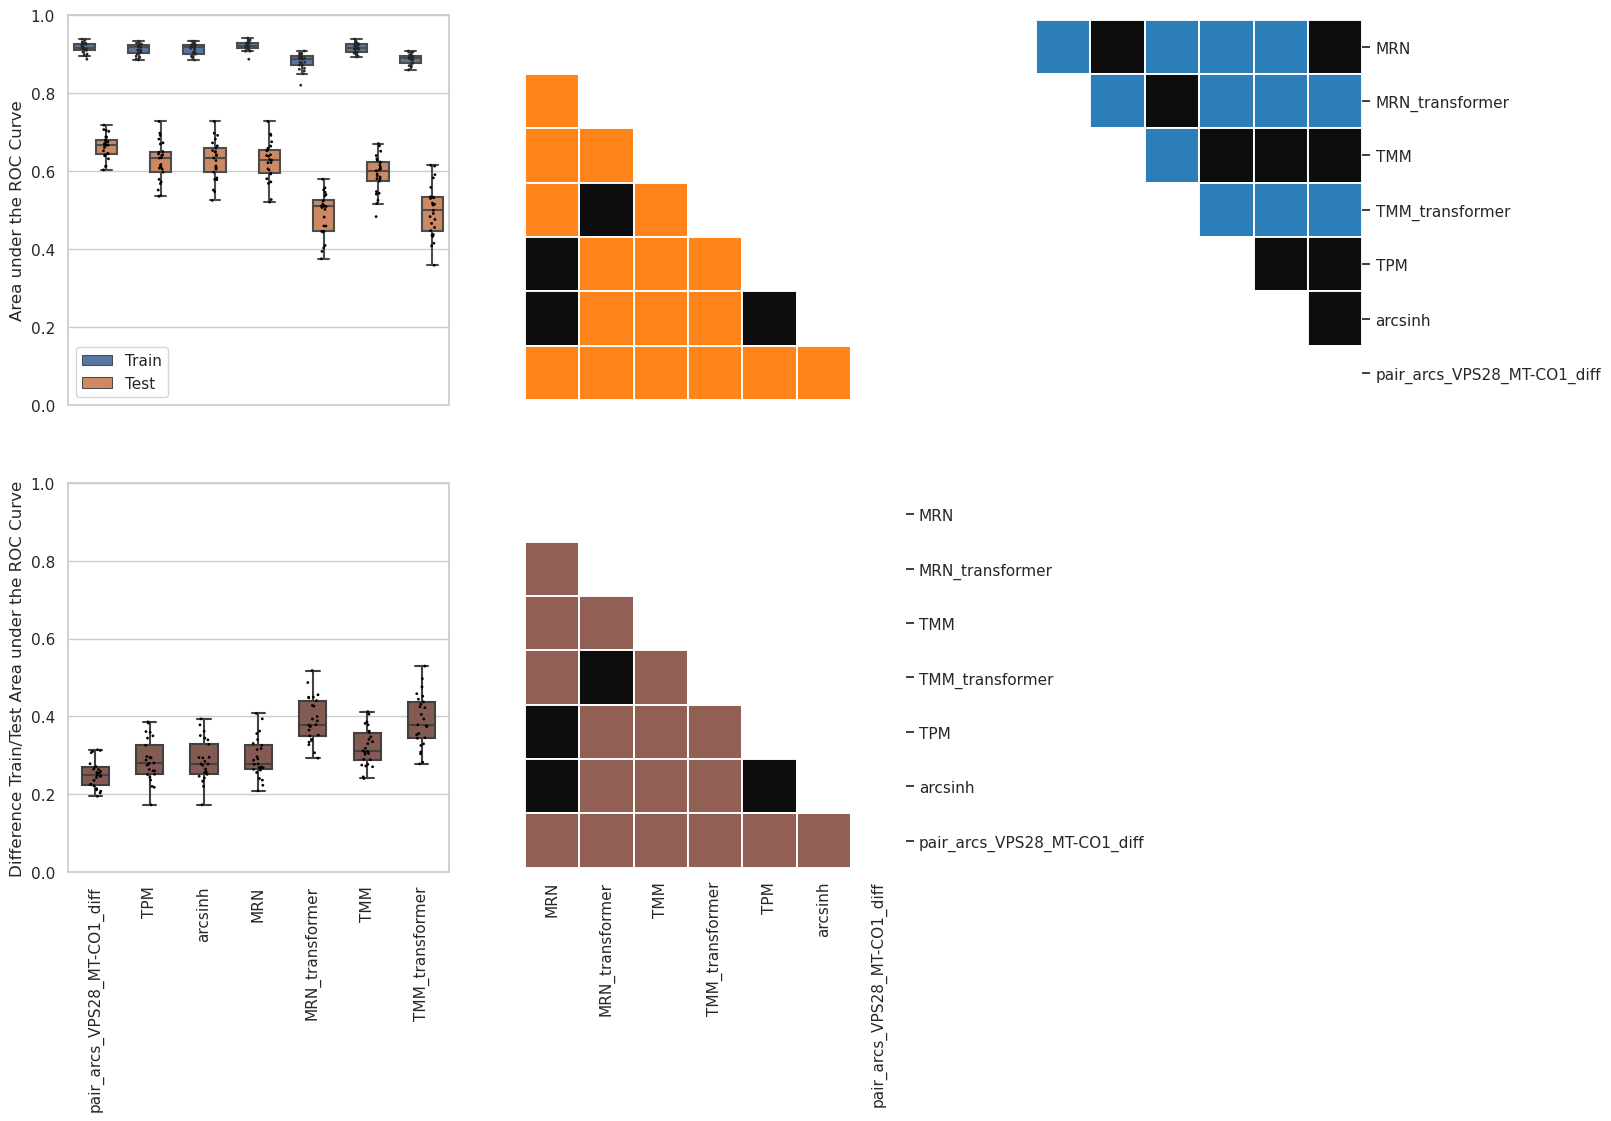

In [598]:
fig = plt.figure(figsize=(8.35*2, 8.35*4/3))

ax_tt = fig.add_subplot(231)
ax_tr_hm = fig.add_subplot(233)
ax_ts_hm = fig.add_subplot(232)
ax_diff = fig.add_subplot(234)
ax_diff_hm = fig.add_subplot(235)

x='Norm'
y='value'
order=['pair_arcs_VPS28_MT-CO1_diff','TPM','arcsinh','MRN','MRN_transformer','TMM','TMM_transformer']
hue='variable'
hue_order=['Train','Test']

sns.stripplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, color='black', s=2, dodge=True, data=res_ml_melt, ax=ax_tt)
sns.boxplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, fliersize=0, data=res_ml_melt, ax=ax_tt)
ax_tt.set_xticklabels([])
ax_tt.set_ylabel('Area under the ROC Curve')
ax_tt.set_xlabel('')
ax_tt.set_ylim([0,1])

handles, labels = ax_tt.get_legend_handles_labels()
ax_tt.legend(handles=np.array(handles)[-2:].tolist(), labels=np.array(labels)[-2:].tolist(), ncol=1)

pairs = list(itertools.combinations(order,2))
p_tr = []
p_ts = []
p_diff = []
for p in pairs:
    p_tr.append(wilcoxon(res_ml_melt[(res_ml_melt.variable=='Train') & (res_ml_melt.Norm==p[0])].value.values, res_ml_melt[(res_ml_melt.variable=='Train') & (res_ml_melt.Norm==p[1])].value.values).pvalue)
    p_ts.append(wilcoxon(res_ml_melt[(res_ml_melt.variable=='Test') & (res_ml_melt.Norm==p[0])].value.values, res_ml_melt[(res_ml_melt.variable=='Test') & (res_ml_melt.Norm==p[1])].value.values).pvalue)
    p_diff.append(wilcoxon(res_diff[(res_diff.Norm==p[0])].value.values, res_diff[(res_diff.Norm==p[1])].value.values).pvalue)

p_tr = false_discovery_control(p_tr)
p_ts = false_discovery_control(p_ts)
p_diff = false_discovery_control(p_diff)

df_p_tr = pd.DataFrame(pairs)
df_p_tr = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_tr['adj_pv'] = np.concatenate([p_tr, p_tr])
df_p_tr = df_p_tr.pivot(columns=0, index=1, values='adj_pv').fillna(1)
sns.heatmap((df_p_tr<=0.05).astype(int), cmap=['black', '#1f77b4'],mask=np.tril(df_p_tr), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_tr_hm)
# ax_tr_hm.set_yticklabels([])
ax_tr_hm.set_ylabel('')
ax_tr_hm.set_xlabel('')
ax_tr_hm.grid(False)
ax_tr_hm.set_xticklabels([])
ax_tr_hm.yaxis.tick_right()
ax_tr_hm.set_yticklabels(ax_tr_hm.get_yticklabels(), rotation=0)

df_p_ts = pd.DataFrame(pairs)
df_p_ts = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_ts['adj_pv'] = np.concatenate([p_ts, p_ts])
df_p_ts = df_p_ts.pivot(columns=0, index=1, values='adj_pv').fillna(1)
sns.heatmap(((df_p_ts<=0.05) & (df_p_ts>-1)).astype(int), cmap=['black', '#ff7f0e'],mask=np.triu(df_p_ts, k=0), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_ts_hm)
# 
# ax_ts_hm.yaxis.tick_right()
# ax_ts_hm.set_yticklabels(ax_ts_hm.get_yticklabels(), rotation=0)
ax_ts_hm.set_ylabel('')
ax_ts_hm.set_xlabel('')
ax_ts_hm.set_xticklabels([])
ax_ts_hm.set_yticklabels([])
ax_ts_hm.grid(False)

sns.stripplot(x=x, y=y, order=order, color='black', s=2, dodge=True, data=res_diff, ax=ax_diff)
sns.boxplot(x=x, y=y, order=order, color='#8c564b', width=.5, data=res_diff, ax=ax_diff)
ax_diff.set_ylabel('Difference Train/Test Area under the ROC Curve')
ax_diff.set_xlabel('')
ax_diff.set_xticklabels(ax_diff.get_xticklabels(), rotation=90)
ax_diff.set_ylim([0,1])

# annot_diff = Annotator(ax_diff, list(itertools.product(['pair_arcs_VPS28_MT-CO1_diff'],df_p_diff[df_p_diff['pair_arcs_VPS28_MT-CO1_diff']<1]['pair_arcs_VPS28_MT-CO1_diff'].sort_values().index)),
#                        data=res_diff, x=x, y=y, order=order)
# annot_diff.configure(test=None, text_format='star', loc='inside', verbose=0)
# annot_diff.set_pvalues(df_p_diff[df_p_diff['pair_arcs_VPS28_MT-CO1_diff']<1]['pair_arcs_VPS28_MT-CO1_diff'].sort_values().values)
# annot_diff.annotate()

df_p_diff = pd.DataFrame(pairs)
df_p_diff = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_diff['adj_pv'] = np.concatenate([p_diff, p_diff])
df_p_diff = df_p_diff.pivot(columns=0, index=1, values='adj_pv').fillna(1)

sns.heatmap((df_p_diff<=0.05).astype(int), cmap=['black', '#8c564b'],mask=np.triu(df_p_diff), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_diff_hm)
# ax_diff_hm.set_yticklabels([])
ax_diff_hm.yaxis.tick_right()
ax_diff_hm.set_yticklabels(ax_diff_hm.get_yticklabels(), rotation=0)
ax_diff_hm.set_ylabel('')
ax_diff_hm.set_xlabel('')
ax_diff_hm.grid(False)
    



In [608]:
boruta_sets_

NameError: name 'boruta_sets_' is not defined

In [505]:
res_diff.groupby('Norm').median()

variable     value
Norm                                           
MRN                              12.0  0.278070
MRN_transformer                  12.0  0.378917
TMM                              12.0  0.311842
TMM_transformer                  12.0  0.378490
TPM                              12.0  0.279644
arcsinh                          12.0  0.278033
pair_arcs_VPS28_MT-CO1_diff      12.0  0.249205

In [336]:
pd.DataFrame(p_ts)

0
0   2.786617e-03
1   3.438223e-03
2   6.891479e-03
3   3.129244e-07
4   3.825212e-05
5   3.129244e-07
6   3.737735e-01
7   7.389627e-01
8   3.129244e-07
9   3.271360e-03
10  1.251698e-06
11  7.970482e-01
12  3.129244e-07
13  3.438223e-03
14  1.043081e-06
15  5.006790e-07
16  4.962433e-03
17  1.390775e-06
18  1.390775e-06
19  5.424476e-01
20  1.431487e-04

## MRN, TMM, TPM and HKG normalization

In [109]:
# for l in 'hkg_mean_log_norm', 'hkg_mean_norm', 'hkg_median_log_norm', 'hkg_median_norm':
#     gn_idx_dict[l] = gn_idx_dict['TPM']

In [110]:
# [l for l in adata_ml.layers.keys() if ('arcsinh_max' in l) ]

In [35]:
t1 = time.time()

for trns in adata_ml.layers.keys():#['MRN', 'TMM', 'arcsinh', 'TPM', 'rms_all', 'hm_all', 'arcsinh_wmean_FBXO7_CCNI', 'arcsinh_wmean_pair_CCNI_FBXO7', 'hm_UBB', 'rms_UBB', 'arcsinh_max_FBXO7_GUK1', 'rms_AP2B1', 'hm_AP2B1', 'pair_arcs_FBXO7_MT-CO1_diff', 'pair_arcs_GUK1_VPS28_div', 'hm_VPS28_MT-CO1', 'pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_FBXO7_GUK1', 'pair_arcs_GUK1_VPS28_diff', 'pair_arcs_CCNI_VPS28_div', 'pair_arcs_FBXO7_VPS28_diff', 'pair_arcs_VPS28_MT-CO1_div', 'pair_arcs_CCNI_VPS28_diff', 'pair_arcs_CCNI_UBB_diff', 'arcsinh_max_UBB_MT-CO1', 'arcsinh_UBB_MT-CO1']:#[l for l in adata_ml.layers.keys() if ('arcsinh_wmean' in l) ]:#[l for l in adata_ml.layers.keys() if ('TPM_' in l) or ('arcsinh_' in l) ]:#
    if trns in ['count','trns_expr','TPM1p']:#'arcsinh',
        continue

    
    steps = [
        ('sampling', RandomUnderSampler(random_state=random_state)),
        # ('transform', transform_dict[trns]),
        # ('normalization', StandardScaler()),
        # ('featslc', feature_selection_dict['RF_feature_selection']),
        # ('featslc', ColumnExtractor( gn_idx_dict[trns] )),
        ('featslc', ColumnExtractor( gn )),
        ('classification', RandomForestClassifier(random_state=random_state, class_weight='balanced', n_jobs=n_jobs, criterion='entropy', min_samples_split=6)),
        # ('classification', model_params_dict['random_forest']['model'])
    ]

    # # X_hkg = adata_GSE175718[adata_GSE175718.obs.split=='Training_Test', (~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])) & (adata_GSE175718.var.index.isin(df_tpm_zero_filter.columns))].layers[trns]
    # X_hkg = adata_GSE175718[adata_GSE175718.obs.split=='Training_Test', ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].layers[trns]
    # # X_hkg = np.log(adata_GSE175718[adata_GSE175718.obs.split=='Training_Test', ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].layers[trns])
    # # X_hkg = np.log(X_hkg)
    # X_hkg = np.nan_to_num(X_hkg, posinf=0,neginf=0)
    X = adata_ml.layers[trns]
    X = np.nan_to_num(X, posinf=0,neginf=0)
    y = adata_ml.obs.ar.astype(int).values
    # param_grid = model_params_dict['random_forest']['params']
    
    pipe = Pipeline(steps)
    
    # inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    # outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = 5# zip(train,test)# 
    
    # clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
    # clf_dict[trns] = clf
    nested_score = cross_validate(pipe, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True)
    nested_score_dict[trns] = nested_score
    time_dict[trns] = time.time() - t1

    print(trns, end=' ')
print((time.time() - t1)/60)

MRN TMM arcsinh TPM rms_all rms_2_AP2B1 diff_AP2B1 rms_2_CCNI diff_CCNI rms_2_FBXO7 diff_FBXO7 rms_2_GUK1 diff_GUK1 rms_2_UBB diff_UBB rms_2_UBXN6 diff_UBXN6 rms_2_VPS28 diff_VPS28 rms_2_YBX3 diff_YBX3 rms_2_MT-CO1 diff_MT-CO1 hm_all hm_2_AP2B1 hm_2_CCNI hm_2_FBXO7 hm_2_GUK1 hm_2_UBB hm_2_UBXN6 hm_2_VPS28 hm_2_YBX3 hm_2_MT-CO1 all_mean_log_norm_div all_mean_log_norm_diff all_mean_arcs_norm_div all_mean_arcs_norm_diff arcsinh_wmean_all arcsinh_wmean_pair_AP2B1_CCNI arcsinh_max_AP2B1_CCNI arcsinh_AP2B1_CCNI TPM_AP2B1_CCNI pair_arcs_AP2B1_CCNI_div pair_arcs_AP2B1_CCNI_diff arcsinh_wmean_pair_AP2B1_FBXO7 arcsinh_max_AP2B1_FBXO7 arcsinh_AP2B1_FBXO7 TPM_AP2B1_FBXO7 pair_arcs_AP2B1_FBXO7_div pair_arcs_AP2B1_FBXO7_diff arcsinh_wmean_pair_AP2B1_GUK1 arcsinh_max_AP2B1_GUK1 arcsinh_AP2B1_GUK1 TPM_AP2B1_GUK1 pair_arcs_AP2B1_GUK1_div pair_arcs_AP2B1_GUK1_diff arcsinh_wmean_pair_AP2B1_UBB arcsinh_max_AP2B1_UBB arcsinh_AP2B1_UBB TPM_AP2B1_UBB pair_arcs_AP2B1_UBB_div pair_arcs_AP2B1_UBB_diff arcsinh_w

In [36]:
aux_auc = []
aux_auc_median = []

for k in nested_score_dict.keys():
    aux_auc.append([k, nested_score_dict[k]['train_AUC'], nested_score_dict[k]['test_AUC']])
    aux_auc_median.append([k, np.median(nested_score_dict[k]['train_AUC']), np.median(nested_score_dict[k]['test_AUC'])])

In [134]:
aux = pd.DataFrame(aux_auc)
aux.columns = ['normalization_method', 'train_5_cv', 'test_5_cv']
aux.to_csv('/mnt/d/housekeeping_genes/models/naive_RF_to_test_different_normalizarion_approaches.csv')

In [315]:
# aux = pd.DataFrame(aux_auc_median)
# aux.columns = ['normalization_method', 'train_median', 'test_median']
# aux['dif_train_test'] = aux.train_median - aux.test_median
# aux.to_csv('/mnt/d/housekeeping_genes/models/naive_RF_to_test_different_normalizarion_approaches_MEDIANS.csv')
aux = pd.read_csv('/mnt/d/housekeeping_genes/models/naive_RF_to_test_different_normalizarion_approaches_MEDIANS.csv')

In [316]:
aux[(~aux.normalization_method.str.contains('arcsinh_max_')) & (aux.test_median>=0.65)].sort_values('test_median')#.normalization_method.values#.tail(20)

Unnamed: 0         normalization_method  train_median  test_median  \
237         237  pair_arcs_UBXN6_MT-CO1_diff      0.941026     0.650794   
105         105      pair_arcs_CCNI_UBB_diff      0.943590     0.657974   
117         117    pair_arcs_CCNI_VPS28_diff      0.935897     0.666289   
24           24                  diff_MT-CO1      0.940722     0.666667   
16           16                     diff_UBB      0.938462     0.670068   
87           87  pair_arcs_AP2B1_MT-CO1_diff      0.935567     0.670068   
216         216           arcsinh_UBB_MT-CO1      0.930937     0.690476   

     dif_train_test  
237        0.290232  
105        0.285615  
117        0.269609  
24         0.274055  
16         0.268394  
87         0.265499  
216        0.240461

In [40]:
aux[(aux.normalization_method.str.contains('MRN')) | (aux.normalization_method.str.contains('TMM')) | (aux.normalization_method == 'TPM') | (aux.normalization_method == 'arcsinh')].sort_values('test_median')

normalization_method  train_median  test_median  dif_train_test
3                       TMM      0.932990     0.554398        0.378592
0  fs_gn_rf_TMM_transformer      0.916382     0.555178        0.361204
5                       TPM      0.920513     0.601663        0.318850
4                   arcsinh      0.920103     0.606198        0.313905
2                       MRN      0.925258     0.610733        0.314525
1  fs_gn_rf_MRN_transformer      0.919101     0.614583        0.304517

# Modeling Machine Learning Model based on *arcsinh_UBB_MT-CO1*

## Transformation of intererst

In [367]:
# 'pair_arcs_UBXN6_MT-CO1_diff', 'pair_arcs_CCNI_UBB_diff','pair_arcs_CCNI_VPS28_diff','diff_MT-CO1', 'diff_UBB','pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_UBB_MT-CO1','MRN', 'TMM'
hkg_sets = [['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1'],
            ['VPS28','MT-CO1'],['UBXN6','GUK1'],['FBXO7','CCNI'],['FBXO7','CCNI','YBX3'],
            ['UBB'],['AP2B1'],['YBX3'],['UBB','AP2B1','YBX3']]


for i,s in enumerate(hkg_sets):       
    if i == 0:
        for g in s:            
            adata_ml_corr.layers['diff_'+g] = adata_ml_corr[:,g].layers['arcsinh'] - adata_ml_corr.layers['arcsinh']
    
        for pair in itertools.combinations(s, 2):            
            adata_ml_corr.layers['arcsinh'+'_'+'_'.join(pair)] = (adata_ml_corr.layers['arcsinh'] - adata_ml_corr[:,pair[1]].layers['arcsinh'] )/(adata_ml_corr[:,pair[0]].layers['arcsinh'] - adata_ml_corr[:,pair[1]].layers['arcsinh'])
    
            adata_ml_corr.obs['fs_mean_arcs'] = adata_ml_corr[:,adata_ml_corr.var.index.isin(pair)].layers['arcsinh'].mean(axis=1).tolist()
            adata_ml_corr.layers['pair_arcs'+'_'+'_'.join(pair)+'_diff'] = (adata_ml_corr.layers['arcsinh'].T - adata_ml_corr.obs.fs_mean_arcs.values).T

/tmp/ipykernel_1475/869445946.py:10: ImplicitModificationWarning: Setting element `.layers['diff_AP2B1']` of view, initializing view as actual.
  adata_ml_corr.layers['diff_'+g] = adata_ml_corr[:,g].layers['arcsinh'] - adata_ml_corr.layers['arcsinh']


In [368]:
adata_ml_corr

AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type', 'fs_mean_arcs'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p', 'diff_AP2B1', 'diff_CCNI', 'diff_FBXO7', 'diff_GUK1', 'diff_UBB', 'diff_UBXN6', 'diff_VPS28', 'diff_YBX3', 'diff_MT-CO1', 'arcsinh_AP2B1_CCNI', 'pair_arcs_AP2B1_CCNI_diff', 'arcsinh_AP2B1_FBXO7', 'pair_arcs_AP2B1_FBXO7_diff', 'arcsinh_AP2B1_GUK1', 'pair_arcs_AP2B1_GUK1_diff', 'arcsinh_AP2B1_UBB', 'pair_arcs_AP2B1_UBB_diff', 'arcsinh_AP2B1_UBXN6', 'pair_arcs_AP2B1_UBXN6_diff', 'arcsinh_AP2B1_VPS28', 'pair_arcs_AP2B1_VPS28_diff', 'arcsinh_AP2B1_YBX3', 'pair_arcs_AP2B1_YBX3_diff', 'arcsinh_AP2B1_MT-CO1', 'pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_CCNI_FBXO7', 'pair_arcs_CCNI_FBXO7_diff', 'arcsinh_CCNI_GUK1', 'pair_arcs_CCNI_GUK1_diff', 'arcsinh_CCNI_UBB', 'pair_arcs_CCNI_UBB_diff', 'arcsinh_CCNI_UBXN6', 'pa

## Boruta feature selection

In [614]:
# fb_boruta_sets_g

In [616]:
boruta_sets_ = dict()
aux_list = []
t0 = time.time()
for layer in ['pair_arcs_VPS28_MT-CO1_diff']:#fb_boruta_sets_g.keys():
    if layer in ['trns_expr', 'log1p', 'TMM1p', 'count']:
        continue
    # elif 'rms_' in layer:
    #     continue
        
    t1 = time.time()
    print(layer, end=': ')
    gn = []
    aux = hkg.mining.set_boruta_selection(adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),
                                          (adata_ml_corr.var.equivalent=='non_equivalent') & (~adata_ml_corr.var.index.isin(fb_boruta_sets_g[layer]))],
                                          layer=layer, class_col='ar', n_set=5)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])
    
    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_[layer] = dict(zip(f,c))

    t2 = time.time()
    print( np.round((t2-t1)/60, 2), end = ', ')
t3 = time.time()
print((t3-t0)/60)
print(boruta_sets_)
# fb = []
# for f in boruta_sets_.values():
#     fb.extend(f.keys())
# fb = list(set(fb))
# print(fb)

# boruta_sets_ = dict()
# aux_list = []
# t0 = time.time()
# for layer in ['pair_arcs_UBXN6_MT-CO1_diff', 'pair_arcs_CCNI_UBB_diff','pair_arcs_CCNI_VPS28_diff',
#               'diff_MT-CO1', 'diff_UBB','pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_UBB_MT-CO1']:#adata_ml.layers: 'arcsinh_UBB_MT-CO1',
#     if layer in ['trns_expr', 'log1p', 'TMM1p', 'count']:
#         continue
#     elif 'rms_' in layer:
#         continue
        
#     t1 = time.time()
#     print(layer, end=': ')
#     gn = []
#     aux = hkg.mining.set_boruta_selection(adata_ml_corr, #scaler=StandardScaler(),
#                                           layer=layer, class_col='ar', n_set=3)
#     aux_list.append(aux)
#     for g in aux:
#         gn.extend(g['genes'])
    
#     f,c = np.unique(gn, return_counts = True)
#     if c.size > 0:
#         boruta_sets_[layer] = dict(zip(f,c))

#     t2 = time.time()
#     print( np.round((t2-t1)/60, 2))
# t3 = time.time()
# print((t3-t0)/60)
# print(boruta_sets_)
# fb = []
# for f in boruta_sets_.values():
#     fb.extend(f.keys())
# fb = list(set(fb))
# print(fb)

pair_arcs_VPS28_MT-CO1_diff: 0.3, 0.29752562046051023
{'pair_arcs_VPS28_MT-CO1_diff': {'CD14': 5, 'GBP5': 5, 'HOMER3': 3, 'MX1': 3, 'OGA': 2, 'SRGAP2': 3}}


In [617]:
# fb = ['SRGAP2', 'LAPTM5', 'PATL2', 'CD14', 'RHOG', 'MX1', 'OGA', 'DAAM2', 'LCP1', 'HOMER3', 'GBP5', 'ARPC2', 'ZEB2', 'MSN']
# fb = []
# for f in boruta_sets_.values():
#     fb.extend(f.keys())
# fb = list(set(fb))
# print(fb)
mkr

['HOMER3',
 'CD14',
 'IFI27',
 'ZEB2',
 'IL18R1',
 'DAAM2',
 'GBP5',
 'NKG7',
 'PATL2',
 'DGKH',
 'SLAMF7']

In [371]:
print(mkr)

['HOMER3', 'CD14', 'IFI27', 'ZEB2', 'IL18R1', 'DAAM2', 'GBP5', 'NKG7', 'PATL2', 'DGKH', 'SLAMF7']


## Split train test

In [372]:
# adata_ml.layers['arcsinh_UBB_MT-CO1']

In [373]:
# Initial value as outlier
adata_ml.obs[:,'train_test_groups'] = [-1 for i in range(adata_ml.obs.shape[0])]

/tmp/ipykernel_1475/1115517477.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ml.obs[:,'train_test_groups'] = [-1 for i in range(adata_ml.obs.shape[0])]


In [374]:
clusterer = KMeans(n_clusters=3, random_state=42).fit(adata_ml.X)
print(np.unique(clusterer.labels_, return_counts=True))
adata_ml.obs.loc[:, 'train_test_groups'] = clusterer.labels_

(array([0, 1, 2], dtype=int32), array([127,  34, 217]))


In [375]:
adata_ml.obs.groupby(['train_test_groups','ar']).count()

abmrh  tcmr  gse  gse_time  gse_patient  louvain_group  \
train_test_groups ar                                                           
0                 0      75    75   75        75           75             75   
                  1      52    52   52        52           52             52   
1                 0      17    17   17        17           17             17   
                  1      17    17   17        17           17             17   
2                 0     151   151  151       151          151            151   
                  1      66    66   66        66           66             66   

                      UMAP_1  UMAP_2  outliers_hdbscan  type  \
train_test_groups ar                                           
0                 0       75      75                75    75   
                  1       52      52                52    52   
1                 0       17      17                17    17   
                  1       17      17                17    17   
2                 0      151     151               151   151   
                  1       66      66                66    66   

                      (slice(None, None, None), train_test_groups)  
train_test_groups ar                                                
0                 0                                             75  
                  1                                             52  
1                 0                                             17  
                  1                                             17  
2                 0                                            151  
                  1                                             66

In [376]:
[ [[0, 1], [2]], [[1, 2], [0]]]

[[[0, 1], [2]], [[1, 2], [0]]]

In [377]:
train = []
test = []
for tr, ts in [ [[0, 1], [2]], [[1, 2], [0]]]:
    train.append(np.where(adata_ml.obs.louvain_group.isin(tr))[0])
    test.append(np.where(adata_ml.obs.louvain_group.isin(ts))[0])

    
    # if (tr == 1) and (ts != 2):
    #     train.append(np.where(adata_ml.obs.louvain_group.isin([tr, 2]))[0])
    #     test.append(np.where(adata_ml.obs.louvain_group==ts)[0])
    # elif (tr == 1) and (ts == 2):
    #     continue
    # elif (tr == 2):
    #     continue
    # else:
    #     train.append(np.where(adata_ml.obs.train_test_groups==tr)[0])
    #     test.append(np.where(adata_ml.obs.train_test_groups==ts)[0])
    print(tr, ts, end = ' | ')

[0, 1] [2] | [1, 2] [0] | 

## Modeling

In [550]:
list(range(2,10,2))

[2, 4, 6, 8]

In [618]:
# X = adata_ml.layers['counts']
# y =adata_ml.ar.values.astype(int)

# X_v = adata_GSE175718[adata_GSE175718.obs.split=='Validation', ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].layers['counts']
# y_v = adata_GSE175718.obs[adata_GSE175718.obs.split=='Validation'].ar.values.astype(int)

# gene_len = adata_GSE175718[adata_GSE175718.obs.split=='Training_Test', ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].var.Gene_lenght.values
# # gene_len = adata_GSE175718[:, ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].var.Gene_lenght.values

n_jobs = 5
scoring = {'Precision': make_scorer(precision_score,average='weighted', zero_division=0), 
           'Accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score,average='weighted', zero_division=0),
           'F1': make_scorer(f1_score,average='weighted', zero_division=0),
           'AUC': make_scorer(roc_auc_score,average='weighted', multi_class="ovo")
          }

parameters = {'classification__n_estimators': [150,200,500,1000, 1050, 1100, 1200,1300,1500,2000],
              'classification__criterion': ['gini','entropy','log_loss']}

model_params_dict = {  
    'random_forest': {
        'model': RandomForestClassifier(random_state=random_state, class_weight='balanced',oob_score=True),#, n_jobs=n_jobs),# ),
        'params' : {
            'classification__n_estimators': [200,500,1000,2000], #50,100,150,3000
            'classification__criterion': ['entropy','gini'],
            'classification__min_samples_split' : list(range(2,8,2)),
            # 'classification__min_samples_leaf' : list(range(1,6)),
            # 'classification__max_features': ['sqrt','log2']
        }
    },
    # 'GradientBoostingClassifier':{
    #     'model':GradientBoostingClassifier(random_state=random_state, min_samples_split=4),
    #     'params' : {
    #         'classification__n_estimators': [100,150,200,500,1000,2000],
    #         'classification__learning_rate': [.1, .2],
    #         'classification__subsample': [1, .2],
    #         # 'classification__min_samples_split' : list(range(2,6,2)),
    #         # 'classification__min_samples_leaf' : list(range(1,4)),
    #         # 'classification__criterion': ['friedman_mse', 'squared_error'],
    #     }
    # },   
    # 'AdaBoostClassifier':{
    #     'model':AdaBoostClassifier(random_state=random_state, algorithm='SAMME'),
    #     'params':{'classification__n_estimators': [100,150,200,500,1000,2000],
    #               'classification__learning_rate': [.1, .2],           
    #     }
    # },
    # 'mlp': {
    #     'model': MLPClassifier(random_state=random_state,max_iter=500),
    #     'params' : {
    #         'classification__activation': ['identity', 'logistic', 'tanh', 'relu'],
    #         # 'classification__solver': ['sgd', 'adam'],#'lbfgs', 
    #         # 'classification__learning_rate': ['constant', 'invscaling', 'adaptive'],
    #     }
    # },
    # 'gaussian': {
    #     'model': GaussianProcessClassifier(n_jobs=n_jobs),
    #     'params' : {
    #         'classification__random_state': [random_state],
    #     }
    # },
    # 'knn': {
    #     'model': KNeighborsClassifier(n_jobs=n_jobs),
    #     'params' : {
    #         'classification__weights': ['uniform', 'distance'],
    #         'classification__algorithm': ['ball_tree', 'kd_tree'],#, 'brute','auto', 
    #         'classification__n_neighbors': [5, 10, 15, 20, 25],
    #     }
    # },

    # 'svm_linear': {
    #         'model': SVC(random_state=random_state, class_weight='balanced'),
    #         'params' : {'classification__C':[1, 10, 100, 1000, 10000], 'classification__kernel': ['linear'] }
    #     },
    # 'svm_rbf': {
    #         'model': SVC(random_state=random_state, class_weight='balanced'),
    #         'params' : {'classification__C':[1, 10, 100, 1000], 'classification__kernel': ['rbf'], 'classification__gamma': [0.1, 0.01, 0.001, 0.0001]}
    #     },
    # 'svm_poly': {
    #         'model': SVC(random_state=random_state, class_weight='balanced'),
    #         'params' : {'classification__C':[1, 10, 100, 1000], 'classification__kernel': ['poly'], 'classification__gamma': [0.1, 0.01, 0.001, 0.0001]}
    #     },
}

transform_dict = {#'GeTMM_transformer':GeTMM_transformer(gene_len),                      
                      'TMM_transformer': hkg.pp.TMM_transformer(),
                      'MRN_transformer': hkg.pp.MRN_transformer()
                     }

sampling_dict = {'RandomUnderSampler': RandomUnderSampler(random_state=random_state),
                 'SMOTE': SMOTE(random_state=random_state),
                 'ADASYN': ADASYN(random_state=random_state)
                }

feature_selection_dict = {'SVC_feature_selection':SelectFromModel(SVC(kernel='linear',random_state=random_state), max_features=50),
                          'RF_feature_selection':SelectFromModel(RandomForestClassifier(random_state=random_state), max_features=50),
                          # 'Boruta_feature_selection':BorutaPy(RandomForestClassifier(random_state=random_state, class_weight='balanced'), n_estimators='auto', random_state=random_state)
                         }

# feature_selection_dict = {'SVC_feature_selection':RFE(SVC(kernel='linear',random_state=random_state), n_features_to_select=50),
#                           'RF_feature_selection':RFE(RandomForestClassifier(random_state=random_state, class_weight='class_weight'), n_features_to_select=50),
#                           'Boruta_feature_selection':BorutaPy(RandomForestClassifier(random_state=random_state, class_weight='class_weight'), n_estimators='auto', random_state=random_state)}

    # 'logisticRegression_l1': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty='l1'),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__penalty': ['l2', 'elasticnet', None],
    #         'classification__class_weight': ['balanced', None],
    #         'classification__solver': ['liblinear', 'saga']
    #     }
    # },
    # 'logisticRegression_l2': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty='l2'),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__solver': ['lbfgs','liblinear', 'newton-cholesky','newton-cg','sag', 'saga'],
    #     }
    # },
    # 'logisticRegression_elasticnet': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty='l2'),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__solver': ['saga'],
    #     }
    # },
    # 'logisticRegression_none': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty=None),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__solver': ['lbfgs', 'newton-cholesky','newton-cg','sag', 'saga'],
    #     }
    # },
    # # 'naive_bayes': {
    # # 'model': GaussianNB(),
    # #     'params' : {
    # #         'priors': [None],
    # #     }
    # # },

In [115]:
df_bs.columns#[['pair_arcs_UBXN6_MT-CO1_diff']]#, 'pair_arcs_CCNI_UBB_diff','pair_arcs_CCNI_VPS28_diff','diff_MT-CO1', 'diff_UBB','pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_UBB_MT-CO1','MRN', 'TMM']]

MRN  TMM  arcsinh  TPM  TPM1p  hm_all  hm_VPS28_MT-CO1  hm_UBXN6_GUK1  \
ABCC4   1.0  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
APMAP   1.0  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
CACNB2  1.0  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
CD14    5.0  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
CDC14A  1.0  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
...     ...  ...      ...  ...    ...     ...              ...            ...   
NHERF2  NaN  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
PIWIL4  NaN  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
TET3    NaN  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
TOX-DT  NaN  NaN      NaN  NaN    NaN     NaN              NaN            NaN   
APOM    NaN  NaN      NaN  NaN    NaN     NaN              NaN            NaN   

        hm_FBXO7_CCNI  hm_FBXO7_CCNI_YBX3  hm_UBB  hm_AP2B1  hm_YBX3  \
ABCC4             NaN                 NaN     NaN       NaN      NaN   
APMAP             NaN                 NaN     NaN       NaN      NaN   
CACNB2            NaN                 NaN     NaN       NaN      NaN   
CD14              NaN                 NaN     NaN       NaN      NaN   
CDC14A            NaN                 NaN     NaN       NaN      NaN   
...               ...                 ...     ...       ...      ...   
NHERF2            NaN                 NaN     NaN       1.0      NaN   
PIWIL4            NaN                 NaN     NaN       1.0      NaN   
TET3              NaN                 NaN     NaN       1.0      NaN   
TOX-DT            NaN                 NaN     NaN       1.0      NaN   
APOM              NaN                 NaN     NaN       NaN      NaN   

        hm_UBB_AP2B1_YBX3  
ABCC4                 NaN  
APMAP                 NaN  
CACNB2                NaN  
CD14                  NaN  
CDC14A                NaN  
...                   ...  
NHERF2                NaN  
PIWIL4                NaN  
TET3                  NaN  
TOX-DT                NaN  
APOM                  1.0  

[92 rows x 14 columns]

In [110]:
df_bs.columns#[trns].dropna(), trns

Index(['MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p', 'hm_all', 'hm_VPS28_MT-CO1',
       'hm_UBXN6_GUK1', 'hm_FBXO7_CCNI', 'hm_FBXO7_CCNI_YBX3', 'hm_UBB',
       'hm_AP2B1', 'hm_YBX3', 'hm_UBB_AP2B1_YBX3'],
      dtype='object')

In [122]:
gn_dict = {'pair_arcs_UBXN6_MT-CO1_diff': ['GBP5'], 'pair_arcs_CCNI_UBB_diff': ['CD14','GBP5'],
           'pair_arcs_CCNI_VPS28_diff': ['CD14','DAAM2','GBP5','LAPTM5','PATL2'],
           'diff_MT-CO1': ['ARPC2', 'CD14', 'GBP5', 'HOMER3', 'LCP1','PATL2','RHOG'],
           'diff_UBB': ['GBP5'], 'pair_arcs_AP2B1_MT-CO1_diff': ['CD14','GBP5','MSN','MX1','OGA','ZEB2'], 'arcsinh_UBB_MT-CO1': ['RHOG', 'SRGAP2'],
           # 'TMM':df_bs['TMM'].dropna().index.tolist(), 'MRN':df_bs['MRN'].dropna().index.tolist()
          }

In [147]:
fb_2 = set()
for k in gn_dict.keys():
    fb_2.update(set(gn_dict[k]))
fb_2.update(mkr)
fb_2 = list(fb_2)
print(fb_2)

['LLGL2', 'SLAMF7', 'IFI27', 'ZEB2', 'TTC9', 'APMAP', 'RHOG', 'ORC6', 'GABRG2', 'USP28', 'OGA', 'TRAM2-AS1', 'GFOD1', 'SGCE', 'KIAA1671', 'NUDT16-DT', 'RPP38', 'IKZF2', 'RAB12', 'DGCR6', 'IDH1', 'MITD1', 'SIGLEC5', 'SKA2', 'GBP1', 'PATL2', 'HELLS', 'GBP3', 'CTSD', 'CDC14A', 'GBP2', 'PLEKHO2', 'BCL2L11', 'PGAM1', 'SPPL2A', 'HYCC1', 'LAPTM5', 'CRTAM', 'MSN', 'MX1', 'FTX', 'DAAM2', 'RXRA', 'CPSF4', 'ARPC2', 'TMEM144', 'IL18R1', 'NKG7', 'MTSS1', 'TAOK1', 'SEPSECS-AS1', 'GRN', 'ABCC4', 'PCBP1-AS1', 'CNNM3', 'HOMER3', 'STAT1', 'RNF213', 'GBP5', 'LCP1', 'DGKH', 'LINC02532', 'LINC00507', 'CD14', 'EMG1', 'SRGAP2', 'MEF2C', 'NOS1', 'RIPPLY3', 'CACNB2']


In [9]:
# mkr
fb = ['CD14',
 'SP110',
 'LAPTM5',
 'PATL2',
 'HOMER3',
 'MSN',
 'RHOG',
 'ARPC2',
 'GBP5',
 'NKG7',
 'SRGAP2']

In [476]:
print(mkr)

['HOMER3', 'CD14', 'IFI27', 'ZEB2', 'IL18R1', 'DAAM2', 'GBP5', 'NKG7', 'PATL2', 'DGKH', 'SLAMF7']


In [474]:
print(fb_boruta_sets_g['all_mean_arcs_norm_diff'])
print(fb_boruta_feat_slc['all_mean_arcs_norm_diff'])

['LASP1', 'ARHGAP9', 'CD14', 'COTL1', 'SELPLG', 'FAM120A', 'DGKH', 'CXCR1', 'LAMP1', 'RPLP0', 'RPL34', 'LAPTM5', 'SP110', 'CEBPB', 'LCP1', 'RPL11', 'ZFP36L1', 'LYN', 'PTPRC', 'VASP', 'OGA', 'DAAM2', 'MSN', 'RPS29', 'RPL37A', 'RPS7', 'SDCBP', 'RPS8', 'RPS27A', 'JUNB', 'HCK', 'RPS24', 'MCL1', 'FBL', 'PXN', 'IFITM2', 'WAS', 'GNAI2', 'RPS12', 'RPS18', 'RPL31', 'CDC42SE1', 'CD53', 'FAU', 'RPS10', 'RPL10A', 'LILRB3', 'RPL24', 'RPL3', 'JPH2', 'RPS23', 'EMP2', 'RASSF2', 'RPS17', 'EEF1D', 'FPR1', 'L3MBTL4', 'MSRB1', 'RPL15', 'TCL1A', 'EVI2B', 'JAML', 'NCF4', 'HCLS1']
['CD14', 'GBP5']


In [478]:
list(set(mkr).difference(set(fb_boruta_sets_g['all_mean_arcs_norm_diff'])))

['IL18R1', 'NKG7', 'PATL2', 'HOMER3', 'IFI27', 'ZEB2', 'SLAMF7', 'GBP5']

In [448]:
for k in fb_boruta_feat_slc.keys():
    if ('all' in k):# or ('hm' in k):
        print(k, end=', ')

all_mean_arcs_norm_diff, all_mean_arcs_norm_div, all_mean_log_norm_diff, all_mean_log_norm_div, arcsinh_wmean_all, hm_all, rms_all, 

In [498]:
# list(fb_boruta_feat_slc.keys())
adata_ml_corr[:,gn].var

equivalent
Gene_name                
GNAI2      non_equivalent
RPL24      non_equivalent
VASP       non_equivalent
RPS25      non_equivalent
ZEB2       non_equivalent
DCAF12     non_equivalent
COX7C      non_equivalent
RPLP2      non_equivalent

In [506]:
# list(set(mkr).difference(set(fb_boruta_sets_g['MRN'])))
# fb_boruta_sets_g['MRN']
gn_n = list(set(mkr).difference(set(fb_boruta_sets_g[trns])))
gn = np.where(adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),(adata_ml_corr.var.equivalent=='non_equivalent')].var.index.isin(gn_n))[0]

In [508]:
adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),(adata_ml_corr.var.equivalent=='non_equivalent')][:,gn].var

equivalent
Gene_name                
IFI27      non_equivalent
NKG7       non_equivalent
IL18R1     non_equivalent
ZEB2       non_equivalent
PATL2      non_equivalent
SLAMF7     non_equivalent
DAAM2      non_equivalent
HOMER3     non_equivalent
CD14       non_equivalent
DGKH       non_equivalent
GBP5       non_equivalent

In [ ]:
model_params_dict.keys()

In [51]:
# fb_boruta_sets_g
adata_ml_corr.layers.keys()

KeysView(Layers with keys: count, trns_expr, MRN, TMM, arcsinh, TPM, TPM1p, rms_all, hm_all, all_mean_arcs_norm_diff, arcsinh_AP2B1_CCNI, pair_arcs_AP2B1_CCNI_diff, arcsinh_AP2B1_FBXO7, pair_arcs_AP2B1_FBXO7_diff, arcsinh_AP2B1_GUK1, pair_arcs_AP2B1_GUK1_diff, arcsinh_AP2B1_UBB, pair_arcs_AP2B1_UBB_diff, arcsinh_AP2B1_UBXN6, pair_arcs_AP2B1_UBXN6_diff, arcsinh_AP2B1_VPS28, pair_arcs_AP2B1_VPS28_diff, arcsinh_AP2B1_YBX3, pair_arcs_AP2B1_YBX3_diff, arcsinh_AP2B1_MT-CO1, pair_arcs_AP2B1_MT-CO1_diff, arcsinh_CCNI_FBXO7, pair_arcs_CCNI_FBXO7_diff, arcsinh_CCNI_GUK1, pair_arcs_CCNI_GUK1_diff, arcsinh_CCNI_UBB, pair_arcs_CCNI_UBB_diff, arcsinh_CCNI_UBXN6, pair_arcs_CCNI_UBXN6_diff, arcsinh_CCNI_VPS28, pair_arcs_CCNI_VPS28_diff, arcsinh_CCNI_YBX3, pair_arcs_CCNI_YBX3_diff, arcsinh_CCNI_MT-CO1, pair_arcs_CCNI_MT-CO1_diff, arcsinh_FBXO7_GUK1, pair_arcs_FBXO7_GUK1_diff, arcsinh_FBXO7_UBB, pair_arcs_FBXO7_UBB_diff, arcsinh_FBXO7_UBXN6, pair_arcs_FBXO7_UBXN6_diff, arcsinh_FBXO7_VPS28, pair_arcs_FBX

In [607]:
adata_ml_corr

AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type', 'fs_mean_arcs'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p', 'rms_all', 'hm_all', 'all_mean_arcs_norm_diff', 'arcsinh_AP2B1_CCNI', 'pair_arcs_AP2B1_CCNI_diff', 'arcsinh_AP2B1_FBXO7', 'pair_arcs_AP2B1_FBXO7_diff', 'arcsinh_AP2B1_GUK1', 'pair_arcs_AP2B1_GUK1_diff', 'arcsinh_AP2B1_UBB', 'pair_arcs_AP2B1_UBB_diff', 'arcsinh_AP2B1_UBXN6', 'pair_arcs_AP2B1_UBXN6_diff', 'arcsinh_AP2B1_VPS28', 'pair_arcs_AP2B1_VPS28_diff', 'arcsinh_AP2B1_YBX3', 'pair_arcs_AP2B1_YBX3_diff', 'arcsinh_AP2B1_MT-CO1', 'pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_CCNI_FBXO7', 'pair_arcs_CCNI_FBXO7_diff', 'arcsinh_CCNI_GUK1', 'pair_arcs_CCNI_GUK1_diff', 'arcsinh_CCNI_UBB', 'pair_arcs_CCNI_UBB_diff', 'arcsinh_CCNI_UBXN6', 'pair_arcs_CCNI_UBXN6_diff', 'arcsinh_CCNI_VPS28', 'pair_arcs_CCNI_VPS28_diff

In [591]:
t1 = time.time()
nested_score_dict = dict()
# trns = 'arcsinh_UBB_MT-CO1' 	

for ml_model in model_params_dict.keys():
    t2 = time.time()
    print(ml_model, end='(')
    for trns in ['pair_arcs_VPS28_MT-CO1_diff']:#adata_ml_corr.layers.keys():#list(fb_boruta_feat_slc.keys()):
    # for trns in ['all_mean_arcs_norm_diff', 'all_mean_arcs_norm_div',
    #              'all_mean_log_norm_diff', 'all_mean_log_norm_div',
    #              'arcsinh_wmean_all', 'hm_all', 'rms_all']:
        #fb_boruta_feat_slc.keys():#['pair_arcs_UBXN6_MT-CO1_diff', 'pair_arcs_CCNI_UBB_diff','pair_arcs_CCNI_VPS28_diff','diff_MT-CO1', 'diff_UBB','pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_UBB_MT-CO1']: 
        if trns in ['count', 'trns_expr', 'TPM1p','arcsinh_AP2B1_MT-CO1']:
            continue
        # gn = np.where(adata_ml.var.index.isin( gn_dict[trns] ))[0]
        # if trns == 'TMM':            
        #     gn = np.where(adata_ml_corr.var.index.isin( df_bs['TMM'].dropna().index ))[0]
        # elif trns == 'MRN':
        #     gn = np.where(adata_ml_corr.var.index.isin( df_bs['MRN'].dropna().index ))[0]
        # else:
        #     gn = np.where(adata_ml_corr.var.index.isin(fb))[0]
        
        # gn_n = list(set(adata_ml_corr.var.index).difference(set(fb_boruta_sets_g[trns])))
        gn_n = ['CD14', 'GBP5', 'HOMER3', 'MX1', 'OGA', 'SRGAP2']
        gn = np.where(adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),:].var.index.isin(gn_n))[0]
            
        steps = [
            ('sampling', sampling_dict['RandomUnderSampler']),
            # ('transform', transform_dict[trns]),
            ('normalization', StandardScaler()),
            # ('featslc', ColumnExtractor( gn )),
            # ('featslc', feature_selection_dict['RF_feature_selection']),
            # ('featslc', ColumnExtractor( gn_idx_dict[trns] )),
            ('featslc', ColumnExtractor( gn )),
            ('classification', model_params_dict[ml_model]['model'])
        ]
        
        X = adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),:].layers[trns]
        X = np.nan_to_num(X, posinf=0,neginf=0)
        y = adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),:].obs.ar.astype(int).values
        
        param_grid = model_params_dict[ml_model]['params']
        
        pipe = Pipeline(steps)
        
        #  KFold(n_splits=5, shuffle=True, random_state=random_state)
        # outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
        # outer_cv = StratifiedKFold(n_splits=10)#random_state=random_state, n_repeats=3)#3# RepeatedStratifiedKFold(random_state=random_state)# zip(train,test)# 5#  
        # inner_cv = StratifiedKFold(n_splits=3)#random_state=random_state, shuffle=True)#3# RepeatedStratifiedKFold(random_state=random_state, n_repeats=3)#LeaveOneOut()#3

        outer_cv = StratifiedKFold(n_splits=5)
        inner_cv = RepeatedStratifiedKFold(n_splits=5)
        
        clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
        # clf = RandomizedSearchCV(n_iter=5, estimator=pipe, param_distributions=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
        # clf_dict[trns] = clf
        nested_score = cross_validate(clf, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
        nested_score_dict[ml_model+'|'+trns] = nested_score

        print('.', end='')
    t3 = time.time()
    print(' ', (t3-t2)/60, 'min', end=')\n')

t3 = time.time()
print((t3-t1), 's')
print((t3-t1)/60, 'min')

random_forest(.48.94196134408315 min)
2936.5182111263275 s
48.94197018543879 min


In [580]:
# outer_cv = StratifiedKFold(n_splits=5)
# inner_cv = StratifiedKFold(n_splits=10)

In [600]:
# for i,j in outer_cv.split(X, y):
#     for o,w in inner_cv.split(X[i], y[i]):
#         print(len(i), len(j), len(o), len(w))#, len(j))
#         print(len(i), len(j), o, w)
#     print('##')
#     break

In [601]:
for k in nested_score_dict.keys():
    for i,e in enumerate(nested_score_dict[k]['estimator']):
        print(i, k, e.best_params_)

0 random_forest|pair_arcs_VPS28_MT-CO1_diff {'classification__criterion': 'gini', 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 6, 'classification__n_estimators': 50}
1 random_forest|pair_arcs_VPS28_MT-CO1_diff {'classification__criterion': 'gini', 'classification__min_samples_leaf': 3, 'classification__min_samples_split': 8, 'classification__n_estimators': 100}
2 random_forest|pair_arcs_VPS28_MT-CO1_diff {'classification__criterion': 'gini', 'classification__min_samples_leaf': 5, 'classification__min_samples_split': 2, 'classification__n_estimators': 50}
3 random_forest|pair_arcs_VPS28_MT-CO1_diff {'classification__criterion': 'entropy', 'classification__min_samples_leaf': 3, 'classification__min_samples_split': 8, 'classification__n_estimators': 2000}
4 random_forest|pair_arcs_VPS28_MT-CO1_diff {'classification__criterion': 'entropy', 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 2, 'classification__n_estimators': 50}
5 rand

In [117]:
# nested_score_dict[ns]['estimator']#[0].best_params_]
# nested_score_dict[k]['estimator']#.best_params_

In [602]:
res_ml_test = []
res_ml_train = []
res_ml_be = []

for ns in nested_score_dict.keys():    
    res_ml_test.append(ns.split('|') + nested_score_dict[ns]['test_AUC'].tolist())
    res_ml_train.append(ns.split('|') + nested_score_dict[ns]['train_AUC'].tolist())
    # res_ml_be.append(ns.split('|') + )

In [603]:
res_ml_test = pd.DataFrame(res_ml_test)
res_ml_test

0                            1         2         3         4   \
0  random_forest  pair_arcs_VPS28_MT-CO1_diff  0.639881  0.589286  0.491071   

         5         6         7         8         9         10        11  
0  0.517857  0.452381  0.389231  0.469231  0.586154  0.477564  0.512821

In [585]:
n=6#26#5
res_ml_test = pd.DataFrame(res_ml_test)
res_ml_test.columns = ['Model', 'Norm'] + ['cv_ts'+str(i) for i in range(1,n)] 
res_ml_test['Mean_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].mean(axis=1)
res_ml_test['Median_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].median(axis=1)
# res_ml_test['Std_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)
# res_ml_test['1/Std_ts'] = 1/res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)

res_ml_train = pd.DataFrame(res_ml_train)
res_ml_train.columns = ['Model', 'Norm'] + ['cv_tr'+str(i) for i in range(1,n)]
res_ml_train['Mean_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].mean(axis=1)
res_ml_train['Median_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].median(axis=1)
# res_ml_train['Std_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)
# res_ml_train['1/Std_tr'] = 1/res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)

res_ml = res_ml_train.merge(res_ml_test, on=['Model', 'Norm'])
res_ml['delta_ts_tr'] = res_ml.Median_tr - res_ml.Median_ts
# res_ml.sort_values(['Median_ts','Median_tr'], ascending=False)

In [586]:
res_ml.drop(['Model','Norm'], axis=1)[['cv_ts'+str(i) for i in range(1,n)]].T

0
cv_ts1  0.566515
cv_ts2  0.537793
cv_ts3  0.455782
cv_ts4  0.606481
cv_ts5  0.519676

In [587]:
res_rf_melt = []
res_rf_melt.append(res_ml.drop(['Model','Norm'], axis=1)[['cv_ts'+str(i) for i in range(1,n)]].T.reset_index(drop=True))
# res_rf_melt[-1]['variable'] = 'Test'

res_rf_melt.append(res_ml.drop(['Model','Norm'], axis=1)[['cv_tr'+str(i) for i in range(1,n)]].T.reset_index(drop=True))

res_rf_melt = pd.concat(res_rf_melt, axis=1)
res_rf_melt.columns = ['Test','Train']
# res_rf_melt[-1]['variable'] = 'Train'

# res_ml_melt = pd.concat(res_ml_melt)

In [588]:
res_rf_melt

Test     Train
0  0.566515  0.894330
1  0.537793  0.927835
2  0.455782  0.914948
3  0.606481  0.925641
4  0.519676  0.930769

In [102]:
res_ml[(res_ml.Norm.isin(['MRN','TMM','diff_MT-CO1']))].sort_values(['Median_ts','Median_tr'], ascending=False)

Model         Norm    cv_tr1    cv_tr2    cv_tr3  \
280          AdaBoostClassifier  diff_MT-CO1  0.790012  0.770781  0.720852   
86                random_forest  diff_MT-CO1  0.895604  0.920330  0.931694   
183  GradientBoostingClassifier  diff_MT-CO1  0.601948  0.912088  0.912568   
1                 random_forest          TMM  0.895604  0.917582  0.931694   
194          AdaBoostClassifier          MRN  0.699298  0.737787  0.705134   
0                 random_forest          MRN  0.890110  0.917582  0.939891   
98   GradientBoostingClassifier          TMM  0.839490  0.925824  0.915301   
195          AdaBoostClassifier          TMM  0.731204  0.685535  0.686523   
97   GradientBoostingClassifier          MRN  0.881868  0.895604  0.920765   

       cv_tr4   Mean_tr  Median_tr    Std_tr   1/Std_tr    cv_ts1    cv_ts2  \
280  0.770685  0.763082   0.770733  0.029584  33.801556  0.674301  0.587512   
86   0.942308  0.922484   0.926012  0.020041  49.897049  0.703713  0.610415   
183  0.925824  0.838107   0.912328  0.157568   6.346457  0.631871  0.554725   
1    0.917582  0.915616   0.917582  0.014907  67.080380  0.607040  0.627049   
194  0.721504  0.715931   0.713319  0.017339  57.672387  0.620299  0.590887   
0    0.931319  0.919725   0.924451  0.021777  45.919983  0.612102  0.569672   
98   0.909341  0.897489   0.912321  0.039262  25.469926  0.587753  0.608968   
195  0.703027  0.701572   0.694775  0.021322  46.900098  0.612102  0.561716   
97   0.923077  0.905329   0.908185  0.019985  50.036708  0.541707  0.563163   

       cv_ts3    cv_ts4   Mean_ts  Median_ts    Std_ts   1/Std_ts  delta_ts_tr  
280  0.713235  0.707899  0.670737   0.691100  0.058098  17.212251     0.079633  
86   0.690196  0.646051  0.662594   0.668123  0.042618  23.464048     0.257888  
183  0.660784  0.648535  0.623979   0.640203  0.047665  20.979567     0.272125  
1    0.688725  0.528813  0.612907   0.617044  0.065966  15.159220     0.300538  
194  0.711765  0.603080  0.631508   0.611689  0.054848  18.232128     0.101630  
0    0.672059  0.537506  0.597835   0.590887  0.058153  17.195911     0.333563  
98   0.560784  0.576751  0.583564   0.582252  0.020234  49.421639     0.330068  
195  0.550490  0.599354  0.580916   0.580535  0.029478  33.923340     0.114240  
97   0.646569  0.535022  0.571615   0.552435  0.051391  19.458786     0.355750

In [118]:
rv_mrn = res_ml[(res_ml.Model=='AdaBoostClassifier') & (res_ml.Norm=='MRN')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Model=='AdaBoostClassifier') & (res_ml.Norm=='MRN')][['cv_ts'+str(i) for i in range(1,n)]].values
rv_tmm = res_ml[(res_ml.Model=='AdaBoostClassifier') & (res_ml.Norm=='TMM')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Model=='AdaBoostClassifier') & (res_ml.Norm=='TMM')][['cv_ts'+str(i) for i in range(1,n)]].values
rv_diff_mtcoi1 = res_ml[(res_ml.Model=='AdaBoostClassifier') & (res_ml.Norm=='diff_MT-CO1')][['cv_tr'+str(i) for i in range(1,n)]].values - res_ml[(res_ml.Model=='AdaBoostClassifier') & (res_ml.Norm=='diff_MT-CO1')][['cv_ts'+str(i) for i in range(1,n)]].values

In [119]:
rv_mrn[0]

array([ 0.07899929,  0.14689979, -0.00663026,  0.11842401])

In [120]:
rv_diff_mtcoi1

array([[0.1157111 , 0.18326914, 0.0076163 , 0.06278654]])

In [122]:
# mannwhitneyu(rv_diff_mtcoi1[0], rv_mrn[0])
# ttest_ind(rv_diff_mtcoi1[0], rv_mrn[0])
ttest_ind(rv_diff_mtcoi1[0], rv_tmm[0])
# ttest_rel(rv_diff_mtcoi1[0], rv_mrn[0])
# brunnermunzel(rv_diff_mtcoi1[0], rv_mrn[0])

TtestResult(statistic=-0.7434113789483476, pvalue=0.48531311025112844, df=6.0)

In [99]:
ttest_ind(rv_diff_mtcoi1[0], rv_tmm[0])

TtestResult(statistic=-1.0459459023519047, pvalue=0.3358815850690487, df=6.0)

In [534]:
res_ml[(res_ml.Norm=='TMM') | ((res_ml.Norm=='MRN'))].sort_values(['Median_tr','Median_ts'], ascending=False)

Model Norm    cv_tr1    cv_tr2    cv_tr3    cv_tr4  \
6         random_forest  MRN  0.898352  0.914835  0.926230  0.923077   
7         random_forest  TMM  0.893401  0.914835  0.920765  0.912088   
226  AdaBoostClassifier  TMM  0.763655  0.866445  0.821403  0.832849   
225  AdaBoostClassifier  MRN  0.783973  0.815308  0.830276  0.879929   
444                 knn  MRN  0.685535  0.678925  0.658037  0.697156   
663          svm_linear  MRN  0.672370  0.661898  0.656143  0.660472   
445                 knn  TMM  0.645931  0.650283  0.646594  0.642049   

      Mean_tr  Median_tr    Std_tr    1/Std_tr    cv_ts1    cv_ts2    cv_ts3  \
6    0.915623   0.918956  0.012476   80.151533  0.612102  0.532064  0.705392   
7    0.910272   0.913462  0.011816   84.631460  0.623433  0.612343  0.640686   
226  0.821088   0.827126  0.042795   23.367091  0.574494  0.541948  0.642647   
225  0.827372   0.822792  0.039998   25.000973  0.573047  0.581244  0.682353   
444  0.679913   0.682230  0.016416   60.916439  0.662970  0.694069  0.688235   
663  0.662721   0.661185  0.006882  145.300347  0.608727  0.597637  0.625980   
445  0.646214   0.646262  0.003373  296.492249  0.643202  0.543877  0.652451   

       cv_ts4   Mean_ts  Median_ts    Std_ts   1/Std_ts  delta_ts_tr  
6    0.598112  0.611918   0.605107  0.071425  14.000619     0.313849  
7    0.530055  0.601629   0.617888  0.049121  20.357961     0.295573  
226  0.572280  0.582842   0.573387  0.042545  23.504557     0.253739  
225  0.529309  0.591488   0.577146  0.064724  15.450209     0.245647  
444  0.607551  0.663206   0.675603  0.039482  25.327793     0.006627  
663  0.639096  0.617860   0.617354  0.018342  54.520244     0.043831  
445  0.603825  0.610839   0.623513  0.049370  20.255407     0.022749

## random_forest diff_MT-CO1

In [394]:
ns = 'random_forest|diff_MT-CO1'
for e in nested_score_dict[ns]['estimator']:
    print(e.best_params_)

{'classification__criterion': 'gini', 'classification__min_samples_split': 12, 'classification__n_estimators': 500}
{'classification__criterion': 'gini', 'classification__min_samples_split': 12, 'classification__n_estimators': 150}
{'classification__criterion': 'entropy', 'classification__min_samples_split': 8, 'classification__n_estimators': 100}


In [477]:
t1 = time.time()

gn = np.where(adata_ml_corr.var.index.isin(fb))[0]
trns = 'diff_MT-CO1'   
steps = [
    ('sampling', RandomUnderSampler(random_state=random_state)),
    # ('transform', transform_dict[trns]),
    # ('normalization', StandardScaler()),
    # ('featslc', feature_selection_dict['RF_feature_selection']),
    # ('featslc', ColumnExtractor( gn_idx_dict[trns] )),
    ('featslc', ColumnExtractor( gn )),
    ('classification', RandomForestClassifier(random_state=random_state, class_weight='balanced',n_jobs=n_jobs)),#, criterion='gini', min_samples_split=12, n_estimators=200)),#, min_samples_split=2, n_estimators=150)),
    # ('classification', model_params_dict['random_forest']['model'])
]

X = adata_ml_corr.layers[trns]
X = np.nan_to_num(X, posinf=0,neginf=0)
y = adata_ml_corr.obs.ar.astype(int).values
param_grid = model_params_dict['random_forest']['params']

pipe = Pipeline(steps)

inner_cv = 4 #KFold(n_splits=5, shuffle=True, random_state=random_state)
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
outer_cv = zip(train,test)# 3 #  5# 

clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
# clf_dict[trns] = clf
nested_score = cross_validate(clf, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True)
nested_score_dict[trns] = nested_score
# time_dict[trns] = time.time() - t1

print((time.time() - t1)/60)

1.7750179330507914


In [479]:
ns = 'random_forest|diff_MT-CO1'
for e in nested_score['estimator']:
    print(e.best_params_)

{'classification__criterion': 'entropy', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 2, 'classification__n_estimators': 1000}
{'classification__criterion': 'entropy', 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 4, 'classification__n_estimators': 1000}


In [ ]:
# nested_score_dict[ns]['estimator'][0].best_estimator_['classification'].estimators_
# ns

In [269]:
nested_score_dict[ns]['estimator'][2].best_estimator_['classification'].feature_importances_

array([0.02519789, 0.00894947, 0.02640488, 0.01843876, 0.02484678,
       0.00948459, 0.02339385, 0.01255697, 0.0241233 , 0.00713139,
       0.01070635, 0.01857917, 0.01142044, 0.01191115, 0.01270374,
       0.01379854, 0.01659391, 0.00754246, 0.01359683, 0.01866787,
       0.01048868, 0.01495292, 0.00894859, 0.01129804, 0.00873936,
       0.01032001, 0.01164373, 0.00968278, 0.01985859, 0.02011926,
       0.00880484, 0.01005079, 0.01619348, 0.01283774, 0.01070844,
       0.00850614, 0.01688967, 0.00839193, 0.0090542 , 0.01716358,
       0.00736941, 0.0115848 , 0.01830459, 0.03873706, 0.01623244,
       0.01102244, 0.01206422, 0.01761246, 0.01001041, 0.01662601,
       0.00990434, 0.01805275, 0.02078456, 0.01692454, 0.01823578,
       0.01562151, 0.01169187, 0.01403621, 0.00964185, 0.01982059,
       0.00866672, 0.01314562, 0.01442714, 0.01087588, 0.00994793,
       0.01070428, 0.02288392, 0.01317066, 0.0211989 ])

In [263]:
# fig = plt.figure(figsize=(5,10))
# sns.barplot(x=1, y=0, data=pd.DataFrame(zip(adata_ml[:,np.where(adata_ml.var.index.isin(fb_2))[0]].var.index, nested_score_dict[ns]['estimator'][0].best_estimator_['classification'].feature_importances_)).sort_values(1, ascending=False))

In [255]:
# fb_2

In [481]:
nested_score#_dict['diff_MT-CO1']['estimator'][2]#.best_params_

{'fit_time': array([55.02215266, 51.13572121]),
 'score_time': array([0.08806419, 0.08716965]),
 'estimator': [GridSearchCV(cv=4,
               estimator=Pipeline(steps=[('sampling',
                                          RandomUnderSampler(random_state=42)),
                                         ('featslc',
                                          <__main__.ColumnExtractor object at 0x7f331257d0d0>),
                                         ('classification',
                                          RandomForestClassifier(class_weight='balanced',
                                                                 n_jobs=5,
                                                                 random_state=42))]),
               n_jobs=5,
               param_grid={'classification__criterion': ['entropy', 'gini'],
                           'classification__min_samples_leaf'...
               scoring={'AUC': make_scorer(roc_auc_score, response_method='predict', average=weighted, multi_

In [304]:
nested_score['estimator'][2].best_params_

{'classification__criterion': 'entropy',
 'classification__min_samples_split': 6,
 'classification__n_estimators': 1000}

# Modeling MA

In [10]:
adata_ma = ad.read_h5ad('/mnt/d/housekeeping_genes/adata_MA.h5ad')
adata_ma

AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474', 'log_mean_GSE14346', 'log_cv_GSE14346', 'log_mean_GSE15296', 'log_cv_GSE15296', 'log_mean_GSE129166', 'log_cv_GSE129166', 'log_mean_GSE46474', 'log_cv_GSE46474', 'log_pool_mean', 'log_pool_std', 'log_pool_cv', 'log_stb_GSE14346', 'log_stb_GSE15296', 'log_stb_GSE129166', 'log_stb_GSE46474', 'log_pool_stability_cv', 'log_gini_coefficient', 'log_gini_coefficient_GSE14346', 'log_gini_coefficient_GSE15296', 'log_gini_coefficient_GSE129166', 'log_gini_coefficient_GSE46474'
    layers: 'trns_expr'

In [11]:
hkg.pp.log_transform(adata_ma, layer=None, method='arcsinh')

AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474', 'log_mean_GSE14346', 'log_cv_GSE14346', 'log_mean_GSE15296', 'log_cv_GSE15296', 'log_mean_GSE129166', 'log_cv_GSE129166', 'log_mean_GSE46474', 'log_cv_GSE46474', 'log_pool_mean', 'log_pool_std', 'log_pool_cv', 'log_stb_GSE14346', 'log_stb_GSE15296', 'log_stb_GSE129166', 'log_stb_GSE46474', 'log_pool_stability_cv', 'log_gini_coefficient', 'log_gini_coefficient_GSE14346', 'log_gini_coefficient_GSE15296', 'log_gini_coefficient_GSE129166', 'log_gini_coefficient_GSE46474'
    layers: 'trns_expr', 'arcsinh'

In [484]:
# 'pair_arcs_UBXN6_MT-CO1_diff', 'pair_arcs_CCNI_UBB_diff','pair_arcs_CCNI_VPS28_diff','diff_MT-CO1', 'diff_UBB','pair_arcs_AP2B1_MT-CO1_diff', 'arcsinh_UBB_MT-CO1','MRN', 'TMM'
hkg_sets = [['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1'],
            ['VPS28','MT-CO1'],['UBXN6','GUK1'],['FBXO7','CCNI'],['FBXO7','CCNI','YBX3'],
            ['UBB'],['AP2B1'],['YBX3'],['UBB','AP2B1','YBX3']]


for i,s in enumerate(hkg_sets):       
    if i == 0:
        for g in s:            
            adata_ma.layers['diff_'+g] = adata_ma[:,g].layers['arcsinh'] - adata_ma.layers['arcsinh']
    
        for pair in itertools.combinations(s, 2):            
            adata_ma.layers['arcsinh'+'_'+'_'.join(pair)] = (adata_ma.layers['arcsinh']-adata_ma[:,pair[1]].layers['arcsinh'] )/(adata_ma[:,pair[0]].layers['arcsinh'] -adata_ma[:,pair[1]].layers['arcsinh'])
    
            adata_ma.obs['fs_mean_arcs'] = adata_ma[:,adata_ma.var.index.isin(pair)].layers['arcsinh'].mean(axis=1).tolist()
            adata_ma.layers['pair_arcs'+'_'+'_'.join(pair)+'_diff'] = (adata_ma.layers['arcsinh'].T - adata_ma.obs.fs_mean_arcs.values).T

In [12]:
hkg_sets = [['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1'],
            ['VPS28','MT-CO1'],['UBXN6','GUK1'],['FBXO7','CCNI'],['FBXO7','CCNI','YBX3'],
            ['UBB'],['AP2B1'],['YBX3'],['UBB','AP2B1','YBX3']]


for i,s in enumerate(hkg_sets):
# Root Mean Square (RMS)
    if i == 0:
        adata_ma.layers['rms_all'] = (np.sqrt((np.square(adata_ma[:,s].layers['arcsinh']).sum(axis=1))/len(s)) - adata_ma.layers['arcsinh'].T).T
        for g in s:
            adata_ma.layers['rms_2_'+g] = (np.sqrt( ((np.square(adata_ma[:,g].layers['arcsinh']).sum(axis=1)) + np.square(adata_ma.layers['arcsinh'].T))/(2) )).T
            adata_ma.layers['diff_'+g] = adata_ma[:,g].layers['arcsinh'] - adata_ma.layers['arcsinh']
    else:
        # adata_ml.layers['rms_'+'_'.join(s)] = (np.sqrt((np.square(adata_ml[:,s].layers['arcsinh']).sum(axis=1))/len(s)) - adata_ml.layers['arcsinh'].T).T
        adata_ma.layers['rms_'+'_'.join(s)] = (np.sqrt( ((np.square(adata_ma[:,s].layers['arcsinh']).sum(axis=1)) + np.square(adata_ma.layers['arcsinh'].T))/(len(s)+1) )).T
        

# Harmonic Mean (HM)
    if i == 0:
        adata_ma.layers['hm_all'] = ((1/(1/adata_ma[:,s].layers['arcsinh']).sum(axis=1)) - adata_ma.layers['arcsinh'].T).T
        for g in s:
            adata_ma.layers['hm_2_'+g] = (2/ ((1/adata_ma[:,g].layers['arcsinh']).sum(axis=1) + (1/adata_ma.layers['arcsinh'].T)) ).T
    else:
        # adata_ml.layers['hm_'+'_'.join(s)] = ((1/(1/adata_ml[:,s].layers['arcsinh']).sum(axis=1)) - adata_ml.layers['arcsinh'].T).T
        adata_ma.layers['hm_'+'_'.join(s)] = ((len(s)+1)/ ((1/adata_ma[:,s].layers['arcsinh']).sum(axis=1) + (1/adata_ma.layers['arcsinh'].T)) ).T
        
    # if i == 0:
    #     adata_ma.obs['fs_mean_log'] = np.log(adata_ma[:,adata_ma.var.index.isin(s)].layers['TPM']+1).mean(axis=1).tolist()
    #     adata_ma.layers['all_mean_log_norm_div'] = (np.log(adata_ma.layers['TPM']+1).T / adata_ma.obs.fs_mean_log.values).T
    #     adata_ma.layers['all_mean_log_norm_diff'] = (np.log(adata_ma.layers['TPM']+1).T - adata_ma.obs.fs_mean_log.values).T
    # else:
    #     adata_ma.obs['fs_mean_log'] = np.log(adata_ma[:,adata_ma.var.index.isin(s)].layers['TPM']+1).mean(axis=1).tolist()
    #     adata_ma.layers['_'.join(s)+'_mean_log_norm_div'] = (np.log(adata_ma.layers['TPM']+1).T / adata_ma.obs.fs_mean_log.values).T
    #     adata_ma.layers['all_mean_log_norm_diff'] = (np.log(adata_ma.layers['TPM']+1).T - adata_ma.obs.fs_mean_log.values).T

    if i == 0:
        adata_ma.obs['fs_mean_arcs'] = adata_ma[:,adata_ma.var.index.isin(s)].layers['arcsinh'].mean(axis=1).tolist()
        adata_ma.layers['all_mean_arcs_norm_div'] = (adata_ma.layers['arcsinh'].T / adata_ma.obs.fs_mean_arcs.values).T
        adata_ma.layers['all_mean_arcs_norm_diff'] = (adata_ma.layers['arcsinh'].T - adata_ma.obs.fs_mean_arcs.values).T
    else:
        adata_ma.obs['fs_mean_arcs'] = adata_ma[:,adata_ma.var.index.isin(s)].layers['arcsinh'].mean(axis=1).tolist()
        adata_ma.layers['_'.join(s)+'_mean_arcs_norm_div'] = (adata_ma.layers['arcsinh'].T / adata_ma.obs.fs_mean_arcs.values).T
        adata_ma.layers['all_mean_arcs_norm_diff'] = (adata_ma.layers['arcsinh'].T - adata_ma.obs.fs_mean_arcs.values).T
    if i == 0:
        adata_ma.layers['arcsinh_wmean_all'] = ((adata_ma.layers['arcsinh'].T + adata_ma[:,s].layers['arcsinh'].mean(axis=1))/2).T
    else:
        adata_ma.layers['arcsinh_wmean_'+'_'.join(s)] = ((adata_ma.layers['arcsinh'].T + adata_ma[:,s].layers['arcsinh'].mean(axis=1))/2).T
        
    if i == 0:
        for pair in itertools.combinations(s, 2):
            adata_ma.layers['arcsinh_wmean_pair_'+'_'.join(pair)] = ((adata_ma.layers['arcsinh'].T + adata_ma[:,pair].layers['arcsinh'].mean(axis=1))/2).T
            
            adata_ma.layers['arcsinh_max'+'_'+'_'.join(pair)] = (adata_ma.layers['arcsinh'].T - adata_ma[:,pair].layers['arcsinh'].max(axis=1) ).T/np.abs(adata_ma[:,pair[0]].layers['arcsinh'] - adata_ma[:,pair[1]].layers['arcsinh'])
            # adata_ml.layers['arcsinh_max'+'_'+'_'.join(pair)] = (adata_ml.layers['arcsinh'].T - adata_ml[:,pair].layers['arcsinh'].max(axis=1) ).T/(adata_ml[:,pair[0]].layers['arcsinh'] - adata_ml[:,pair[1]].layers['arcsinh'])

            adata_ma.layers['arcsinh'+'_'+'_'.join(pair)] = (adata_ma.layers['arcsinh'] - adata_ma[:,pair[1]].layers['arcsinh'] )/(adata_ma[:,pair[0]].layers['arcsinh'] - adata_ma[:,pair[1]].layers['arcsinh'])
            # adata_ml.layers['arcsinh'+'_'+'_'.join(pair)] = (adata_ml.layers['arcsinh'] - adata_ml[:,pair[1]].layers['arcsinh'] )/(adata_ml[:,pair[0]].layers['arcsinh'] - adata_ml[:,pair[1]].layers['arcsinh'])

            # adata_ml.layers['TPM_max'+'_'+'_'.join(pair)] = (adata_ml.layers['TPM'].T - adata_ml[:,pair].layers['TPM'].max(axis=1) ).T/ np.abs(adata_ml[:,pair[0]].layers['TPM'] - adata_ml[:,pair[1]].layers['TPM'])
            # adata_ma.layers['TPM'+'_'+'_'.join(pair)] = (adata_ma.layers['TPM'] - adata_ma[:,pair[1]].layers['TPM'] )/(adata_ma[:,pair[0]].layers['TPM'] - adata_ma[:,pair[1]].layers['TPM'])

            adata_ma.obs['fs_mean_arcs'] = adata_ma[:,adata_ma.var.index.isin(pair)].layers['arcsinh'].mean(axis=1).tolist()
            adata_ma.layers['pair_arcs'+'_'+'_'.join(pair)+'_div'] = (adata_ma.layers['arcsinh'].T / adata_ma.obs.fs_mean_arcs.values).T
            adata_ma.layers['pair_arcs'+'_'+'_'.join(pair)+'_diff'] = (adata_ma.layers['arcsinh'].T - adata_ma.obs.fs_mean_arcs.values).T

            # adata_ml.obs['fs_mean_arcs'] = adata_ml[:,adata_ml.var.index.isin(pair)].layers['TPM'].mean(axis=1).tolist()
            # adata_ml.layers['pair_tpm'+'_'+'_'.join(pair)+'_div'] = (adata_ml.layers['TPM'].T / adata_ml.obs.fs_mean_arcs.values).T
            # adata_ml.layers['pair_tpm'+'_'+'_'.join(pair)+'_diff'] = (adata_ml.layers['TPM'].T - adata_ml.obs.fs_mean_arcs.values).T
# # Root Mean Square (RMS)
# for i,s in enumerate(hkg_sets):
#     if i == 0:
#         adata_ml.layers['rms_all'] = np.sqrt( (np.square(adata_ml.layers['arcsinh']).T + (np.square(adata_ml[:,s].layers['arcsinh']).sum(axis=1)))/(len(s)+1) ).T
#     else:
#         adata_ml.layers['rms_'+'_'.join(s)] = np.sqrt( (np.square(adata_ml.layers['arcsinh']).T + (np.square(adata_ml[:,s].layers['arcsinh']).sum(axis=1)))/(len(s)+1) ).T

# # Harmonic Mean (HM)
# for i,s in enumerate(hkg_sets):
#     if i == 0:
#         adata_ml.layers['hm_all'] = (1/(1/adata_ml.layers['arcsinh']).T + (1/adata_ml[:,s].layers['arcsinh']).sum(axis=1)).T 
#     else:
#         adata_ml.layers['hm_'+'_'.join(s)] = (1/(1/adata_ml.layers['arcsinh']).T + (1/adata_ml[:,s].layers['arcsinh']).sum(axis=1)).T 

In [15]:
# adata_ma 

In [13]:
fb = ['CD14',
 'SP110',
 'LAPTM5',
 'PATL2',
 'HOMER3',
 'MSN',
 'RHOG',
 'ARPC2',
 'GBP5',
 'NKG7',
 'SRGAP2']

In [90]:
adata_ma#.layers['X_'] = adata_ma.X

AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse', 'fs_mean_arcs'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474', 'log_mean_GSE14346', 'log_cv_GSE14346', 'log_mean_GSE15296', 'log_cv_GSE15296', 'log_mean_GSE129166', 'log_cv_GSE129166', 'log_mean_GSE46474', 'log_cv_GSE46474', 'log_pool_mean', 'log_pool_std', 'log_pool_cv', 'log_stb_GSE14346', 'log_stb_GSE15296', 'log_stb_GSE129166', 'log_stb_GSE46474', 'log_pool_stability_cv', 'log_gini_coefficient', 'log_gini_coefficient_GSE14346', 'log_gini_coefficient_GSE15296', 'log_gini_coefficient_GSE129166', 'log_gini_coefficient_GSE46474'
    layers: 'trns_expr', 'arcsinh', 'rms_all

In [41]:
t1 = time.time()
# nested_score_dict = dict()
# trns = 'arcsinh_UBB_MT-CO1'

for ml_model in model_params_dict.keys(): #['random_forest']:#
    t2 = time.time()
    print(ml_model, end='(')
    for trns in adata_ma.layers.keys(): #['X_']:#
        
        # gn = np.where(adata_ml.var.index.isin( gn_dict[trns] ))[0]
        if trns == 'TMM':            
            gn = np.where(adata_ma.var.index.isin( df_bs['TMM'].dropna().index ))[0]
        elif trns == 'MRN':
            gn = np.where(adata_ma.var.index.isin( df_bs['MRN'].dropna().index ))[0]
        else:
            gn = np.where(adata_ma.var.index.isin(fb))[0]
            
        steps = [
            ('sampling', sampling_dict['RandomUnderSampler']),
            # ('transform', transform_dict[trns]),
            # ('normalization', StandardScaler()),
            # ('featslc', feature_selection_dict['RF_feature_selection']),
            # ('featslc', ColumnExtractor( gn_idx_dict[trns] )),
            ('featslc', ColumnExtractor( gn )),
            ('classification', model_params_dict[ml_model]['model'])
        ]
        
        X = adata_ma.layers[trns]
        X = np.nan_to_num(X, posinf=0,neginf=0)
        y = adata_ma.obs.ar.astype(int).values
        
        param_grid = model_params_dict[ml_model]['params']
        
        pipe = Pipeline(steps)
        
        #  KFold(n_splits=5, shuffle=True, random_state=random_state)
        # outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
        outer_cv = 3# zip(train,test)# 5#  
        inner_cv = 3
        
        clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
        # clf_dict[trns] = clf
        nested_score = cross_validate(clf, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
        nested_score_dict[ml_model+'|'+trns] = nested_score

        print('.', end='')
    t3 = time.time()
    print((t3-t2)/60, 'min', end=')\n')

t3 = time.time()
print((t3-t1)/60, 'min')

random_forest(.......................................................................................................................................................................................................................................................80.88890130917231 min)
AdaBoostClassifier(.......................................................................................................................................................................................................................................................21.175120528539022 min)
knn(.......................................................................................................................................................................................................................................................8.70675323009491 min)
svm_linear(..............................................................................................................................................

KeyboardInterrupt: 

In [42]:
res_ml_test = []
res_ml_train = []

for ns in nested_score_dict.keys():    
    res_ml_test.append(ns.split('|') + nested_score_dict[ns]['test_AUC'].tolist())
    res_ml_train.append(ns.split('|') + nested_score_dict[ns]['train_AUC'].tolist())

In [43]:
res_ml_test = pd.DataFrame(res_ml_test)
res_ml_test.columns = ['Model', 'Norm'] + ['cv_ts'+str(i) for i in range(1,4)] 
res_ml_test['Mean_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,4)]].mean(axis=1)
res_ml_test['Median_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,4)]].median(axis=1)
res_ml_test['Std_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,4)]].std(axis=1)
res_ml_test['1/Std_ts'] = 1/res_ml_test[['cv_ts'+str(i) for i in range(1,4)]].std(axis=1)

res_ml_train = pd.DataFrame(res_ml_train)
res_ml_train.columns = ['Model', 'Norm'] + ['cv_tr'+str(i) for i in range(1,4)]
res_ml_train['Mean_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,4)]].mean(axis=1)
res_ml_train['Median_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,4)]].median(axis=1)
res_ml_train['Std_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,4)]].std(axis=1)
res_ml_train['1/Std_tr'] = 1/res_ml_train[['cv_tr'+str(i) for i in range(1,4)]].std(axis=1)

res_ml = res_ml_train.merge(res_ml_test, on=['Model', 'Norm'])

In [44]:
res_ml.sort_values(['Median_ts','Median_tr'], ascending=False).head(20)

Model                         Norm    cv_tr1    cv_tr2  \
797          svm_linear          arcsinh_AP2B1_UBXN6  0.711340  0.623711   
337  AdaBoostClassifier       arcsinh_max_CCNI_UBXN6  0.886598  0.896907   
787          svm_linear           arcsinh_AP2B1_GUK1  0.716495  0.654639   
267  AdaBoostClassifier                  diff_MT-CO1  0.932990  0.891753   
652                 knn     pair_arcs_GUK1_YBX3_diff  0.773196  1.000000   
43        random_forest   pair_arcs_AP2B1_FBXO7_diff  1.000000  1.000000   
42        random_forest    pair_arcs_AP2B1_FBXO7_div  1.000000  0.994845   
56        random_forest          arcsinh_AP2B1_UBXN6  1.000000  0.994845   
16        random_forest                   diff_VPS28  1.000000  1.000000   
353  AdaBoostClassifier          arcsinh_CCNI_MT-CO1  0.912371  0.912371   
186       random_forest          arcsinh_UBXN6_VPS28  1.000000  1.000000   
185       random_forest      arcsinh_max_UBXN6_VPS28  0.989691  1.000000   
252  AdaBoostClassifier                   rms_2_CCNI  0.932990  0.989691   
557                 knn   pair_arcs_AP2B1_VPS28_diff  1.000000  1.000000   
546                 knn      pair_arcs_AP2B1_UBB_div  0.685567  1.000000   
537                 knn   pair_arcs_AP2B1_FBXO7_diff  1.000000  1.000000   
547                 knn     pair_arcs_AP2B1_UBB_diff  1.000000  1.000000   
198       random_forest  pair_arcs_UBXN6_MT-CO1_diff  0.994845  1.000000   
14        random_forest                   diff_UBXN6  0.989691  1.000000   
405  AdaBoostClassifier     pair_arcs_GUK1_YBX3_diff  1.000000  0.907216   

       cv_tr3   Mean_tr  Median_tr    Std_tr    1/Std_tr    cv_ts1    cv_ts2  \
797  0.659864  0.664972   0.659864  0.044037   22.708089  0.467900  0.659014   
337  0.881378  0.888294   0.886598  0.007903  126.541029  0.620961  0.648172   
787  0.697598  0.689577   0.697598  0.031698   31.547507  0.529337  0.639881   
267  0.906888  0.910543   0.906888  0.020860   47.938211  0.600340  0.607781   
652  0.736076  0.836424   0.773196  0.142872    6.999283  0.568240  0.606505   
43   0.994898  0.998299   1.000000  0.002946  339.481958  0.600128  0.618197   
42   1.000000  0.998282   1.000000  0.002976  336.017857  0.589711  0.597577   
56   1.000000  0.998282   1.000000  0.002976  336.017857  0.588861  0.607993   
16   1.000000  1.000000   1.000000  0.000000         inf  0.498512  0.648597   
353  0.819409  0.881384   0.912371  0.053672   18.631791  0.445153  0.587798   
186  1.000000  1.000000   1.000000  0.000000         inf  0.537415  0.649447   
185  1.000000  0.996564   1.000000  0.005952  168.008928  0.588648  0.587160   
252  0.958759  0.960480   0.958759  0.028390   35.224078  0.486820  0.586735   
557  1.000000  1.000000   1.000000  0.000000         inf  0.588223  0.586310   
546  1.000000  0.895189   1.000000  0.181538    5.508489  0.586097  0.607143   
537  1.000000  1.000000   1.000000  0.000000         inf  0.585884  0.607781   
547  0.720132  0.906711   1.000000  0.161582    6.188809  0.585884  0.586522   
198  0.989690  0.994845   0.994845  0.005155  193.979381  0.580995  0.638605   
14   0.984588  0.991426   0.989691  0.007851  127.366015  0.580782  0.597577   
405  0.994898  0.967371   0.994898  0.052158   19.172451  0.580145  0.596088   

       cv_ts3   Mean_ts  Median_ts    Std_ts   1/Std_ts  
797  0.650085  0.592333   0.650085  0.107855   9.271736  
337  0.526148  0.598427   0.620961  0.064057  15.611116  
787  0.617560  0.595592   0.617560  0.058454  17.107340  
267  0.445791  0.551304   0.600340  0.091453  10.934618  
652  0.600340  0.591695   0.600340  0.020545  48.672777  
43   0.506590  0.574972   0.600128  0.059905  16.692995  
42   0.475978  0.554422   0.589711  0.068048  14.695480  
56   0.515731  0.570862   0.588861  0.048693  20.536721  
16   0.588648  0.578586   0.588648  0.075547  13.236830  
353  0.640519  0.557823   0.587798  0.101073   9.893822  
186  0.587372  0.591412   0.587372  0.056125  17.817287  
185  0.535927  0.570578   0.587160  0.030018

In [488]:
t1 = time.time()

gn = np.where(adata_ma.var.index.isin(fb))[0]
trns = 'diff_MT-CO1'   
steps = [
    ('sampling', RandomUnderSampler(random_state=random_state)),
    # ('transform', transform_dict[trns]),
    ('normalization', StandardScaler()),
    # ('featslc', feature_selection_dict['RF_feature_selection']),
    # ('featslc', ColumnExtractor( gn_idx_dict[trns] )),
    ('featslc', ColumnExtractor( gn )),
    ('classification', RandomForestClassifier(random_state=random_state, class_weight='balanced',n_jobs=n_jobs)),#, criterion='gini', min_samples_split=12, n_estimators=200)),#, min_samples_split=2, n_estimators=150)),
    # ('classification', model_params_dict['random_forest']['model'])
]

X = adata_ma.layers[trns]
X = np.nan_to_num(X, posinf=0,neginf=0)
y = adata_ma.obs.ar.astype(int).values
param_grid = model_params_dict['random_forest']['params']

pipe = Pipeline(steps)

inner_cv = 3 #KFold(n_splits=5, shuffle=True, random_state=random_state)
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
outer_cv = 3 # zip(train,test)#   5# 

clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
# clf_dict[trns] = clf
nested_score = cross_validate(clf, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True)
nested_score_dict[trns] = nested_score
# time_dict[trns] = time.time() - t1

print((time.time() - t1)/60)

2.1199567874272662


In [489]:
nested_score

{'fit_time': array([44.1736536 , 41.29130149, 41.54317546]),
 'score_time': array([0.01510525, 0.02549505, 0.02603745]),
 'estimator': [GridSearchCV(cv=3,
               estimator=Pipeline(steps=[('sampling',
                                          RandomUnderSampler(random_state=42)),
                                         ('featslc',
                                          <__main__.ColumnExtractor object at 0x7f33122d63c0>),
                                         ('classification',
                                          RandomForestClassifier(class_weight='balanced',
                                                                 n_jobs=5,
                                                                 random_state=42))]),
               n_jobs=5,
               param_grid={'classification__criterion': ['entropy', 'gini'],
                           'classification__min_samples_leaf'...
               scoring={'AUC': make_scorer(roc_auc_score, response_method='predict',

In [463]:
# adata_ml[:,'MT-CO1'].X.reshape(1,-1)

In [ ]:





for trns in ['tpm']:#['hkg_mean_log_norm', 'hkg_median_log_norm', 'hkg_mean_norm','hkg_median_norm','MRN','TMM']:#['TMSB10_CD74_CCNI_mean_log_norm']:#[]:#,'PABPC1_mean_log_norm', 'TMSB10_CD74_CCNI_mean_log_norm', 'EIF1_RPS9_CALM1_PCBP2_mean_log_norm', 'RBM39_mean_log_norm', 'COX4I1_SRRM2_RBM39_mean_log_norm']:#,'PABPC1_mean_log_norm', 'TMSB10_CD74_CCNI_mean_log_norm', 'EIF1_RPS9_CALM1_PCBP2_mean_log_norm', 'RBM39_mean_log_norm', 'COX4I1_SRRM2_RBM39_mean_log_norm']:
    steps = [
        ('sampling', sampling_dict['RandomUnderSampler']),
        # ('transform', transform_dict[trns]),
        # ('normalization', StandardScaler()),
        # ('featslc', feature_selection_dict['RF_feature_selection']),
        ('featslc', ColumnExtractor(gn)),
        # ('classification', model_params_dict['random_forest']['model']),
        ('classification', model_params_dict['random_forest']['model']),
        
    ]

    # X_hkg = adata_GSE175718[adata_GSE175718.obs.split=='Training_Test', (~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])) & (adata_GSE175718.var.index.isin(df_tpm_zero_filter.columns))].layers[trns]
    # X_hkg = adata_GSE175718[adata_GSE175718.obs.split=='Training_Test', ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].layers[trns]
    X_hkg = adata_GSE175718[:, ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].layers[trns]
    # X_hkg = np.log(adata_GSE175718[adata_GSE175718.obs.split=='Training_Test', ~adata_GSE175718.var.Gene_type.isin(['TEC','artifact'])].layers[trns])
    # X_hkg = np.log(X_hkg)
    X_hkg = np.nan_to_num(X_hkg, posinf=0,neginf=0)
    param_grid = model_params_dict['random_forest']['params']
    
    pipe = Pipeline(steps)
    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    outer_cv = zip(train,test)#GroupKFold(n_splits=6)#KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
    # clf_dict[trns] = clf
    nested_score = cross_validate(pipe, X=X_hkg, y=y, scoring=scoring, cv=outer_cv, groups=groups, return_train_score=True, return_estimator=True)
    nested_score_dict['fs_gn'+model_str+trns] = nested_score
    time_dict['fs_gn'+model_str+trns] = time.time() - time1

    print(trns, end=' ')

print(time.time()-time1,'s',(time.time()-time1)/60,'min')

In [120]:
MinMaxScaler().fit_transform(entropy_list.reshape(-1, 1))

1.0

In [178]:
# sequences

<Alignment object (593 rows x 767 columns) at 0x7f1e7ba2fbf0>

In [365]:
hs_idx=0
for aa in alignment:
    if 'organism=Homo sapiens' in aa.description:
        break
    hs_idx +=1

In [366]:
hs_idx

32

In [326]:
g

'CCNI'

In [311]:
seq_pos = [26, 208]#, 89, 575]
# alignment
# def get_aln_pos(aln, seq_pos):
aln_pos = []
a_pos = 0
for i,aa in enumerate(alignment.alignment[0]):
    if aa != '-':
        a_pos += 1
    if a_pos in seq_pos:
        print(a_pos)
        aln_pos.append(i)
# print(aln_pos, end = '')
# if len(aln_pos) > 2:
#     return np.array(aln_pos).reshape(2,2)
# else:
#     return np.array(aln_pos)
aln_pos

26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26


[356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374]

In [302]:
get_aln_pos(alignment, seq_pos)

[356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]

ValueError: cannot reshape array of size 19 into shape (2,2)

In [287]:
[(i,j) for i,j in get_aln_pos(alignment, seq_pos)]

[(350, 406), (426, 1260)]

In [297]:
np.array(aln_pos).reshape(2,2)

array([[ 350,  406],
       [ 426, 1260]])

In [314]:
for i,aa in alignment:
    if 'organism=Homo sapiens' in aa.description:

SeqRecord(seq=Seq('------------------------------------------------------...---'), id='XP_009077881.1', name='XP_009077881.1', description='XP_009077881.1 GUK1 [organism=Acanthisitta chloris] [GeneID=103806921]', dbxrefs=[])

In [221]:
i

1166

In [237]:
np.where(alignment.alignment.coordinates[0]>=89)[0].min()

217

In [238]:
np.where(alignment.alignment.coordinates[0]>=575)[0].min()

378

In [185]:
alignment.alignment[0]

'--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------MMKEFSTL---PTWLLINLV--LLESS-----------------------------------------------------------------------------------------------NGAVNPCCY-------YPCQNS---------GVCV----------RLASESYECDCTRTGFYGENCTHPEFWTWLQLTLKPSPEVTHYLLTHFQWLWDLVN------NSFLQDTF--MRLILTV--------------------------------------RSDLIPSPPTYNTKYGYLSWESY---------YNTSYYTRILPPIPDD--------CPLPMGTKGK---------------------------------------------------------------RHLPDPKALAER-------------FFKRPKFREDPGGTNVMFAFMAQH--------------------F----THQFFRTD---HNVKG--------GFTKALGHGVDASNIYGDTLTR-------QLQLRLHKDGKLKYQ----------LVNGE--VYPASVSEAPVHMVYPAG----FPSEQRLAVGHELFGMLPGLTLYATLWLREHNRVCDVLKLEHP-----SWDDEQLFQTARLIVI----GEIIKIITEEYVQHLSGYLFKLKFDPSLLFGQ--HFQYSNRIALE--------FCHLYHWHPLMPDSFHVDNDDIPHSRFSFNTSLLFHYGVEKLVDAFSRQPAGQ-------------------

In [3176]:
ga_res

(array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 0]),
 26310.68496473714,
 0)

In [3177]:
np.sort(np.array(cols_)[np.where(ga_res[0])[0]])

array(['ADD1', 'AP2M1', 'ARHGEF1', 'CCNI', 'CD74', 'DDX39B', 'FAM210B',
       'FBXO7', 'HAGH', 'MYO1G', 'PSMF1', 'SUN2', 'UBXN6'], dtype='<U8')

In [3178]:
np.sort(aux_tost2.columns[np.where(ga_res[0])[0]]).shape

(13,)

In [2662]:
# np.random.shuffle(aux_tost2.columns.values)

In [2675]:
aux_tost2.columns.values

array(['C17orf49', 'METTL21A', 'NUDT3', 'ENSG00000272772', 'RNF123',
       'RNF166', 'ATP5F1B', 'ASCC2', 'SNRNP27', 'TENT4B', 'MTF2',
       'ZNF160', 'ERCC8', 'DAD1', 'LRRC58', 'ZFP36L2', 'CTNNBL1', 'HPS1',
       'CD74', 'PSMF1', 'RBSN', 'ZNF426', 'SLC50A1', 'PIP4K2A',
       'ENSG00000230551', 'FAM104A', 'WNK1', 'CCP110', 'CSNK2A2', 'AP2M1',
       'KLHL24', 'MYO1G', 'YBX3', 'ABL2', 'HSP90AA1', 'UBB', 'FBXO7',
       'TXNDC12', 'SCYL1', 'BABAM1', 'BAG6', 'VPS28', 'POMK', 'FAM210B',
       'UBL7', 'C9orf78', 'ADD1', 'HAGH', 'ALS2', 'NDUFA12', 'RBM28',
       'SNRPB2', 'TASOR', 'CEP135', 'COX4I1', 'FIS1', 'EIF1', 'PWWP2A',
       'ANKRD54', 'ATE1', 'FBXL18', 'PHF6', 'LINC02987', 'ELK3', 'EBLN3P',
       'CUL4A', 'SUN2', 'RO60', 'CBX3', 'ORC2', 'UBXN6', 'DDX39B',
       'APPL1', 'ZC3H15', 'KTN1', 'HMGXB4', 'NUTM2B-AS1', 'CCNI',
       'NDUFS6', 'CRYZL1', 'MARCHF8', 'ZYG11B', 'ARHGEF1', 'ZC3H4',
       'SEPTIN6', 'ERCC4', 'FRG1', 'UBXN2A', 'MAF1', 'GUK1', 'SNX29',
       'RABEP1', 'ENS

In [40]:
df_counts

0  1  2  3  4  5  6  7  8  9      mean    median       std
0                                                                          
PSMF1            2  3  3  5  4  4  3  5  4  3  3.390297  3.390297  1.123931
C9orf78          4  2  3  3  1  1  2  3  3  4  2.506091  3.000000  1.043349
HPS1             4  4  3  3  3  2  3  3  1  3  2.745579  3.000000  0.958112
FBXO7            3  1  4  3  1  1  3  2  3  4  2.428902  3.000000  1.107075
PIP4K2A          3  1  0  3  4  2  2  5  4  3  2.619580  3.000000  1.351210
UBB              2  4  2  2  1  4  5  3  4  4  2.951065  3.000000  1.235367
BAG6             4  3  4  4  2  2  4  3  3  3  2.993526  3.000000  0.966563
AP2M1            2  2  1  2  4  3  3  3  2  5  2.572985  2.572985  1.102251
DDX39B           5  0  3  3  1  3  2  4  2  2  2.407450  2.407450  1.285057
SF3B2            3  4  1  1  4  2  4  1  1  3  2.309310  2.309310  1.213263
EIF1             0  2  1  4  2  3  3  0  4  3  2.133450  2.133450  1.300022
CYFIP2           3  3  3  2  3  2  2  2  2  1  2.147433  2.000000  0.746999
HSP90AA1         2  3  3  2  4  2  3  2  1  2  2.243959  2.000000  0.859718
GLRX5            2  3  2  1  4  2  2  3  1  3  2.166344  2.000000  0.913100
DGKZ             3  2  1  3  2  2  2  1  2  0  1.741016  2.000000  0.842897
YBX3             3  2  1  2  2  2  3  1  1  3  1.902965  2.000000  0.788390
HEXD-IT1         3  2  2  1  2  2  3  3  1  3  2.070449  2.000000  0.796161
MYO1G            3  1  1  2  1  1  3  2  4  2  1.919497  2.000000  0.957602
FAM210B          3  1  1  2  0  2  2  1  3  2  1.658652  2.000000  0.859621
AP1S3            3  2  1  1  3  2  1  3  1  4  2.007374  2.000000  1.000348
VPS28            4  2  2  2  4  3  2  4  2  2  2.506276  2.000000  0.973325
ASCC2            0  2  0  1  3  2  2  3  3  2  1.756041  2.000000  1.008628
CD74             3  1  1  1  2  0  3  1  3  2  1.642940  1.642940  0.939876
ENSG00000286928  1  0  3  2  0  3  0  3  3  1  1.570848  1.570848  1.173691
WDR31            2  0  2  0  2  0  2  1  1  2  1.171631  1.171631  0.802272
ENSG00000287271  1  1  2  1  0  1  0  3  3  2  1.336860  1.000000  0.943441
ZFP36L2          1  0  0  2  1  2  1  1  0  0  0.808911  1.000000  0.685928

In [177]:
# # print(genes)
# # np.array(feats_2)[np.where(ga_res[0])[0]]
# pd.DataFrame(np.unique(np.array(genes), return_counts=True)).T.sort_values(1, ascending=False).set_index(0)#.values

1
0          
PSMF1     4
PIP4K2A   4
HPS1      4
EIF1      3
FAM210B   3
FBXO7     3
SF3B2     3
YBX3      3
DDX39B    2
VPS28     2
UBB       2
CD74      2
AP2M1     2
C9orf78   2
HSP90AA1  2
MYO1G     2
ASCC2     2
HEXD-IT1  2
WDR31     1
AP1S3     1
DGKZ      1
CYFIP2    1
BAG6      1
ZFP36L2   1

In [183]:
pd.DataFrame(genes_metric, index=ffuncs)

0
minimize_accuarcy      0.501305
minimize_f1_score      0.500035
minimize_auc           0.504131
minimize_outliers    345.000000
minimize_groups_qty    1.000000

In [123]:
# from upsetplot import from_contents
# from upsetplot import UpSet
# # from upsetplot import plot
from venn import venn

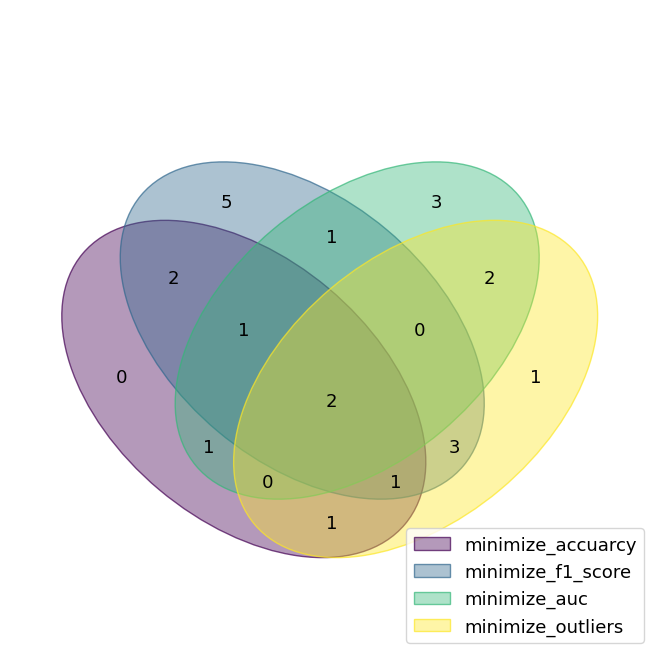

In [130]:
fig = plt.figure( figsize=(8.35,8.35) )   

ax = fig.add_subplot(1,1,1)
venn(genes_dict,  ax=ax)#cmap=Okabe_Ito[1:], 
legend = ax.get_legend()
# legend.get_texts()[0].set_text('Pre vs 1wk')
# legend.get_texts()[1].set_text('Pre vs 3mo')
# legend.get_texts()[2].set_text('Pre vs 6mo')
legend.set_loc('lower right')

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

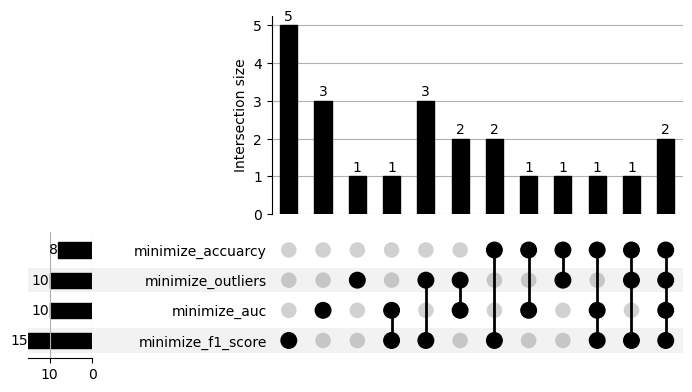

In [135]:
ga_genes = from_contents(genes_dict)
ga_genes['sum_all'] = ga_genes.reset_index().iloc[:,:-1].sum(axis=1).values
upset = UpSet(ga_genes, orientation="horizontal", show_counts=True)#, intersection_plot_elements=0)#, )
upset.plot()

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

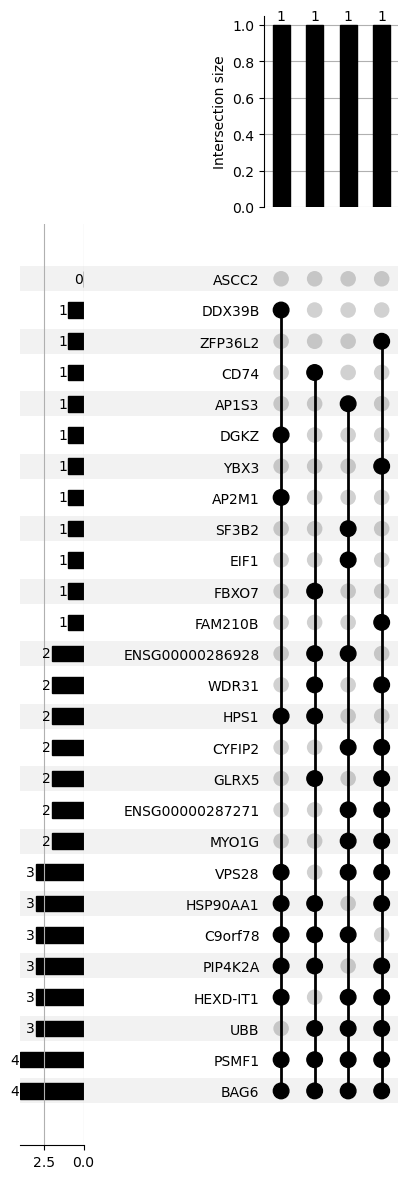

In [142]:
ga_genes = from_contents(genes_dict)
ga_genes['sum_all'] = ga_genes.reset_index().iloc[:,:-1].sum(axis=1).values
upset = UpSet(ga_genes, orientation="horizontal", show_counts=True)#, intersection_plot_elements=0)#, )
upset.plot()

In [159]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes

from upsetplot import UpSet

# Load the dataset into a DataFrame
diabetes = load_diabetes()
diabetes_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Get five features most correlated with median house value
correls = diabetes_df.corrwith(
    pd.Series(diabetes.target), method="spearman"
).sort_values()
top_features = correls.index[-5:]

# Get a binary indicator of whether each top feature is above average
diabetes_above_avg = diabetes_df > diabetes_df.median(axis=0)
diabetes_above_avg = diabetes_above_avg[top_features]
diabetes_above_avg = diabetes_above_avg.rename(columns=lambda x: x + ">")

# Make this indicator mask an index of diabetes_df
diabetes_df = pd.concat([diabetes_df, diabetes_above_avg], axis=1)
diabetes_df = diabetes_df.set_index(list(diabetes_above_avg.columns))

# # Also give us access to the target (median house value)
diabetes_df = diabetes_df.assign(progression=diabetes.target)

In [162]:
# diabetes

In [160]:
diabetes_df

age       sex       bmi        bp  \
s6>   bp>   s4>   bmi>  s5>                                             
False True  False True  True   0.038076  0.050680  0.061696  0.021872   
      False False False False -0.001882 -0.044642 -0.051474 -0.026328   
                  True  True   0.085299  0.050680  0.044451 -0.005670   
            True  False True  -0.089063 -0.044642 -0.011595 -0.036656   
      True  False False False  0.005383 -0.044642 -0.036385  0.021872   
...                                 ...       ...       ...       ...   
True  True  False True  True   0.041708  0.050680  0.019662  0.059744   
      False True  False False -0.005515  0.050680 -0.015906 -0.067642   
      True  False False False  0.041708  0.050680 -0.015906  0.017293   
False True  True  True  True  -0.045472 -0.044642  0.039062  0.001215   
True  False False False False -0.045472 -0.044642 -0.073030 -0.081413   

                                     s1        s2        s3        s4  \
s6>   bp>   s4>   bmi>  s5>                                             
False True  False True  True  -0.044223 -0.034821 -0.043401 -0.002592   
      False False False False -0.008449 -0.019163  0.074412 -0.039493   
                  True  True  -0.045599 -0.034194 -0.032356 -0.002592   
            True  False True   0.012191  0.024991 -0.036038  0.034309   
      True  False False False  0.003935  0.015596  0.008142 -0.002592   
...                                 ...       ...       ...       ...   
True  True  False True  True  -0.005697 -0.002566 -0.028674 -0.002592   
      False True  False False  0.049341  0.079165 -0.028674  0.034309   
      True  False False False -0.037344 -0.013840 -0.024993 -0.011080   
False True  True  True  True   0.016318  0.015283 -0.028674  0.026560   
True  False False False False  0.083740  0.027809  0.173816 -0.039493   

                                     s5        s6  
s6>   bp>   s4>   bmi>  s5>                        
False True  False True  True   0.019907 -0.017646  
      False False False False -0.068332 -0.092204  
                  True  True   0.002861 -0.025930  
            True  False True   0.022688 -0.009362  
      True  False False False -0.031988 -0.046641  
...                                 ...       ...  
True  True  False True  True   0.031193  0.007207  
      False True  False False -0.018114  0.044485  
      True  False False False -0.046883  0.015491  
False True  True  True  True   0.044529 -0.025930  
True  False False False False -0.004222  0.003064  

[442 rows x 10 columns]

In [154]:
# adata.X

In [2625]:
(1/766.0000000000288 )+ 0.5

0.5013054830287206

In [2657]:
for g in np.sort(aux_tost2.columns[np.where(ga_res[0])[0]]):
    print(g, end=',')

ABL2,ANKRD54,ARHGEF1,ASCC2,BABAM1,BAG6,C17orf49,C9orf78,CCDC57,CCNI,CCP110,CD74,COX4I1,CSNK2A2,CTNNBL1,DDX39B,ELK3,ENSG00000230551,ENSG00000272772,ENSG00000291075,ERCC4,ERCC8,FAM104A,FAM210B,FRG1,GUK1,HAGH,HMGXB4,HPS1,HSP90AA1,KTN1,LINC02987,LRRC58,MAF1,MARCHF8,METTL21A,MTF2,NDUFS6,NPHP3,NUDT3,NUTM2B-AS1,ORC2,PHF6,POMK,PSMF1,RABEP1,RBM28,RBSN,RNF123,RNF166,SEPTIN6,SLC50A1,SPTY2D1,TRA2B,TSTD1,UBL7,UBXN2A,UBXN6,ZC3H15,ZNF160,ZNF426,

In [2372]:
np.sort(aux_tost.columns[np.where(ga_res[0])[0]])

array(['ABL2', 'ADD1', 'APPL1', 'ARHGEF1', 'ASCC2', 'ATAD2B', 'ATE1',
       'BABAM1', 'BAG6', 'CBX3', 'CCNI', 'CCP110', 'CDK11B', 'CEP135',
       'COX4I1', 'CRYZL1', 'CUL4A', 'EIF1', 'ENSG00000290993',
       'ENSG00000291075', 'FAM210B', 'FBXL18', 'FBXO7', 'HMGXB4', 'IREB2',
       'ITPR1', 'KIAA1328', 'KLHL24', 'LRRC58', 'MAF1', 'MARCHF8',
       'METTL21A', 'MXI1', 'NAP1L1', 'NPHP3', 'NUDT3', 'NUTM2B-AS1',
       'ORC2', 'PLEKHA3', 'PSMF1', 'PWWP2A', 'RBM28', 'RBM41', 'RO60',
       'SCYL1', 'SF1', 'SGK3', 'SLC50A1', 'SNRNP27', 'SNX29', 'SPTY2D1',
       'TENT4B', 'TMSB10', 'TRA2B', 'U2SURP', 'UBB', 'UBXN6', 'WNK1',
       'ZBTB11', 'ZC3H15', 'ZC3H4', 'ZNF160', 'ZYG11B'], dtype=object)

In [2280]:
np.sort(aux_tost.columns[np.where(ga_res[0])[0]])

array(['ABL2', 'ADD1', 'ALS2', 'ARHGEF1', 'ASCC2', 'ATAD2B', 'ATE1',
       'ATP5F1B', 'CBX3', 'CCDC57', 'CCP110', 'CD74', 'CRYZL1', 'CSNK2A2',
       'DDX39B', 'EBLN3P', 'ELK3', 'ENSG00000230551', 'ENSG00000272772',
       'ENSG00000290993', 'ERCC4', 'ERCC8', 'ERO1B', 'FAM210B', 'GUK1',
       'HSP90AA1', 'IKZF1', 'IREB2', 'ITPR1', 'KLHL24', 'KTN1',
       'LINC02987', 'LRRC58', 'MAF1', 'MARCHF8', 'MBNL1', 'METTL21A',
       'MTREX', 'NDUFA12', 'NPHP3', 'PHF6', 'POMK', 'RABEP1', 'RBM28',
       'RBSN', 'RO60', 'RSBN1', 'SEPTIN6', 'SGK3', 'SLC25A16', 'SNRPB2',
       'SPTY2D1', 'TENT4B', 'TMSB10', 'U2SURP', 'UBB', 'UBXN6', 'WNK1',
       'YBX3', 'ZBTB11', 'ZC3H15', 'ZC3H4', 'ZMAT3'], dtype=object)

In [2271]:
aux_tost.columns[r[0]]

Index(['NUDT3', 'C17orf49', 'C17orf49', 'C17orf49', 'NUDT3', 'C17orf49',
       'C17orf49', 'C17orf49', 'NUDT3', 'NUDT3',
       ...
       'C17orf49', 'C17orf49', 'C17orf49', 'NUDT3', 'C17orf49', 'C17orf49',
       'C17orf49', 'C17orf49', 'NUDT3', 'NUDT3'],
      dtype='object', name='Gene_name', length=125)

In [2273]:
aux_tost.columns[:,np.where(r[0])[0]]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [2277]:
np.sort(aux_tost.columns[np.where(r[0])[0]])

array(['ADD1', 'AP2M1', 'APPL1', 'ATAD2B', 'ATE1', 'BABAM1', 'BAG6',
       'C17orf49', 'C9orf78', 'CCDC57', 'CCP110', 'CD74', 'CDK11B',
       'CTNNBL1', 'CUL4A', 'DAD1', 'EBLN3P', 'EIF1', 'ENSG00000230551',
       'ENSG00000272772', 'ENSG00000290993', 'ENSG00000291075', 'ERCC4',
       'ERO1B', 'FAM104A', 'FAM210B', 'HPS1', 'HYPK', 'IKZF1', 'KTN1',
       'LINC02987', 'LRRC58', 'MAF1', 'MARCHF8', 'MTREX', 'MXI1', 'MYO1G',
       'NAP1L1', 'NDUFA12', 'NUTM2B-AS1', 'ORC2', 'PHF6', 'PIP4K2A',
       'PLEKHA3', 'PSMF1', 'PWWP2A', 'RABEP1', 'RNF123', 'SEPTIN6', 'SF1',
       'SGK3', 'SNRNP27', 'TENT4B', 'TMSB10', 'TRA2B', 'TXNDC12',
       'U2SURP', 'UBB', 'UBXN2A', 'UBXN6', 'VPS28', 'WNK1', 'ZBTB11',
       'ZFP36L2', 'ZNF160'], dtype=object)

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [3135]:
X_ = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'),aux_tost.columns].layers['arcsinh']
y_ = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'),aux_tost.columns].obs['conditions_GSE175718'].values

In [3136]:
y_dict = {y:i for i,y in enumerate(np.unique(y_))}

In [3137]:
y_ = np.array([y_dict[y] for y in y_])

In [3138]:
y_

array([0, 3, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 0, 2, 3, 0,
       3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 0, 3, 0, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 0, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 0, 3, 3, 3, 0, 3, 2, 3, 3,
       3, 0, 3, 2, 2, 3, 0, 0, 2, 3, 3, 3, 0, 3, 2, 3, 3, 3, 3, 0, 3, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3,
       3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 2, 3,
       0, 0, 3, 1, 3, 3, 3, 3, 0, 2, 3, 3, 0, 0, 0, 1, 1, 3, 3, 3, 0, 2,
       2, 3, 1, 2, 0, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 1, 0, 3, 3,
       0, 3, 3, 3, 3, 2, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 3, 3,
       3, 1, 3, 2, 3, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 2,
       3, 0, 3, 3, 2, 0, 3, 3, 3, 3, 2, 2, 3, 3, 3, 0, 2, 2, 3, 1, 2, 3,
       3, 3, 3, 0, 3, 3, 0, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 0, 3, 3, 3, 0,
       3, 3, 3, 3, 0, 0, 3, 1, 3, 3, 3, 3, 3, 2, 2,

In [3122]:
# y_

In [3160]:
y_b = lb.fit_transform(y_)

In [3151]:
clf = SVC(class_weight='balanced', probability=True)
clf.fit(X_, y_)

SVC(class_weight='balanced', probability=True)

In [3152]:
clf.score(X_, y_)

0.4595300261096606

In [3155]:
y_p = clf.predict_proba(X_)

In [3156]:
y_p

array([[0.20985092, 0.05445939, 0.1353189 , 0.60037078],
       [0.18311947, 0.04904876, 0.11538078, 0.652451  ],
       [0.14633617, 0.03113586, 0.1049499 , 0.71757806],
       ...,
       [0.15444246, 0.03095018, 0.16439699, 0.65021037],
       [0.17499356, 0.04930177, 0.11783915, 0.65786552],
       [0.12915314, 0.03373209, 0.12267066, 0.71444411]])

In [3158]:
f1_score(y_, clf.predict(X_), average='weighted')

0.4760776222610393

In [3159]:
# y_p

In [3165]:
roc_auc_score(lb.fit_transform(y_), y_p, average='weighted', multi_class='ovo')

0.6744506454697639

In [2304]:
np.abs(1/(-0.5-0.500001))

0.9999990000009998

In [1933]:
i = 0
for a in adata.X[:,2637]:
    i+=1
print(i)

635


In [1937]:
adata.X.shape[1]

2638

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KeyError: ('ACIN1', 'ABMR')

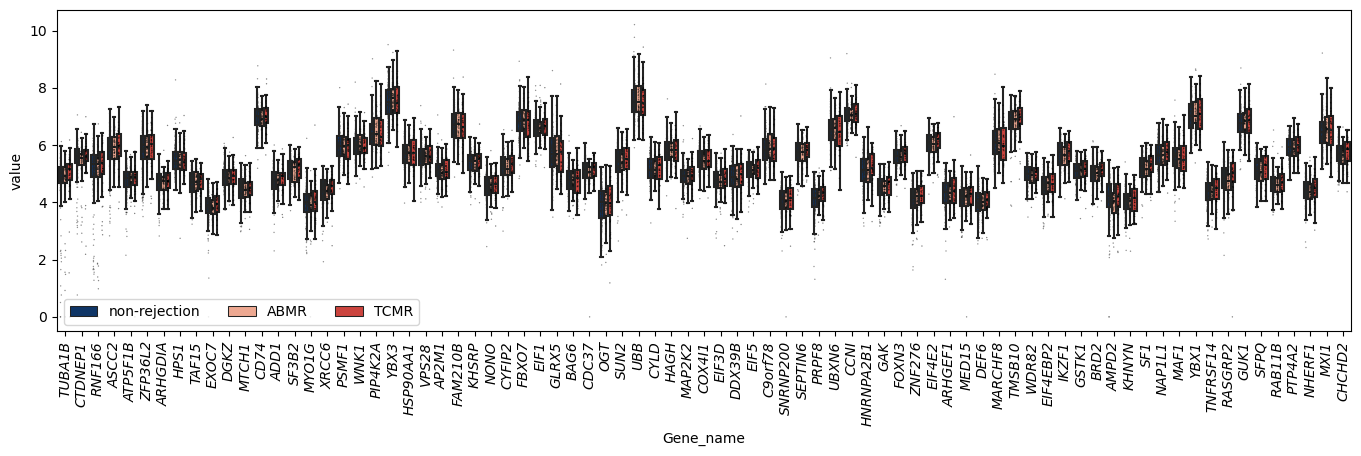

In [1881]:
fig = plt.figure(figsize=(8.35*2,8.35/2))
# fig = plt.figure(figsize=(8.35*2,8.35))
ax = fig.add_subplot(111)
x='Gene_name'
y='value'
order = aux_tost.columns[2:]
hue_order = ['non-rejection','ABMR','TCMR']#,'ABMR and TCMR']
hue='conditions'
data = aux.iloc[:,:-1].melt(id_vars=hue)

sns.stripplot(x=x, y=y, hue=hue, order=order, hue_order=hue_order, dodge=True, color='black', s=1, alpha=.5, data=data, ax=ax)
sns.boxplot(x, y=y,hue=hue, order=order, hue_order=hue_order, palette=['#003375', '#fca082', '#e32f27', '#67000d'], fliersize=0, data=data, ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, style='italic')

ax.legend(handles=ax.get_legend_handles_labels()[0][3:], labels=ax.get_legend_handles_labels()[1][3:], loc='lower left', ncols=3)

annot = Annotator(ax, pairs, x=x, y=y, order=order, hue=hue, hue_order=hue_order, data=data)
annot.configure(test=None, text_format='star', loc='inside', verbose=0, hide_non_significant=True)
annot.set_pvalues(pvalues=pvalues)
# annot.apply_test()
ax, test_results = annot.annotate()

In [976]:
# delta#[g]
np.sqrt((np.square(aux[aux['conditions'].isin(p)].groupby('conditions').std())/aux[aux['conditions'].isin(p)].groupby('conditions').count()).sum(axis=0))

Gene_name
AKNA         0.608897
ARHGEF1      5.391275
BTG1        14.902301
CALM1       15.065814
CCNI         4.855813
CD74        24.305158
CELF2        2.240672
CSDE1        3.934633
DDX17        4.178020
DDX5         9.185267
EIF1         8.453399
FAM210B     10.471748
FBXO7        7.567217
GUK1        13.808400
HNRNPC      10.284393
HNRNPU       3.015825
ITGAL        1.709711
MT-CO1      14.612409
N4BP2L2      4.825755
NLRP1        3.947837
PABPC1      21.882183
PCBP2        7.455861
PPIA         3.299009
RPS9        40.981727
SON         19.476256
SRRM2       11.568197
SUN2         0.849656
TMSB10      91.141007
TRIM56       0.728706
UBB        146.144930
UBC          2.981293
UBXN6        5.736228
YBX1        10.808055
YBX3        22.707380
dtype: float64

/tmp/ipykernel_27703/1550477943.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.DataFrame(dict_pairs, index=aux.columns[:-2]).T[pd.DataFrame(dict_pairs, index=aux.columns[:-2]).T.reset_index().mean().sort_values().index].reset_index()


Gene_name        level_0        level_1      GUK1       UBB   FAM210B  \
0                   ABMR  non-rejection  0.111194  0.076041  0.042907   
1                   ABMR           TCMR  0.039053  0.113853  0.090612   
2                   ABMR  ABMR and TCMR  0.003133  0.011079  0.062522   
3          non-rejection           TCMR  0.090590  0.038472  0.053132   
4          non-rejection  ABMR and TCMR  0.001736  0.017552  0.033863   
5                   TCMR  ABMR and TCMR  0.010707  0.037027  0.029811   

Gene_name     UBXN6      EIF1      YBX3    TMSB10   ARHGEF1  ...       SON  \
0          0.041821  0.044862  0.203479  0.134379  0.072451  ...  0.036841   
1          0.049180  0.037692  0.118107  0.082872  0.210905  ...  0.509776   
2          0.057467  0.079780  0.058699  0.000591  0.027008  ...  0.014574   
3          0.059899  0.084558  0.026617  0.280168  0.117563  ...  0.579076   
4          0.064929  0.077935  0.021633  0.000459  0.019883  ...  0.012723   
5          0.060576  0.128622  0.062262  0.002896  0.063985  ...  0.156771   

Gene_name      SUN2     NLRP1    HNRNPC       UBC      AKNA     SRRM2  \
0          0.054563  0.127037  0.051636  0.168131  0.023793  0.042361   
1          0.179401  0.318792  0.593633  0.589403  0.593633  0.694694   
2          0.176482  0.029055  0.015792  0.030490  0.031984  0.027676   
3          0.132419  0.682894  0.592445  0.415987  0.723469  0.807700   
4          0.310183  0.071204  0.014379  0.059846  0.046140  0.039209   
5          0.524939  0.166993  0.174041  0.272692  0.366712  0.291473   

Gene_name      RPS9    MT-CO1      BTG1  
0          0.268537  0.224500  0.815921  
1          0.733544  0.751123  0.866125  
2          0.497883  0.032753  0.211430  
3          0.406153  0.592445  0.198279  
4          0.236283  0.141885  0.059092  
5          0.034833  0.530472  0.268092  

[6 rows x 36 columns]

In [946]:
delta = cohens_d*np.sqrt((np.square(aux[aux['conditions'].isin(p)].groupby('conditions').std())/aux[aux['conditions'].isin(p)].groupby('conditions').count()).sum(axis=0))
delta#['ARHGEF1']

Gene_name
AKNA        0.182669
ARHGEF1     1.617383
BTG1        4.470690
CALM1       4.519744
CCNI        1.456744
CD74        7.291547
CELF2       0.672202
CSDE1       1.180390
DDX17       1.253406
DDX5        2.755580
EIF1        2.536020
FAM210B     3.141524
FBXO7       2.270165
GUK1        4.142520
HNRNPC      3.085318
HNRNPU      0.904747
ITGAL       0.512913
MT-CO1      4.383723
N4BP2L2     1.447727
NLRP1       1.184351
PABPC1      6.564655
PCBP2       2.236758
PPIA        0.989703
RPS9       12.294518
SON         5.842877
SRRM2       3.470459
SUN2        0.254897
TMSB10     27.342302
TRIM56      0.218612
UBB        43.843479
UBC         0.894388
UBXN6       1.720868
YBX1        3.242417
YBX3        6.812214
dtype: float64

In [943]:
max(ttest_ind(aux[aux['conditions']==p[0]].AKNA.values, aux[aux['conditions']==p[1]].AKNA.values+.7, alternative='less').pvalue, ttest_ind(aux[aux['conditions']==p[0]].AKNA.values, aux[aux['conditions']==p[1]].AKNA.values-.7, alternative='greater').pvalue)

0.10274217909699401

In [885]:
# p = ('ABMR', 'non-rejection')
p = ('ABMR', 'TCMR')
sd2_by_n = np.square(aux[aux['conditions'].isin(p)].groupby('conditions').std())/aux[aux['conditions'].isin(p)].groupby('conditions').count()
sd2_by_n

Gene_name       AKNA    ARHGEF1       BTG1      CALM1      CCNI        CD74  \
conditions                                                                    
ABMR        0.093326   2.575234  39.554327  32.018363  7.135869   85.023512   
TCMR        0.117168  18.828676  49.153421  53.449365  7.394665  267.763036   

Gene_name      CELF2     CSDE1     DDX17       DDX5  ...         SON  \
conditions                                           ...               
ABMR        1.372598  2.692787  2.939964   8.381774  ...   72.823491   
TCMR        1.419537  5.368133  3.330607  13.889937  ...  110.851777   

Gene_name       SRRM2      SUN2       TMSB10    TRIM56          UBB       UBC  \
conditions                                                                      
ABMR        38.671305  0.198410  1455.767656  0.074780  3493.787905  2.238072   
TCMR        42.134120  0.314546  3077.469514  0.078926  3021.286144  1.857871   

Gene_name      UBXN6       YBX1        YBX3  
conditions                                   
ABMR        5.412051  29.514986  162.043061  
TCMR        7.875352  34.854369  138.633898  

[2 rows x 34 columns]

In [886]:
sd = np.sqrt(sd2_by_n.sum(axis=0))

In [894]:
delta_u = 0.3*sd
delta_l = -0.3*sd

In [895]:
tu = (aux[aux['conditions'].isin(p)].groupby('conditions').mean().diff().iloc[[1],:] - (delta_u)) / sd
tu.index = ['tu']
tl = (aux[aux['conditions'].isin(p)].groupby('conditions').mean().diff().iloc[[1],:] - (delta_l)) / sd
tl.index = ['tl']

In [896]:
df = np.sqrt(sd2_by_n.sum())/( (np.sqrt(sd2_by_n)/(aux[aux['conditions'].isin(p)].groupby('conditions').count()-1)).sum() )

In [897]:
aux2 = pd.concat([tu,tl,pd.DataFrame(df, columns=['df']).T])
aux2

Gene_name       AKNA    ARHGEF1       BTG1      CALM1       CCNI       CD74  \
tu         -0.055345   0.812240   0.598379  -0.048378  -0.563040   0.188859   
tl          0.544655   1.412240   1.198379   0.551622   0.036960   0.788859   
df         39.738886  41.121429  39.748868  39.566000  39.971031  39.829749   

Gene_name      CELF2      CSDE1      DDX17       DDX5  ...        SON  \
tu          0.103121   0.295825   0.074207   0.546945  ...   1.321311   
tl          0.703121   0.895825   0.674207   1.146945  ...   1.921311   
df         39.973954  39.555921  39.851326  39.567972  ...  39.600185   

Gene_name      SRRM2       SUN2     TMSB10     TRIM56        UBB        UBC  \
tu          0.345390  -0.002060  -0.040214  -0.406552  -1.823779  -0.274415   
tl          0.945390   0.597940   0.559786   0.193448  -1.223779   0.325585   
df         39.901151  39.582615  39.567957  39.944712  40.277997  40.359243   

Gene_name      UBXN6       YBX1       YBX3  
tu         -0.784693  -0.181745  -0.962697  
tl         -0.184693   0.418255  -0.362697  
df         39.624351  39.802610  40.298882  

[3 rows x 34 columns]

In [901]:
from scipy.stats import t, wald, ttest_ind

In [922]:
ttest_ind(aux[aux['conditions']=='ABMR'].AKNA.values, aux[aux['conditions']=='TCMR'].AKNA.values+.7, alternative='less')
ttest_ind(aux[aux['conditions']=='ABMR'].AKNA.values, aux[aux['conditions']=='TCMR'].AKNA.values-.7, alternative='greater')

TtestResult(statistic=-1.7595345311208912, pvalue=0.04056156153844134, df=116.0)

TtestResult(statistic=1.2732235488683017, pvalue=0.10274217909699401, df=116.0)

In [926]:
# aux.groupby('conditions').apply(ttest_ind())#*.3

In [917]:
aux.groupby('conditions').mean().diff()

Gene_name          AKNA   ARHGEF1      BTG1     CALM1      CCNI       CD74  \
conditions                                                                   
ABMR                NaN       NaN       NaN       NaN       NaN        NaN   
ABMR and TCMR -0.470632  1.360850  8.559071  3.725176 -5.665422 -10.975492   
TCMR           0.582879  3.784857 -0.097704 -1.398963  4.662741  20.157543   
non-rejection -0.304411 -5.333676  2.498496 -4.198870 -0.970004  -8.148778   

Gene_name         CELF2     CSDE1     DDX17      DDX5  ...        SON  \
conditions                                             ...              
ABMR                NaN       NaN       NaN       NaN  ...        NaN   
ABMR and TCMR  0.233490 -1.528953  0.780599  5.452283  ... -12.632333   
TCMR           0.440112  3.220605  0.156458 -1.455302  ...  34.605451   
non-rejection -1.012148 -3.635791 -1.305534 -4.764821  ... -21.181445   

Gene_name          SRRM2      SUN2     TMSB10    TRIM56         UBB       UBC  \
conditions                                                                      
ABMR                 NaN       NaN        NaN       NaN         NaN       NaN   
ABMR and TCMR  -4.247128 -1.059268 -15.820635  0.115245    0.530473 -0.679240   
TCMR           10.048662  1.272655  33.311850 -0.157019 -123.523867  0.731020   
non-rejection  -6.814990 -0.334153 -62.986122 -0.032521   67.374730  0.207341   

Gene_name         UBXN6      YBX1       YBX3  
conditions                                    
ABMR                NaN       NaN        NaN  
ABMR and TCMR -6.135570 -7.656972 -36.243828  
TCMR           4.368773  8.605742  24.752631  
non-rejection  4.967247 -3.058083  -4.616623  

[4 rows x 34 columns]

In [899]:
pv = []
for col in aux2.columns:
    pv.append( max(t.sf(aux2.loc['tu',col], aux2.loc['df',col]), t.sf(aux2.loc['tl',col], aux2.loc['df',col])) )
    # pass

In [900]:
pv

[0.5219294054178263,
 0.2106656471250452,
 0.27649078413841327,
 0.5191708783133998,
 0.711723747209032,
 0.4255811739981248,
 0.45919130555680077,
 0.38445562364391167,
 0.4706083388386296,
 0.29374400726913297,
 0.8723017013561485,
 0.5146650913684029,
 0.9793269086857861,
 0.5932757473545991,
 0.18899855598764287,
 0.6319134632295279,
 0.46153047830991795,
 0.18336365721715447,
 0.21057474510087337,
 0.6870818576024258,
 0.5795572573639218,
 0.8172629692073857,
 0.29264512924538727,
 0.10885405915353995,
 0.09699073800481375,
 0.3658075690852102,
 0.5008167905167293,
 0.5159376236525941,
 0.6567463896692425,
 0.962194198142378,
 0.6074172266721375,
 0.7813499206355867,
 0.5716471777015253,
 0.8292795846255575]

In [827]:
t.sf(2.076802, 16.523486)

0.026876808720487574

In [824]:
# wald.sf(0.657270	, 16.633016)

In [609]:
order

array([11, 33, 12, 13, 31, 24, 29,  4, 32,  3, 20,  0, 26,  1, 16, 14, 21,
       25, 15, 19,  2,  6, 18,  7,  8,  9, 17, 27,  5, 23, 28, 10, 22, 30],
      dtype=int32)

In [473]:
Z=sch.linkage(aux_R.astype(float), method='ward')
order = sch.leaves_list(Z)
order

array([11, 33, 12, 13, 31, 24, 29,  4, 32,  3, 20,  0, 26,  1, 16, 14, 21,
       25, 15, 19,  2,  6, 18,  7,  8,  9, 17, 27,  5, 23, 28, 10, 22, 30],
      dtype=int32)

Gene_name_x
0      8
1      7
2     25
3     23
4     21
5      4
6      2
7     28
8     31
9     29
10    29
11    31
12    31
13    31
14    31
15    31
16    30
17    29
18    28
19    29
20    21
21    25
22    24
23    25
24    25
25    25
26    23
27    21
28    21
29    17
30    26
31    31
32    30
33    30
Name: Gene_name_y, dtype: int64

In [570]:
order

Index(['AKNA', 'EIF1', 'YBX1', 'ARHGEF1', 'ITGAL', 'HNRNPC', 'SUN2', 'PCBP2',
       'PPIA', 'UBC', 'SRRM2', 'NLRP1', 'PABPC1', 'CALM1', 'HNRNPU', 'CCNI',
       'TRIM56', 'DDX5', 'DDX17', 'FBXO7', 'CSDE1', 'CELF2', 'N4BP2L2',
       'MT-CO1', 'GUK1', 'TMSB10', 'CD74', 'UBXN6', 'BTG1', 'RPS9', 'FAM210B',
       'YBX3', 'SON', 'UBB'],
      dtype='object', name='Gene_name_x')

In [479]:
dict(zip(aux_R.columns[order],range(len(aux_R.columns))))

{'FAM210B': 0,
 'YBX3': 1,
 'FBXO7': 2,
 'GUK1': 3,
 'UBXN6': 4,
 'SON': 5,
 'UBB': 6,
 'CCNI': 7,
 'YBX1': 8,
 'CALM1': 9,
 'PABPC1': 10,
 'AKNA': 11,
 'SUN2': 12,
 'ARHGEF1': 13,
 'ITGAL': 14,
 'HNRNPC': 15,
 'PCBP2': 16,
 'SRRM2': 17,
 'HNRNPU': 18,
 'NLRP1': 19,
 'BTG1': 20,
 'CELF2': 21,
 'N4BP2L2': 22,
 'CSDE1': 23,
 'DDX17': 24,
 'DDX5': 25,
 'MT-CO1': 26,
 'TMSB10': 27,
 'CD74': 28,
 'RPS9': 29,
 'TRIM56': 30,
 'EIF1': 31,
 'PPIA': 32,
 'UBC': 33}

In [487]:
aux

gene_pair         R pvalue  Gene_name_x  Gene_name_y
0       AKNA,AKNA       1.0    0.0           11           11
1    AKNA,ARHGEF1  0.946498    0.0           11           13
2       AKNA,BTG1  0.602144    0.0           11           20
3      AKNA,CALM1  0.764692    0.0           11            9
4       AKNA,CCNI  0.745968    0.0           11            7
..            ...       ...    ...          ...          ...
590    UBXN6,YBX1  0.731231    0.0            8            4
591    UBXN6,YBX3   0.49913    0.0            1            4
592     YBX1,YBX1       1.0    0.0            8            8
593     YBX1,YBX3  0.646757    0.0            1            8
594     YBX3,YBX3       1.0    0.0            1            1

[1190 rows x 5 columns]

In [456]:
aux

gene_pair         R pvalue Gene_name_x Gene_name_y
0       AKNA,AKNA       1.0    0.0        AKNA        AKNA
1    AKNA,ARHGEF1  0.946498    0.0        AKNA     ARHGEF1
2       AKNA,BTG1  0.602144    0.0        AKNA        BTG1
3      AKNA,CALM1  0.764692    0.0        AKNA       CALM1
4       AKNA,CCNI  0.745968    0.0        AKNA        CCNI
..            ...       ...    ...         ...         ...
590    UBXN6,YBX1  0.731231    0.0        YBX1       UBXN6
591    UBXN6,YBX3   0.49913    0.0        YBX3       UBXN6
592     YBX1,YBX1       1.0    0.0        YBX1        YBX1
593     YBX1,YBX3  0.646757    0.0        YBX3        YBX1
594     YBX3,YBX3       1.0    0.0        YBX3        YBX3

[1190 rows x 5 columns]

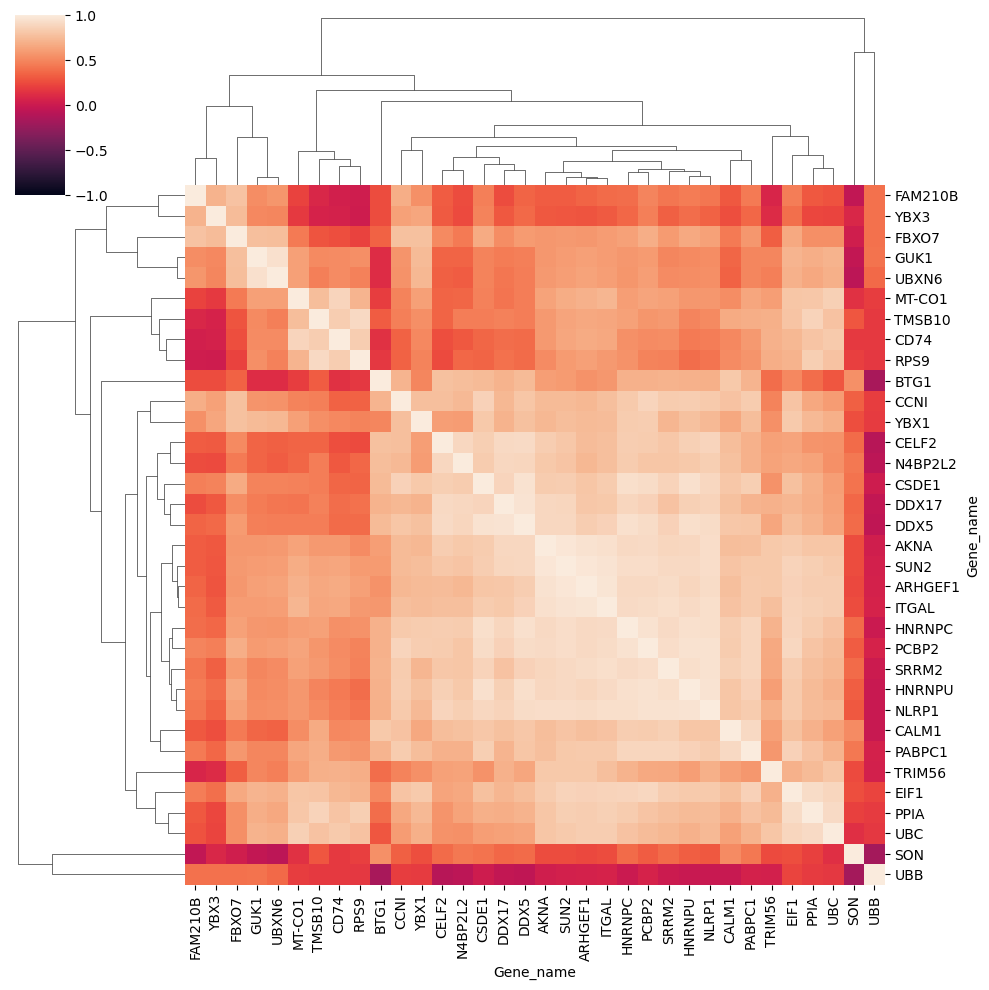

In [276]:
sns.clustermap(adata[:,adata.var.uclustering_cv_stb_labels.isin([19])].to_df().corr(), vmin=-1, vmax=1)

In [274]:
adata[:,adata.var.uclustering_cv_stb_labels.isin([19])]

View of AnnData object with n_obs × n_vars = 635 × 34
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'uclustering_cv_stb_labels'
    layers: 'count', 'trns_expr', 'log1p', 'arcsinh'

In [118]:
hue_order = adata.var['uclustering_cv_stb_labels'].unique()
cmap = cm.get_cmap('Spectral', len(hue_order))
cmap = [colors.to_hex(cmap(i)) for i in range(len(hue_order))]

/tmp/ipykernel_27703/1230611814.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral', len(hue_order))


In [121]:
dict(zip(hue_order,cmap))

{17: '#9e0142',
 20: '#b71d48',
 2: '#d0384e',
 5: '#e04f4b',
 0: '#ee6445',
 15: '#f67f4b',
 14: '#fb9c59',
 7: '#fdb769',
 3: '#fece7c',
 6: '#fee390',
 10: '#fff1a7',
 1: '#ffffbf',
 11: '#f4faad',
 4: '#e8f69c',
 13: '#d1ec9c',
 9: '#b6e1a2',
 18: '#98d6a4',
 12: '#79c9a5',
 16: '#5db7a9',
 21: '#459db4',
 19: '#3683bb',
 8: '#4a69ae',
 22: '#5e4fa2'}

In [112]:
zip(hue_order,list(cmap))

TypeError: 'LinearSegmentedColormap' object is not iterable

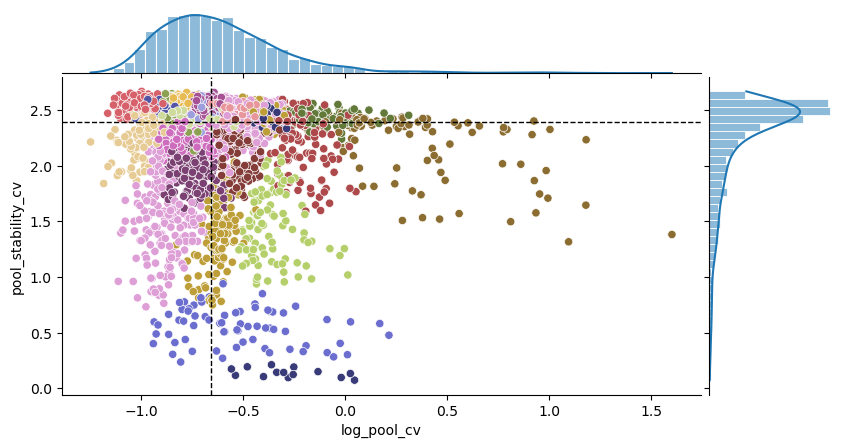

In [79]:
hkg.plot.plot_stb_cv(adata, x='log_pool_cv', y='pool_stability_cv', hue='uclustering_cv_stb_labels', palette='tab20b_r')

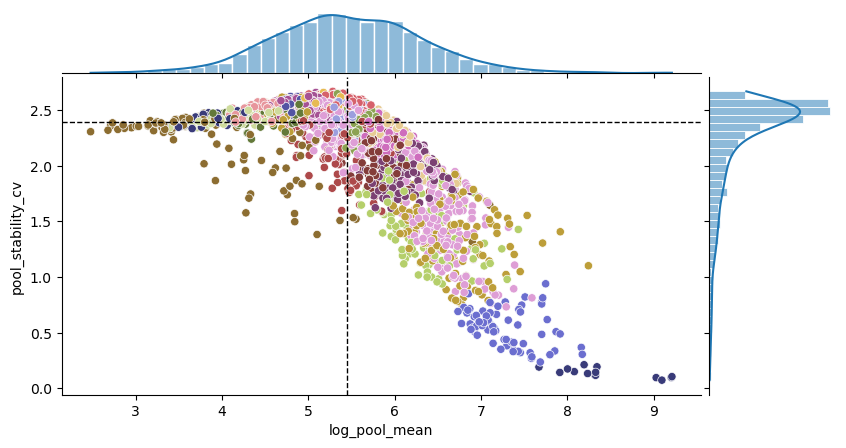

In [68]:
hkg.plot.plot_stb_cv(adata, x='log_pool_mean', y='pool_stability_cv', hue='uclustering_cv_stb_labels', palette='tab20b_r')

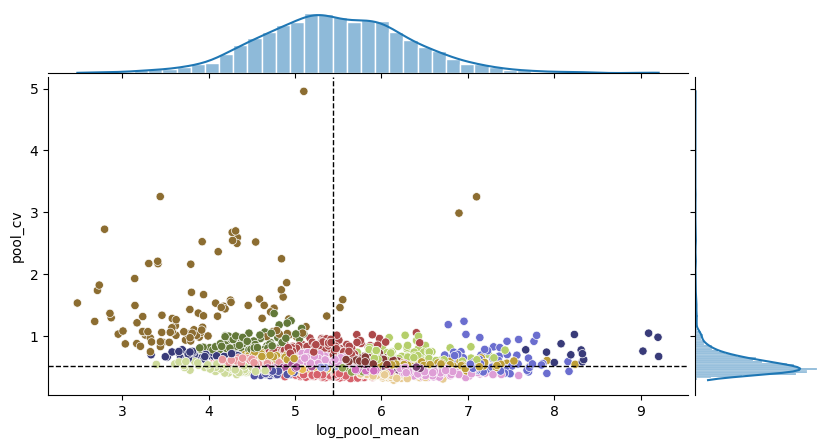

In [72]:
hkg.plot.plot_stb_cv(adata, x='log_pool_mean', y='pool_cv', hue='uclustering_cv_stb_labels', palette='tab20b_r')

In [78]:
adata.var.sort_values(['pool_cv'])

equivalent    pool_mean     pool_std   pool_cv  \
Gene_name                                                         
RETREG3          equivalent   464.447519   133.429236  0.287286   
SEC61A1          equivalent   821.475387   251.592166  0.306269   
TRAPPC3          equivalent   281.977464    88.086752  0.312389   
VPS4A            equivalent   544.308968   170.289978  0.312855   
YKT6             equivalent   481.571599   152.711864  0.317111   
...                     ...          ...          ...       ...   
ENSG00000280187  equivalent    16.333367    44.527303  2.726156   
CEBPZOS          equivalent   989.879426  2956.677986  2.986907   
LDB1             equivalent  1213.351031  3943.922042  3.250438   
ENSG00000225489  equivalent    31.113444   101.243465  3.254010   
RN7SL524P        equivalent   164.143368   813.214821  4.954296   

                 pool_stability_cv  uclustering_cv_stb_labels  log_pool_mean  \
Gene_name                                                                      
RETREG3                   2.212354                          9       6.140849   
SEC61A1                   1.839045                          9       6.711102   
TRAPPC3                   2.470074                          6       5.641827   
VPS4A                     1.991594                          9       6.299517   
YKT6                      2.265752                          9       6.177055   
...                            ...                        ...            ...   
ENSG00000280187           2.324789                         13       2.793210   
CEBPZOS                   1.316119                         13       6.897583   
LDB1                      1.645002                         13       7.101141   
ENSG00000225489           2.231980                         13       3.437640   
RN7SL524P                 1.381544                         13       5.100740   

                 log_pool_cv  log_pool_stability_cv  
Gene_name                                            
RETREG3            -1.247277               0.794057  
SEC61A1            -1.183293               0.609247  
TRAPPC3            -1.163505               0.904248  
VPS4A              -1.162014               0.688936  
YKT6               -1.148502               0.817907  
...                      ...                    ...  
ENSG00000280187     1.002892               0.843629  
CEBPZOS             1.094238               0.274688  
LDB1                1.178790               0.497742  
ENSG00000225489     1.179888               0.802889  
RN7SL524P           1.600255               0.323202  

[2638 rows x 9 columns]

In [74]:
adata.var[adata.var.uclustering_cv_stb_labels==0]

equivalent   pool_mean    pool_std   pool_cv  pool_stability_cv  \
Gene_name                                                                    
ABCC1      equivalent  234.119746  130.986209  0.559484           2.486128   
ACBD5      equivalent  184.998980  123.351452  0.666768           2.465751   
ADAT1      equivalent  207.492442  139.229083  0.671008           2.289785   
AFF4       equivalent  219.761851  144.541261  0.657718           2.370907   
AIDA       equivalent  259.976907  147.570523  0.567629           2.299518   
...               ...         ...         ...       ...                ...   
ZNF224     equivalent  167.627029   99.297819  0.592374           2.572436   
ZNF318     equivalent  156.081624   88.271785  0.565549           2.584763   
ZNF333     equivalent  235.706692  146.038906  0.619579           2.556455   
ZNF814     equivalent  177.155200   99.433289  0.561278           2.448149   
ZYG11B     equivalent  165.934215  106.744190  0.643292           2.290213   

           uclustering_cv_stb_labels  log_pool_mean  log_pool_cv  \
Gene_name                                                          
ABCC1                              0       5.455833    -0.580741   
ACBD5                              0       5.220350    -0.405313   
ADAT1                              0       5.335095    -0.398974   
AFF4                               0       5.392544    -0.418979   
AIDA                               0       5.560593    -0.566287   
...                              ...            ...          ...   
ZNF224                             0       5.121741    -0.523618   
ZNF318                             0       5.050379    -0.569959   
ZNF333                             0       5.462588    -0.478715   
ZNF814                             0       5.177026    -0.577539   
ZYG11B                             0       5.111591    -0.441156   

           log_pool_stability_cv  
Gene_name                         
ABCC1                   0.910727  
ACBD5                   0.902496  
ADAT1                   0.828458  
AFF4                    0.863272  
AIDA                    0.832700  
...                          ...  
ZNF224                  0.944853  
ZNF318                  0.949634  
ZNF333                  0.938622  
ZNF814                  0.895332  
ZYG11B                  0.828645  

[214 rows x 9 columns]

In [142]:
adata_hkg = adata[:,adata.var.uclustering_cv_stb_labels==0]

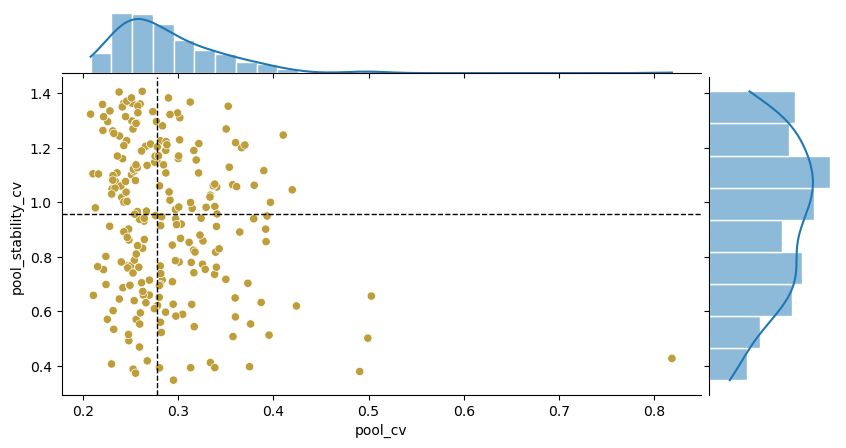

In [153]:
hkg.plot.plot_stb_cv(adata_hkg, hue='uclustering_cv_stb_labels', palette='tab20b_r')

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


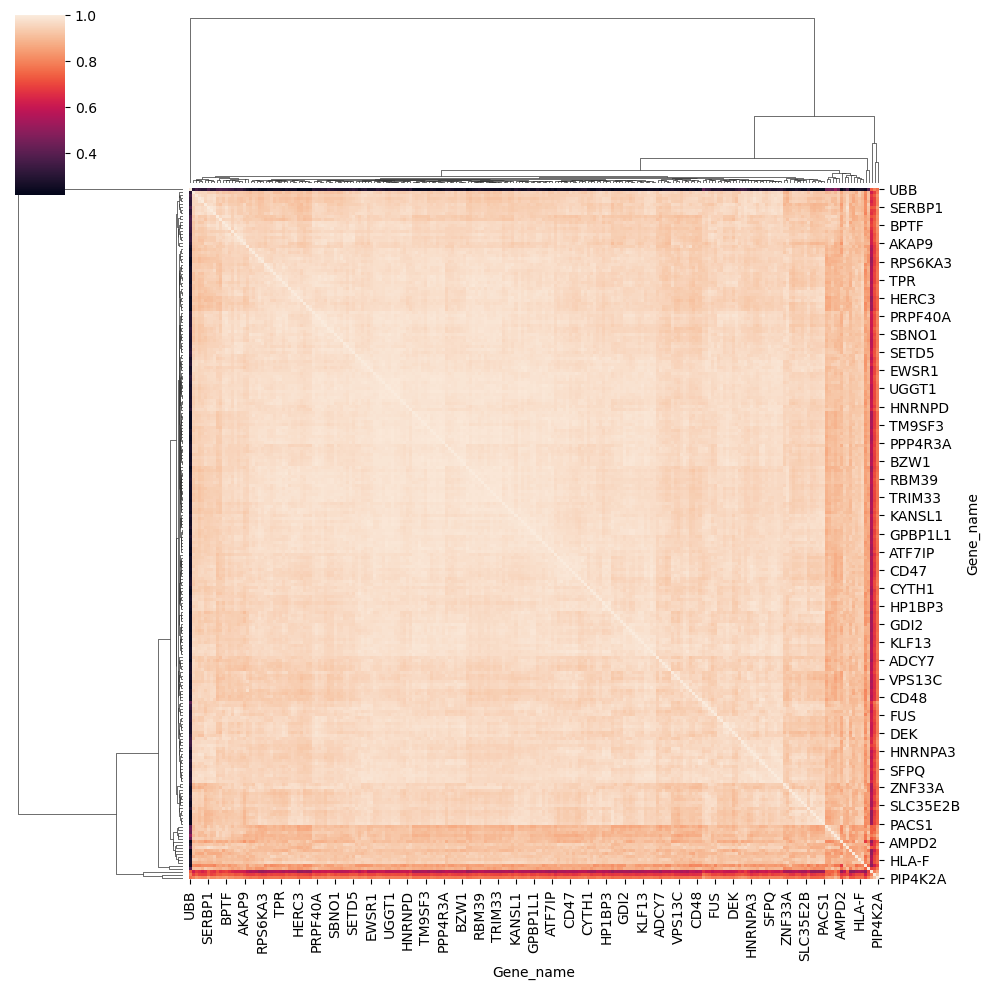

In [152]:
sns.clustermap(adata_hkg.to_df('trns_expr').corr())

In [173]:
adata_hkg[:,['UBB','EIF4H','TMSB10','RPS9','EIF1','RBM39']].var

equivalent    pool_mean     pool_std   pool_cv  pool_stability_cv  \
Gene_name                                                                      
UBB        equivalent  4796.869107  3927.590136  0.818782           0.427551   
EIF4H      equivalent  3433.443765   793.445517  0.231093           1.261990   
TMSB10     equivalent  4954.619673  2430.832161  0.490619           0.379480   
RPS9       equivalent  4892.449562  1531.054207  0.312942           0.393388   
EIF1       equivalent  5753.851900  1696.981637  0.294930           0.347736   
RBM39      equivalent  6082.800811  1397.348592  0.229721           0.407133   

           uclustering_cv_stb_labels  
Gene_name                             
UBB                                0  
EIF4H                              0  
TMSB10                             0  
RPS9                               0  
EIF1                               0  
RBM39                              0

In [143]:
ga_res = hkg.mining.hkg_selection_ga(adata_hkg, layer='trns_expr', fitness_function='minimize_outliers')
ga_res

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


(array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 1]),
 448,
 0)

In [144]:
adata_hkg[:,np.where(ga_res[0])[0]].var

equivalent    pool_mean     pool_std   pool_cv  pool_stability_cv  \
Gene_name                                                                      
ACIN1      equivalent  3186.571273   766.074743  0.240407           1.018354   
ADCY7      equivalent  4591.320367  1463.437920  0.318740           1.155244   
ADD1       equivalent  3818.694902   854.746209  0.223832           0.801748   
ADD3       equivalent  6492.837587  1682.560599  0.259141           0.469192   
AMPD2      equivalent  3264.405405  1154.021615  0.353517           1.128882   
...               ...          ...          ...       ...                ...   
XIAP       equivalent  2415.016111   590.628360  0.244565           1.076559   
YTHDC1     equivalent  2260.342950   577.611922  0.255542           1.289374   
ZNF207     equivalent  4009.054497   998.805660  0.249137           0.695792   
ZNF33A     equivalent  2808.625136   784.048468  0.279157           1.171027   
ZZEF1      equivalent  2967.610776   810.546006  0.273131           1.332917   

           uclustering_cv_stb_labels  
Gene_name                             
ACIN1                              0  
ADCY7                              0  
ADD1                               0  
ADD3                               0  
AMPD2                              0  
...                              ...  
XIAP                               0  
YTHDC1                             0  
ZNF207                             0  
ZNF33A                             0  
ZZEF1                              0  

[111 rows x 6 columns]

In [146]:
adata_hkg2 = adata_hkg[:,np.where(ga_res[0])[0]]
adata_hkg2

View of AnnData object with n_obs × n_vars = 496 × 111
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'louvain_group_updated', 'type'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'uclustering_cv_stb_labels'
    layers: 'count', 'log1p', 'arcsinh', 'trns_expr'

In [147]:
ga_res2 = hkg.mining.hkg_selection_ga(adata_hkg2, layer='trns_expr', fitness_function='minimize_outliers')
ga_res2

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


(array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1]),
 447,
 0)

In [148]:
adata_hkg2[:,np.where(ga_res2[0])[0]].var

equivalent    pool_mean     pool_std   pool_cv  pool_stability_cv  \
Gene_name                                                                      
AMPD2      equivalent  3264.405405  1154.021615  0.353517           1.128882   
ARF6       equivalent  2944.162456   887.853991  0.301564           1.310285   
ARGLU1     equivalent  3507.528538  1109.474926  0.316312           0.741810   
ARHGEF1    equivalent  6156.665984  1527.369617  0.248084           0.861809   
BRD2       equivalent  4625.108010  1246.135348  0.269428           0.659689   
C16orf54   equivalent  3885.501251   962.796919  0.247792           0.902143   
C6orf62    equivalent  6424.326990  1642.570128  0.255680           0.570443   
CDC42SE2   equivalent  6391.038947  1620.827112  0.253609           0.639264   
CGGBP1     equivalent  3242.011650   786.493145  0.242594           1.363814   
CHD4       equivalent  3601.424579   887.299414  0.246375           0.767491   
CTNNB1     equivalent  2965.074664   653.093899  0.220262           1.359088   
CYFIP2     equivalent  4522.702286  1257.899564  0.278130           0.621538   
DDX39B     equivalent  4951.306999  1390.503263  0.280836           0.698899   
DGKZ       equivalent  2295.804379   637.239752  0.277567           1.156574   
EDEM1      equivalent  3081.488538   921.853590  0.299159           1.327951   
EIF4H      equivalent  3433.443765   793.445517  0.231093           1.261990   
FGD5-AS1   equivalent  3161.560860   713.658270  0.225730           1.295994   
FNBP1      equivalent  4603.265460  1068.234260  0.232060           0.534195   
GLG1       equivalent  3417.843475  1159.009554  0.339106           0.817263   
GPBP1L1    equivalent  3293.075188   726.782944  0.220700           1.263695   
HLA-F      equivalent  3687.830146  1253.734708  0.339965           0.762144   
HNRNPH3    equivalent  3038.550733   879.971876  0.289602           1.383005   
HNRNPUL1   equivalent  2994.410235   737.493044  0.246290           0.871603   
HP1BP3     equivalent  3567.059525  1115.830387  0.312815           0.999407   
IST1       equivalent  2839.936337   654.282436  0.230386           1.049501   
ITGA5      equivalent  3380.129198   973.532673  0.288016           1.211058   
KANSL1     equivalent  2511.950636   587.392685  0.233839           1.076957   
KMT2E      equivalent  5695.948144  1596.096370  0.280216           0.392832   
LPIN2      equivalent  4120.578745  1441.840729  0.349912           0.717472   
LSM14A     equivalent  3006.173645   685.748405  0.228113           1.335369   
MDM4       equivalent  3557.293875  1047.936133  0.294588           0.626224   
NPIPB5     equivalent  3440.603717  1411.354513  0.410205           1.246794   
PPP1R15B   equivalent  3735.355227   863.970337  0.231295           1.098302   
PPP4R3B    equivalent  3194.757058   785.283078  0.245804           1.371096   
PRDM2      equivalent  2471.004612   607.168402  0.245717           1.226132   
PRPF40A    equivalent  2654.412838   644.473919  0.242793           1.001236   
PTGES3     equivalent  2584.302256   775.187719  0.299960           1.160483   
RAPGEF1    equivalent  2644.445944   734.881734  0.277896           1.203415   
RBM33      equivalent  2622.087574   685.230043  0.261330           1.188403   
RPN1       equivalent  2743.326669   706.183146  0.257419           1.352863   
SARAF      equivalent  6518.852812  2139.727393  0.328237           0.754147   
SERP1      equivalent  3025.999123   713.875526  0.235914           1.169773   
SET        equivalent  3747.981441  1349.164894  0.359971           0.579761   
SETD5      equivalent  2411.307226   593.359498  0.246074           1.003112   
SLC25A3    equivalent  2211.504302   629.065309  0.284451           1.137666   
SLC35E2B   equivalent  2602.388663   737.470866  0.283382           1.280550   
SMAD2      equivalent  2331.145656   565.709567  0.242674           1.208205   
STT3B      equivalent  2921.601535   912.954113  0.312484           1.367828   
THRAP3     

In [89]:
tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().Gene_type.unique()

array(['rRNA', 'misc_RNA', 'protein_coding', 'lncRNA', 'scRNA', 'TEC',
       'snoRNA', 'miRNA', 'ribozyme', 'scaRNA', 'artifact', 'sRNA',
       'snRNA', 'IG_V_gene', 'TR_V_gene', 'TR_D_gene', 'IG_C_gene',
       'IG_D_gene', 'IG_J_gene', 'Mt_rRNA', 'Mt_tRNA', 'TR_C_gene',
       'TR_J_gene', 'vault_RNA'], dtype=object)

In [95]:
a = tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().duplicated(subset=['Gene_name'], )

In [99]:
tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().loc[a].Gene_name.values

array(['ARMCX5-GPRASP2', 'ELFN2', 'GOLGA8M', 'KBTBD11-OT1', 'LINC02203',
       'SFTA3', 'SIGLEC5', 'SPATA13'], dtype=object)

In [103]:
tx2gene[tx2gene.Gene_name.isin(tx2gene[~tx2gene.Gene_type.str.contains('pseudo')][['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().loc[a].Gene_name.values)].sort_values('Gene_type')

Transcript_ID       Gene_name             Gene_ID  \
167909   ENST00000418548.3           SFTA3  ENSG00000229415.10   
174624   ENST00000643304.1       LINC02203   ENSG00000284988.1   
226923   ENST00000534261.4         SIGLEC5  ENSG00000105501.13   
241655   ENST00000430883.5           ELFN2   ENSG00000243902.6   
167910   ENST00000521380.1           SFTA3  ENSG00000229415.10   
248722   ENST00000671383.1  ARMCX5-GPRASP2   ENSG00000271147.8   
167908   ENST00000518446.1           SFTA3  ENSG00000229415.10   
167907   ENST00000524122.5           SFTA3  ENSG00000229415.10   
167906   ENST00000518987.5           SFTA3  ENSG00000229415.10   
167905   ENST00000521114.5           SFTA3  ENSG00000229415.10   
167904   ENST00000518002.5           SFTA3  ENSG00000229415.10   
167903   ENST00000518529.6           SFTA3  ENSG00000229415.10   
167902   ENST00000677732.1           SFTA3  ENSG00000229415.10   
167901   ENST00000519052.5           SFTA3  ENSG00000229415.10   
241656   ENST00000452946.1           ELFN2   ENSG00000243902.6   
160995   ENST00000439928.2         SPATA13   ENSG00000228741.2   
248715   ENST00000460026.6  ARMCX5-GPRASP2   ENSG00000271147.8   
248721   ENST00000460793.1  ARMCX5-GPRASP2   ENSG00000271147.8   
248720   ENST00000486740.6  ARMCX5-GPRASP2   ENSG00000271147.8   
103943   ENST00000518539.2     KBTBD11-OT1   ENSG00000253696.2   
248719   ENST00000476910.6  ARMCX5-GPRASP2   ENSG00000271147.8   
248718   ENST00000602366.5  ARMCX5-GPRASP2   ENSG00000271147.8   
248717   ENST00000466616.5  ARMCX5-GPRASP2   ENSG00000271147.8   
248716   ENST00000475738.5  ARMCX5-GPRASP2   ENSG00000271147.8   
175371   ENST00000568033.1         GOLGA8M   ENSG00000261480.1   
248714   ENST00000465548.1  ARMCX5-GPRASP2   ENSG00000271147.8   
248713   ENST00000602463.5  ARMCX5-GPRASP2   ENSG00000271147.8   
241662   ENST00000415408.1           ELFN2  ENSG00000166897.16   
241661   ENST00000451509.5           ELFN2  ENSG00000166897.16   
241660   ENST00000435824.5           ELFN2  ENSG00000166897.16   
241659   ENST00000424973.5           ELFN2  ENSG00000166897.16   
241657   ENST00000402918.7           ELFN2  ENSG00000166897.16   
241658   ENST00000414347.5           ELFN2  ENSG00000166897.16   
226921   ENST00000683636.1         SIGLEC5   ENSG00000268500.7   
103916   ENST00000635855.1     KBTBD11-OT1   ENSG00000283239.1   
175368   ENST00000563027.2         GOLGA8M   ENSG00000188626.7   
103917   ENST00000635773.1     KBTBD11-OT1   ENSG00000283239.1   
103918   ENST00000636175.1     KBTBD11-OT1   ENSG00000283239.1   
160983   ENST00000424834.6         SPATA13  ENSG00000182957.16   
160984   ENST00000382108.8         SPATA13  ENSG00000182957.16   
160985   ENST00000466831.2         SPATA13  ENSG00000182957.16   
160986   ENST00000382095.8         SPATA13  ENSG00000182957.16   
160987   ENST00000474317.1         SPATA13  ENSG00000182957.16   
160988   ENST00000434675.5         SPATA13  ENSG00000182957.16   
175369   ENST00000563213.1         GOLGA8M   ENSG00000188626.7   
160989   ENST00000494772.5         SPATA13  ENSG00000182957.16   
160991   ENST00000399949.6         SPATA13  ENSG00000182957.16   
160992   ENST00000409126.5         SPATA13  ENSG00000182957.16   
160993   ENST00000454083.1         SPATA13  ENSG00000182957.16   
160994   ENST00000488060.1         SPATA13  ENSG00000182957.16   
167899   ENST00000521945.1           SFTA3   ENSG00000257520.2   
167900   ENST00000546983.2           SFTA3   ENSG00000257520.2   
174622   ENST00000625989.2       LINC02203   ENSG00000280709.2   
174623   ENST00000628444.1       LINC02203   ENSG00000280709.2   
160990  ENST00000343003.10         SPATA13  ENSG00000182957.16   
248740   ENST00000652409.1  ARMCX5-GPRASP2   ENSG00000286237.1   

             Gene_type  Gene_lenght     Transcript_Name  
167909          lncRNA        36787           SFTA3-201  
174624          lncRNA         4347       LINC02203-205  
226923          lncRNA        15445         SIGLEC5-201  
241655          ln

In [85]:
tx2gene[['Gene_name','Gene_type','Gene_lenght']].groupby(['Gene_name','Gene_type']).mean().reset_index().pivot(index='Gene_name', columns='Gene_type', values='Gene_lenght')

Gene_name        Gene_type   Gene_lenght
0             5S_rRNA             rRNA    101.000000
1             5S_rRNA  rRNA_pseudogene    119.666667
2           5_8S_rRNA             rRNA    151.833333
3                 7SK         misc_RNA    267.142857
4                A1BG   protein_coding   4147.000000
...               ...              ...           ...
61473            ZZZ3   protein_coding  52819.909091
61474    hsa-mir-1253           lncRNA    105.000000
61475     hsa-mir-423           lncRNA     94.000000
61476  hsa-mir-8069-1            miRNA     86.000000
61477         snoZ196           snoRNA     89.000000

[61478 rows x 3 columns]

In [3]:
adata = ad.read_h5ad('/mnt/d/postransplant_cristian_colab/predictor/adata_ALLgenes_ngs_ma_predictor_dataset.h5ad')
adata

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2'
    layers: 'arcsinh'

In [4]:
adata.obs.gse.unique()

['GSE175718', 'GSE120649', 'GSE14346', 'GSE15296', 'GSE129166', 'GSE46474']
Categories (6, object): ['GSE14346', 'GSE15296', 'GSE46474', 'GSE120649', 'GSE129166', 'GSE175718']

In [5]:
hkg.pp.log_transform(adata, method='log1p')
hkg.pp.log_transform(adata, method='arcsinh')

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2'
    layers: 'arcsinh', 'log1p'

In [6]:
# adata.obs['type'] = adata.obs.gse.map({'GSE175718':'TMM', 'GSE120649':'TMM', 'GSE14346':'quantile', 'GSE15296':'quantile', 'GSE129166':'quantile', 'GSE46474':'quantile'})
adata.obs['type'] = adata.obs.gse.map({'GSE175718':'TMM4', 'GSE120649':'TMM4', 'GSE14346':'quantile', 'GSE15296':'quantile', 'GSE129166':'quantile', 'GSE46474':'quantile'})

adata

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p'

In [7]:
trns_dict = dict(adata.obs[['louvain_group','type']].values)
print(trns_dict)
hkg.pp.transform_exprs(adata, groups_col='louvain_group', trns_dict=trns_dict)

{8: 'TMM4', 2: 'TMM4', 7: 'TMM4', 3: 'TMM4', 5: 'TMM4', 9: 'TMM4', 6: 'TMM4', 4: 'TMM4', 1: 'TMM4', 0: 'TMM4', 19: 'quantile', 20: 'quantile', 21: 'quantile', 22: 'quantile', 23: 'quantile', 24: 'quantile', 10: 'quantile', 14: 'quantile', 17: 'quantile', 13: 'quantile', 11: 'quantile', 15: 'quantile', 16: 'quantile', 12: 'quantile', 18: 'quantile', 26: 'quantile', 25: 'quantile'}


/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict value for the group8 is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['8 = TMM4
  warnings.warn("The trns_dict value for the group" + str(gc) + " is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['"+str(gc)+" = "+str(trns_dict[gc]))
/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict value for the group2 is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['2 = TMM4
  warnings.warn("The trns_dict value for the group" + str(gc) + " is not one of ['MRN', 'TMM', 'quantile', 'power'] allowed values. This group will not be transformed. Current trns_dict['"+str(gc)+" = "+str(trns_dict[gc]))
/mnt/d/housekeeping_genes/housekeepingMinerPy/pp.py:253: UserWarning: The trns_dict 

AnnData object with n_obs × n_vars = 691 × 20145
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p', 'trns_expr'

# Exclude genes with high number of zeros expressions

In [8]:
aux = adata.to_df()

<Axes: ylabel='Count'>

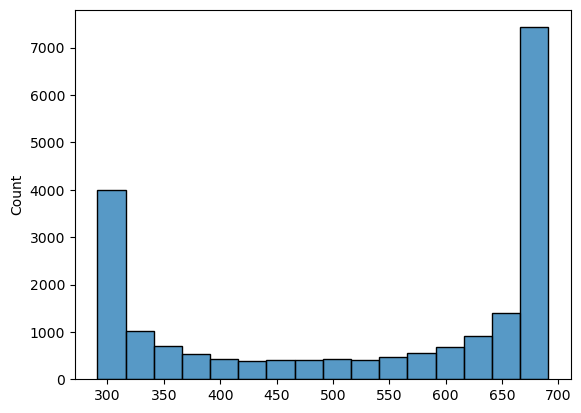

In [9]:
sns.histplot(data=(aux>0).sum())

In [10]:
aux = adata.to_df()
th = (aux>0).sum().quantile(.7)
print(th)
# cols = aux.loc[:,(((aux>0).sum())>=th).values].columns
cols = aux.loc[:,(((aux>0).sum())>=th).values].columns
aux.loc[:,(((aux>0).sum())>=th).values].head()

679.0


NMNAT3       NMT1    LPCAT1     KRT23        EVL     MACF1  \
SRR14675811  3.698268  17.869562  1.247063  3.279311  13.157526  9.208133   
SRR14675812  1.216780   4.714020  0.113627  0.741127   3.365281  9.412744   
SRR14675813  8.288824  33.533007  0.787019  3.762472  23.296083  8.160651   
SRR14675814  3.256562  16.929764  1.062071  4.919020  14.073394  7.278472   
SRR14675815  2.328703  17.900022  1.724819  1.685062  11.383978  4.592463   

               PRPF19      NEK7     APOL1     PHKG2  ...      CCT5      PURA  \
SRR14675811  1.969213  1.385902  3.378063  0.800857  ...  5.351533  8.111878   
SRR14675812  0.050293  0.565136  1.491737  0.204446  ...  0.517397  2.926578   
SRR14675813  1.672085  1.956752  5.025311  2.414696  ...  6.689530  9.742505   
SRR14675814  1.631437  0.640845  4.142695  1.145673  ...  5.449680  9.510379   
SRR14675815  0.717625  0.863289  2.081147  0.685227  ...  3.552950  5.824697   

              HLA-DRB1      NLRC5   SERINC3   PHACTR1   SLC7A14    CTDSP2  \
SRR14675811  35.055475   9.766339  4.818316  1.233866  0.574693  3.515069   
SRR14675812   4.955858   2.845137  1.313767  1.675404  0.276092  1.226684   
SRR14675813  93.873232  20.077701  6.593228  1.376828  0.752742  7.310164   
SRR14675814  45.416548   9.583654  3.362681  3.833964  0.252629  3.344405   
SRR14675815  12.197730   9.291400  3.087440  1.910687  0.174879  2.491886   

                NCOA2      PDE4B  
SRR14675811  3.136384   9.050980  
SRR14675812  0.853023   2.809990  
SRR14675813  2.464601  32.181997  
SRR14675814  0.898820   6.214739  
SRR14675815  0.949243   4.179272  

[5 rows x 6075 columns]

In [11]:
adata = adata[:,cols]
adata

View of AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [12]:
hkg.mining.exprs_cv(adata, layer='trns_expr', groups_col='louvain_group')
hkg.mining.stability_cv(adata, layer='trns_expr', groups_col='louvain_group')

/mnt/d/housekeeping_genes/housekeepingMinerPy/mining.py:63: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mean_'+str(gc)] = np.mean(X_, axis=0)


AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [13]:
hkg.mining.stability_cv(adata, layer='trns_expr', groups_col='louvain_group')

Computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [14]:
from sklearn.neighbors import NearestNeighbors
from sknetwork.clustering import Louvain
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

In [15]:
nearestNeighbors_object = NearestNeighbors()
louvain_object = Louvain(random_state=42, resolution=.5)
scaler_object = StandardScaler()

In [16]:
hkg.mining.uclustering_cv_stb(adata, #cv_col='pool_cv', stb_col='pool_stability_cv',
                              nearestNeighbors_object=nearestNeighbors_object,
                              louvain_object=louvain_object,scaler_object=scaler_object)

AnnData object with n_obs × n_vars = 691 × 6075
    obs: 'gse', 'ar', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'log1p', 'trns_expr'

In [17]:
adata.var.uclustering_cv_stb_labels.nunique()

35

In [18]:
# ax = sns.scatterplot(x='pool_cv',y='pool_stability_cv', hue='uclustering_cv_stb_labels', palette='tab20b', data=adata.var, legend=False)

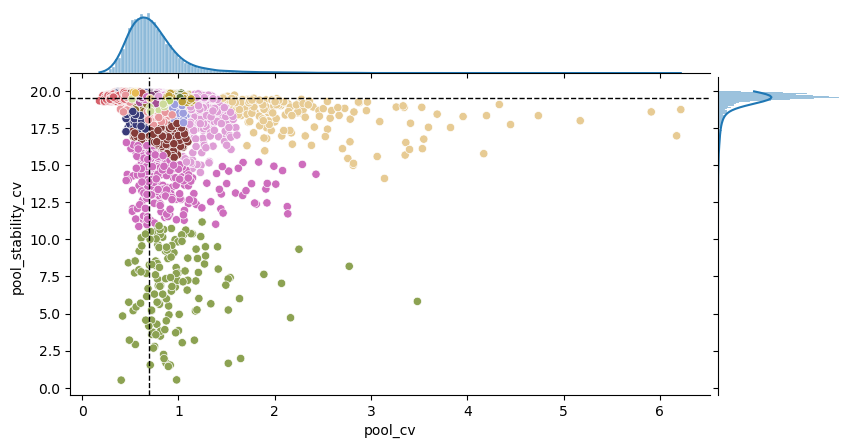

In [19]:
hkg.plot.plot_stb_cv(adata, hue='uclustering_cv_stb_labels', palette='tab20b_r')

In [20]:
adata.var.sort_values('pool_stability_cv')

pool_mean      pool_std   pool_cv  pool_stability_cv  \
HBB      99764.077436  40419.936530  0.405155           0.503488   
HBA1     14823.905991  14542.339640  0.981006           0.520577   
MALAT1     786.572484    704.052900  0.895090           1.427392   
IFITM2    1579.634733   1444.690153  0.914572           1.519526   
RPLP2      489.008518    345.754933  0.707053           1.524594   
...               ...           ...       ...                ...   
ACOT9        1.785973      0.784523  0.439269          19.980790   
TIMMDC1      1.582027      0.708692  0.447965          19.984469   
NDUFS2       1.649627      0.663905  0.402457          19.987955   
DPF2         1.658645      0.836746  0.504475          19.988540   
ASB8         1.841817      0.811722  0.440718          19.996696   

         uclustering_cv_stb_labels  
HBB                             24  
HBA1                            24  
MALAT1                          24  
IFITM2                          24  
RPLP2                           24  
...                            ...  
ACOT9                           10  
TIMMDC1                         10  
NDUFS2                          10  
DPF2                            12  
ASB8                            10  

[6075 rows x 5 columns]

In [21]:
adata.var[adata.var.uclustering_cv_stb_labels==24]

pool_mean    pool_std   pool_cv  pool_stability_cv  \
RPS25    40.598777   37.645776  0.927264           9.155098   
RPL6     31.695004   26.157060  0.825274          10.633936   
ARPC2    33.075568   22.007836  0.665380          10.253461   
STAG2   108.974040  178.118465  1.634504           6.006582   
RPL23A   69.227685   54.701611  0.790170           6.877257   
...            ...         ...       ...                ...   
EEF1A1   94.008763  115.786511  1.231657          10.196096   
RPS23    43.801536   48.048271  1.096954           8.739622   
IRF1     63.640929   51.369607  0.807179           6.837682   
FTL     188.086199   92.195835  0.490179           3.204947   
MALAT1  786.572484  704.052900  0.895090           1.427392   

        uclustering_cv_stb_labels  
RPS25                          24  
RPL6                           24  
ARPC2                          24  
STAG2                          24  
RPL23A                         24  
...                           ...  
EEF1A1                         24  
RPS23                          24  
IRF1                           24  
FTL                            24  
MALAT1                         24  

[146 rows x 5 columns]

In [22]:
adata_hkg = adata[:,adata.var.uclustering_cv_stb_labels==24]

In [25]:
adata_hkg = adata[:,adata.var.uclustering_cv_stb_labels==24]
ga_res = hkg.mining.hkg_selection_ga(adata_hkg, layer='trns_expr', fitness_function='minimize_outliers')
adata_hkg[:,np.where(ga_res2[0])[0]].var

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [29]:
np.where(ga_res[0])

(array([  0,   2,   3,   5,   8,   9,  11,  12,  13,  14,  17,  20,  22,
         24,  27,  28,  31,  35,  36,  41,  42,  43,  47,  49,  50,  51,
         52,  55,  57,  61,  64,  65,  67,  72,  76,  77,  78,  80,  81,
         82,  83,  84,  85,  86,  88,  89,  91,  93,  98,  99, 100, 102,
        104, 105, 109, 111, 112, 115, 118, 121, 122, 124, 127, 129, 131,
        132, 133, 134, 135, 138, 144, 145]),)

In [37]:
# adata_hkg = adata_hkg[:,np.where(ga_res[0])[0]]

In [39]:
ga_res2 = hkg.mining.hkg_selection_ga(adata_hkg, layer='trns_expr', fitness_function='minimize_outliers')

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [40]:
np.where(ga_res2[0])

(array([ 0,  3,  4,  6,  7, 11, 12, 14, 17, 20, 30, 31, 32, 33, 35, 36, 38,
        40, 42, 43, 46, 48, 53, 56, 58, 59, 64, 65, 69]),)

In [42]:
adata_hkg[:,np.where(ga_res2[0])[0]].var

pool_mean    pool_std   pool_cv  pool_stability_cv  \
RPS25     40.598777   37.645776  0.927264           9.155098   
CTSS      53.398740   41.127924  0.770204           8.507482   
S100A12   48.898648  101.242902  2.070464           7.039054   
TPT1      98.109230   98.878245  1.007838           4.944391   
OAZ1     107.616005   45.203602  0.420045           4.832231   
RPL37     47.667149   47.442386  0.995285           7.736307   
SELL      32.806433   22.674658  0.691165          10.493856   
MYL6      41.171375   24.360889  0.591695           9.214063   
RPL30    151.848911  147.455281  0.971066           3.701300   
S100A9   488.085639  424.770455  0.870279           1.663387   
RPLP1     77.124983   51.694736  0.670272           6.155799   
RPL18     91.704755   73.573192  0.802283           5.624266   
RPL32     35.678744   30.210626  0.846740          10.670634   
SLC2A3    33.511230   38.370453  1.145003          10.378198   
UBA52     86.154051   48.293688  0.560550           5.443989   
ZNF302    54.984552  152.494702  2.773410           8.189918   
PFN1      37.382866   29.393674  0.786287           9.647137   
YBX3      50.991650   38.823685  0.761373           7.610652   
LST1      38.265260   30.562198  0.798693           9.454118   
MYO9B     35.395096   40.008884  1.130351          10.390123   
AHSP      44.320259   67.211584  1.516498           7.334936   
TMSB10   156.042707  114.252128  0.732185           3.743881   
IST1      76.560766  114.217208  1.491850           6.916346   
NOP53     59.358859   58.023398  0.977502           7.697146   
RPL8      48.230388   34.900678  0.723624           8.308626   
RPS8      64.877782   60.467903  0.932028           6.821953   
HNRNPA1   56.731698   68.479631  1.207079           7.772471   
CORO1A    37.349658   23.145062  0.619686           9.565735   
CD52      36.267555   37.597817  1.036679           9.877718   

         uclustering_cv_stb_labels  
RPS25                           24  
CTSS                            24  
S100A12                         24  
TPT1                            24  
OAZ1                            24  
RPL37                           24  
SELL                            24  
MYL6                            24  
RPL30                           24  
S100A9                          24  
RPLP1                           24  
RPL18                           24  
RPL32                           24  
SLC2A3                          24  
UBA52                           24  
ZNF302                          24  
PFN1                            24  
YBX3                            24  
LST1                            24  
MYO9B                           24  
AHSP                            24  
TMSB10                          24  
IST1                            24  
NOP53                           24  
RPL8                            24  
RPS8                            24  
HNRNPA1                         24  
CORO1A                          24  
CD52                            24

In [25]:
np.__version__

'1.26.3'

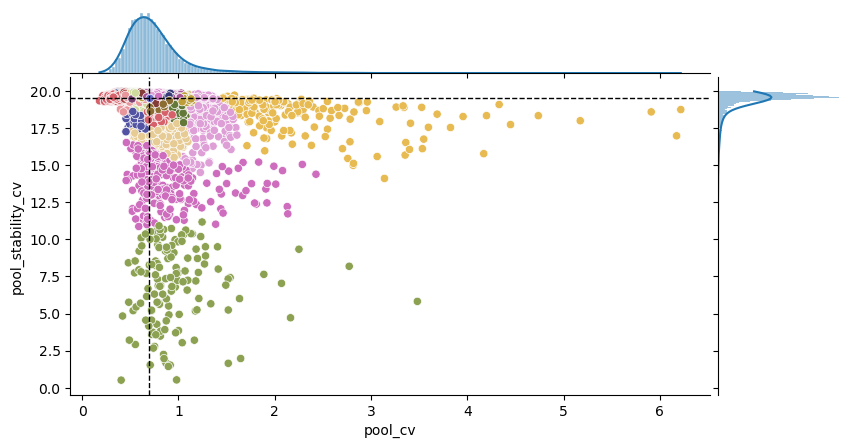

In [25]:
hkg.plot.plot_stb_cv(adata, x='pool_cv', y='pool_stability_cv', hue='uclustering_cv_stb_labels', palette='tab20b_r')

AttributeError: 'DataFrame' object has no attribute 'uclustering_cv_stb_labels'

In [25]:
import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

def plot_stb_cv(adata, x:str = 'pool_cv', y:str = 'pool_stability_cv', hue:str = 'uclustering_cv_stb_labels'):
    fig = plt.figure(figsize=(8.35,8.35))
    gs = GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], wspace=.02, hspace=.02)

    ax_clu = fig.add_subplot(gs[1,0])
    ax_hist_cv = fig.add_subplot(gs[1,1])
    ax_hist_mean = fig.add_subplot(gs[0,0])

    sns.scatterplot(x=x, y=y, hue=hue, palette=None, data=adata.var, s=60, ax=ax_clu)
    ax_clu.spines[['right', 'top']].set_visible(False)

    sns.histplot(x=x, ec='white', data=adata.var, kde=True, ax=ax_hist_mean)
    ax_hist_mean.spines[['left','right', 'top']].set_visible(False)
    ax_hist_mean.set_xlabel(None)
    ax_hist_mean.set_ylabel(None)
    ax_hist_mean.set_xticklabels([])
    ax_hist_mean.set_yticklabels([])
    ax_hist_mean.tick_params(left = False)
    ax_hist_mean.grid(False)

    sns.histplot(y=y, ec='white', data=adata.var, kde=True, ax=ax_hist_cv)
    ax_hist_cv.spines[['right', 'top','bottom']].set_visible(False)
    ax_hist_cv.set_ylabel(None)
    ax_hist_cv.set_xlabel(None)
    ax_hist_cv.set_yticklabels([])
    ax_hist_cv.set_xticklabels([])
    ax_hist_cv.tick_params(bottom = False)
    ax_hist_cv.grid(False)

    # return fig

TypeError: plot_stb_cv() got an unexpected keyword argument 'palette'

In [27]:
import tempfile
import itertools
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances

In [38]:
adata = adata[:, :5]

In [138]:
cols_ = []
idx_ = []
groups_col = 'louvain_group'
X_ = adata.layers['trns_expr']
df_mean_ = []
df_std_ = []
j = 0
groups = adata.obs[groups_col].unique()
for i,gc in enumerate(groups):
    print(i, end=' ')
    idx = np.where(adata.obs[groups_col]==gc)
    df_mean_.append( pairwise_distances(X_[idx,:][0].T).mean(axis=0) )
    df_std_.append( pairwise_distances(X_[idx,:][0].T).std(axis=0) )
    # .append(mean_X_)
    # .append(std_X_)
# aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
# del(df_std_)
# del(df_mean_)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [149]:
pairwise_distances(X_[:,:].T).std(axis=0) / pairwise_distances(X_[:,:].T).mean(axis=0)

array([31.80105014, 31.51076177, 31.98414822, ..., 32.01317731,
       32.13324751, 32.09113263])

In [174]:
aux = pd.DataFrame(np.array(df_std_) / np.array(df_mean_)).T
aux.columns = ['gc_'+str(g) for g in groups]
aux

gc_8       gc_2       gc_7       gc_3       gc_5       gc_9  \
0     33.712148  37.854610  30.344044  33.927517  34.428704  31.265417   
1     33.884421  37.966903  29.862405  33.813666  34.674488  31.211331   
2     33.943080  38.098223  30.975092  34.304407  35.003174  31.282843   
3     33.536398  37.812253  30.179171  33.489584  34.597237  31.270713   
4     33.755481  38.027778  30.711519  34.140146  34.810167  31.167430   
...         ...        ...        ...        ...        ...        ...   
2124  33.851090  38.058819  30.822194  34.314018  34.649977  31.294309   
2125  32.573522  37.474768  28.254035  32.617580  33.692795  31.109704   
2126  33.865384  38.082253  30.832617  34.297910  34.910746  31.279061   
2127  33.888833  38.082066  30.963397  34.233472  34.926460  31.271717   
2128  33.758087  38.047201  30.840261  34.220636  34.713433  31.287808   

           gc_6       gc_4       gc_1       gc_0  ...     gc_14     gc_17  \
0     36.846921  32.834539  34.129976  25.735936  ...  0.537394  0.566831   
1     37.096299  32.805951  31.659862  20.140710  ...  1.077456  1.047807   
2     37.224410  33.802238  33.421917  23.170773  ...  0.708590  0.787005   
3     37.001334  33.410994  34.328347  26.230049  ...  0.332160  0.376877   
4     37.107628  33.562803  34.470864  26.436957  ...  0.881399  0.782858   
...         ...        ...        ...        ...  ...       ...       ...   
2124  37.162580  33.338767  33.809245  25.146018  ...  0.437228  0.549896   
2125  36.106875  31.577571  31.319904  19.632275  ...  1.015007  0.961417   
2126  37.189708  33.699908  33.716253  23.820033  ...  1.094967  1.042664   
2127  37.235983  33.690716  34.498268  26.484824  ...  1.124372  1.074739   
2128  37.156504  33.720693  34.451313  26.427916  ...  0.812646  0.644420   

         gc_13     gc_11     gc_15     gc_16     gc_12     gc_18     gc_26  \
0     0.752540  0.607329  0.549425  0.588862  0.626404  0.614936  0.533541   
1     1.099893  1.103388  1.024392  1.069875  1.083297  1.069468  1.015483   
2     0.569519  0.744603  0.704903  0.628132  0.715949  0.738218  0.623473   
3     0.296770  0.315294  0.300599  0.293204  0.307696  0.352859  0.310655   
4     0.778564  0.884723  0.820884  0.781399  0.817679  0.859213  0.575551   
...        ...       ...       ...       ...       ...       ...       ...   
2124  0.351828  0.400803  0.423638  0.418765  0.355791  0.465915  0.359092   
2125  1.012342  1.018804  0.978202  0.987881  1.015146  0.981714  1.010361   
2126  1.094336  1.111421  1.050594  1.067086  1.094451  1.046086  1.075890   
2127  1.113702  1.131445  1.089499  1.091813  1.126486  1.091035  1.064130   
2128  0.343431  0.446607  0.419608  0.488800  0.424623  0.414749  0.342574   

         gc_25  
0     0.634044  
1     0.993912  
2     0.679039  
3     0.297306  
4     0.626958  
...        ...  
2124  0.338844  
2125  1.005151  
2126  1.064157  
2127  1.066080  
2128  0.303553  

[2129 rows x 27 columns]

In [166]:
(pd.DataFrame(df_std_) / pd.DataFrame(df_mean_))#.mean(axis=0).sort_values()

0          1          2          3          4          5     \
0   33.712148  33.884421  33.943080  33.536398  33.755481  33.856560   
1   37.854610  37.966903  38.098223  37.812253  38.027778  38.075624   
2   30.344044  29.862405  30.975092  30.179171  30.711519  30.912682   
3   33.927517  33.813666  34.304407  33.489584  34.140146  34.200432   
4   34.428704  34.674488  35.003174  34.597237  34.810167  34.906617   
5   31.265417  31.211331  31.282843  31.270713  31.167430  31.280226   
6   36.846921  37.096299  37.224410  37.001334  37.107628  37.218402   
7   32.834539  32.805951  33.802238  33.410994  33.562803  33.694867   
8   34.129976  31.659862  33.421917  34.328347  34.470864  34.156661   
9   25.735936  20.140710  23.170773  26.230049  26.436957  25.869226   
10   0.631517   1.022306   0.810619   0.292540   0.800458   0.708027   
11   0.633760   1.012597   0.839797   0.283193   0.871541   0.857108   
12   0.510465   0.700474   0.595431   0.274520   0.774202   0.503852   
13   0.816105   1.003072   0.542501   0.230918   0.540546   0.902647   
14   0.820220   0.961468   0.545503   0.234727   0.508956   0.834737   
15   0.904590   1.088308   0.637928   0.238132   0.498740   0.886295   
16   0.628112   1.036057   0.644094   0.286357   0.845997   0.827449   
17   0.537394   1.077456   0.708590   0.332160   0.881399   1.083150   
18   0.566831   1.047807   0.787005   0.376877   0.782858   1.001873   
19   0.752540   1.099893   0.569519   0.296770   0.778564   0.563671   
20   0.607329   1.103388   0.744603   0.315294   0.884723   0.916690   
21   0.549425   1.024392   0.704903   0.300599   0.820884   0.851866   
22   0.588862   1.069875   0.628132   0.293204   0.781399   0.961811   
23   0.626404   1.083297   0.715949   0.307696   0.817679   0.757431   
24   0.614936   1.069468   0.738218   0.352859   0.859213   0.945908   
25   0.533541   1.015483   0.623473   0.310655   0.575551   0.466285   
26   0.634044   0.993912   0.679039   0.297306   0.626958   0.437361   

         6          7          8          9     ...       2119       2120  \
0   32.912147  33.654800  33.871838  33.805705  ...  29.574178  33.757345   
1   37.338808  37.902503  38.077872  38.075637  ...  36.500088  38.030298   
2   29.177947  30.258487  30.960445  30.975212  ...  24.393286  30.810543   
3   32.895037  33.970324  34.259007  34.270961  ...  29.586378  34.128269   
4   33.371481  34.734824  34.937590  34.956476  ...  32.330504  34.811497   
5   30.951243  31.276802  31.285305  31.267506  ...  31.171255  31.279277   
6   36.706198  36.799265  37.176202  37.193032  ...  33.292034  37.132185   
7   31.278340  33.535953  33.750341  33.765025  ...  30.339102  33.565650   
8   34.414874  34.336676  34.435473  34.031543  ...  33.973682  34.438171   
9   26.324253  25.945176  26.347265  25.586754  ...  24.874632  26.435539   
10   1.048659   0.275823   0.306484   0.349540  ...   1.060054   0.939644   
11   1.083595   0.346181   0.310990   0.370369  ...   1.089545   1.042069   
12   1.070472   0.267669   0.291582   0.345628  ...   1.063268   0.936154   
13   1.050183   0.344463   0.331709   0.329462  ...   1.025410   0.899966   
14   0.976850   0.361616   0.337630   0.368764  ...   1.038892   0.877499   
15   1.083621   0.391649   0.340476   0.351396  ...   1.088016   0.860860   
16   1.055462   0.335780   0.362920   0.355078  ...   1.101371   1.048696   
17   1.030037   0.420910   0.403561   0.384434  ...   1.116021   1.125738   
18   0.897177   0.444120   0.400848   0.451969  ...   1.043879   1.059928   
19   1.103159   0.310613   0.323042   0.340589  ...   1.112345   0.955144   
20   1.078864   0.377253   0.375903   0.406863  ...   1.131550   1.101798   
21   0.993952   0.357386   0.358821   0.381839  ...   1.082629   1.018237   
22   0.962857   0.440016   0.392286   0.388712  ...   1.095061   1.081526   
23   1.101323   0.335105   0.357984   0.366084  ...   1.119804   0.978868   
24   0.944400   0.419182   0.386750   0.425084  ...   1.088551   1.

In [58]:
cols_ = []
idx_ = []
groups_col = 'louvain_group'
X_ = adata.layers['trns_expr']
df_mean_ = []
df_std_ = []
j = 0
groups = adata.obs[groups_col].unique()
for k,gc in enumerate(groups):
    print(k, end=' ')
    idx = np.where(adata.obs[groups_col]==gc)
    mean_X_ = []
    std_X_ = []
    for i in range(X_.shape[1]):
        mean_X_.extend(np.mean(X_[idx,i:] - X_[idx,i,None], axis=1)[0].astype(str))
        std_X_.extend(np.std(X_[idx,i:] - X_[idx,i,None], axis=1)[0].astype(str))
        if j == 0:            
            cols_.extend([','.join(p) for p in itertools.product([adata.var.index[i]],adata.var[i:].index)])                
    j+=1

    if k == 0:
        with open('/mnt/d/housekeeping_genes/test_stb_mean.csv', 'w') as f:
            f.write('\t'.join(cols_)+'\n')
    with open('/mnt/d/housekeeping_genes/test_stb_mean.csv', 'a') as f:
        f.write('\t'.join(mean_X_)+'\n')
#     df_mean_.append(mean_X_)
#     df_std_.append(std_X_)
# aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
# del(df_std_)
# del(df_mean_)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

In [100]:
X_ = adata.layers['trns_expr']

In [108]:
pairwise_distances(X_.T).mean(axis=0)

array([6079.36114954, 6135.31541746, 6044.7064307 , ..., 6039.21480393,
       6016.74664974, 6024.5745967 ])

In [110]:
pairwise_distances(X_.T).std(axis=0)

array([193330.06873945, 193328.46250872, 193334.78642725, ...,
       193334.45436032, 193337.6092993 , 193335.42242762])

In [98]:
X_[:,0] - X_[:,1]

array([ -1, -11])

In [19]:
aux = pd.DataFrame(df_std_, columns=cols_, index=groups)/pd.DataFrame(df_mean_, columns=cols_, index=groups)
aux = aux[[c for c in aux.columns if (len(set(c.split(',')))>1)]].abs()
aux = aux.mean(axis=0).reset_index()
aux.columns = ['gene', 'stability_cv']
aux[['G1','G2']] = aux['gene'].str.split(',', expand=True)
aux = pd.concat([aux[['G1','stability_cv']].set_index('G1'), aux[['G2','stability_cv']].set_index('G2')], axis=0).reset_index()
aux.columns = ['gene', 'stability_cv']
# adata.var['pool_stability_cv'] = aux.groupby('gene').mean().loc[adata.var.index,:]
aux

gene  stability_cv
0      TPT1      0.386237
1      TPT1      0.365534
2      TPT1      0.689933
3      TPT1      0.459710
4      TPT1      0.484252
..      ...           ...
235  TRIM13      0.324191
236   SYNE3      0.231898
237  TRIM13      0.441273
238   SYNE3      0.380119
239   SYNE3      4.688279

[240 rows x 2 columns]

In [140]:
adata.var

pool_mean       pool_std   pool_cv  pool_stability_cv
TPT1          99.870647     101.984256  1.021163           1.281687
STIP1          1.542766       0.726204  0.470715           1.118414
SCFD1          4.743274       2.149083  0.453080           2.230019
RPL37         47.793400      45.747994  0.957203           4.606917
OGA            6.913984       4.028201  0.582616           1.373671
SAMHD1         5.647720       3.479893  0.616159           0.836379
SLC25A37     206.447476     186.235511  0.902096           0.714871
RYBP           4.081056       2.947615  0.722268           1.262018
SPECC1         4.439930       3.895261  0.877325           1.179602
EPB41         13.324056      15.192647  1.140242           1.627686
RBM4           5.408328       2.781088  0.514223           1.447018
HBB       113264.818845  134439.976336  1.186953           0.813421
CFLAR         16.656757      13.851299  0.831572           0.696888
HBA1       20121.541780   90745.507264  4.509868           1.150650
TRIM13         1.050355       0.722116  0.687497           2.317028
SYNE3          1.028853       0.391712  0.380727           5.140694

In [103]:
adata[adata.obs.gse=='GSE120649',:].X

ArrayView([[9.98638170e+01, 2.06423100e+00, 3.80511600e+00,
            3.58792590e+01, 1.47395240e+01, 1.29085990e+01,
            3.90202832e+02, 1.43453200e+00, 1.21606710e+01,
            4.95345740e+01, 4.35112400e+00, 1.21213804e+05,
            4.68641160e+01, 1.57683926e+04, 7.74075000e-01,
            1.62781200e+00],
           [2.92362182e+02, 8.01974800e+00, 1.51823210e+01,
            1.11205999e+02, 4.37109740e+01, 4.69621330e+01,
            3.72636744e+02, 4.37952400e+00, 2.06417450e+01,
            6.12572010e+01, 1.51558080e+01, 1.17208240e+05,
            1.15346969e+02, 1.44692470e+04, 3.34425000e+00,
            5.09943500e+00],
           [8.72300815e+02, 7.26774800e+00, 1.84634900e+01,
            4.17397507e+02, 5.62469270e+01, 4.40823270e+01,
            2.58591105e+02, 5.73111700e+00, 1.53003950e+01,
            5.94940740e+01, 2.20880010e+01, 9.18616368e+04,
            1.23745731e+02, 8.47847636e+03, 6.19110400e+00,
            5.22581100e+00],
           [4

In [102]:
adata.obs.gse.unique()

['GSE175718', 'GSE120649', 'GSE14346', 'GSE15296', 'GSE129166', 'GSE46474']
Categories (6, object): ['GSE14346', 'GSE15296', 'GSE46474', 'GSE120649', 'GSE129166', 'GSE175718']

In [90]:
np.mean(X_[idx,i:] - X_[idx,i,None], axis=1).shape

(1, 2129)

In [94]:
np.mean(X_[idx,129:] - X_[idx,129,None], axis=1)[0]

array([ 0.        , -0.09190557, -0.60799553, ...,  0.00485014,
        0.01155771, -0.41119867])

In [96]:
len(mean_X_)

57483

In [1]:
# df_temp = pd.read_csv(temp.name)
# df_temp
temp.close()

NameError: name 'temp' is not defined

In [36]:
df_temp

NameError: name 'df_temp' is not defined

In [20]:
# 

In [32]:
import warnings

import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import seaborn as sns

def gene_gini_coeff(adata, layer:str = None):
    """
    G = 1 + 1/n - 2*sum_i(rank_k*x_i) / n*sum_i(x_i)
    """

    if layer != None:
        X_ = adata.layers[layer]
    else:
        X_ = adata.X

    gini_list = []
    for i in range(X_.shape[1]):
        x = np.abs(X_[:,i])
        n = len(x)
        s = x.sum()
        rank = np.argsort(np.argsort(-x))
        gini_list.append( 1 - (2.0 * (rank*x).sum() + s)/(n*s) )

    adata.var['gini_coefficient'] = gini_list
    return adata

def plot_stb_cv_gini(adata, x:str = 'pool_cv', y:str = 'pool_stability_cv', z:str='pool_mean', hue:str = 'uclustering_cv_stb_labels', palette:str = None, legend:bool = False, figsize:tuple = (8.35*2,8.35), median_line:bool = True):
    fig = plt.figure(figsize=figsize)

    gs = fig.add_gridspec(3,1)
    # gs_top = GridSpec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02)
    gs_top = gs[0].subgridspec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02) 
    ax_clu = fig.add_subplot(gs_top[1,0])
    ax_y = fig.add_subplot(gs_top[1,1])
    ax_x = fig.add_subplot(gs_top[0,0])
    ax_y_bar = fig.add_subplot(gs_top[0,2])
    ax_y_violin = fig.add_subplot(gs_top[1,2])

    gs_middle = gs[1].subgridspec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02) 
    ax_clu2 = fig.add_subplot(gs_middle[1,0])
    ax_y2 = fig.add_subplot(gs_middle[1,1])
    ax_x2 = fig.add_subplot(gs_middle[0,0])
    ax_y_bar2 = fig.add_subplot(gs_middle[0,2])
    ax_y_violin2 = fig.add_subplot(gs_middle[1,2])

    gs_bottom = gs[2].subgridspec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1, 5], wspace=.02, hspace=.02) 
    ax_clu3 = fig.add_subplot(gs_bottom[1,0])
    ax_y3 = fig.add_subplot(gs_bottom[1,1])
    ax_x3 = fig.add_subplot(gs_bottom[0,0])
    ax_y_bar3 = fig.add_subplot(gs_bottom[0,2])
    ax_y_violin3 = fig.add_subplot(gs_bottom[1,2])


    # gs_bottom = gs[2].subgridspec(2, 3, width_ratios=[8, 1, 8], height_ratios=[1,5], wspace=.02, hspace=.02)
    # ax_x_violin = fig.add_subplot(gs_bottom[1,0])
    # ax_z_violin = fig.add_subplot(gs_bottom[1,2])

    hue_order = adata.var[hue].unique()
    if hue == None:
        palette = None
        cmap = None
    else:        
        cmap = plt.get_cmap(palette, len(hue_order))
        cmap = [colors.to_hex(cmap(i)) for i in range(len(hue_order))]
        cmap = dict(zip(hue_order,cmap))

    # TOP grid
    sns.scatterplot(x=x, y=y, hue=hue, palette=cmap, data=adata.var, ax=ax_clu)
    ax_clu.get_legend().set_visible(legend)
    ax_clu.spines[['right', 'top']].set_visible(False)

    sns.histplot(x=x, ec='white', data=adata.var, kde=True, ax=ax_x)
    ax_x.spines[['left','right', 'top']].set_visible(False)
    ax_x.set_xlabel(None)
    ax_x.set_ylabel(None)
    ax_x.set_xticklabels([])
    ax_x.set_yticklabels([])
    ax_x.tick_params(left = False)
    ax_x.grid(False)    
    
    sns.histplot(y=y, ec='white', data=adata.var, kde=True, ax=ax_y)
    ax_y.spines[['right', 'top','bottom']].set_visible(False)
    ax_y.set_ylabel(None)
    ax_y.set_xlabel(None)
    ax_y.set_yticklabels([])
    ax_y.set_xticklabels([])
    ax_y.tick_params(bottom = False)
    ax_y.grid(False)    

    order = adata.var.groupby(hue).median(numeric_only=True).sort_values(y).index
    sns.countplot(x=hue, order=order, color='gray', data=adata.var, ax=ax_y_bar)
    ax_y_bar.set_xticklabels([])
    ax_y_bar.set_xlabel(None)
    ax_y_bar.spines[['left','right', 'top']].set_visible(False)
    ax_y_bar.set_ylabel('Qty.')

    sns.stripplot(x=hue, y=y, order=order, color='black', s=1, data=adata.var, ax=ax_y_violin)
    sns.boxplot(x=hue, y=y, order=order, palette=cmap, data=adata.var, ax=ax_y_violin) 
    ax_y_violin.set_ylabel(None)
    ax_y_violin.set_yticklabels([])
    aux_md = adata.var.groupby(hue).quantile(0.75, numeric_only=True)
    arg_max = len(aux_md.loc[aux_md[y]<=adata.var[y].median(numeric_only=True)][y]) - .5
    ax_y_violin.axvline(arg_max, ls=':', lw=1,color='gray')

    # Middle grid
    sns.scatterplot(x=x, y=z, hue=hue, palette=cmap, data=adata.var, ax=ax_clu2)
    ax_clu2.get_legend().set_visible(legend)
    ax_clu2.spines[['right', 'top']].set_visible(False)

    sns.histplot(x=x, ec='white', data=adata.var, kde=True, ax=ax_x2)
    ax_x2.spines[['left','right', 'top']].set_visible(False)
    ax_x2.set_xlabel(None)
    ax_x2.set_ylabel(None)
    ax_x2.set_xticklabels([])
    ax_x2.set_yticklabels([])
    ax_x2.tick_params(left = False)
    ax_x2.grid(False)    
    
    sns.histplot(y=z, ec='white', data=adata.var, kde=True, ax=ax_y2)
    ax_y2.spines[['right', 'top','bottom']].set_visible(False)
    ax_y2.set_ylabel(None)
    ax_y2.set_xlabel(None)
    ax_y2.set_yticklabels([])
    ax_y2.set_xticklabels([])
    ax_y2.tick_params(bottom = False)
    ax_y2.grid(False)    

    order = adata.var.groupby(hue).median(numeric_only=True).sort_values(z).index
    sns.countplot(x=hue, order=order, color='gray', data=adata.var, ax=ax_y_bar2)
    ax_y_bar2.set_xticklabels([])
    ax_y_bar2.set_xlabel(None)
    ax_y_bar2.spines[['left','right', 'top']].set_visible(False)
    ax_y_bar2.set_ylabel('Qty.')

    sns.stripplot(x=hue, y=z, order=order, color='black', s=1, data=adata.var, ax=ax_y_violin2)
    sns.boxplot(x=hue, y=z, order=order, palette=cmap, data=adata.var, ax=ax_y_violin2) 
    ax_y_violin2.set_ylabel(None)
    ax_y_violin2.set_yticklabels([])
    aux_md = adata.var.groupby(hue).quantile(0.75, numeric_only=True)
    arg_max = len(aux_md.loc[aux_md[z]<=adata.var[z].median(numeric_only=True)][z]) - .5
    ax_y_violin2.axvline(arg_max, ls=':', lw=1,color='gray')

    # Bottom grid
    sns.scatterplot(x=z, y=x, hue=hue, palette=cmap, data=adata.var, ax=ax_clu3)
    ax_clu3.get_legend().set_visible(legend)
    ax_clu3.spines[['right', 'top']].set_visible(False)

    sns.histplot(x=z, ec='white', data=adata.var, kde=True, ax=ax_x3)
    ax_x3.spines[['left','right', 'top']].set_visible(False)
    ax_x3.set_xlabel(None)
    ax_x3.set_ylabel(None)
    ax_x3.set_xticklabels([])
    ax_x3.set_yticklabels([])
    ax_x3.tick_params(left = False)
    ax_x3.grid(False)    
    
    sns.histplot(y=x, ec='white', data=adata.var, kde=True, ax=ax_y3)
    ax_y3.spines[['right', 'top','bottom']].set_visible(False)
    ax_y3.set_ylabel(None)
    ax_y3.set_xlabel(None)
    ax_y3.set_yticklabels([])
    ax_y3.set_xticklabels([])
    ax_y3.tick_params(bottom = False)
    ax_y3.grid(False)    

    order = adata.var.groupby(hue).median(numeric_only=True).sort_values(x).index
    sns.countplot(x=hue, order=order, color='gray', data=adata.var, ax=ax_y_bar3)
    ax_y_bar3.set_xticklabels([])
    ax_y_bar3.set_xlabel(None)
    ax_y_bar3.spines[['left','right', 'top']].set_visible(False)
    ax_y_bar3.set_ylabel('Qty.')

    sns.stripplot(x=hue, y=x, order=order, color='black', s=1, data=adata.var, ax=ax_y_violin3)
    sns.boxplot(x=hue, y=x, order=order, palette=cmap, data=adata.var, ax=ax_y_violin3) 
    ax_y_violin3.set_ylabel(None)
    ax_y_violin3.set_yticklabels([])
    aux_md = adata.var.groupby(hue).quantile(0.75, numeric_only=True)
    arg_max = len(aux_md.loc[aux_md[x]<=adata.var[x].median(numeric_only=True)][x]) - .5
    ax_y_violin3.axvline(arg_max, ls=':', lw=1,color='gray')

    # # gs.update(hspace=.2)
    # # gs_bottom = GridSpec(1, 3, width_ratios=[8, 1, 8], height_ratios=[5], wspace=.02, hspace=.02)
    # ####
    # order = adata.var.groupby(hue).median(numeric_only=True).sort_values(x).index
    # # palette = None
    # sns.stripplot(x=hue, y=x, order=order, color='black', s=1, data=adata.var, ax=ax_x_violin)
    # sns.boxplot(x=hue, y=x, order=order, palette=cmap, data=adata.var, ax=ax_x_violin)#

    # order = adata.var.groupby(hue).median(numeric_only=True).sort_values(z, ascending=True).index
    # sns.stripplot(x=hue, y=z, order=order, color='black', s=1, data=adata.var, ax=ax_z_violin)
    # sns.boxplot(x=hue, y=z, order=order, palette=cmap, data=adata.var, ax=ax_z_violin)

    if median_line:
        ax_clu.axvline(np.median(adata.var[x]), ls='--', lw=1,color='black')
        ax_clu.axhline(np.median(adata.var[y]), ls='--', lw=1, color='black')
        ax_y_violin.axhline(np.median(adata.var[y]), ls='--', lw=1, color='black')
        
        ax_clu2.axvline(np.median(adata.var[x]), ls='--', lw=1,color='black')
        ax_clu2.axhline(np.median(adata.var[z]), ls='--', lw=1, color='black')
        ax_y_violin2.axhline(np.median(adata.var[z]), ls='--', lw=1, color='black')
        
        ax_clu3.axvline(np.median(adata.var[z]), ls='--', lw=1,color='black')
        ax_clu3.axhline(np.median(adata.var[x]), ls='--', lw=1, color='black')
        ax_y_violin3.axhline(np.median(adata.var[x]), ls='--', lw=1, color='black')
    # fig.tight_layout()
    return None

In [ ]:
# TOST
aux = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'),(adata.var.uclustering_cv_stb_labels.isin([13]))].to_df('arcsinh')#,16,18,19
# aux.iloc[:,:] = (aux.T.values / aux.UBB.values).T
aux['conditions'] = adata[aux.index,:].obs.conditions_GSE175718.values
aux['louvain_group'] = adata[aux.index,:].obs.louvain_group.values
aux = aux[aux.conditions!='ABMR and TCMR']

cohens_d = .5
# dict_pairs = {p:[] for p in itertools.combinations(aux.conditions.unique(), 2)}
dict_pairs = {p:[] for p in itertools.combinations(aux.conditions.unique(), 2) if 'non-rejection' in p}
dict_pairs_md = dict_pairs.copy()
pairs = []
pvalues = []
for p in dict_pairs.keys():
    # delta = cohens_d*np.sqrt((np.square(aux[aux['conditions'].isin(p)].groupby('conditions').std())/aux[aux['conditions'].isin(p)].groupby('conditions').count()).sum(axis=0))
    delta = cohens_d*aux[aux['conditions'].isin(p)].std(numeric_only=True)
    # delta = cohens_d*aux[aux['conditions']=='non-rejection'].std(numeric_only=True)
    pv = []
    mean_diff = []
    for g in aux.columns[:-2]:
        pv.append(max(brunnermunzel(aux[aux['conditions']==p[0]][g].values, aux[aux['conditions']==p[1]][g].values + delta[g], alternative='less').pvalue,
                      brunnermunzel(aux[aux['conditions']==p[0]][g].values, aux[aux['conditions']==p[1]][g].values - delta[g], alternative='greater').pvalue)
                 )
        mean_diff.append(aux[aux['conditions']==p[0]][g].mean() - aux[aux['conditions']==p[1]][g].mean())
        pairs.append( list(itertools.product([g],p)) )
    dict_pairs[p] = false_discovery_control(pv)
    dict_pairs_md[p] = mean_diff
    pvalues.extend(pv)
    print(p)
# pvalues = false_discovery_control(pvalues)
# aux_tost = pd.DataFrame(dict_pairs, index=aux.columns[:-2]).T[pd.DataFrame(dict_pairs, index=aux.columns[:-2]).T.reset_index().median(numeric_only=True).sort_values().index].reset_index()
aux_tost = pd.DataFrame(dict_pairs, index=aux.columns[:-2]).T[(pd.DataFrame(dict_pairs, index=aux.columns[:-2]).T<=0.05).sum().sort_values(ascending=False).index]
aux_tost.index = ['pv_'+'_'.join(p) for p in aux_tost.index]
# aux_tost.iloc[:,:] = -np.log10(false_discovery_control(aux_tost.iloc[:,:].values.flatten()).reshape(2,218))

# aux_tost.iloc[:,:]

aux_md = pd.DataFrame(dict_pairs_md, index=aux.columns[:-2]).T
aux_md.index = ['md_'+'_'.join(p) for p in aux_md.index]


In [ ]:
from sklearn.preprocessing import LabelBinarizer
import pygad
import hdbscan
def hkg_selection_ga(adata, layer:str = None, outlier_threshold:float = .9, fitness_function:str = 'minimize_outliers', fitness_function_model = None, y:str = None, suppress_warnings:bool = False):
    if layer != None:
        X_ = adata.layers[layer]
    else:
        X_ = adata.X

    # lb = LabelBinarizer()
    # y_ = lb.fit_transform(adata.obs[y].values)
    y_ = adata.obs[y].values
    # print(y_)
    

    if fitness_function == 'minimize_groups_qty':
        def fitness_func(ga_instance, solution, solution_idx):
            clusterer = hdbscan.HDBSCAN().fit(X_[:, np.where( solution )[0]] )
            labels = clusterer.labels_
            fitness = 1 / np.unique(labels).shape[0]
            return fitness
    elif fitness_function == 'minimize_outliers':
        def fitness_func(ga_instance, solution, solution_idx):
            clusterer = hdbscan.HDBSCAN().fit(X_[:, np.where( solution )[0]] )
            threshold = np.quantile(clusterer.outlier_scores_, q=.9)
            inliers = np.where(clusterer.outlier_scores_ <= threshold)[0].shape[0]
            fitness = inliers
            return fitness
    elif fitness_function == 'minimize_accuarcy':
        def fitness_func(ga_instance, solution, solution_idx):
            # print(solution)
            if fitness_function_model != None:
                clf = fitness_function_model
            else:
                clf = SVC(class_weight='balanced')
                clf.fit(X_[:, np.where( solution )[0]], y_)
                
            score_ = clf.score(X_[:, np.where( solution )[0]], y_)

            if  score_ == 0.5:
                score_ = 0.5 + 0.000001

            fitness = 1 / np.abs(0.5 - score_)
            return fitness
    elif fitness_function == 'minimize_f1_score':
        def fitness_func(ga_instance, solution, solution_idx):
            if fitness_function_model != None:
                clf = fitness_function_model
            else:
                clf = SVC(class_weight='balanced')
                clf.fit(X_[:, np.where( solution )[0]], y_)
            
            y_p = clf.predict(X_[:, np.where( solution )[0]])
            score_ = f1_score(y_, y_p, average='weighted')

            if  score_ == 0.5:
                score_ = 0.5 + 0.000001

            fitness = 1 / np.abs(0.5 - score_)
            return fitness
    elif fitness_function == 'minimize_auc':
        def fitness_func(ga_instance, solution, solution_idx):            
            if fitness_function_model != None:
                clf = fitness_function_model
            else:
                clf = SVC(class_weight='balanced', probability=True)
                clf.fit(X_[:, np.where( solution )[0]], y_)

            lb = LabelBinarizer()            
            y_p = clf.predict_proba(X_[:, np.where( solution )[0]])
            score_ = roc_auc_score(lb.fit_transform(y_), y_p, average='weighted', multi_class='ovo')

            if  score_ == 0.5:
                score_ = 0.5 + 0.000001

            fitness = 1 / np.abs(0.5 - score_)
            return fitness 

    num_generations = 100
    num_parents_mating = 2

    sol_per_pop = 8
    num_genes = X_.shape[1]#len(bm)

    init_range_low = 0
    init_range_high = 2

    parent_selection_type = "sss"
    keep_parents = 1

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 10

    gene_type = int

    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           # init_range_low=init_range_low,
                           # init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           gene_type=gene_type,
                           gene_space=[0, 1],
                           suppress_warnings=suppress_warnings
                          )

    ga_instance.run()
    # solution, solution_fitness, solution_idx = ga_instance.best_solution()
    return ga_instance.best_solution()